In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import scipy.stats as sps
import json, pickle, os, corner, glob, sys
from collections import defaultdict, OrderedDict
from copy import deepcopy
import enterprise.signals.utils as utils
from enterprise.pulsar import Pulsar
import pandas as pd

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import utils
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import signal_base
from enterprise.signals import selections

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

import la_forge
import la_forge.diagnostics as dg
from la_forge.core import TimingCore
from la_forge.core import Core

In [3]:
color_cycle_wong = ['#000000','#E69F00','#009E73','#56B4E9','#0072B2','#F0E442','#D55E00','#CC79A7']
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle_wong)

In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
#top_path_idx = splt_path.index("akaiser")
top_path_idx = splt_path.index("nanograv")
top_dir = "/".join(splt_path[0 : top_path_idx + 1])

In [5]:
e_e_path = top_dir + "/enterprise_extensions/"
sys.path.insert(0, e_e_path)
sys.path.insert(0, top_dir + "/enterprise_timing")

In [6]:
import enterprise_extensions
from enterprise_extensions.timing import timing_block,tm_delay
#from nltm_J0340_setup_pta_v1 import pta_setup

In [7]:
psr_name = 'J0740+6620'#'J0340+4130'#'J1640+2224'#'J2043+1711'#'J2317+1439' 'J1909-3744'
#parfile = top_dir + f"/12p5yr/narrowband/par/{psr_name}_NANOGrav_12yv3.gls.par"
#timfile = top_dir + f"/12p5yr/narrowband/tim/{psr_name}_NANOGrav_12yv3.tim"
parfile = top_dir + f"/12p5yr/{psr_name}/{psr_name}.cfr+19.par"
timfile = top_dir + f"/12p5yr/{psr_name}/{psr_name}.cfr+19.tim"

ephem = 'DE436'
psr = Pulsar(parfile, timfile, ephem=ephem, clk=None, drop_t2pulsar=False)

In [8]:
ptypes = ["normalized" for ii in range(len(psr.t2pulsar.pars()))]
tm_params_orig = OrderedDict(
        zip(
            psr.t2pulsar.pars(),
            map(
                list,
                zip(
                    np.longdouble(psr.t2pulsar.vals()),
                    np.longdouble(psr.t2pulsar.errs()),
                    ptypes,
                ),
            ),
        )
    )

In [9]:
def tm_delay(t2pulsar, tm_params_orig, **kwargs):
    """
    Compute difference in residuals due to perturbed timing model.

    :param t2pulsar: libstempo pulsar object
    :param tm_params_orig: dictionary of TM parameter tuples, (val, err)

    :return: difference between new and old residuals in seconds
    """
    residuals = t2pulsar.residuals()
    # grab original timing model parameters and errors in dictionary
    orig_params = {}
    tm_params_rescaled = {}
    error_pos = {}
    for tm_scaled_key, tm_scaled_val in kwargs.items():
        if "DMX" in tm_scaled_key:
            tm_param = "_".join(tm_scaled_key.split("_")[-2:])
        else:
            tm_param = tm_scaled_key.split("_")[-1]
                    
        if tm_param == "COSI":
            orig_params["SINI"] = np.longdouble(tm_params_orig["SINI"][0])
        else:
            orig_params[tm_param] = np.longdouble(tm_params_orig[tm_param][0])
            
        if "physical" in tm_params_orig[tm_param]:
            # User defined priors are assumed to not be scaled
            if tm_param == "COSI":
                # Switch for sampling in COSI, but using SINI in libstempo
                tm_params_rescaled["SINI"] = np.longdouble(np.sqrt(1-np.longdouble(tm_scaled_val)**2))
            else:
                tm_params_rescaled[tm_param] = np.longdouble(tm_scaled_val)
        else:
            if tm_param == "COSI":
                # Switch for sampling in COSI, but using SINI in libstempo
                rescaled_COSI = np.longdouble(
                    tm_scaled_val * tm_params_orig["COSI"][1]
                    + tm_params_orig["COSI"][0]
                )
                tm_params_rescaled["SINI"] = np.longdouble(
                    np.sqrt(1-rescaled_COSI**2)
                )
                print("Rescaled COSI used to find SINI", np.longdouble(rescaled_COSI))
                print("rescaled SINI",tm_params_rescaled["SINI"])
            else:
                tm_params_rescaled[tm_param] = np.longdouble(
                    tm_scaled_val * tm_params_orig[tm_param][1]
                    + tm_params_orig[tm_param][0]
                )
    # set to new values
    print(tm_params_rescaled)
    t2pulsar.vals(tm_params_rescaled)
    new_res = np.longdouble(t2pulsar.residuals().copy())

    # remeber to set values back to originals
    t2pulsar.vals(orig_params)
    
    plotres(t2pulsar,new_res,residuals,tm_params_rescaled)
    
    # Return the time-series for the pulsar
    return new_res - residuals

In [10]:
def plotres(psr,new_res,old_res,par_dict,deleted=False,group=None,**kwargs):
    """Plot residuals, compute unweighted rms residual."""

    t, errs = psr.toas(), psr.toaerrs

    meannewres = np.sqrt(np.mean(new_res**2)) / 1e-6
    meanoldres = np.sqrt(np.mean(old_res**2)) / 1e-6
    
    if (not deleted) and np.any(psr.deleted != 0):
        new_res, old_res, t, errs = new_res[psr.deleted == 0], old_res[psr.deleted == 0], t[psr.deleted == 0], errs[psr.deleted == 0]
        print("Plotting {0}/{1} nondeleted points.".format(len(new_res),psr.nobs))
    if group is None:
        i = np.argsort(t)
        pars = [x for x in par_dict.keys()]
        vals = []
        for p,v in zip(psr.pars(),psr.vals()):
            for pa in pars:
                if p == pa:
                    vals.append(v)
                    
        plt.errorbar(t[i],old_res[i]/1e-6,yerr=errs[i],fmt='x',
                     label=f'Old Residual, {pars[0]}={vals[0]:.2e}',**kwargs)
        plt.errorbar(t[i],new_res[i]/1e-6,yerr=errs[i],fmt='+',
                     label=f'New Residual, {pars[0]}={par_dict[pars[0]]:.2e}',**kwargs)
        #plt.legend()
    else:
        if (not deleted) and np.any(psr.deleted):
            flagmask = psr.flagvals(group)[~psr.deleted]
        else:
            flagmask = psr.flagvals(group)

        unique = list(set(flagmask))
            
        for flagval in unique:
            f = (flagmask == flagval)
            flagnewres, flagoldresflagt, flagerrs = new_res[f], old_res[f], t[f], errs[f]
            i = np.argsort(flagt)
            
            plt.errorbar(flagt[i],flagoldres[i]/1e-6,yerr=flagerrs[i],fmt='d',
                         label=f'Old Residual, {pars[0]}={vals[0]:.2e}',**kwargs)
            plt.errorbar(flagt[i],flagnewres[i]/1e-6,yerr=flagerrs[i],fmt='x',
                         label=f'New Residual, {pars[0]}={par_dict[pars[0]]:.2e}',**kwargs)
            
        #plt.legend(unique,numpoints=1,bbox_to_anchor=(1.1,1.1))

    plt.xlabel('MJD'); plt.ylabel('res [us]')
    plt.title(f"{psr.name} - rms old res = {meanoldres:.3f} us new res {meannewres:.3f} us")

In [11]:
[print(p,z,e) for p,z,e in zip(psr.t2pulsar.pars(),psr.t2pulsar.vals(),psr.t2pulsar.errs())];

ELONG 1.8109385533815700459 0.0
ELAT 0.7697335659135049691 nan
F0 346.53199649321283 5.768999999999999955e-13
F1 -1.463885178981e-15 2.3657078273240000303e-20
PMELONG -2.7479 0.028699999999999999817
PMELAT -32.4337 0.037400000000000002687
PX 0.5376 0.28349999999999997424
SINI 0.998965 0.0001689999999999999879
PB 4.76694461910366 1.1304999999999999994e-10
A1 3.977556053 1.5800000000000001191e-07
TASC 57552.08324415 1.6000000000000000997e-08
EPS1 -5.6991e-06 4.2499999999999996753e-08
EPS2 -1.8872e-06 2.7299999999999999612e-08
M2 0.257793 0.007525999999999999704
FD1 -1.17150709e-05 3.8151587300000000235e-07
DMX_0001 -0.00031136342 0.00014451733300000000997
DMX_0002 4.46738199e-05 0.00012390594000000001193
DMX_0003 -0.000166352964 0.00016785948400000001083
DMX_0004 -7.36281436e-05 8.1194793900000002606e-05
DMX_0005 -0.000227137156 7.567064300000000455e-05
DMX_0006 -0.000197501578 9.880195709999999422e-05
DMX_0007 -0.000208839349 7.632591450000000355e-05
DMX_0008 -0.000120864202 0.000122261

In [12]:
par = 'PX'
value = 2000
print(tm_params_orig[par][0])
print(tm_params_orig[par][1])
print(tm_params_orig[par][0]+tm_params_orig[par][1]*value)
tm_delay_kwargs = {par:value}
#psr.tm_params_orig

0.5376
0.28349999999999997424
567.5375999999999485


{'PX': 567.5375999999999485}


/home/andrew/anaconda3/envs/enterprise/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working


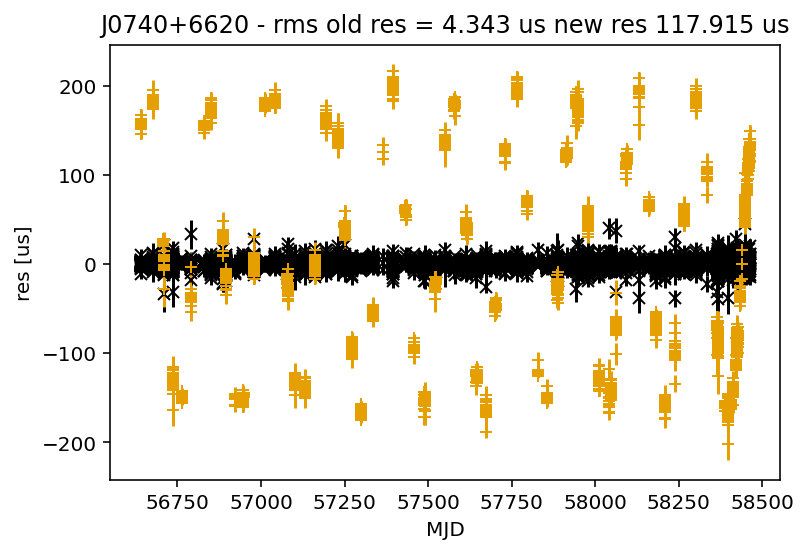

In [13]:
tm_delay(psr.t2pulsar,tm_params_orig,**tm_delay_kwargs);

In [14]:
def refit_errs(psr,tm_params_orig):
    # Check to see if nan or inf in pulsar parameter errors.
    # The refit will populate the incorrect errors, but sometimes
    # changes the values by too much, which is why it is done in this order.
    if np.any(np.isnan(psr.t2pulsar.errs())) or np.any(
        [err == 0.0 for err in psr.t2pulsar.errs()]
    ):
        eidxs = np.where(
            np.logical_or(np.isnan(psr.t2pulsar.errs()), psr.t2pulsar.errs() == 0.0)
        )[0]
        psr.t2pulsar.fit()
        for idx in eidxs:
            par = psr.t2pulsar.pars()[idx]
            print(par, np.longdouble(psr.t2pulsar.errs()[idx]))
            tm_params_orig[par][1] = np.longdouble(psr.t2pulsar.errs()[idx])

In [15]:
refit_errs(psr,tm_params_orig)

ELONG 2.5639566175880556325e-10
ELAT 2.7394360227648975774e-10
JUMP1 1.6478367060695058621e-07


/home/andrew/anaconda3/envs/enterprise/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  # This is added back by InteractiveShellApp.init_path()


{'ELONG': 1.8109388097772318047}


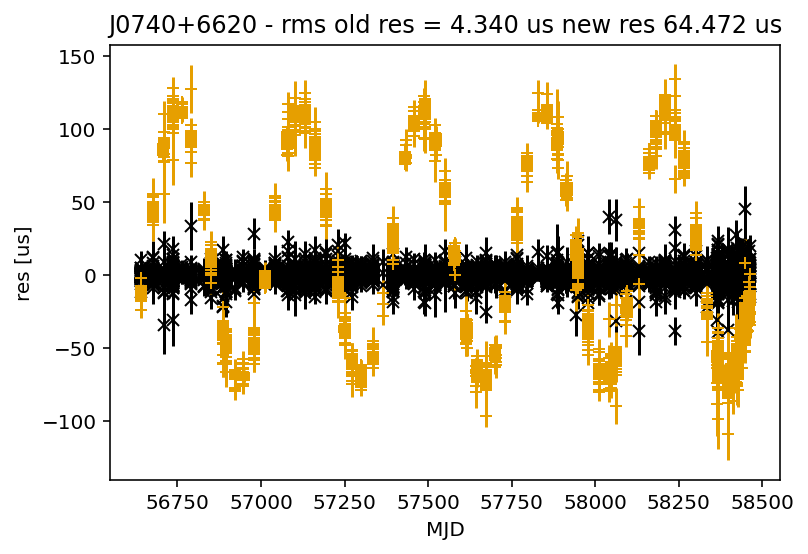

{'ELAT': 0.76973383985710724556}


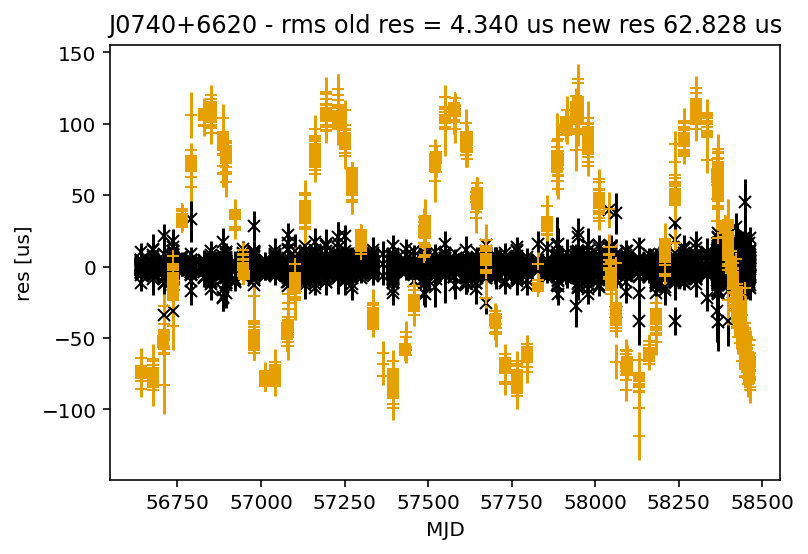

{'F0': 346.53199649378973}


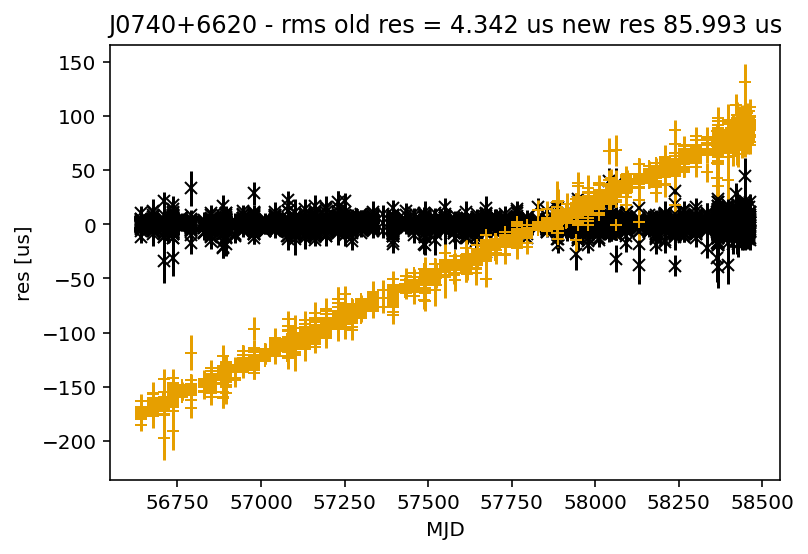

{'F1': -1.4402281007077599997e-15}


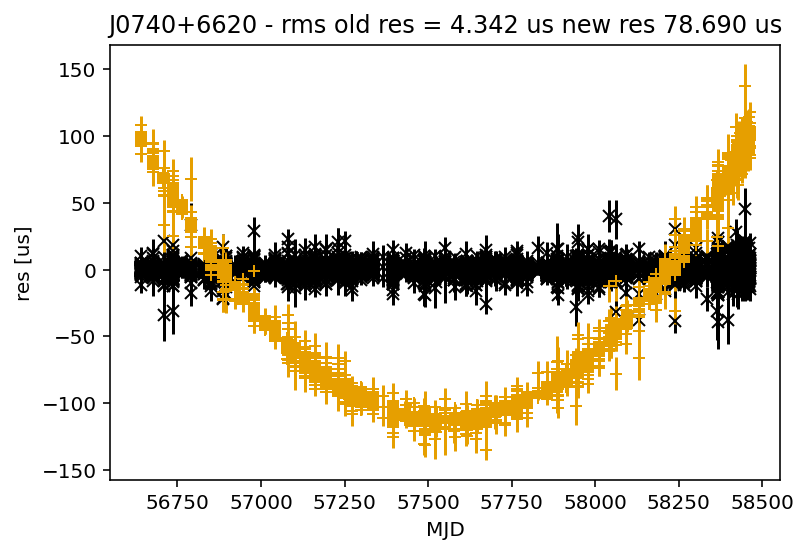

{'PMELONG': 25.952099999999999816}


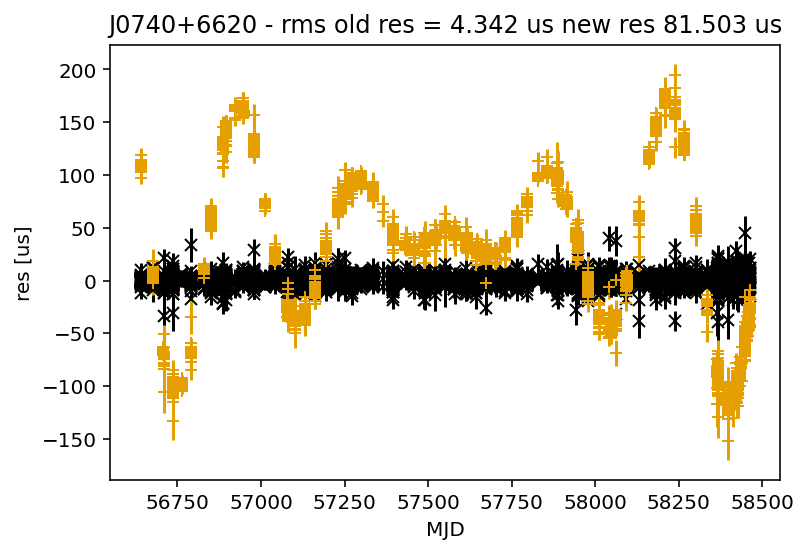

{'PMELAT': 4.966300000000002688}


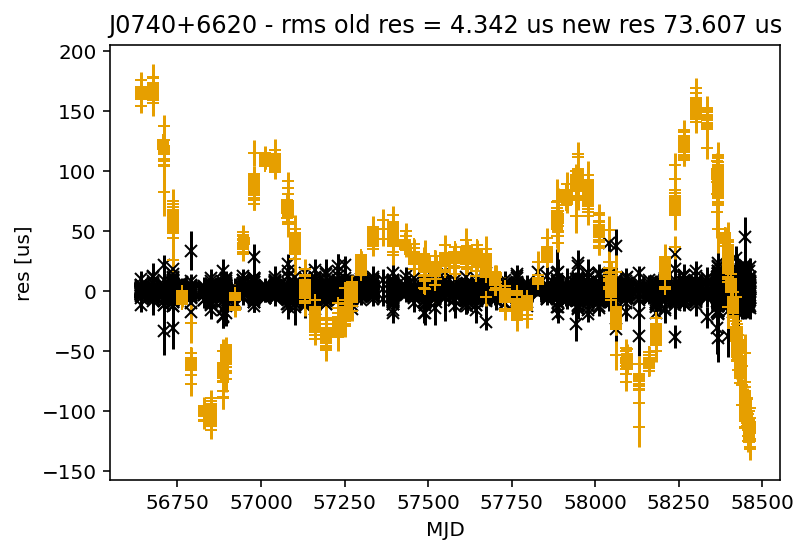

{'PX': 284.03759999999997424}


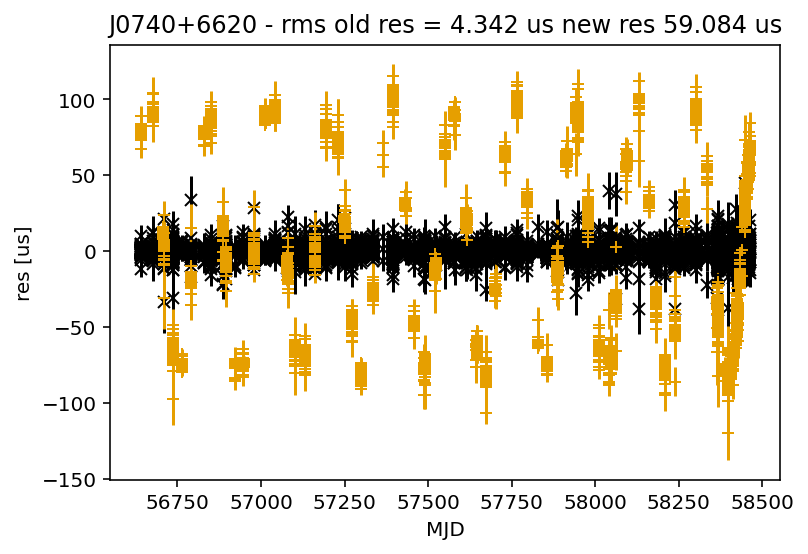

{'SINI': 1.1679649999999999879}


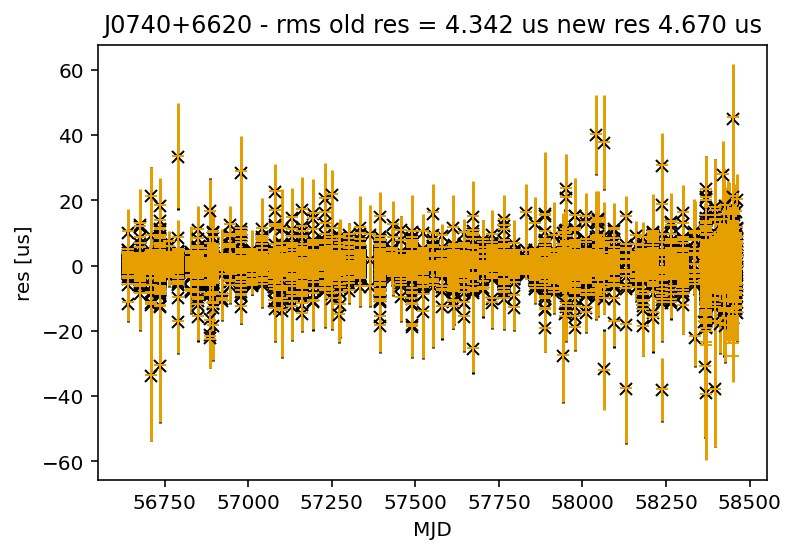

{'PB': 4.76694473215366}


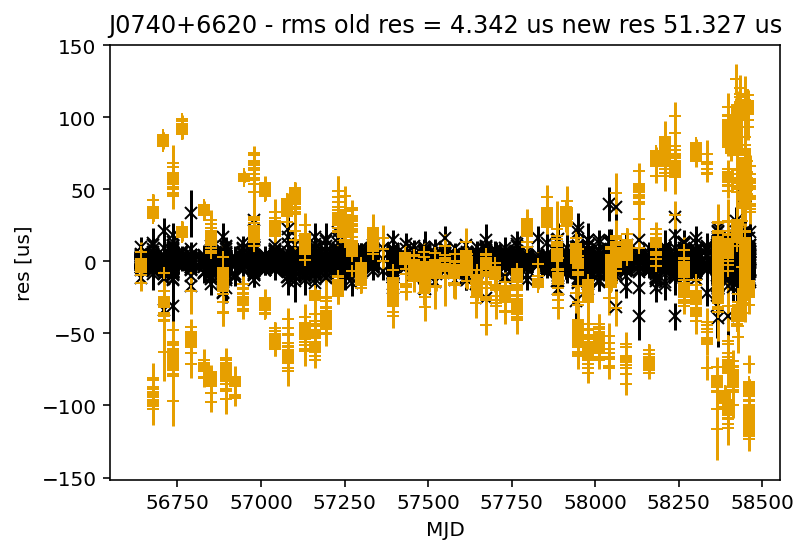

{'A1': 3.977714053}


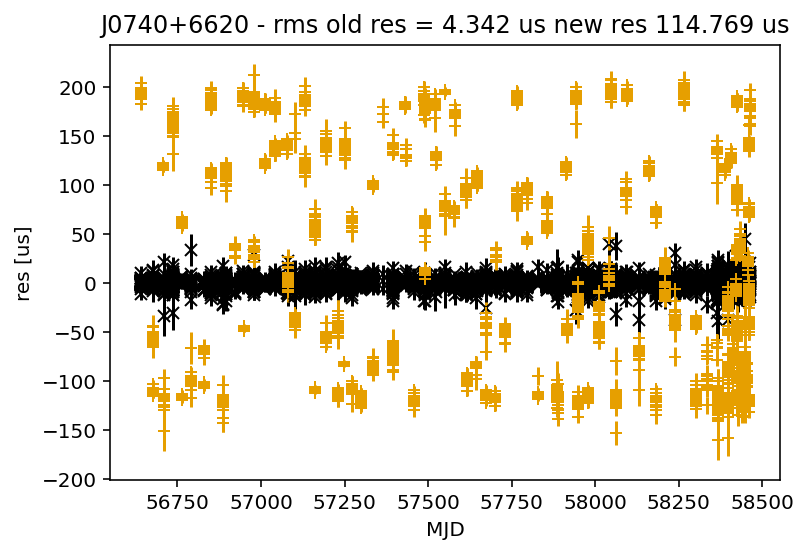

{'TASC': 57552.083260149999997}


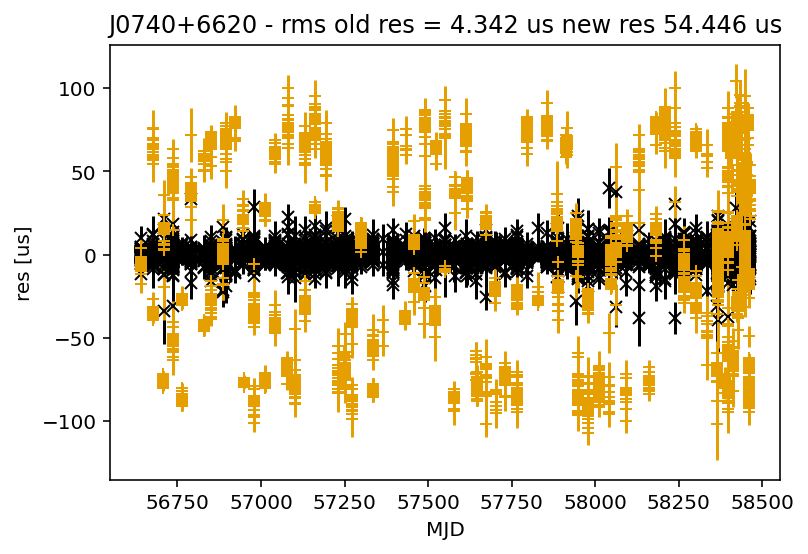

{'EPS1': 3.6800899999999996755e-05}


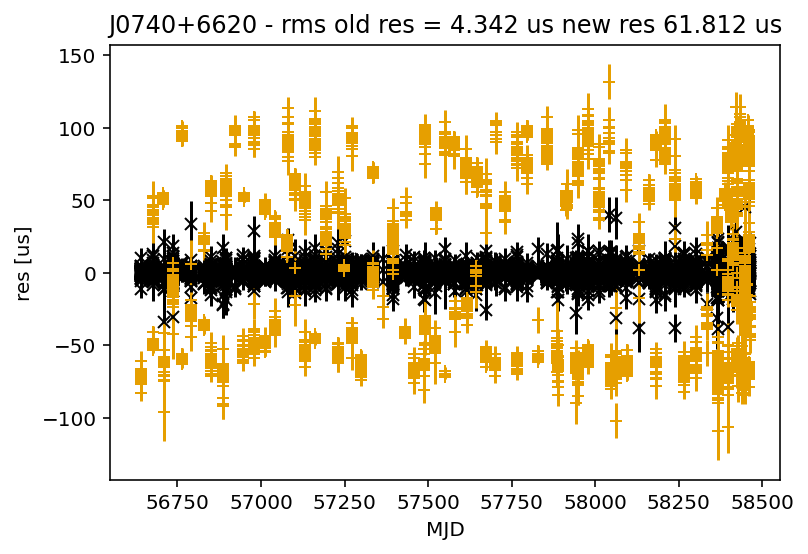

{'EPS2': 2.5412799999999999612e-05}


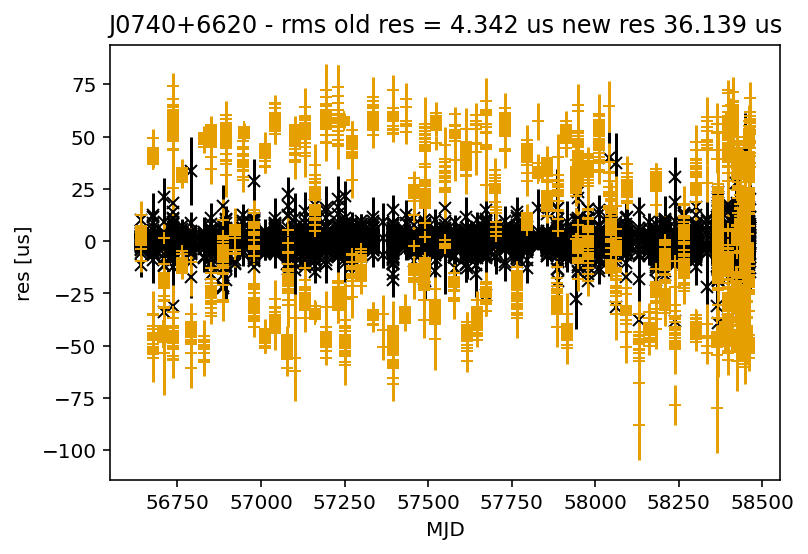

{'M2': 7.783792999999999704}


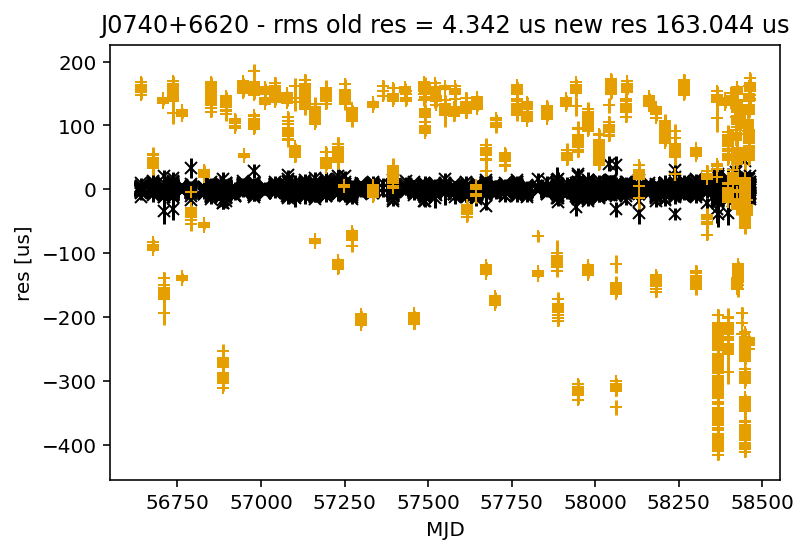

{'FD1': 0.00036980080210000000235}


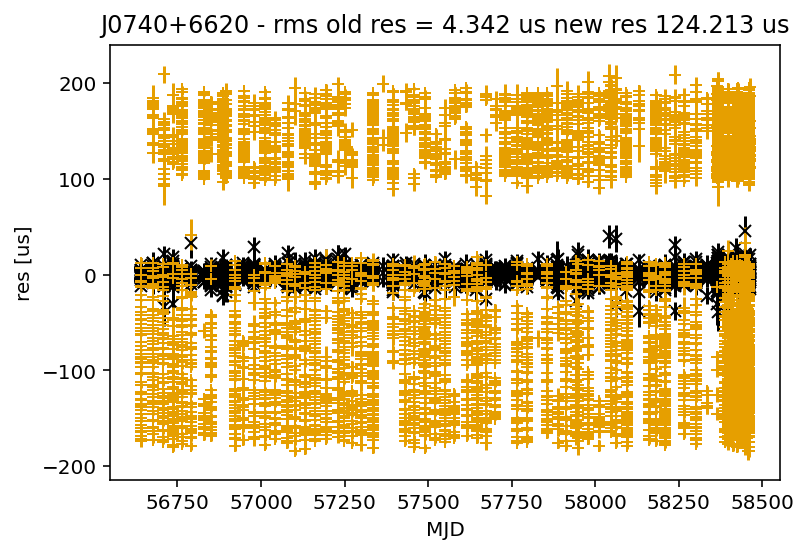

{'DMX_0001': 0.14420596958000000997}


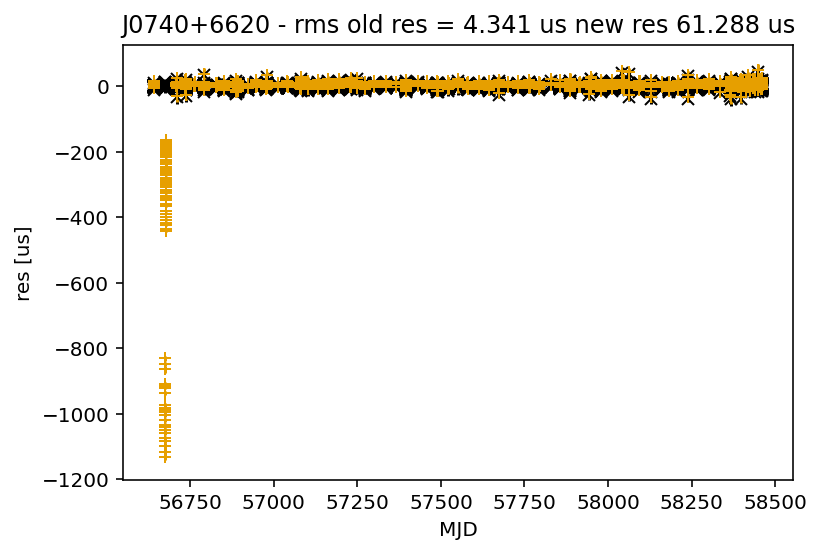

{'DMX_0002': 0.12395061381990001193}


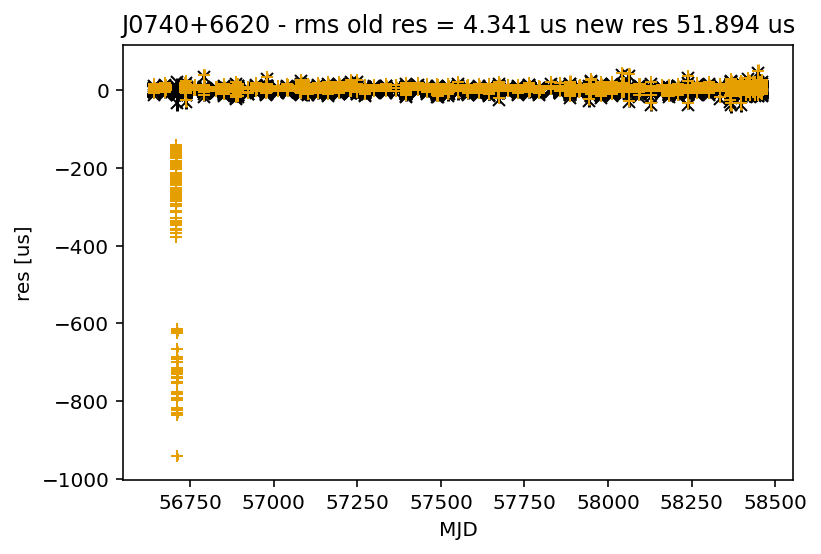

{'DMX_0003': 0.16769313103600001083}


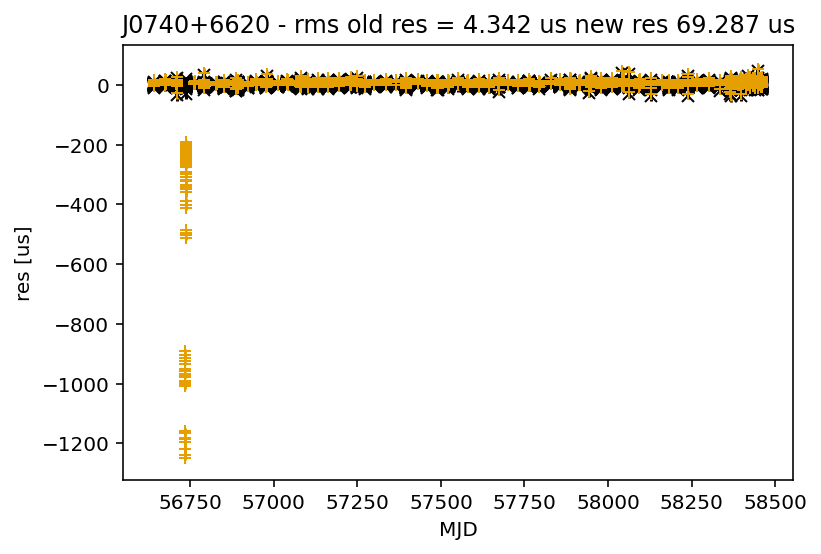

{'DMX_0004': 0.081121165756400002605}


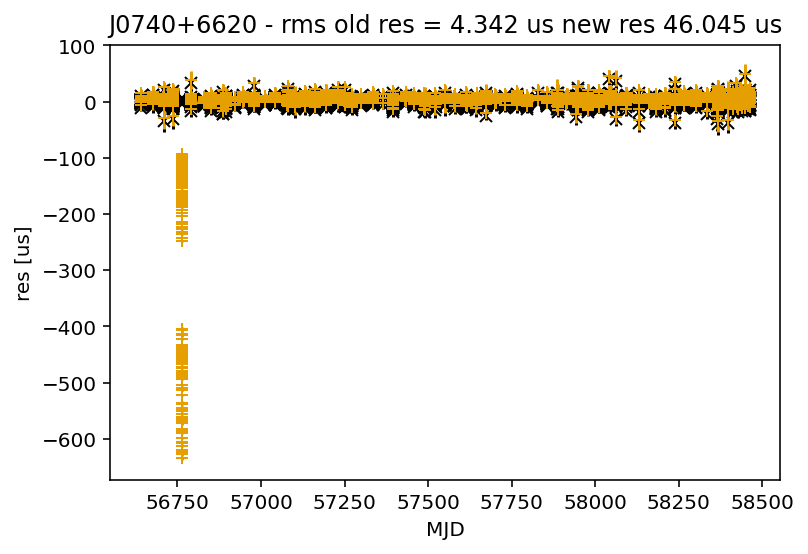

{'DMX_0005': 0.075443505844000004555}


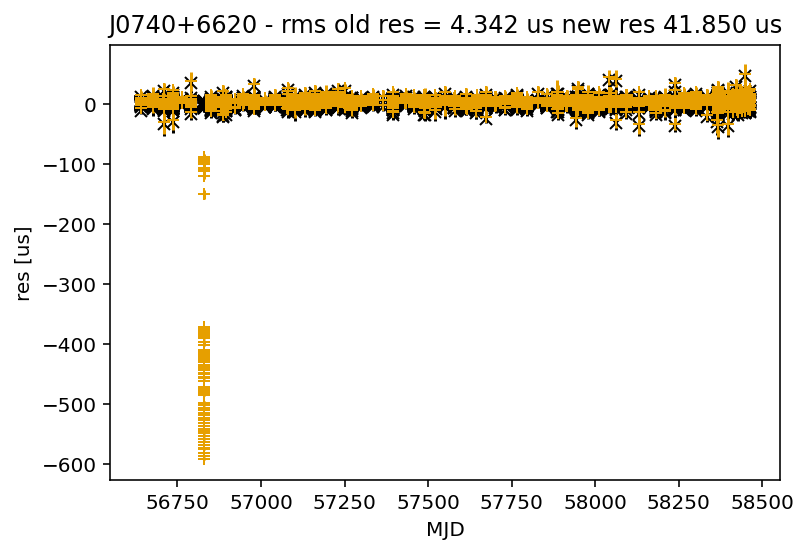

{'DMX_0006': 0.09860445552199999422}


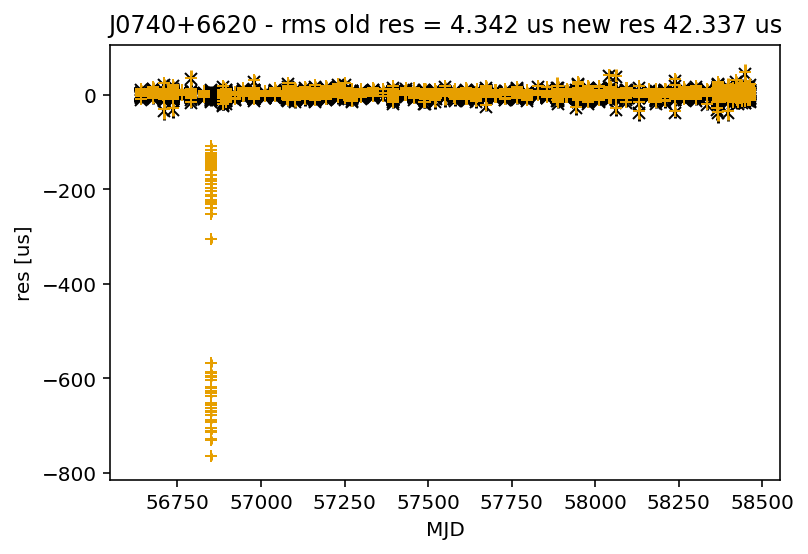

{'DMX_0007': 0.07611707515100000355}


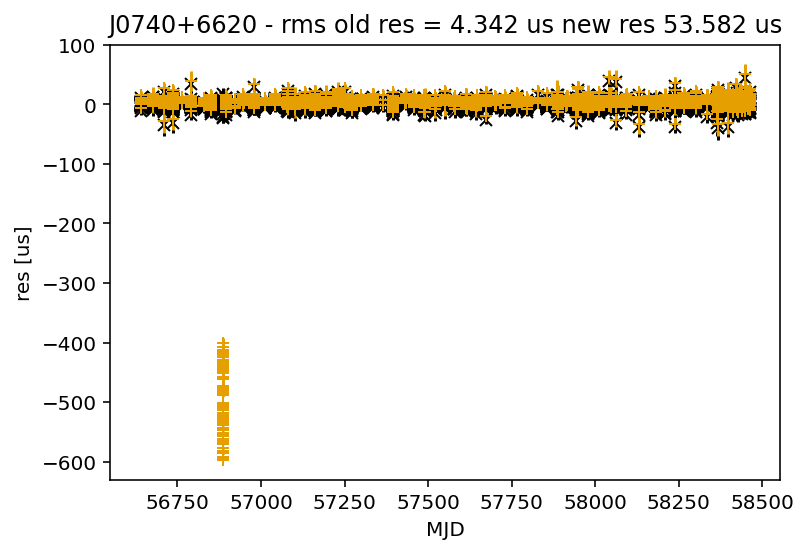

{'DMX_0008': 0.12214069379799999349}


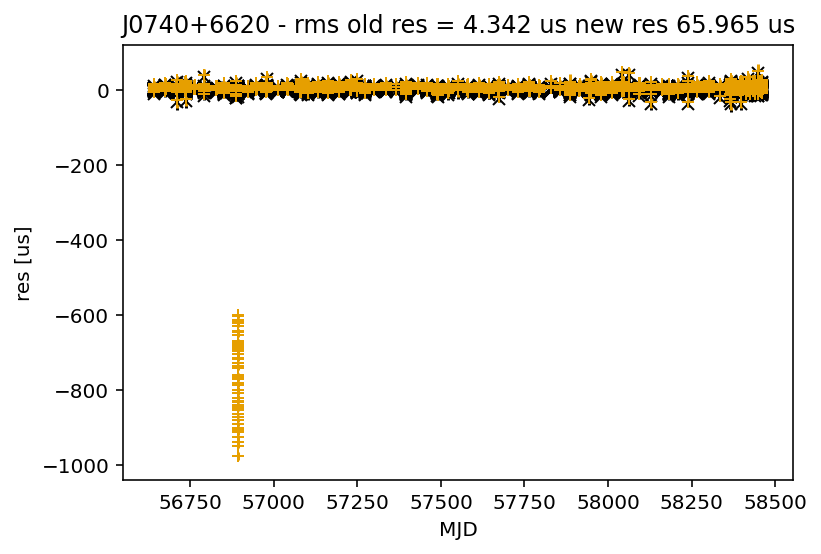

{'DMX_0009': 0.07852323079399999899}


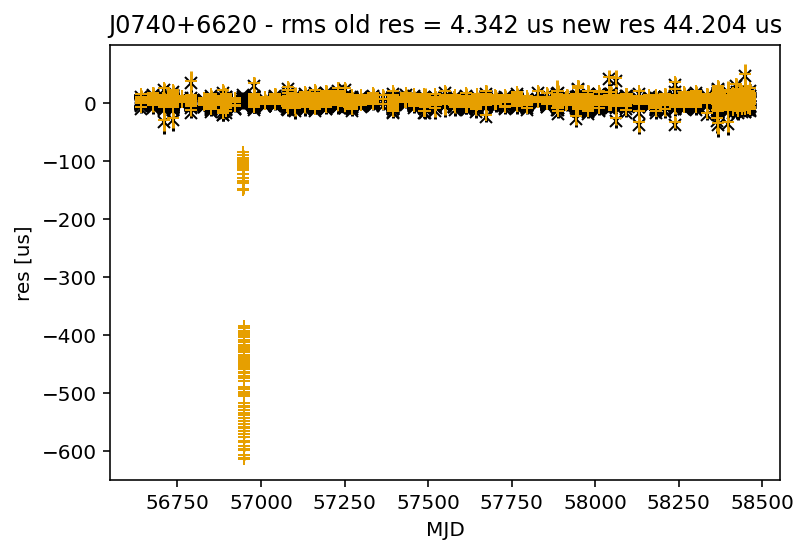

{'DMX_0010': 0.20718123127600000312}


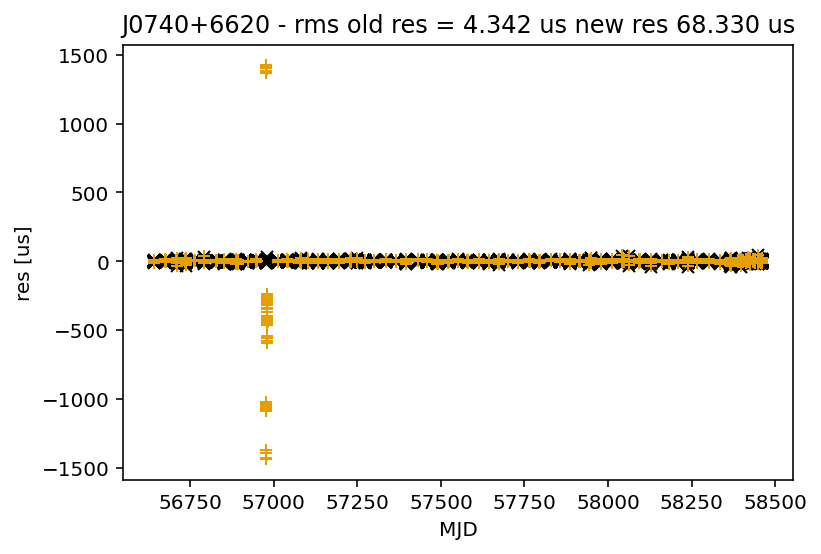

{'DMX_0011': 0.08323774810000000453}


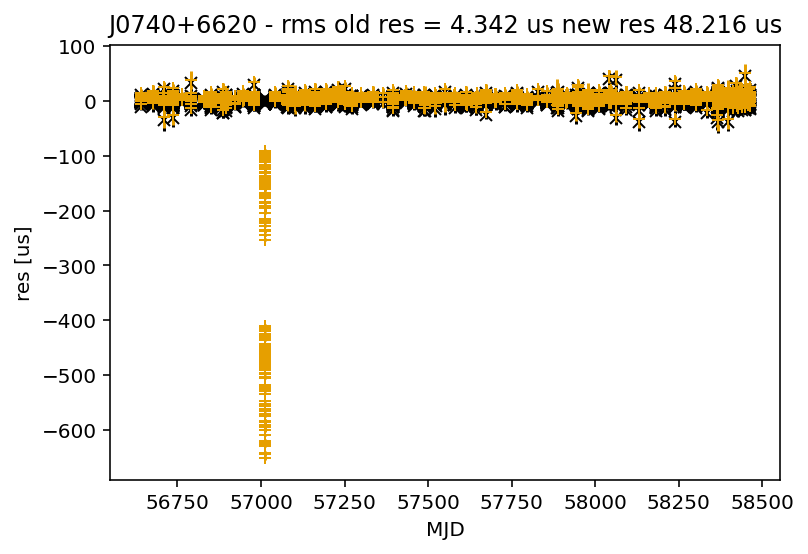

{'DMX_0012': 0.117787931923000002585}


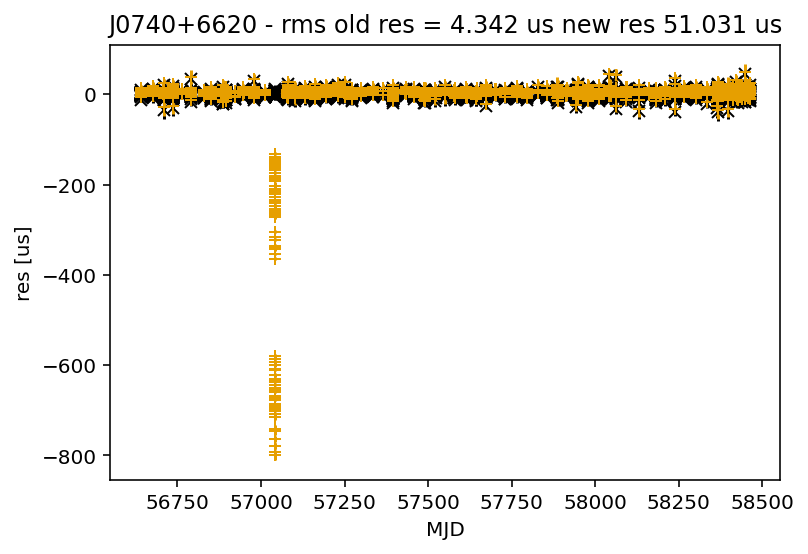

{'DMX_0013': 0.13714553241600001121}


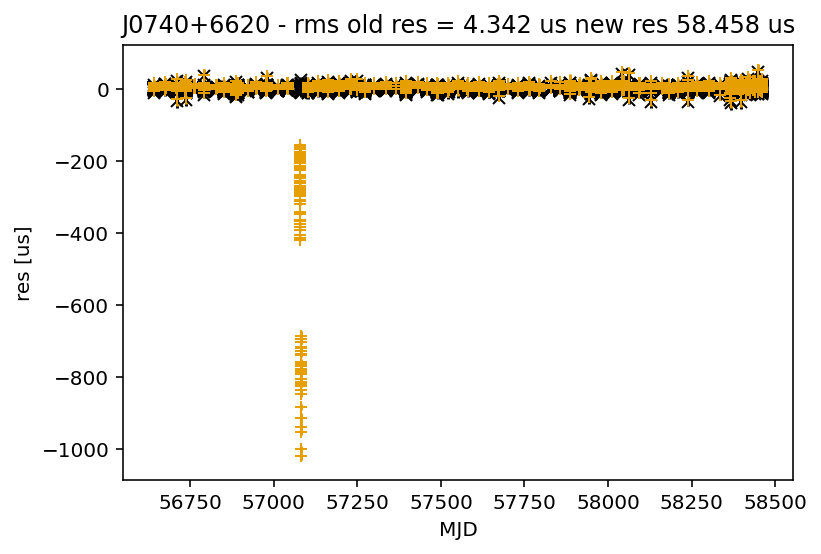

{'DMX_0014': 0.26216159137800002616}


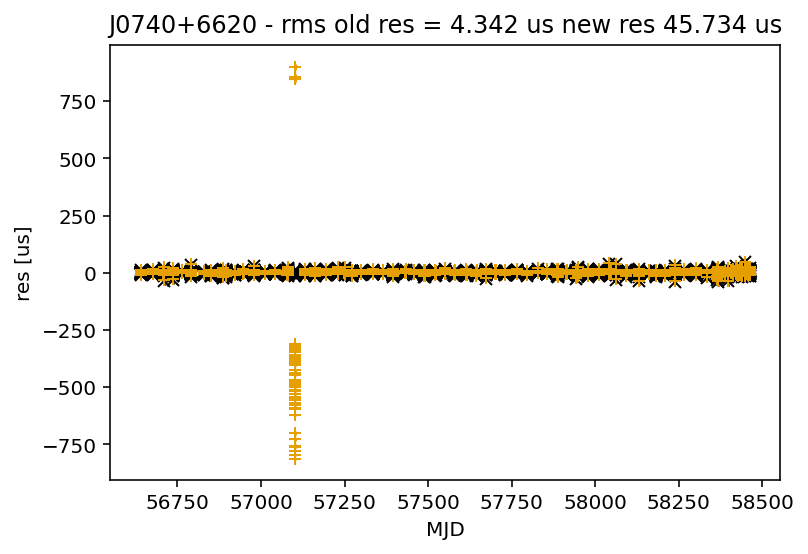

{'DMX_0015': 0.09448735265209999602}


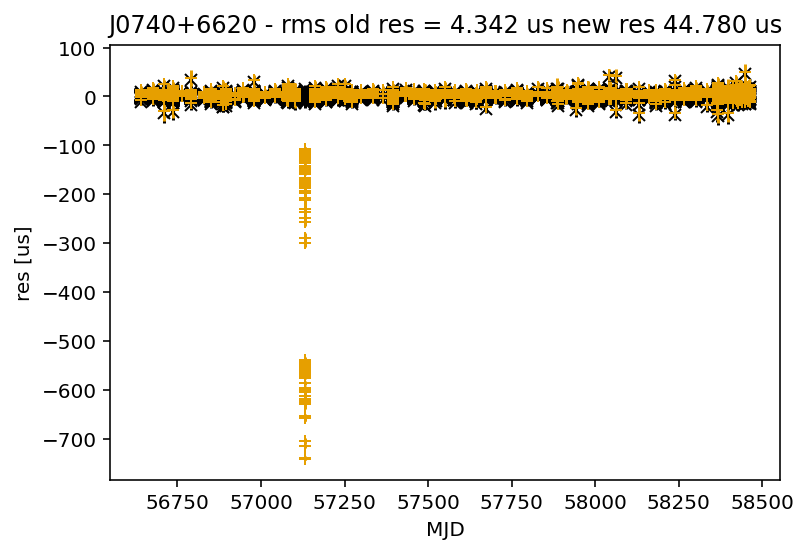

{'DMX_0016': 0.09771724971769999405}


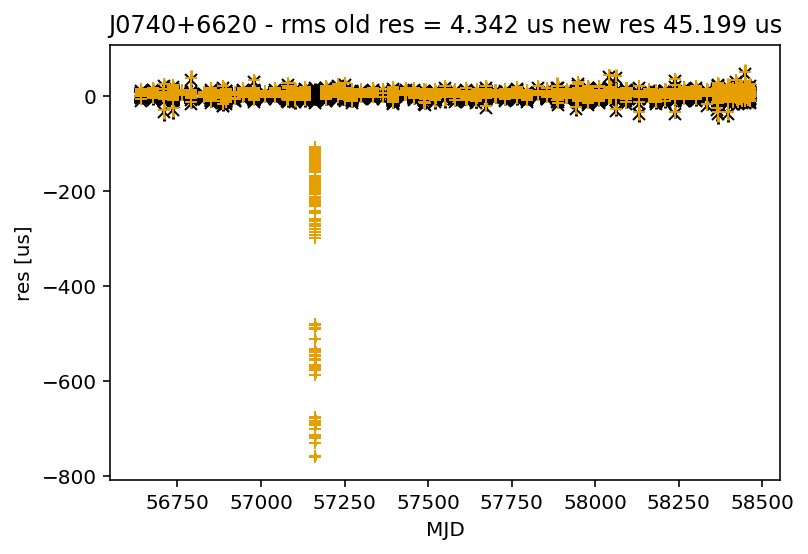

{'DMX_0017': 0.089849359377199996694}


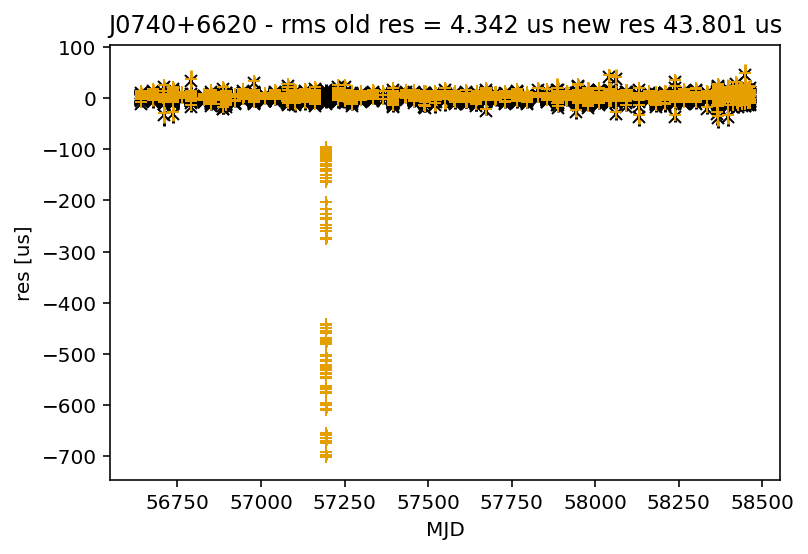

{'DMX_0018': 0.14039183263400000815}


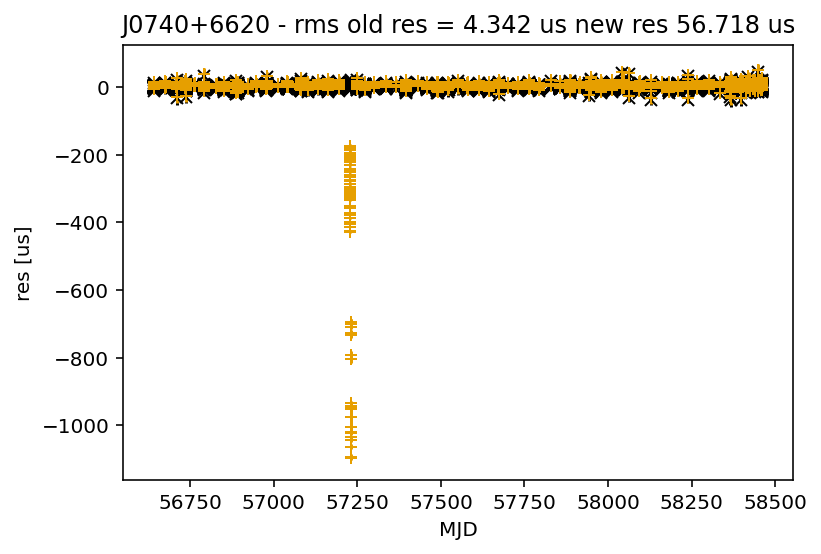

{'DMX_0019': 0.10837387425289999376}


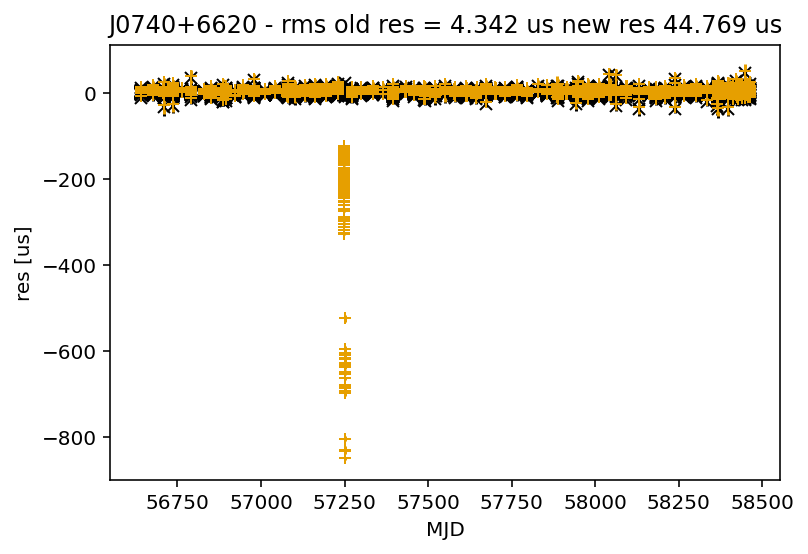

{'DMX_0020': 0.18378135232270000822}


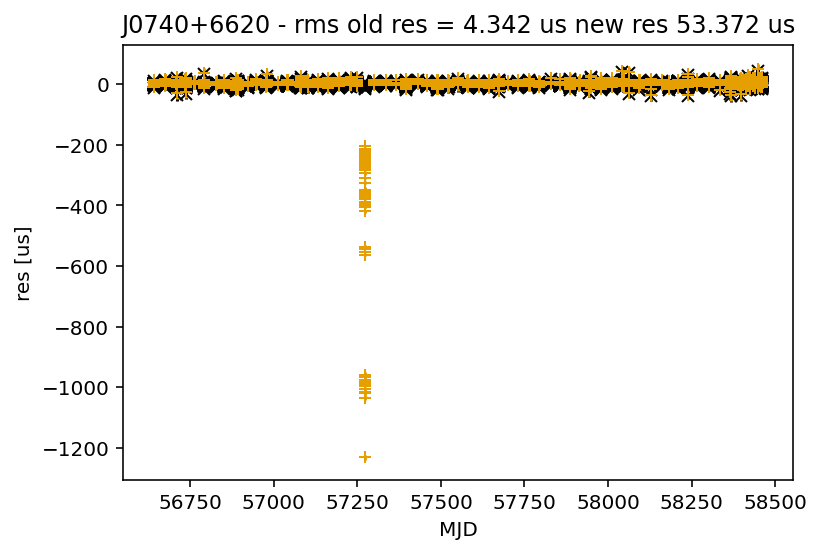

{'DMX_0021': 0.06745676729850000466}


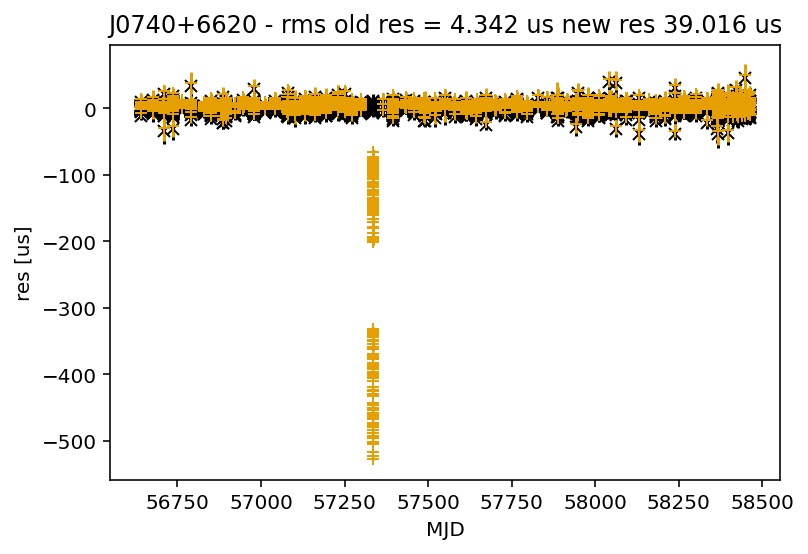

{'DMX_0022': 0.6944143160700000029}


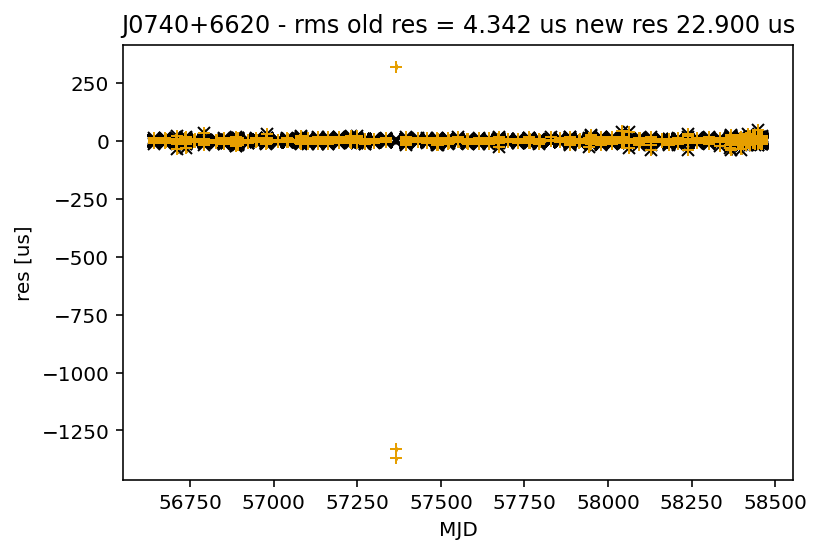

{'DMX_0023': 0.10478512309070000612}


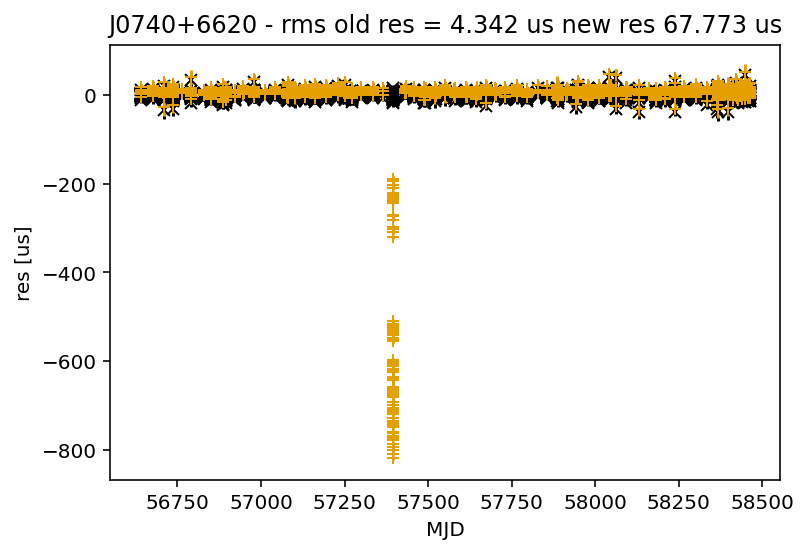

{'DMX_0024': 0.12035932369129999462}


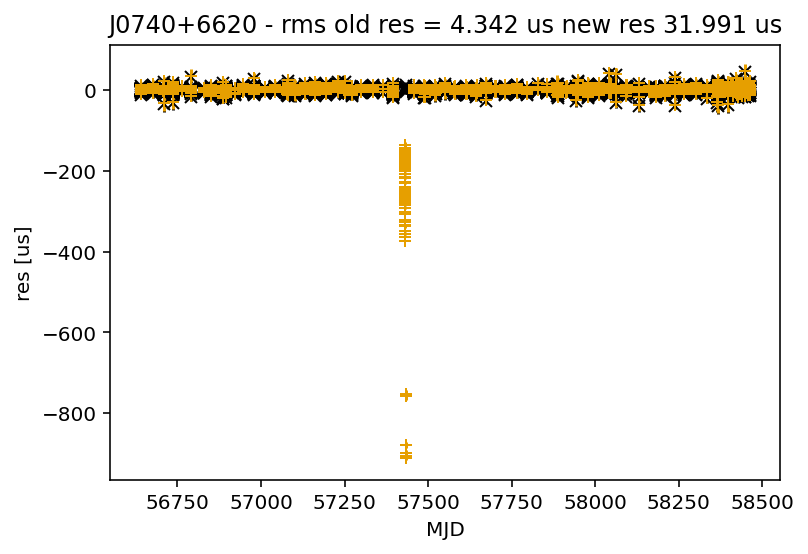

{'DMX_0025': 0.07961320903170000075}


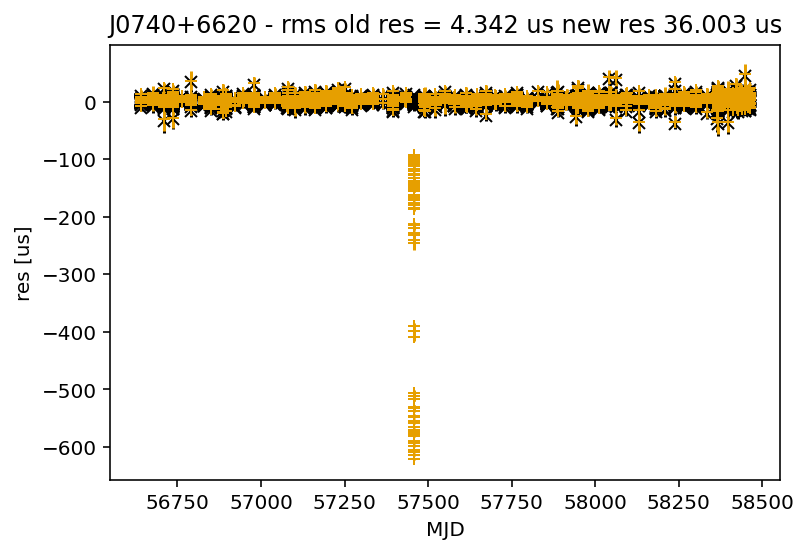

{'DMX_0026': 0.114175625238000002}


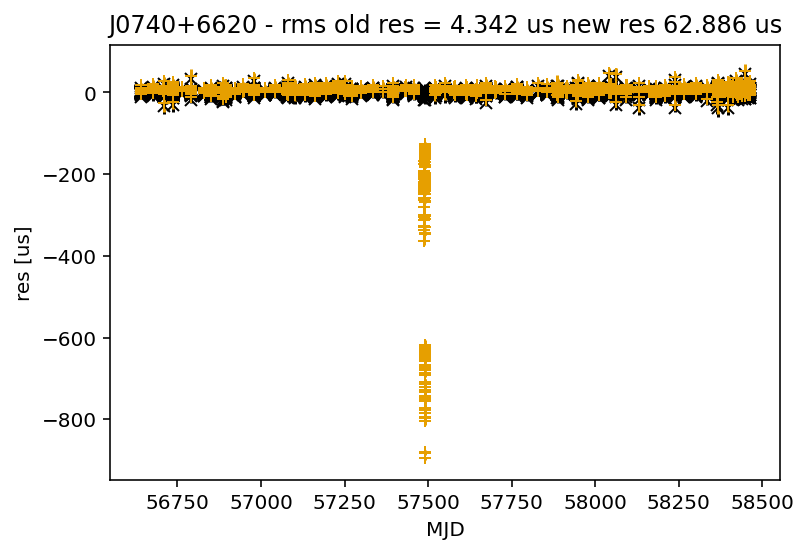

{'DMX_0027': 0.101644570184000004115}


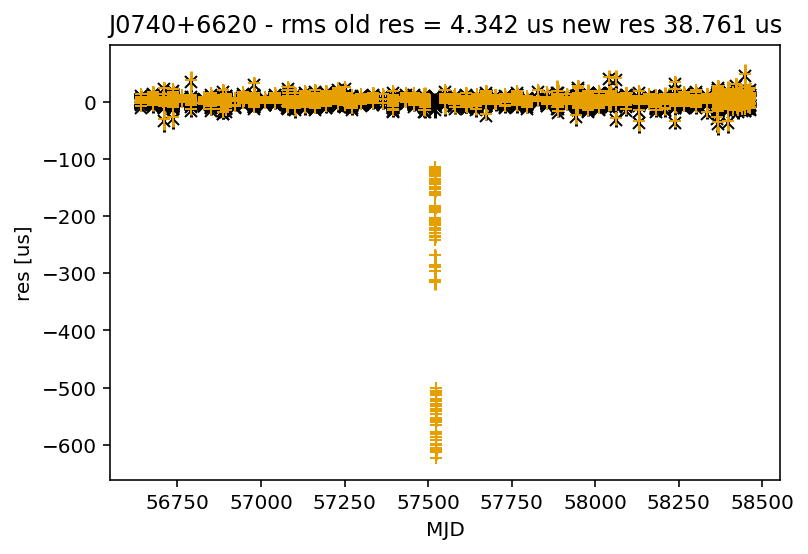

{'DMX_0028': 0.107694598195000000865}


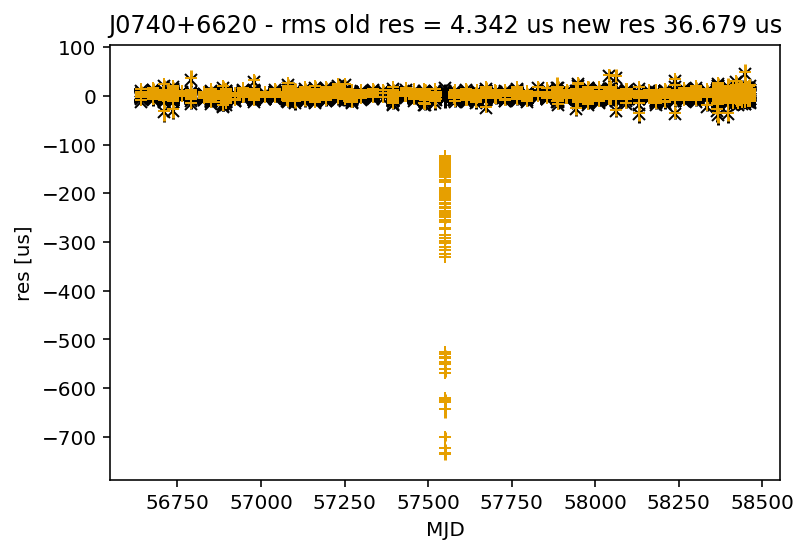

{'DMX_0029': 0.12144385990100000472}


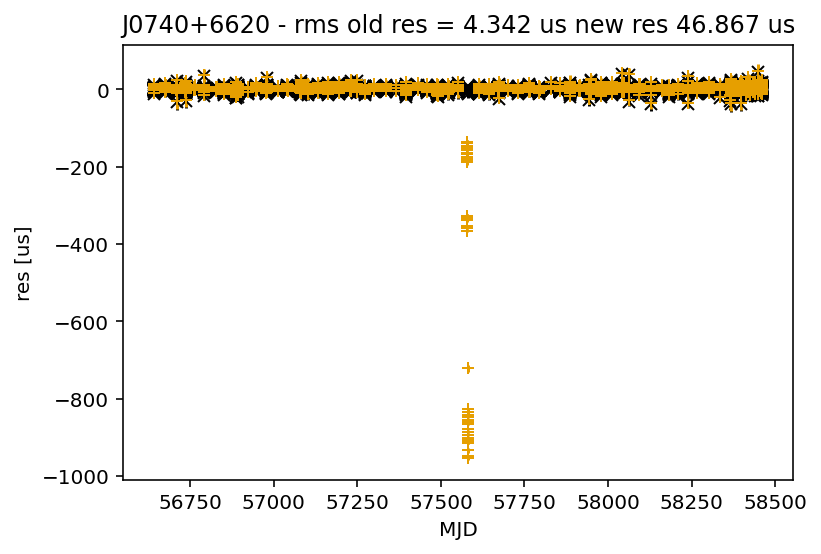

{'DMX_0030': 0.1039345176740000057}


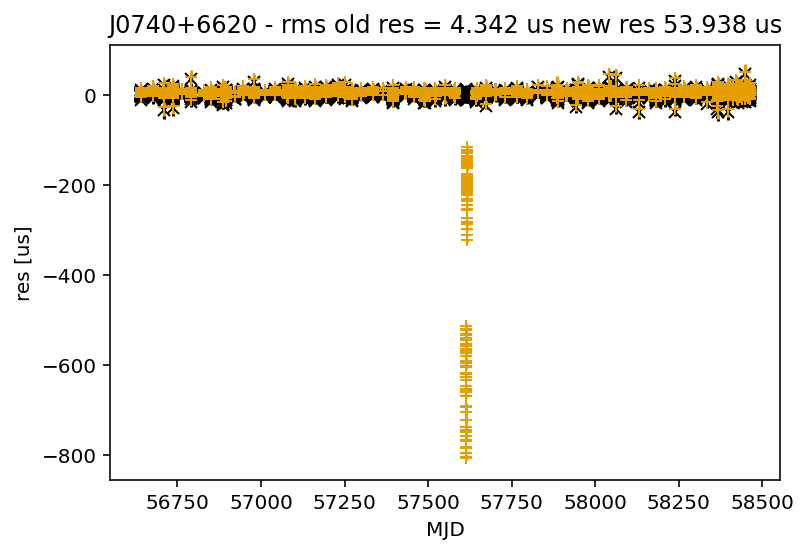

{'DMX_0031': 0.14372505110199998737}


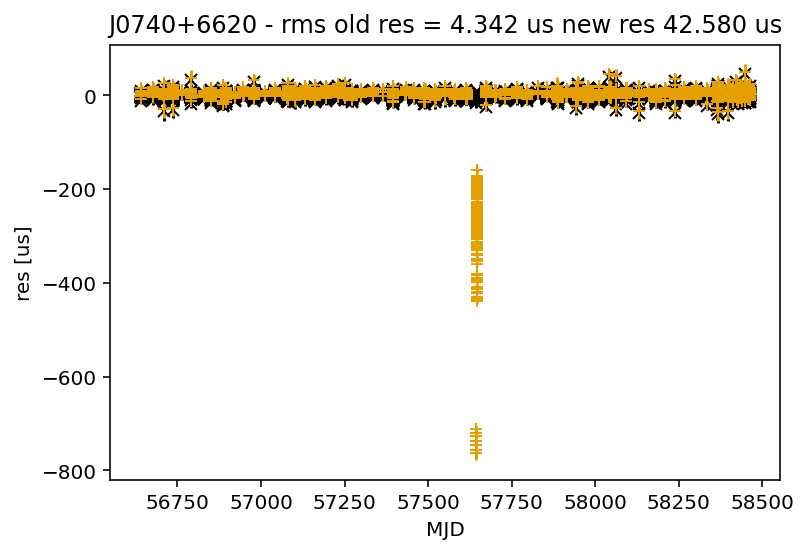

{'DMX_0032': 0.1266327686449999986}


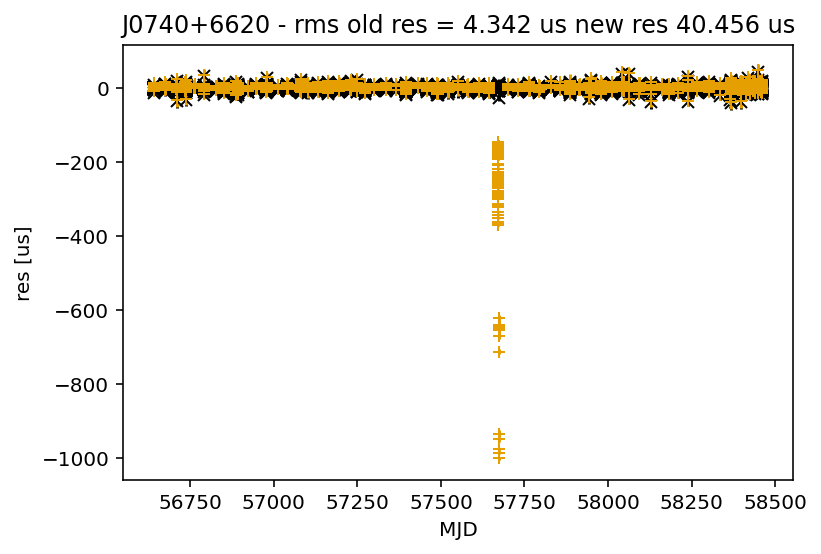

{'DMX_0033': 0.15833616161159998817}


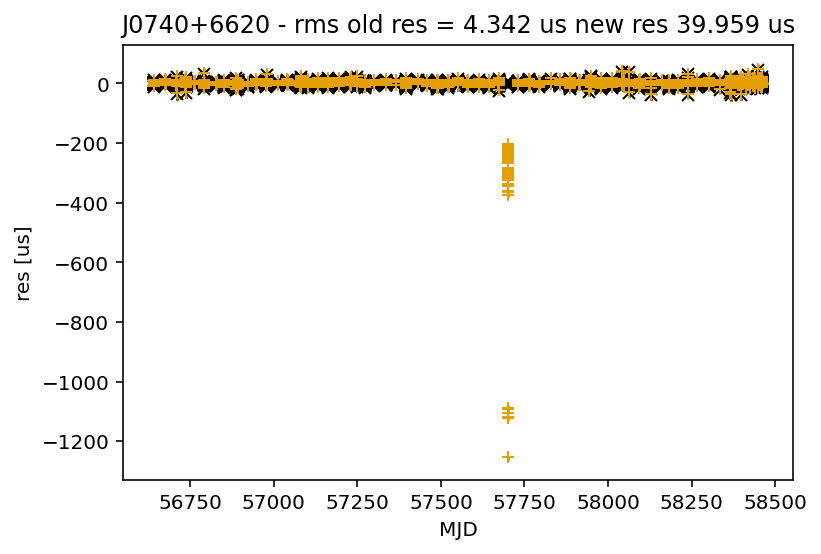

{'DMX_0034': 0.08884374819599999954}


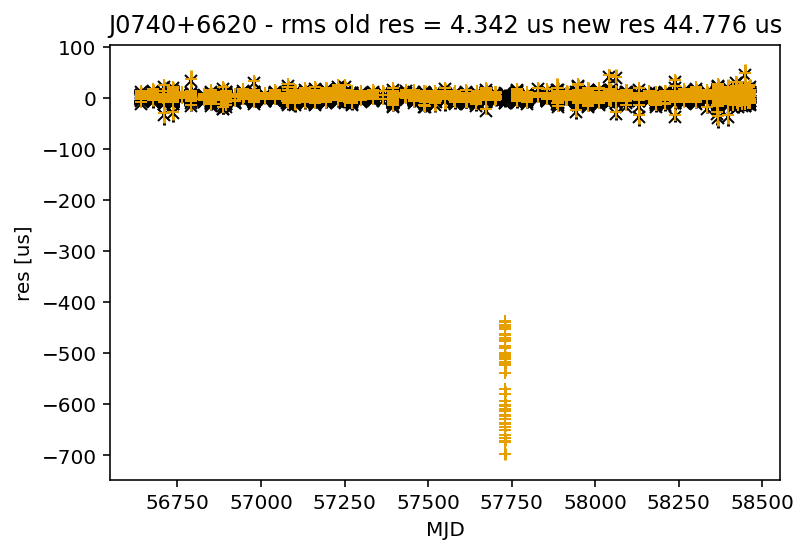

{'DMX_0035': 0.08314705793099999771}


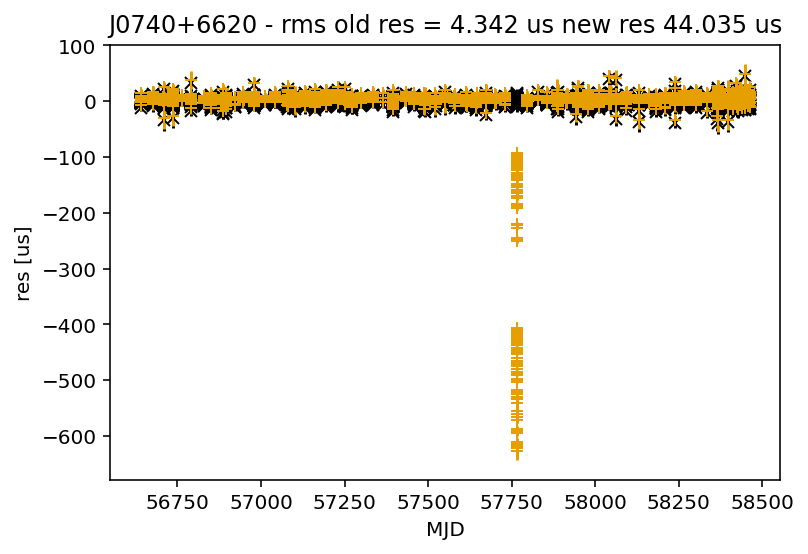

{'DMX_0036': 0.071099714857999996784}


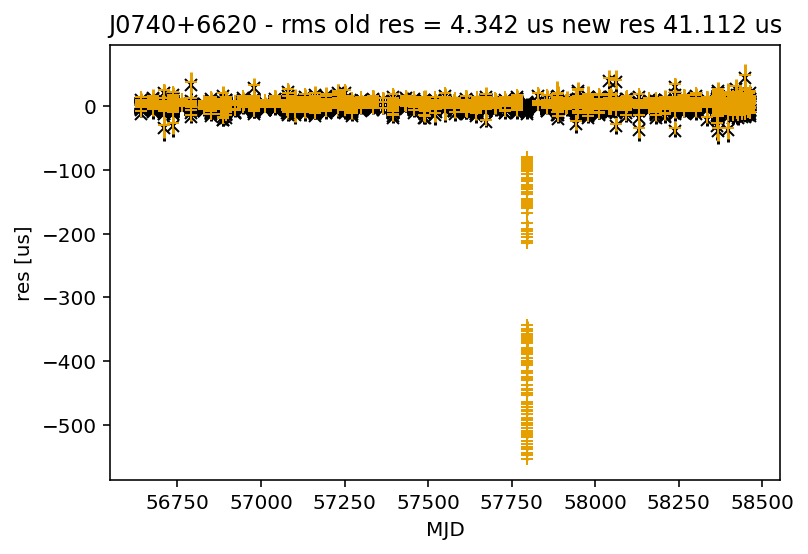

{'DMX_0037': 0.06681899274000000535}


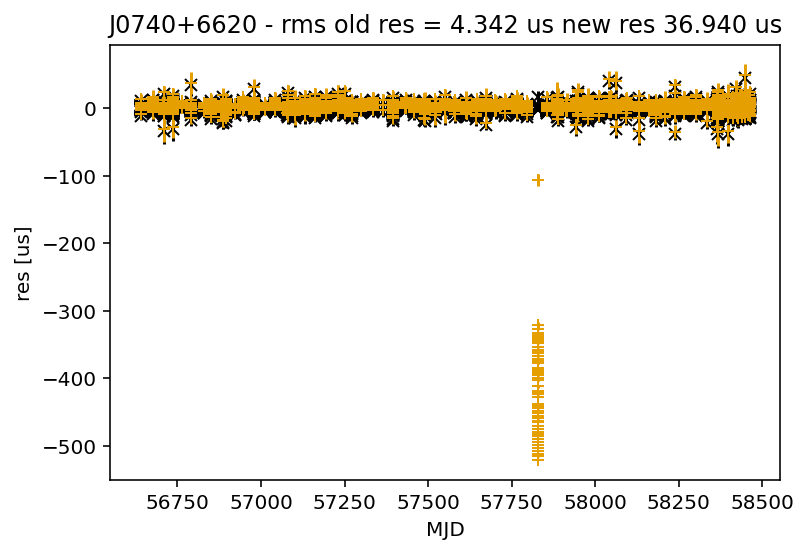

{'DMX_0038': 0.084903428285000006394}


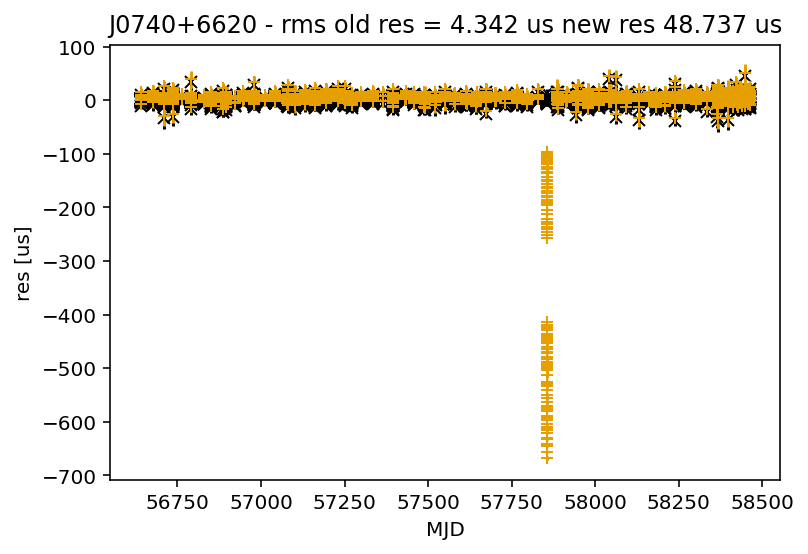

{'DMX_0039': 0.1366620034420000024}


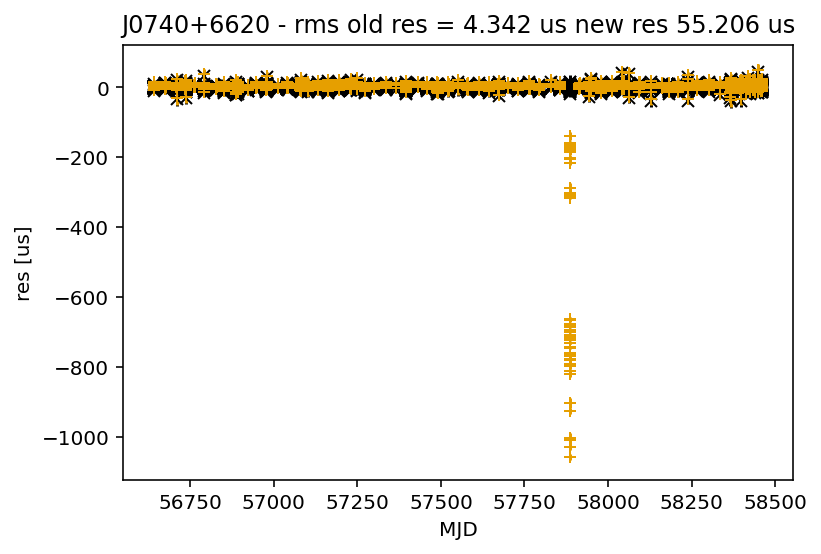

{'DMX_0040': 0.07497468250500000532}


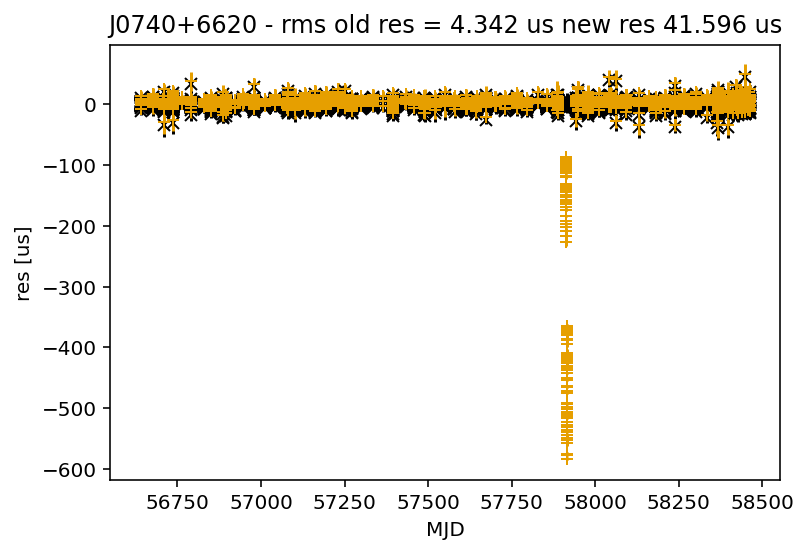

{'DMX_0041': 0.14375112822999999753}


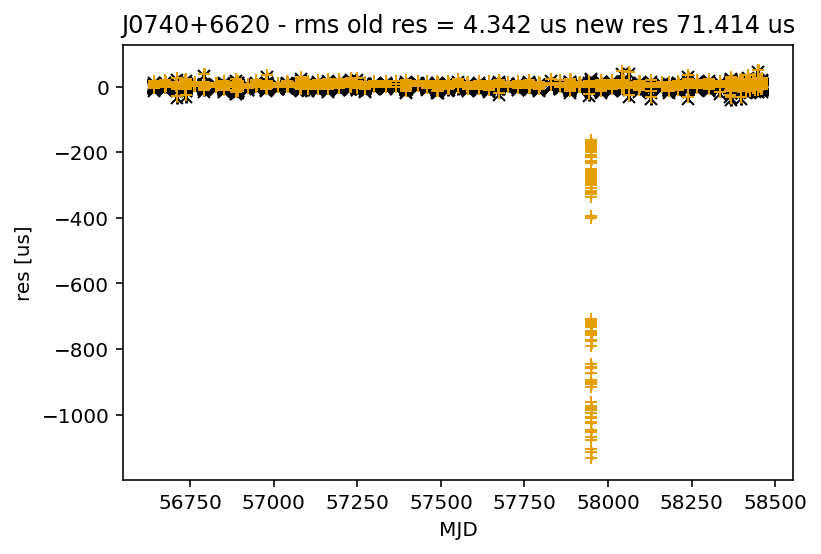

{'DMX_0042': 0.16492305270899999734}


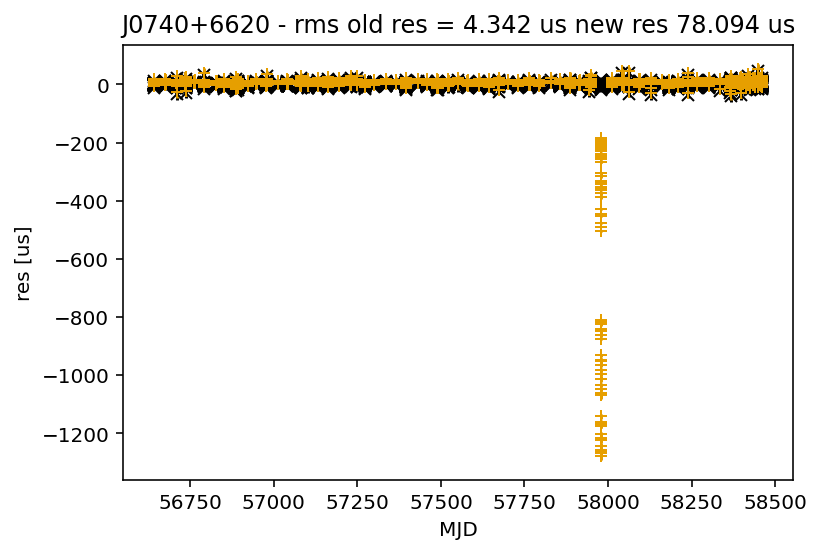

{'DMX_0043': 0.10400086882200000067}


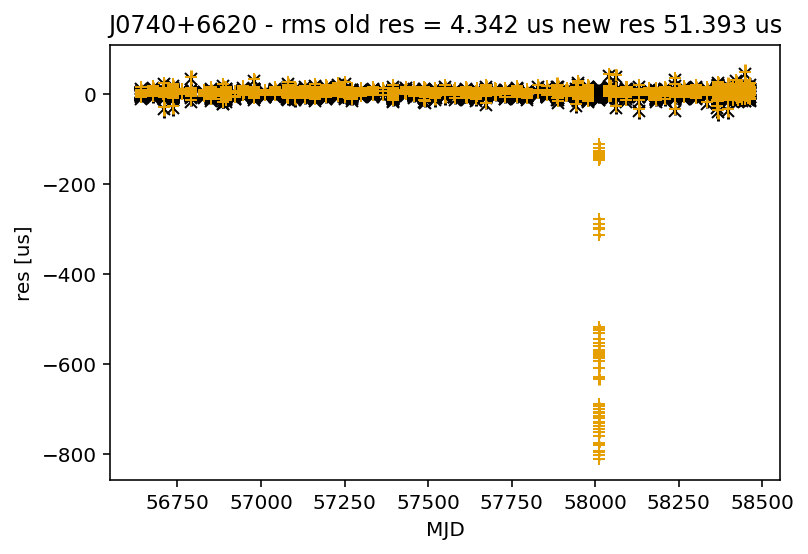

{'DMX_0044': 0.092870930458999994854}


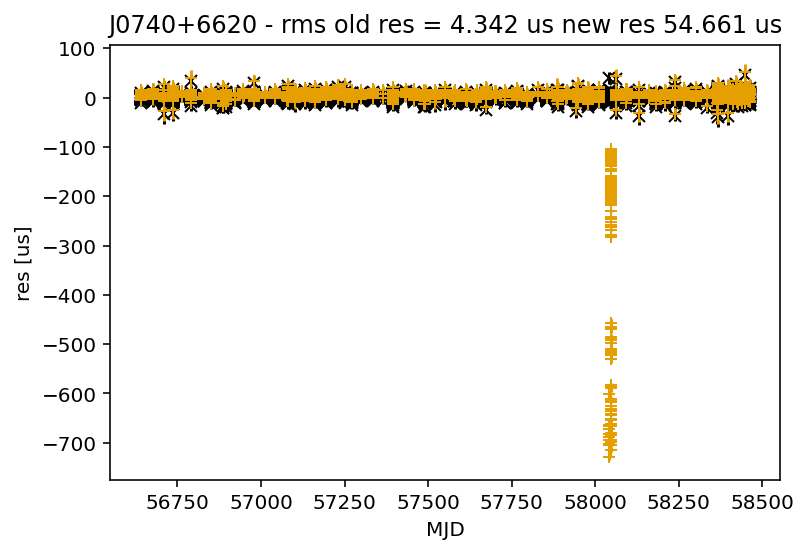

{'DMX_0045': 0.13893678932499998934}


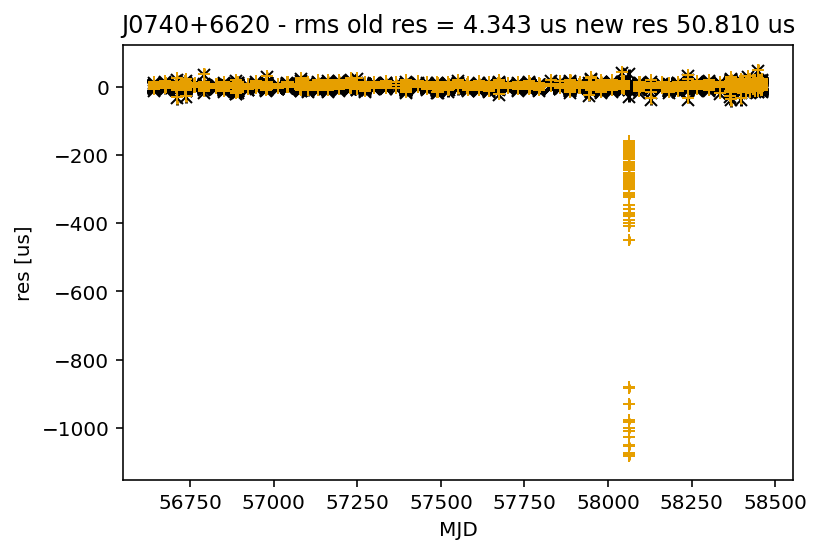

{'DMX_0046': 0.075247133232000004544}


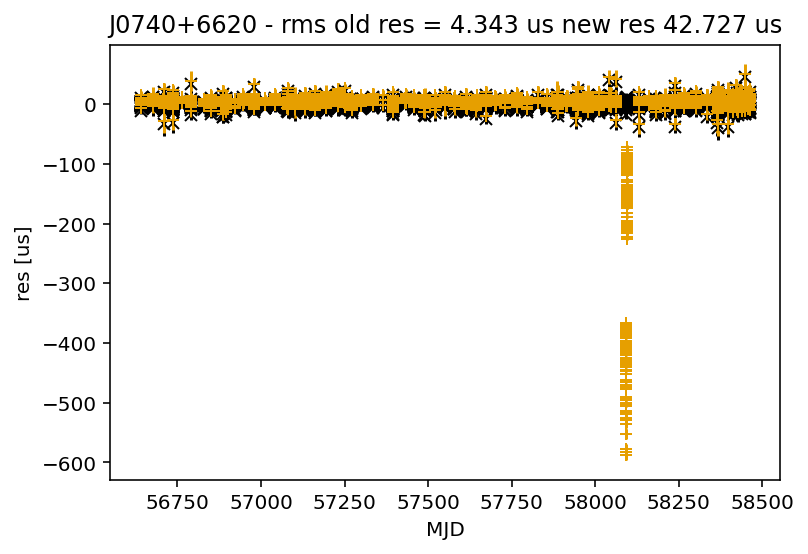

{'DMX_0047': 0.24010263836599998926}


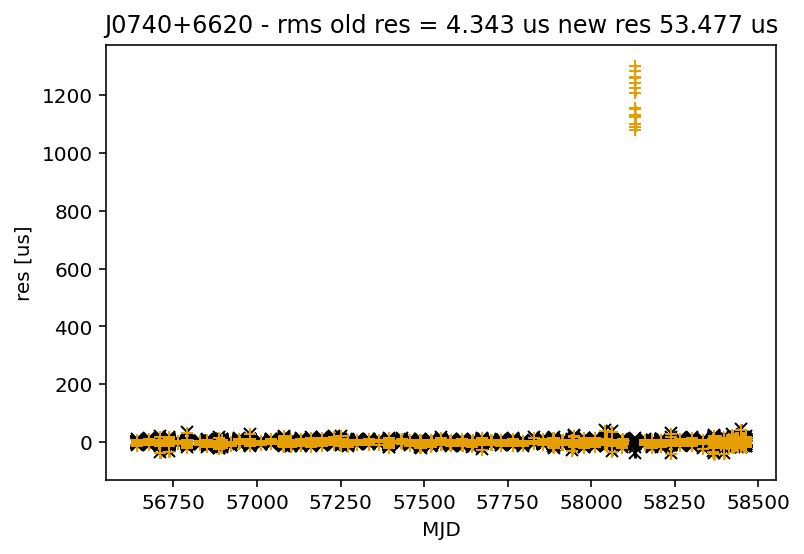

{'DMX_0048': 0.07058863526400000027}


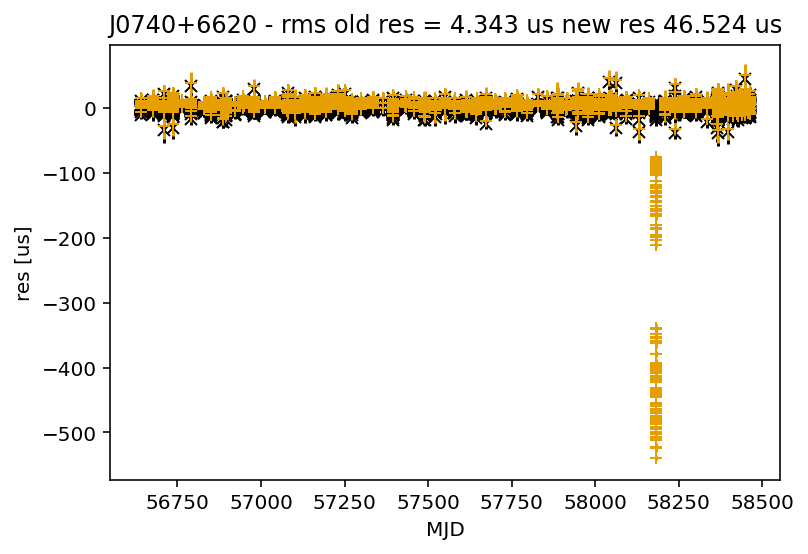

{'DMX_0049': 0.09446207080000000219}


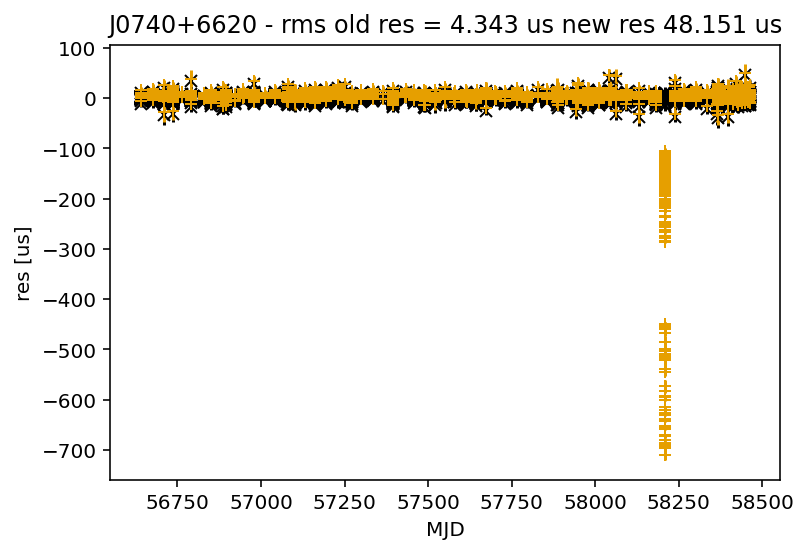

{'DMX_0050': 0.18504025661000000716}


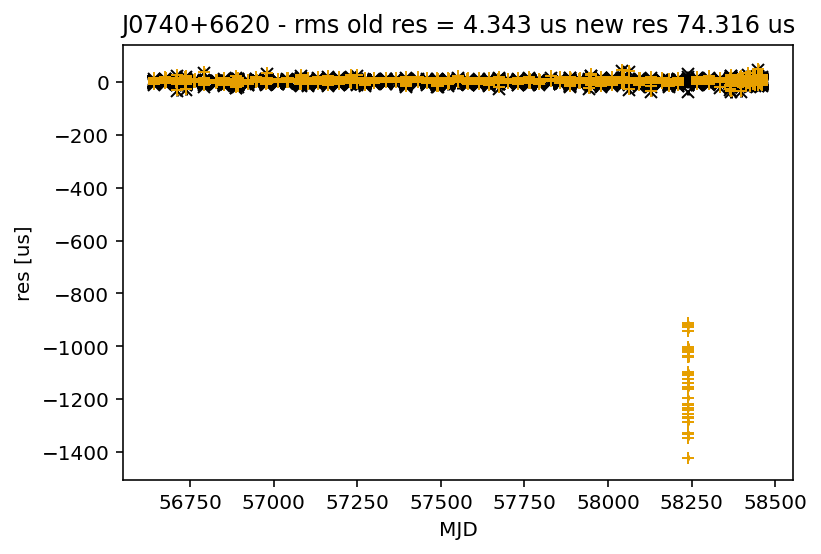

{'DMX_0051': 0.10071810555000000009}


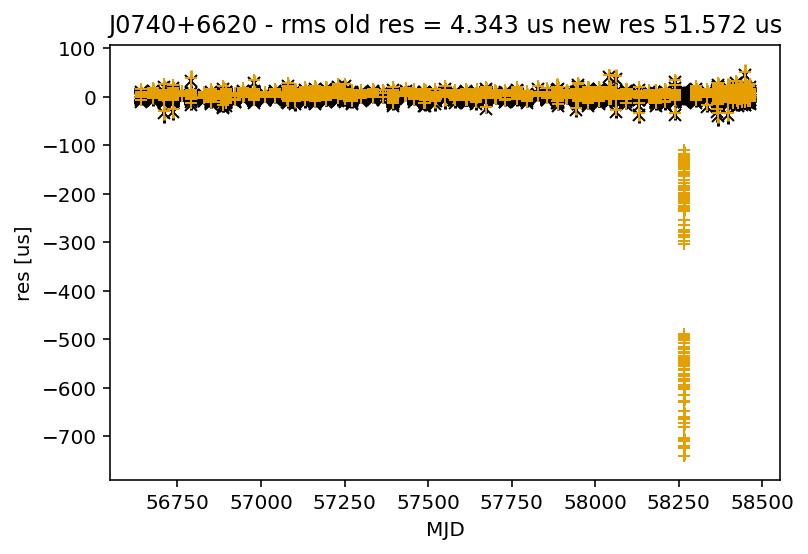

{'DMX_0052': 0.15444513429000000826}


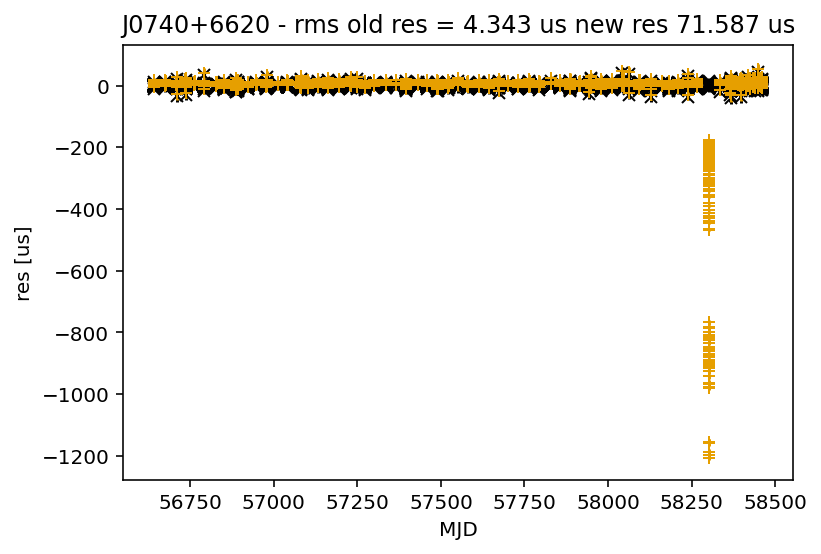

{'DMX_0053': 0.24113965487899999222}


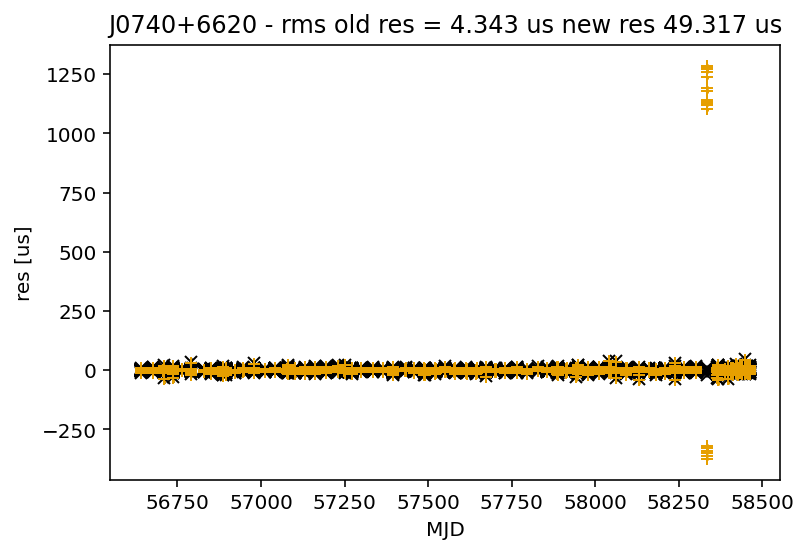

{'DMX_0054': 0.07658151442999999941}


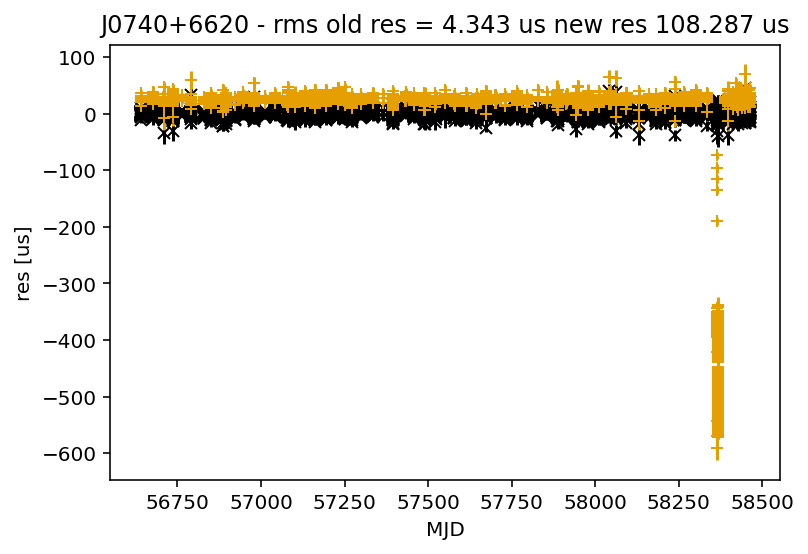

{'DMX_0055': 0.083129521650000003076}


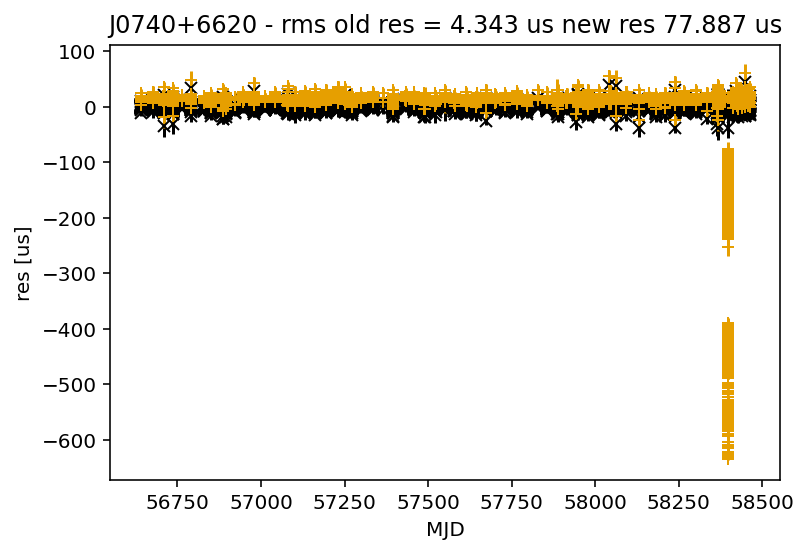

{'DMX_0056': 0.075151403119999995105}


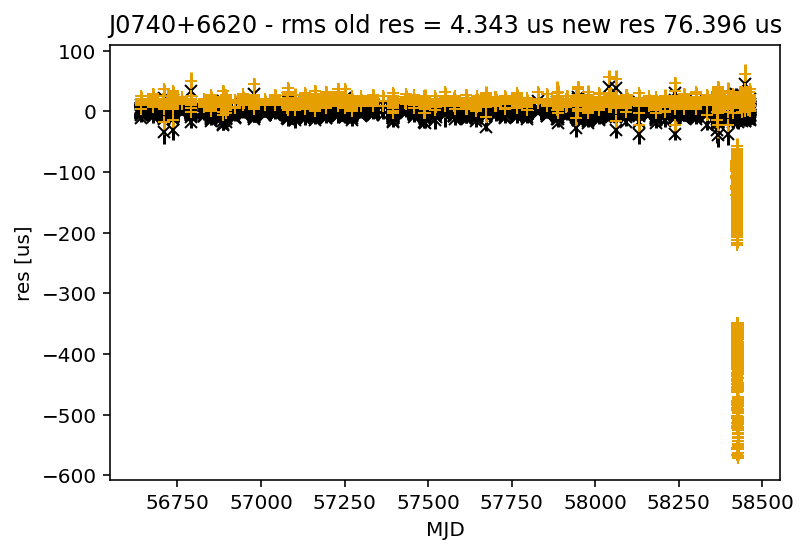

{'DMX_0057': 0.07700380787999999603}


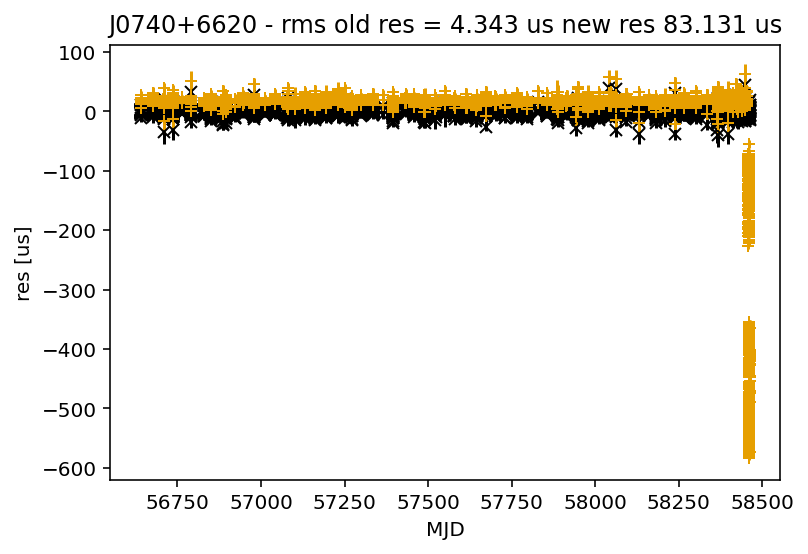

{'DMX_0058': 0.19907322648300001203}


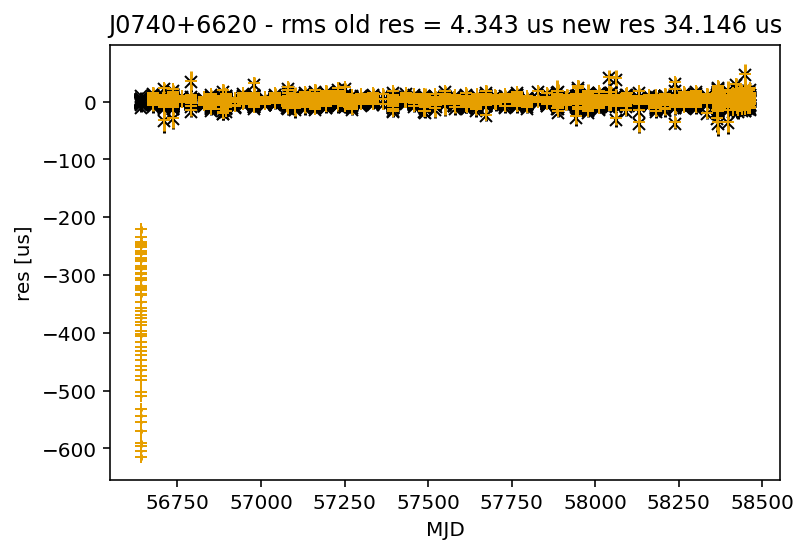

{'DMX_0059': 0.20011042798400001139}


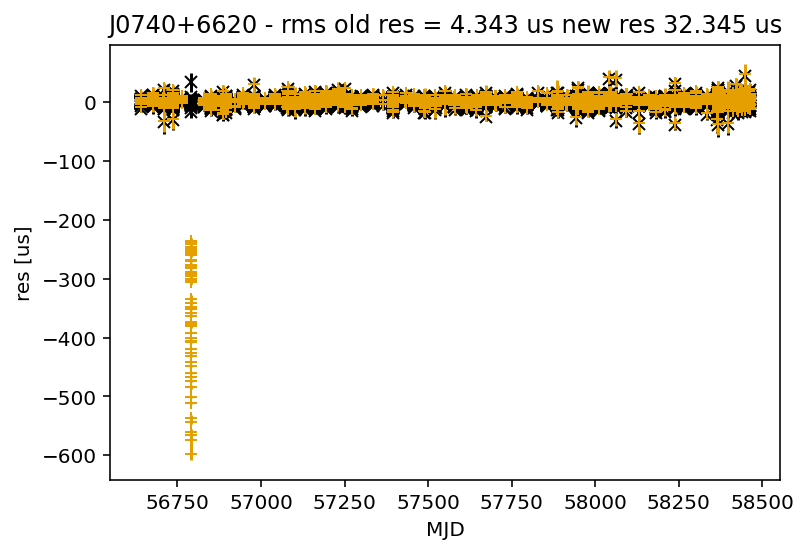

{'DMX_0060': 0.20024330370799998725}


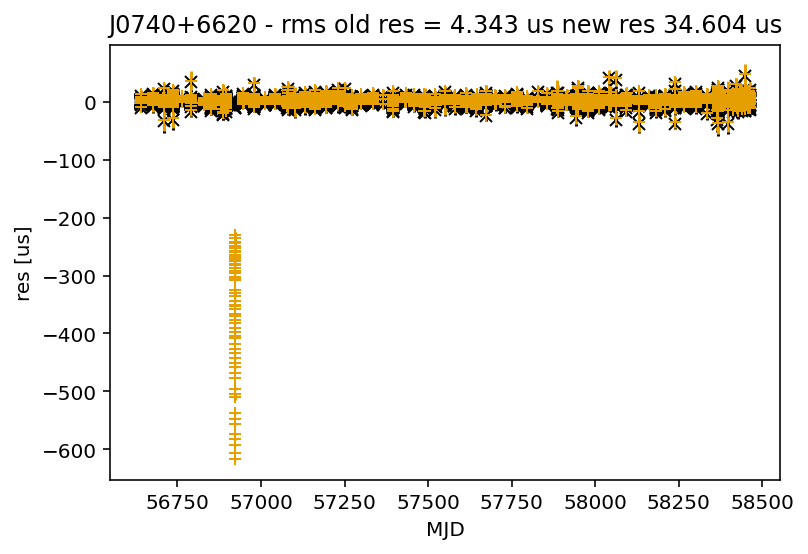

{'DMX_0061': 0.14755425967519999538}


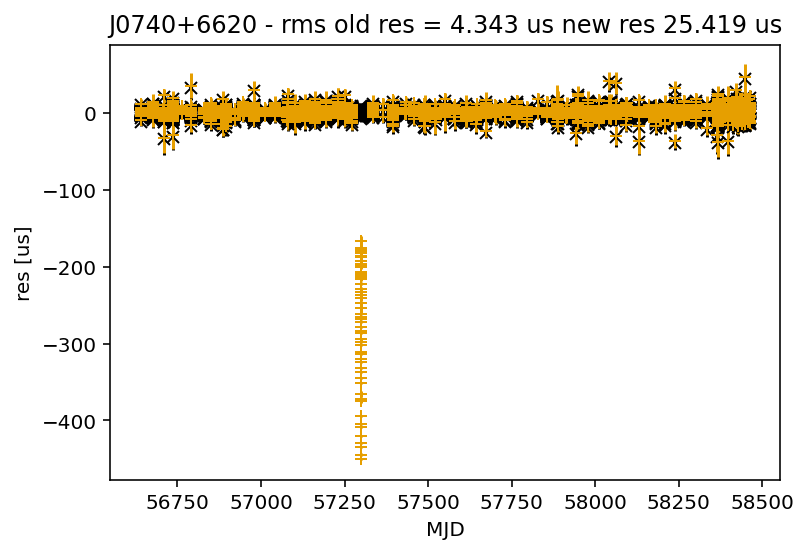

{'DMX_0062': 0.22081573289400000873}


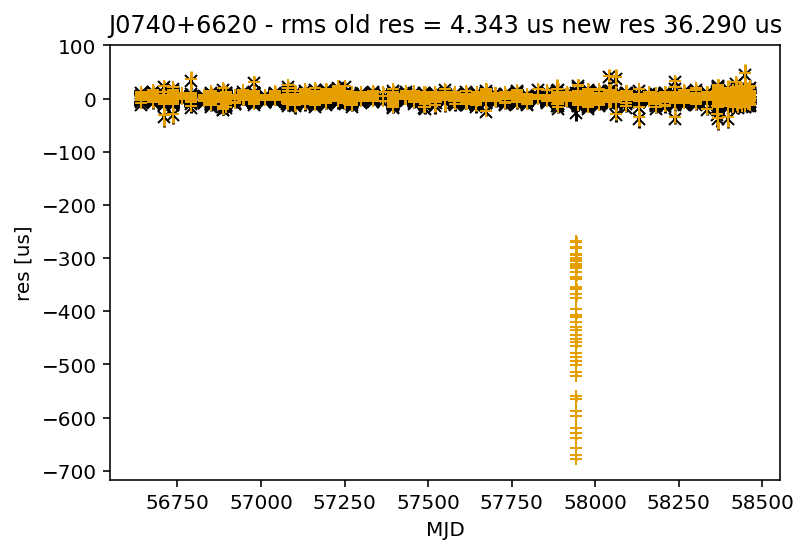

{'DMX_0063': 0.18461014952999999965}


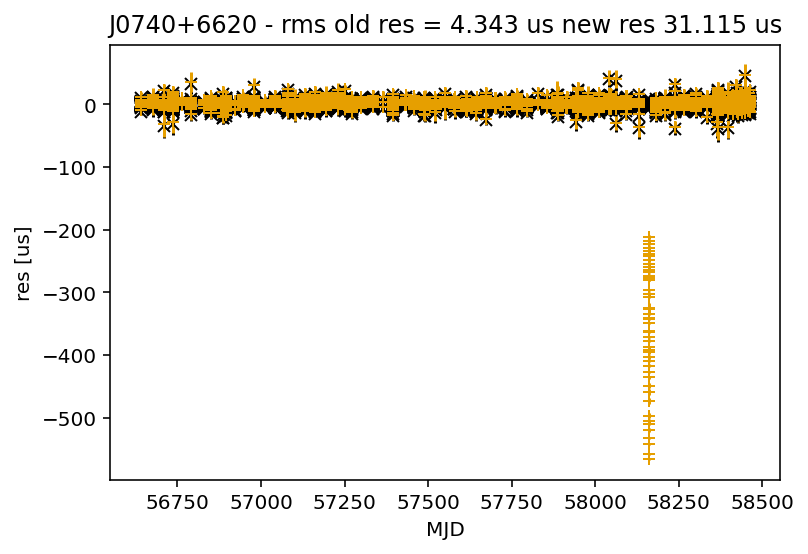

{'DMX_0064': 0.1677182906700000102}


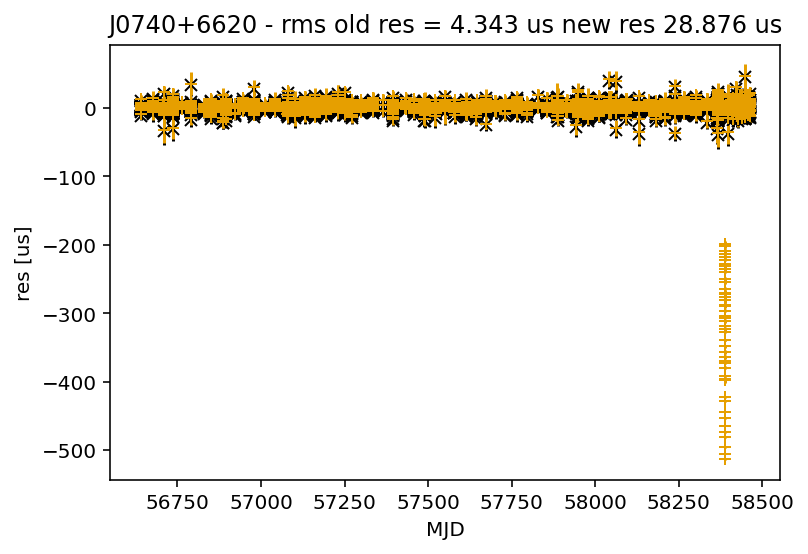

{'DMX_0065': 0.15873780189000001255}


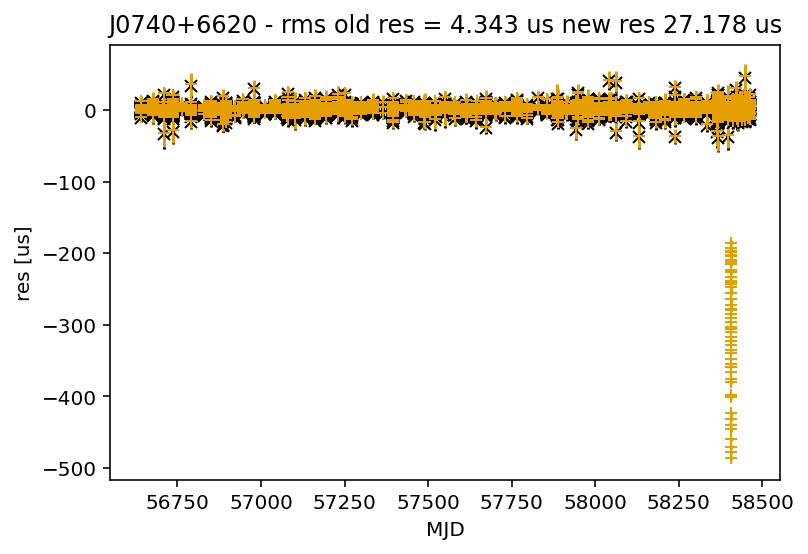

{'DMX_0066': 0.29082517642999998627}


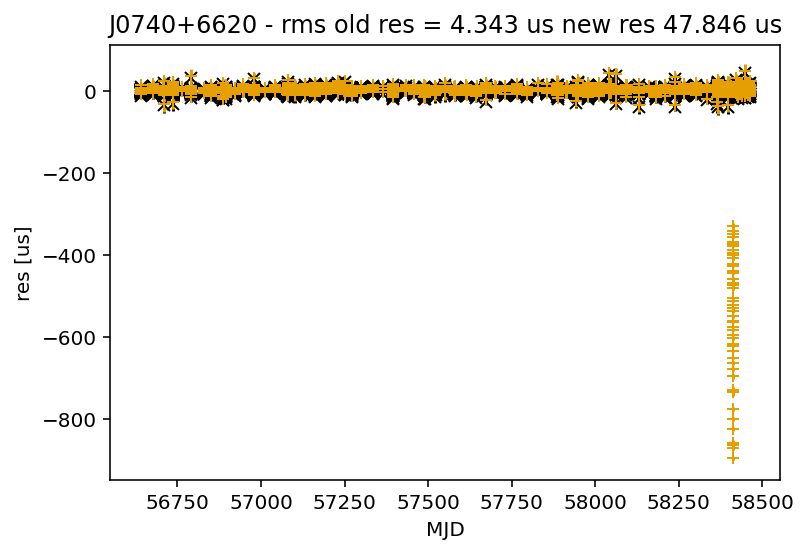

{'DMX_0067': 0.24500926537400000365}


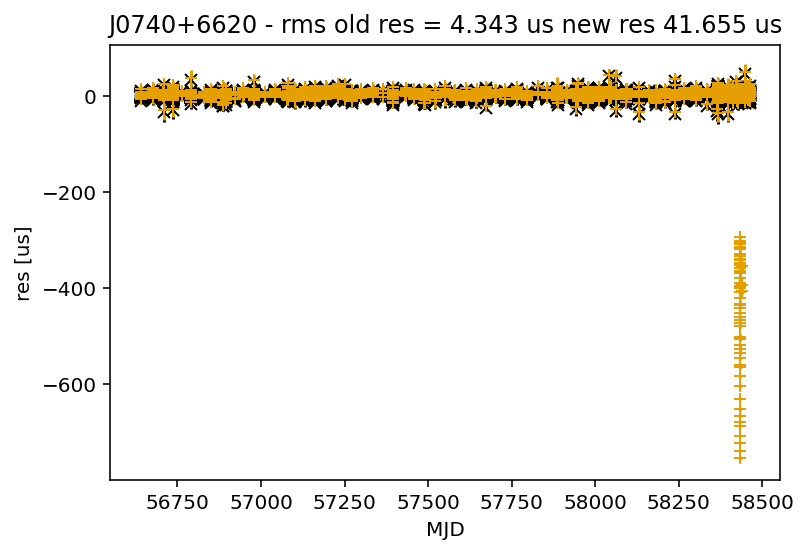

{'DMX_0068': 0.10078111836000000316}


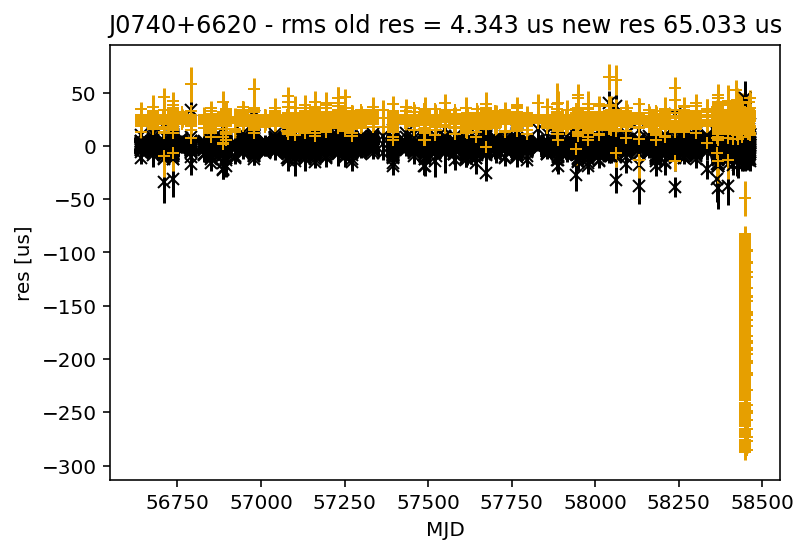

{'JUMP1': -0.001061087329393049319}


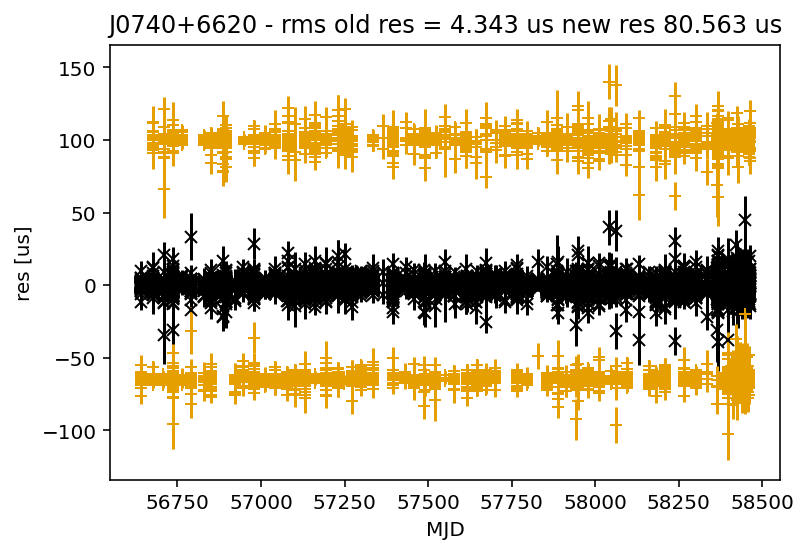

In [16]:

value = 1000.
for par in psr.t2pulsar.pars():
    tm_delay_kwargs = {par:value}
    tm_delay(psr.t2pulsar,tm_params_orig,**tm_delay_kwargs);
    plt.show()


# Loading runs for MLVs

In [17]:
psr_dir = current_path + f'/{psr_name}/chains/'
chaindir_cfr19_DE436_noRN_varyWN_COSI_1 = psr_dir+f'cfr+19/{psr_name}_uniform_DE436_nltm_ltm_noRN_varyWN_COSI_1'
chaindir_cfr19_DE436_noRN_varyWN_lin_DMX_JUMP_FD_COSI_1 = psr_dir+f'cfr+19/{psr_name}_uniform_DE436_nltm_ltm_noRN_varyWN_lin_DMX_JUMP_FD_COSI_1'
chaindir_cfr19_DE436_varyRN_varyWN_COSI_1 = psr_dir+f'cfr+19/{psr_name}_uniform_DE436_nltm_ltm_varyRN_varyWN_COSI_1'

chaindir_spruce_core_4_cfr19 = psr_dir+f'cfr+19/{psr_name}_uniform_DE436_nltm_ltm_4_core_cfr19_1/'
chaindir_spruce_core_4_cfr19_no_RN_const_WN = psr_dir+f'cfr+19/{psr_name}_uniform_DE436_nltm_ltm_4_core_cfr19_no_rn_const_wn_1/'
burn=None

burn=None
core_cfr19_DE436_noRN_varyWN_COSI_1 = TimingCore('_'.join(chaindir_cfr19_DE436_noRN_varyWN_COSI_1.split('/')[-2:]),
                              chaindir=chaindir_cfr19_DE436_noRN_varyWN_COSI_1,
                              tm_pars_path=chaindir_cfr19_DE436_noRN_varyWN_COSI_1+'/orig_timing_pars.pkl',
                              burn=burn)
core_cfr19_DE436_noRN_varyWN_lin_DMX_JUMP_FD_COSI_1 = TimingCore('_'.join(chaindir_cfr19_DE436_noRN_varyWN_lin_DMX_JUMP_FD_COSI_1.split('/')[-2:]),
                              chaindir=chaindir_cfr19_DE436_noRN_varyWN_lin_DMX_JUMP_FD_COSI_1,
                              tm_pars_path=chaindir_cfr19_DE436_noRN_varyWN_lin_DMX_JUMP_FD_COSI_1+'/orig_timing_pars.pkl',
                              burn=burn)
core_cfr19_DE436_varyRN_varyWN_COSI_1 = TimingCore('_'.join(chaindir_cfr19_DE436_varyRN_varyWN_COSI_1.split('/')[-2:]),
                              chaindir=chaindir_cfr19_DE436_varyRN_varyWN_COSI_1,
                              tm_pars_path=chaindir_cfr19_DE436_varyRN_varyWN_COSI_1+'/orig_timing_pars.pkl',
                              burn=burn)
"""
spruce_core_4_cfr19 = TimingCore('_'.join(chaindir_spruce_core_4_cfr19.split('/')[-2:]),
                              chaindir=chaindir_spruce_core_4_cfr19,
                              tm_pars_path=chaindir_spruce_core_4_cfr19+'/orig_timing_pars.pkl',
                              burn=burn)
spruce_core_4_cfr19_no_RN_const_WN = TimingCore('_'.join(chaindir_spruce_core_4_cfr19_no_RN_const_WN.split('/')[-2:]),
                              chaindir=chaindir_spruce_core_4_cfr19_no_RN_const_WN,
                              tm_pars_path=chaindir_spruce_core_4_cfr19_no_RN_const_WN+'/orig_timing_pars.pkl',
                              burn=burn)
"""

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 114575
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.
Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 118200
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.
Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 119100
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.


"\nspruce_core_4_cfr19 = TimingCore('_'.join(chaindir_spruce_core_4_cfr19.split('/')[-2:]),\n                              chaindir=chaindir_spruce_core_4_cfr19,\n                              tm_pars_path=chaindir_spruce_core_4_cfr19+'/orig_timing_pars.pkl',\n                              burn=burn)\nspruce_core_4_cfr19_no_RN_const_WN = TimingCore('_'.join(chaindir_spruce_core_4_cfr19_no_RN_const_WN.split('/')[-2:]),\n                              chaindir=chaindir_spruce_core_4_cfr19_no_RN_const_WN,\n                              tm_pars_path=chaindir_spruce_core_4_cfr19_no_RN_const_WN+'/orig_timing_pars.pkl',\n                              burn=burn)\n"

In [18]:
core_list_cfr19 = [core_cfr19_DE436_noRN_varyWN_COSI_1,
                  core_cfr19_DE436_noRN_varyWN_lin_DMX_JUMP_FD_COSI_1,
                  core_cfr19_DE436_varyRN_varyWN_COSI_1]
core_list_legend_cfr19 = ['Cromartie et al. (2020) Data: No RN, Varied WN',
                          'Cromartie et al. (2020) Data: No RN, Varied WN Linearly Varied DMX,JUMP,FD',
                          'Cromartie et al. (2020) Data: Varied RN, Varied WN']

In [19]:
def get_titles(core):
    titles = []
    for core_param in core.params:
        if 'timing' in core_param.split('_'):
            if 'DMX' in core_param.split('_'):
                titles.append(('_').join(core_param.split('_')[-2:]))
            else:
                titles.append(core_param.split('_')[-1])
        else:
            if psr_name in core_param.split('_'):
                titles.append((' ').join(core_param.split('_')[1:]))
            else:
                titles.append(core_param)
    """
    else:
        unparams=['lnpost','lnlike','chain_accept','pt_chain_accept']
        for com_par in params:
            if (
                com_par
                not in core.params
            ):
                unparams.append(com_par)
        for ncom_par in unparams:
            if ncom_par in params:
                del titles[params.index(ncom_par)]
                del params[
                    params.index(ncom_par)
                ]
    """
    return titles

In [20]:
def get_common_params_titles(core_list,exclude=True):
    common_params = []
    common_titles = []
    for core in core_list:
        if len(common_params) == 0:
            for core_param in core.params:
                common_params.append(core_param)
                if 'timing' in core_param.split('_'):
                    if 'DMX' in core_param.split('_'):
                        common_titles.append(('_').join(core_param.split('_')[-2:]))
                    else:
                        common_titles.append(core_param.split('_')[-1])
                else:
                    if psr_name in core_param.split('_'):
                        common_titles.append((' ').join(core_param.split('_')[1:]))
                    else:
                        common_titles.append(core_param)
        else:
            if exclude:
                uncommon_params=['lnpost','lnlike','chain_accept','pt_chain_accept']
            else:
                uncommon_params=['chain_accept','pt_chain_accept']
            
            for com_par in common_params:
                if (
                    com_par
                    not in core.params
                ):
                    uncommon_params.append(com_par)
            for ncom_par in uncommon_params:
                if ncom_par in common_params:
                    del common_titles[common_params.index(ncom_par)]
                    del common_params[
                        common_params.index(ncom_par)
                    ]
    return common_params,common_titles

In [21]:
def get_other_param_overlap(core_list):
    """Returns a dictionary of params with list of indices for corresponding core in core_list"""
    boring_params=['lnpost','lnlike','chain_accept','pt_chain_accept']
    common_params_all,_ = get_common_params_titles(core_list,exclude=False)
    com_par_dict = defaultdict(list)
    for j,core in enumerate(core_list):
        for param in core.params:
            if param not in common_params_all+boring_params:
                com_par_dict[param].append(j)
                
    return com_par_dict

In [22]:
def plot_all_param_overlap(core_list,core_list_legend=None,com_par_dict=None,exclude=True):
    if not core_list_legend:
        core_list_legend = []
        for core in core_list:
            core_list_legend.append(core.label)
    hist_core_list_kwargs = {'hist':True, 'ncols':3, 'title_y':1.4,
                   'hist_kwargs':dict(fill=False),'linewidth':3.}
    common_params_all,common_titles_all = get_common_params_titles(core_list,exclude=exclude)
    if len(core_list) < 3:
        y = .93
        hist_core_list_kwargs['title_y'] = 1.+.05*len(core_list)
    elif len(core_list) >= 3 and len(core_list) < 5:
        y = .9
        hist_core_list_kwargs['title_y'] = 1.+.05*len(core_list)
    elif len(core_list) >= 3 and len(core_list) < 10:
        y = .85
        hist_core_list_kwargs['title_y'] = 1.+.025*len(core_list)
    else:
        hist_core_list_kwargs['title_y'] = 1.+.05*len(core_list)
        y = .6
    dg.plot_chains(core_list,
                   suptitle=psr_name,
                   pars=common_params_all,
                   titles=common_titles_all,
                   legend_labels=core_list_legend,
                   legend_loc = (0.0,y),
                   real_tm_pars=True,
                   **hist_core_list_kwargs)

In [23]:
def plot_other_param_overlap(core_list,core_list_legend=None,com_par_dict=None):
    if not com_par_dict:
        com_par_dict = get_other_param_overlap(core_list)
    if not core_list_legend:
        core_list_legend = []
        for core in core_list:
            core_list_legend.append(core.label)
    hist_core_list_kwargs = {'hist':True, 'ncols':1, 'title_y':1.4,
                   'hist_kwargs':dict(fill=False),'linewidth':3.}
    for key,vals in com_par_dict.items():
        hist_core_list_kwargs['title_y'] = 1.+.1*len(vals)
        dg.plot_chains([core_list[c] for c in vals],
                       suptitle=psr_name,
                       pars=[key],
                       legend_labels=[core_list_legend[c] for c in vals],
                       legend_loc = (0.0,0.5+.1*len(vals)),
                       real_tm_pars=True,
                       **hist_core_list_kwargs)
        print('')

In [24]:
def reorder_columns(e_e_chaindir,outdir):
    chain_e_e = pd.read_csv(e_e_chaindir+'/chain_1.0.txt',sep='\t', dtype=float, header=None)
    switched_chain = chain_e_e[[0,3,1,4,2,5,6,7,8,9,10,11,12]]
    np.savetxt(outdir+'/chain_1.txt',
               switched_chain.values,
               delimiter='\t')

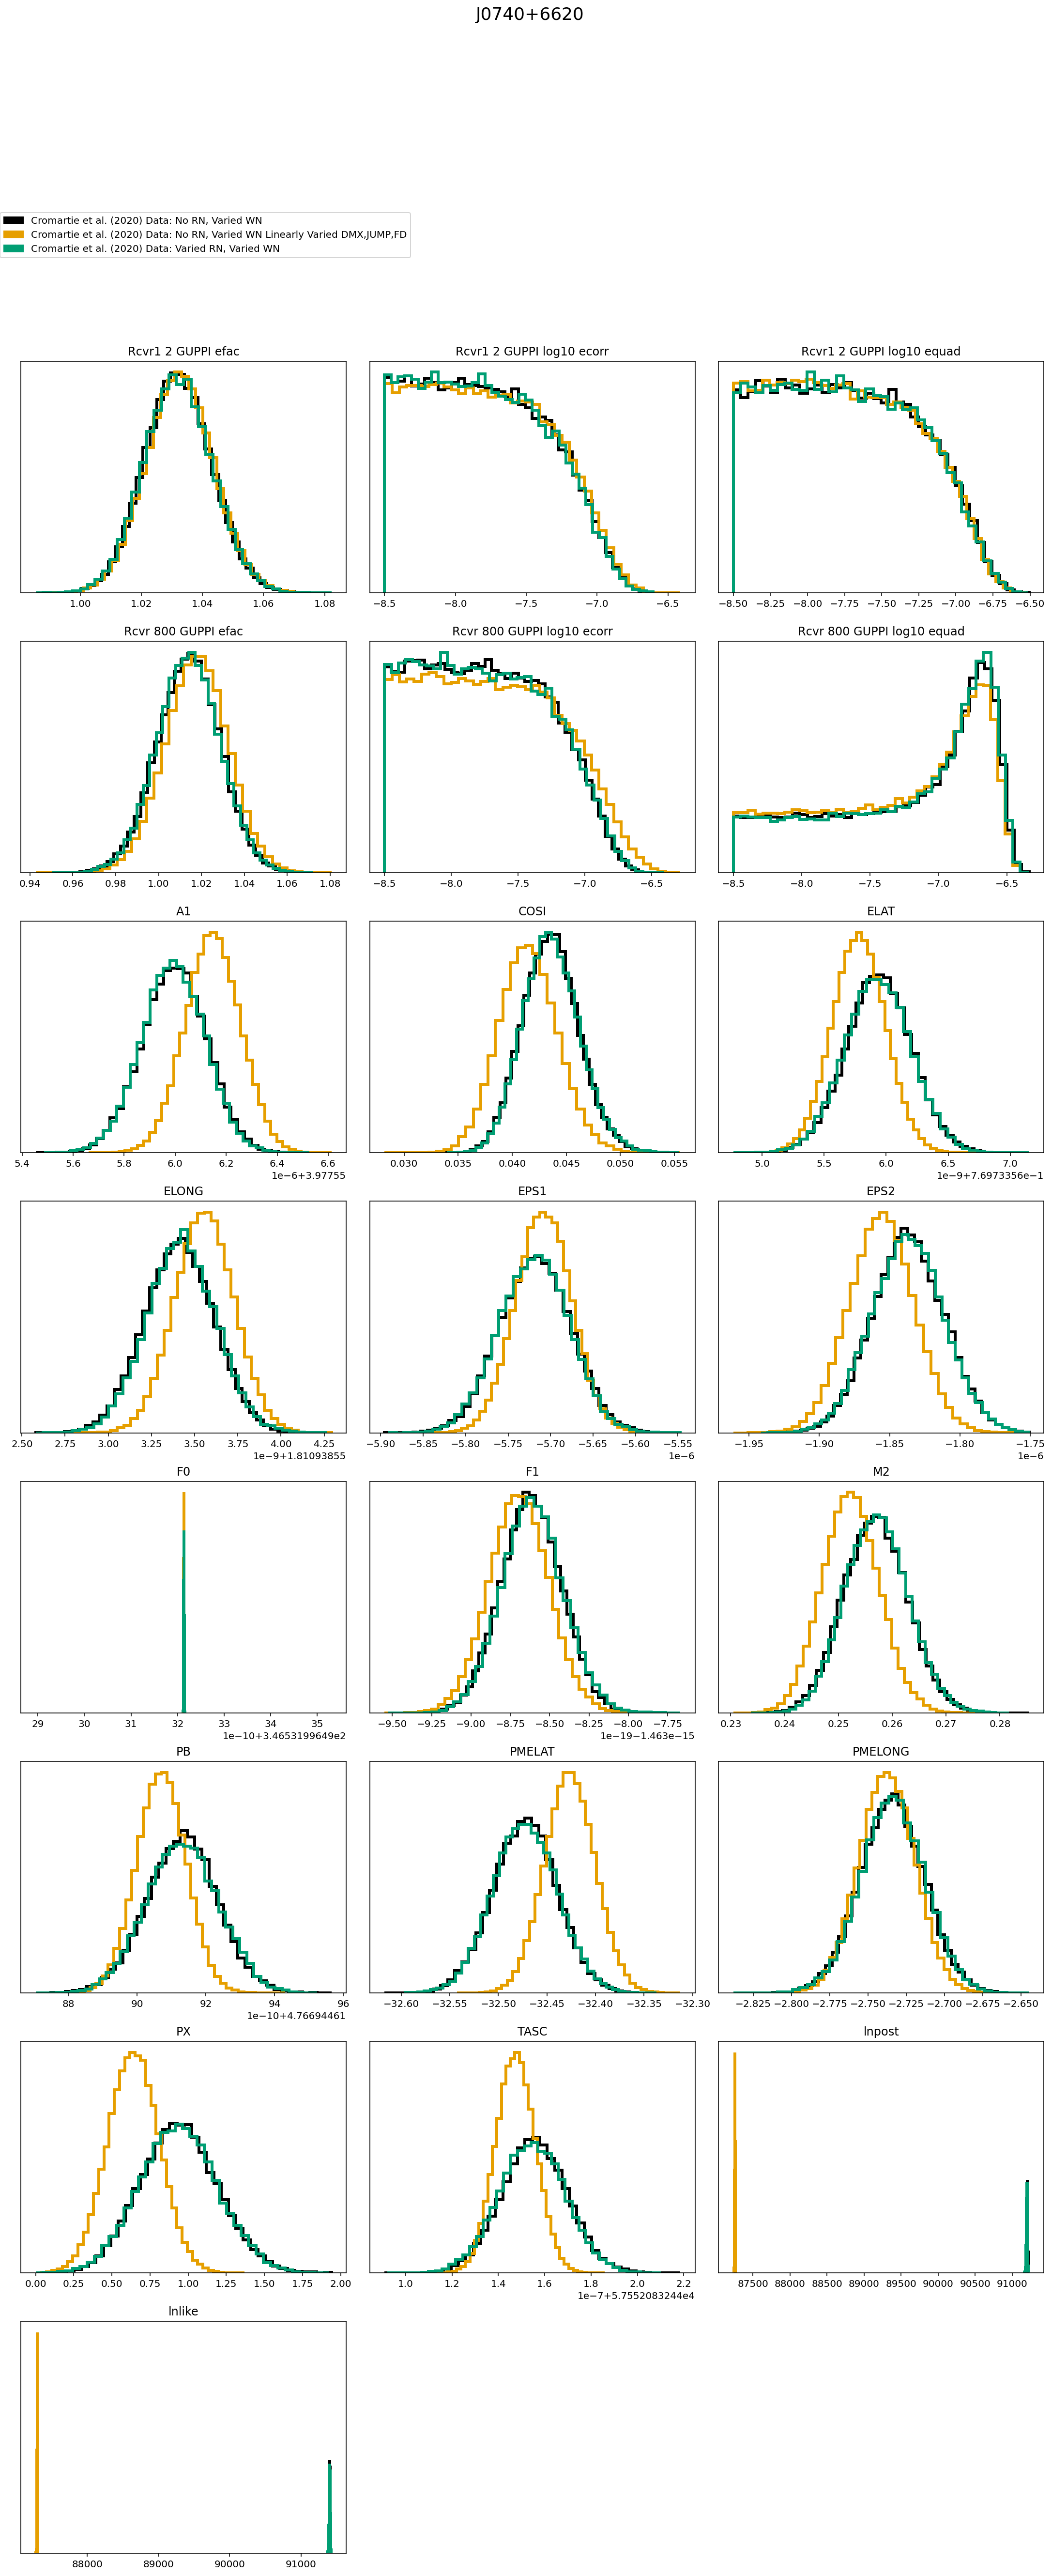

In [25]:
plot_all_param_overlap(core_list_cfr19,core_list_legend=core_list_legend_cfr19,exclude=False)

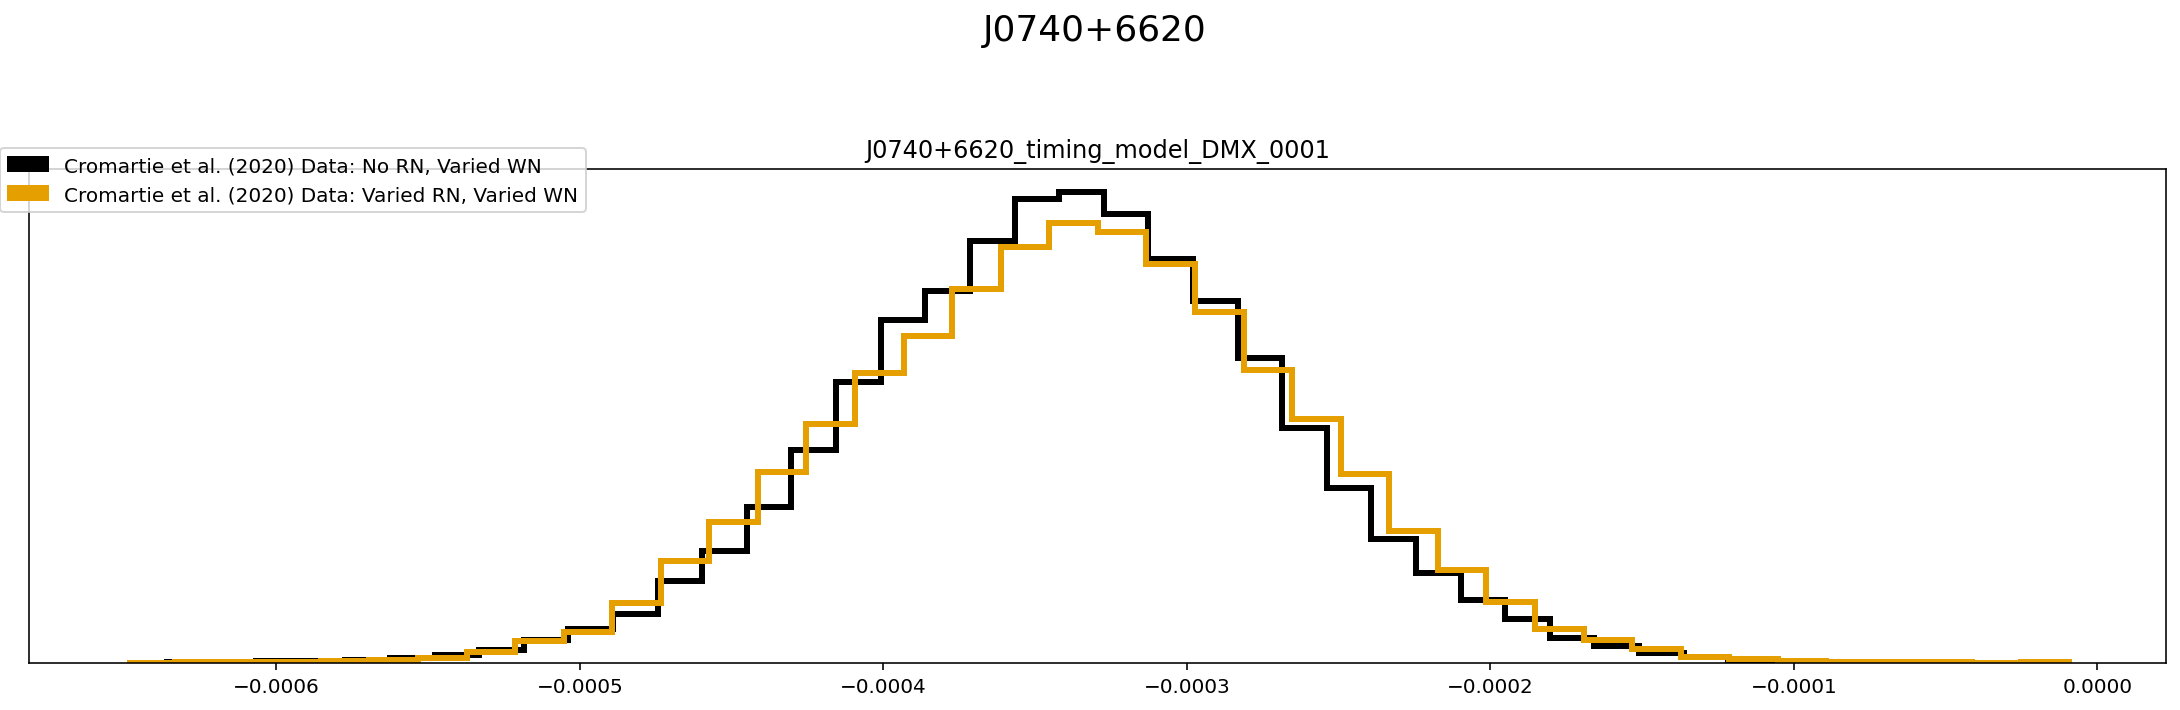

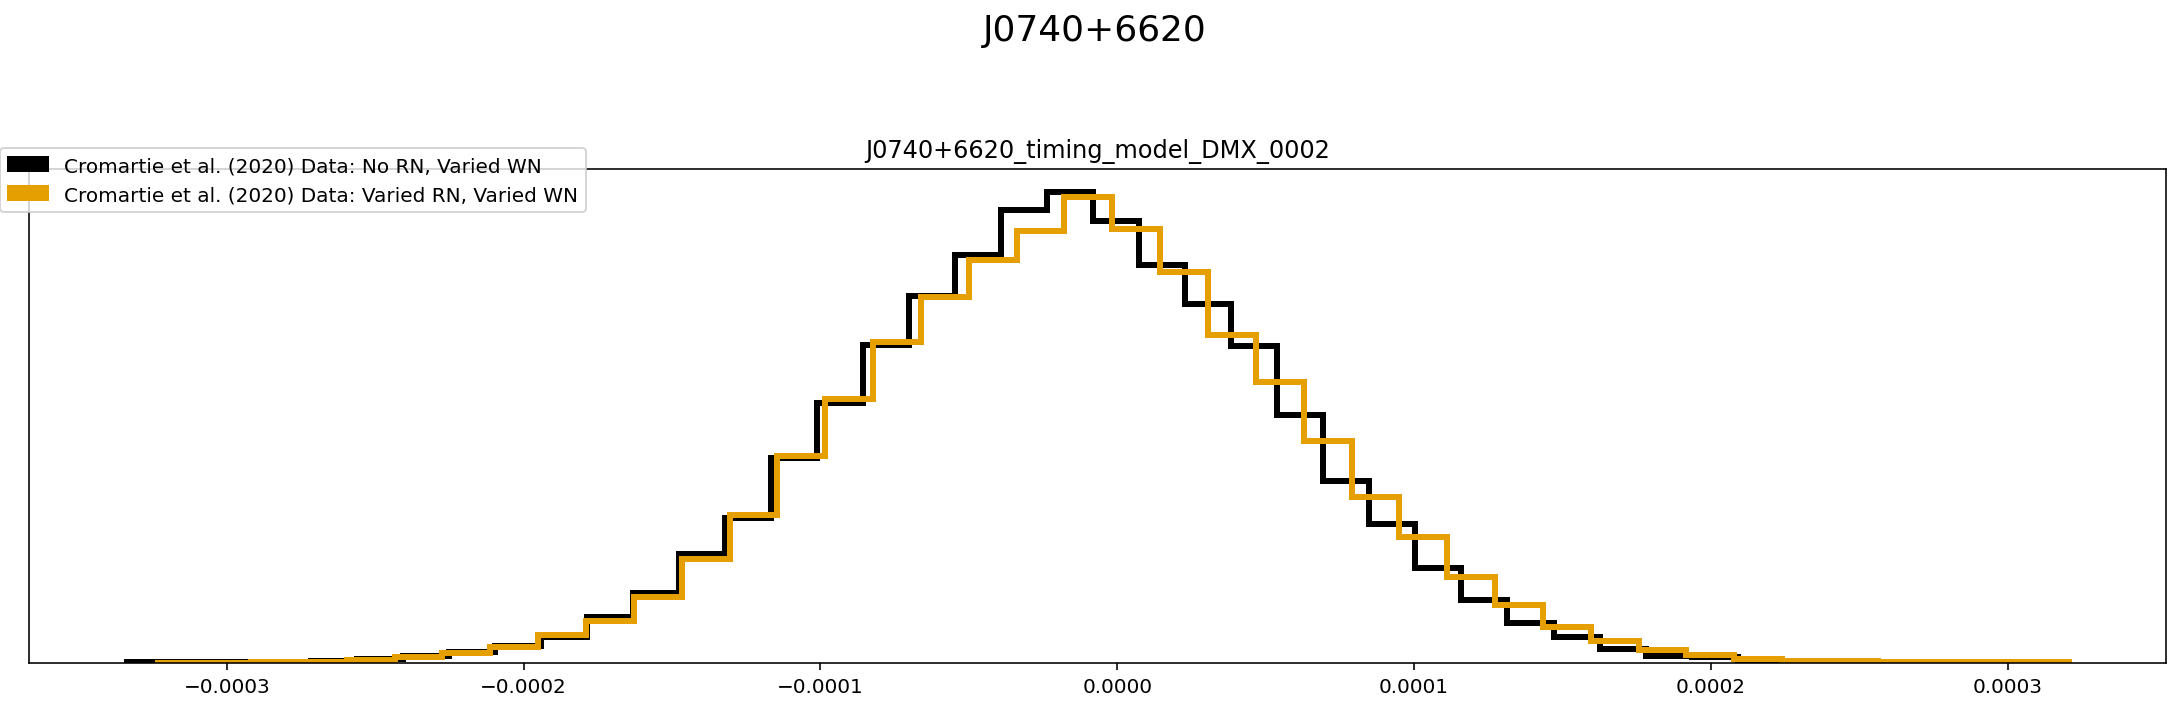

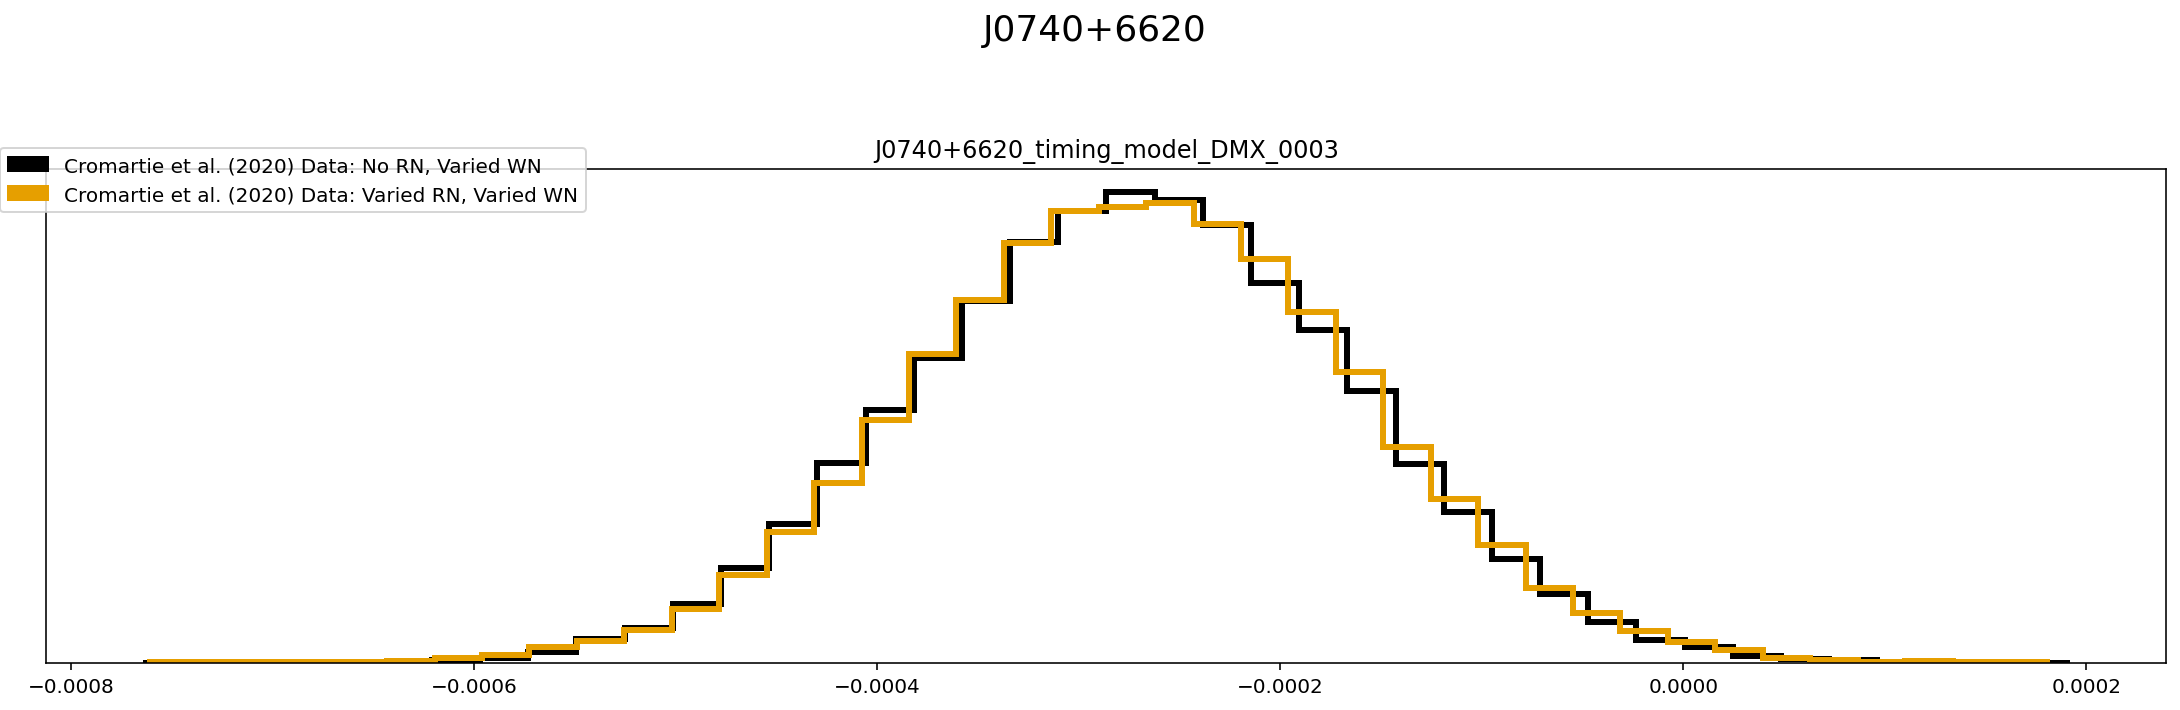

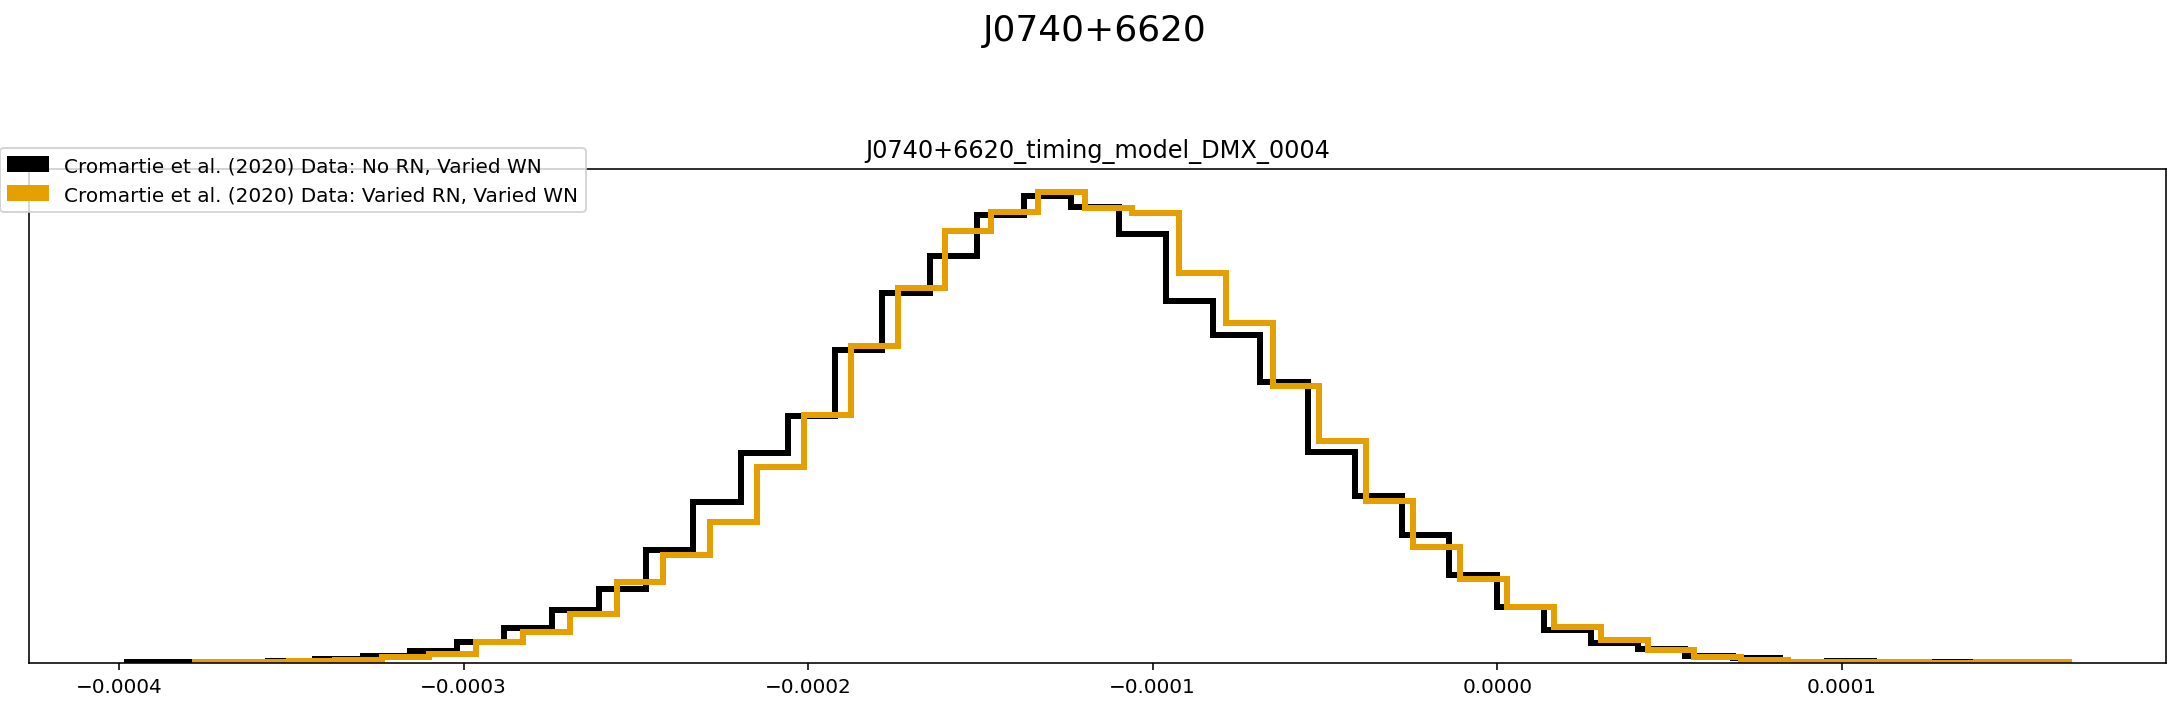

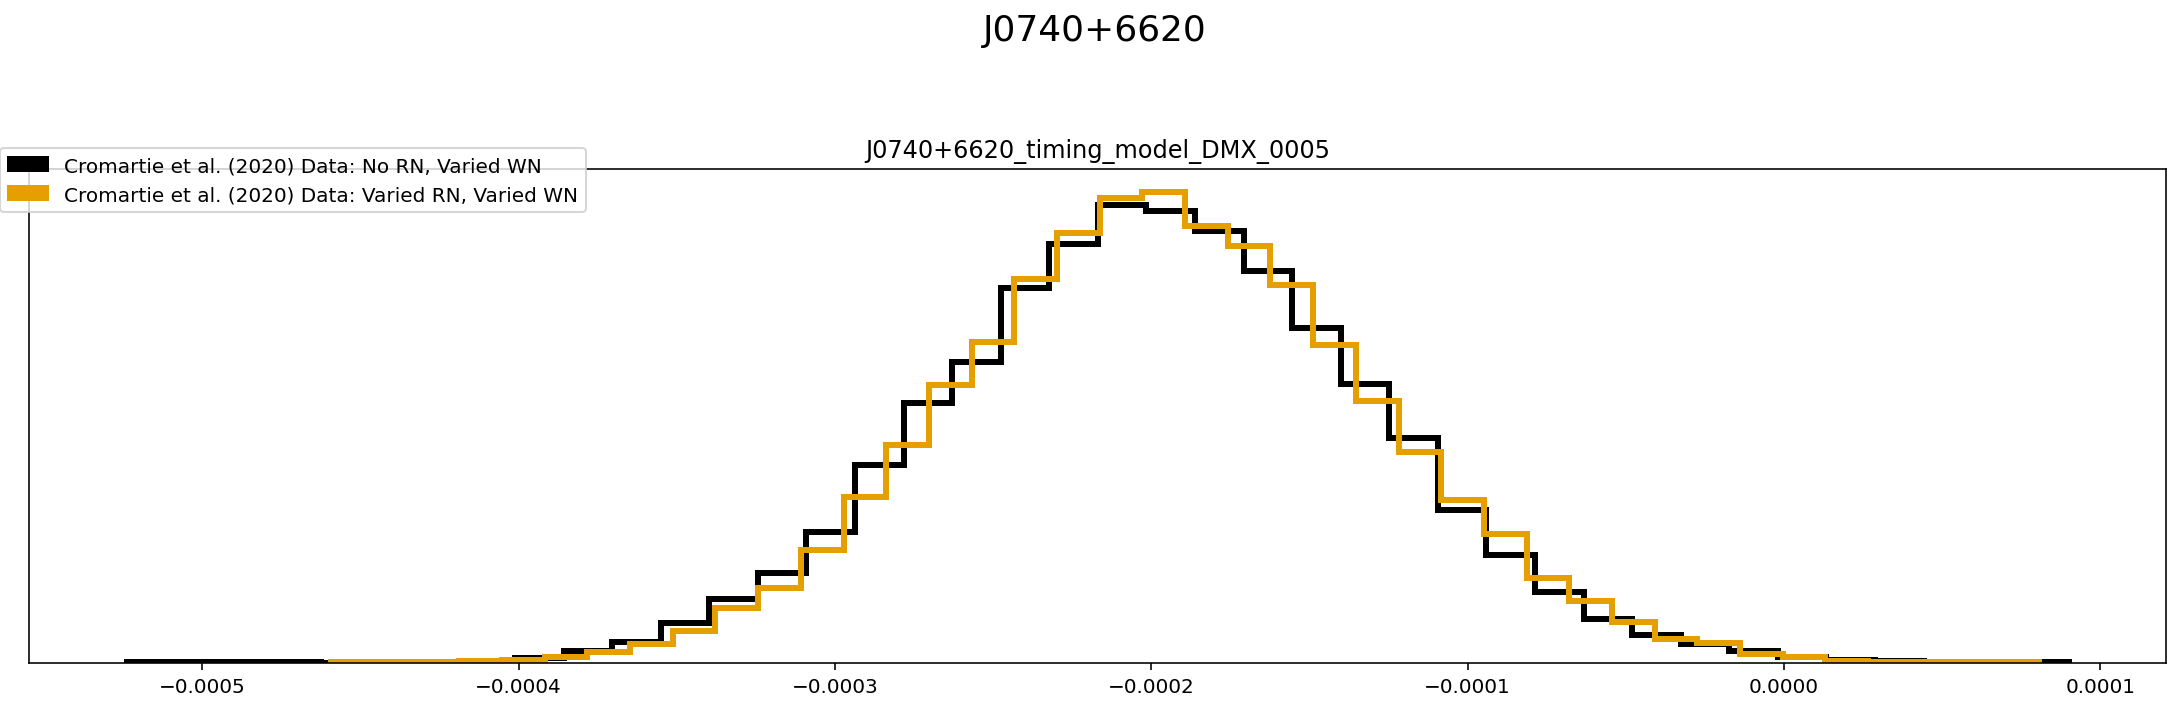

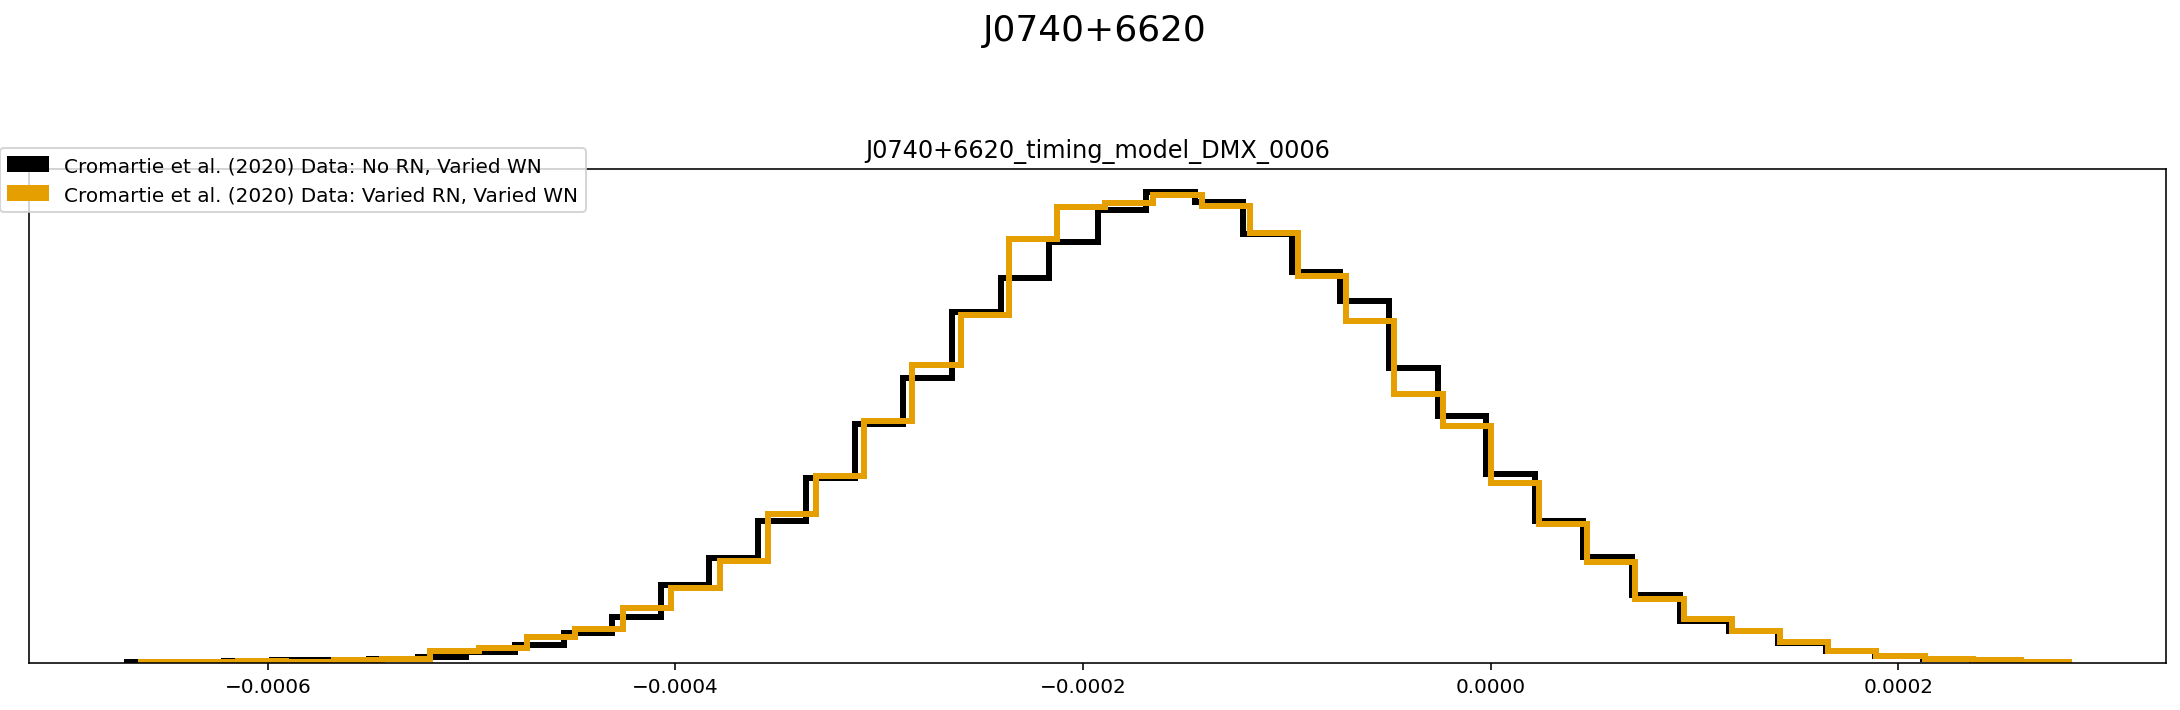

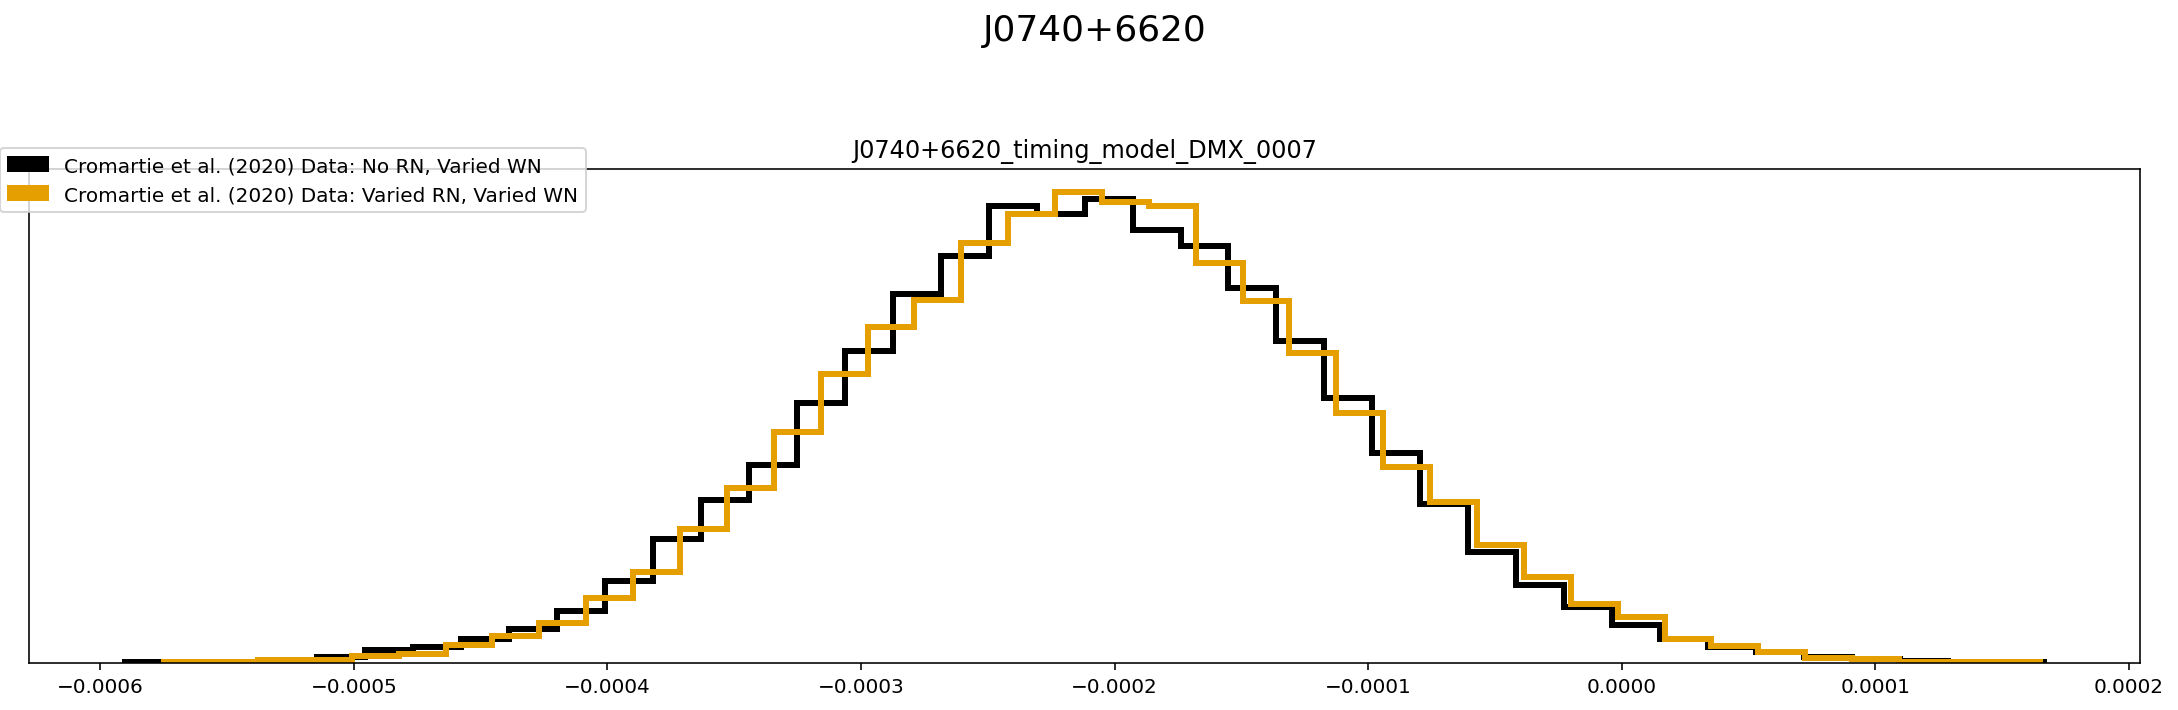

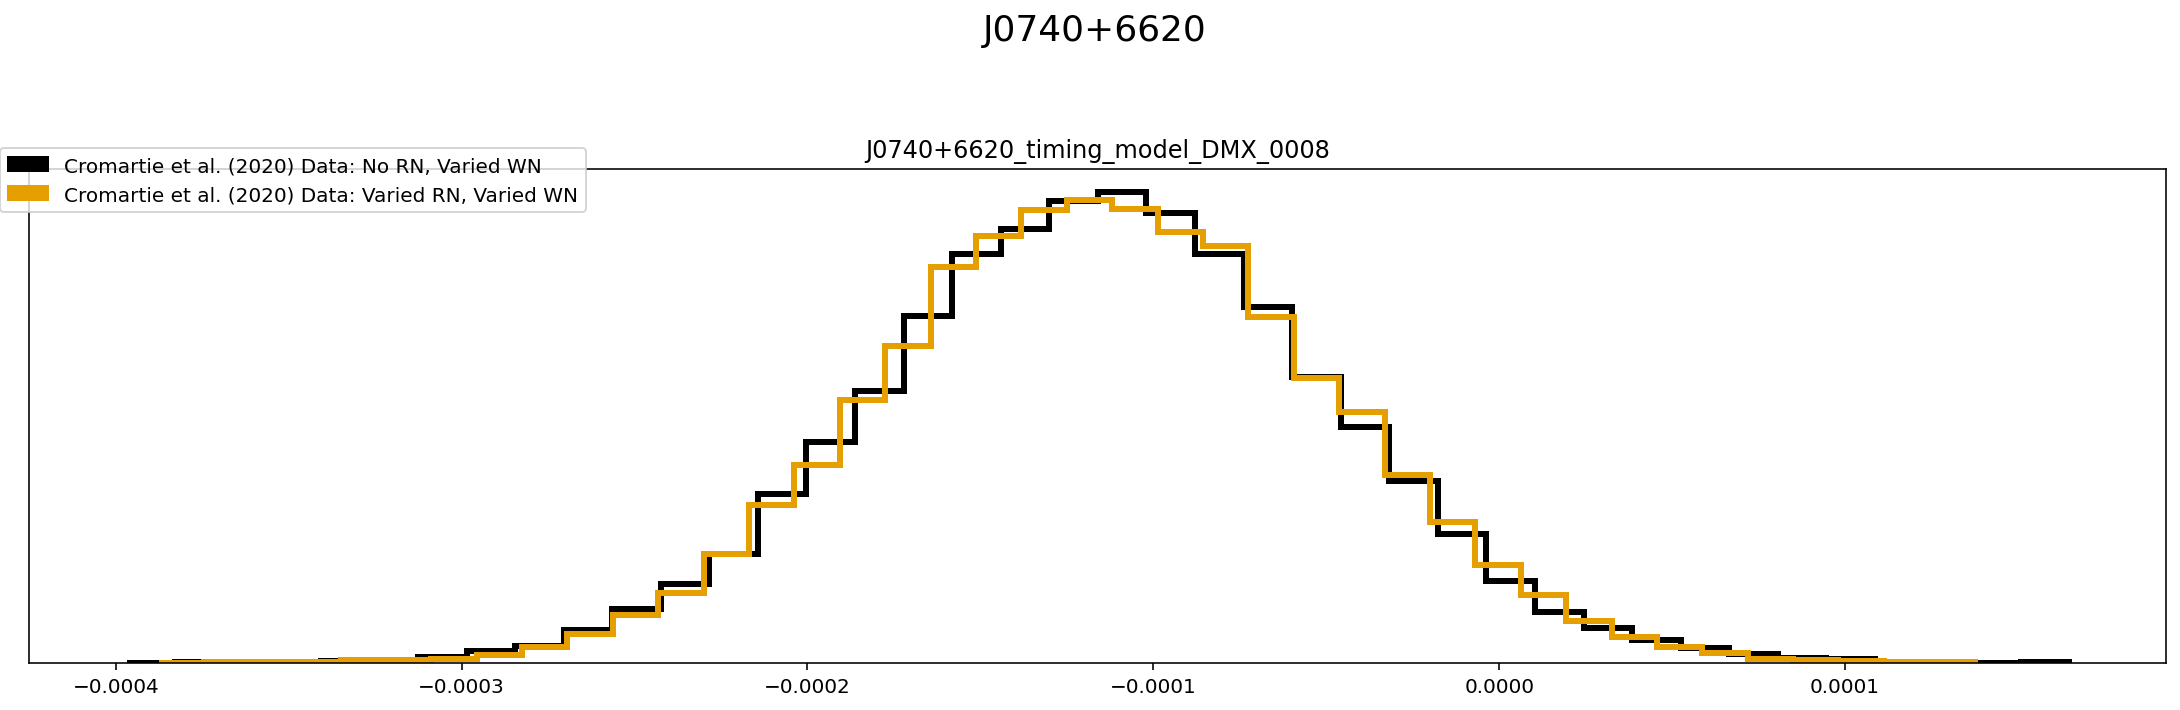

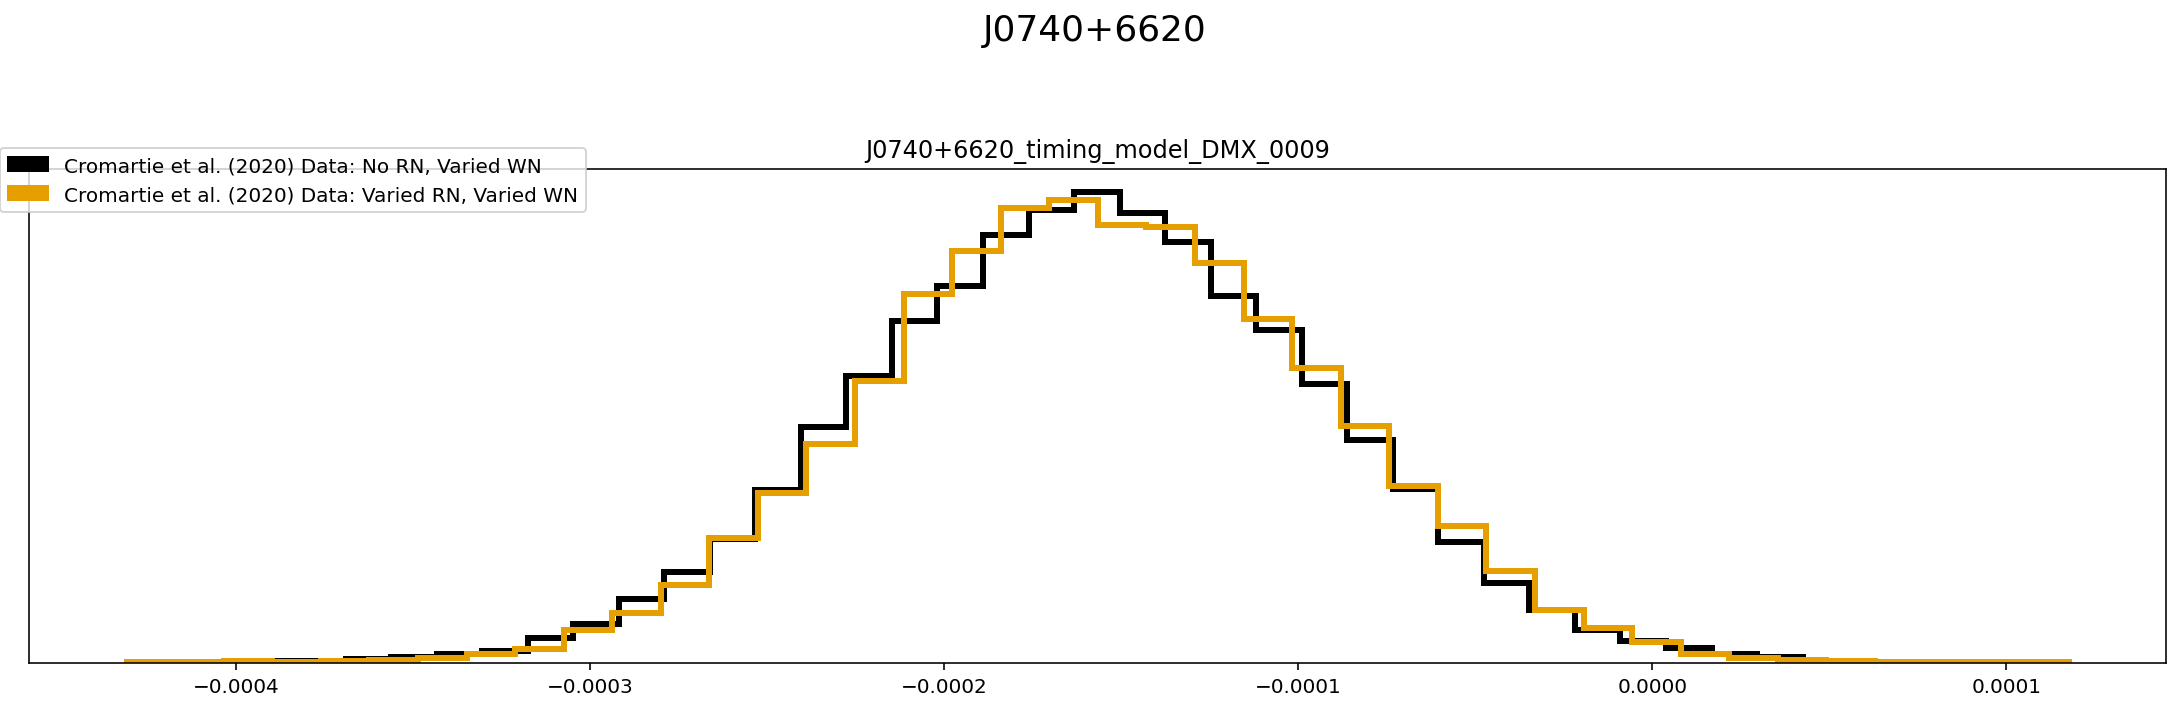

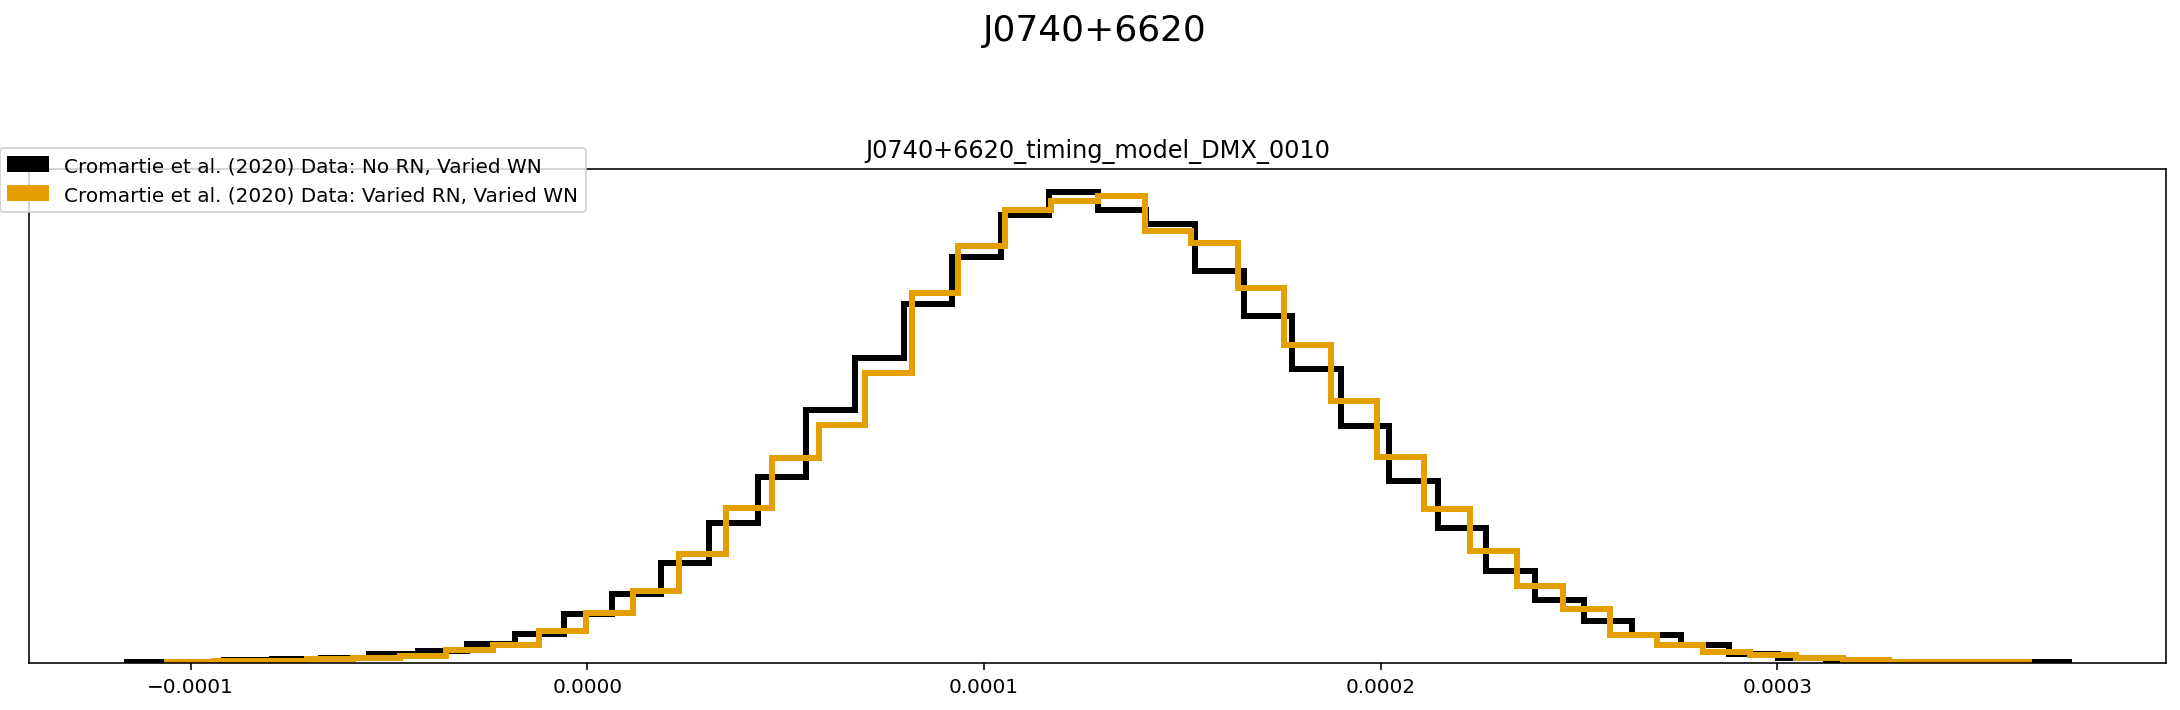

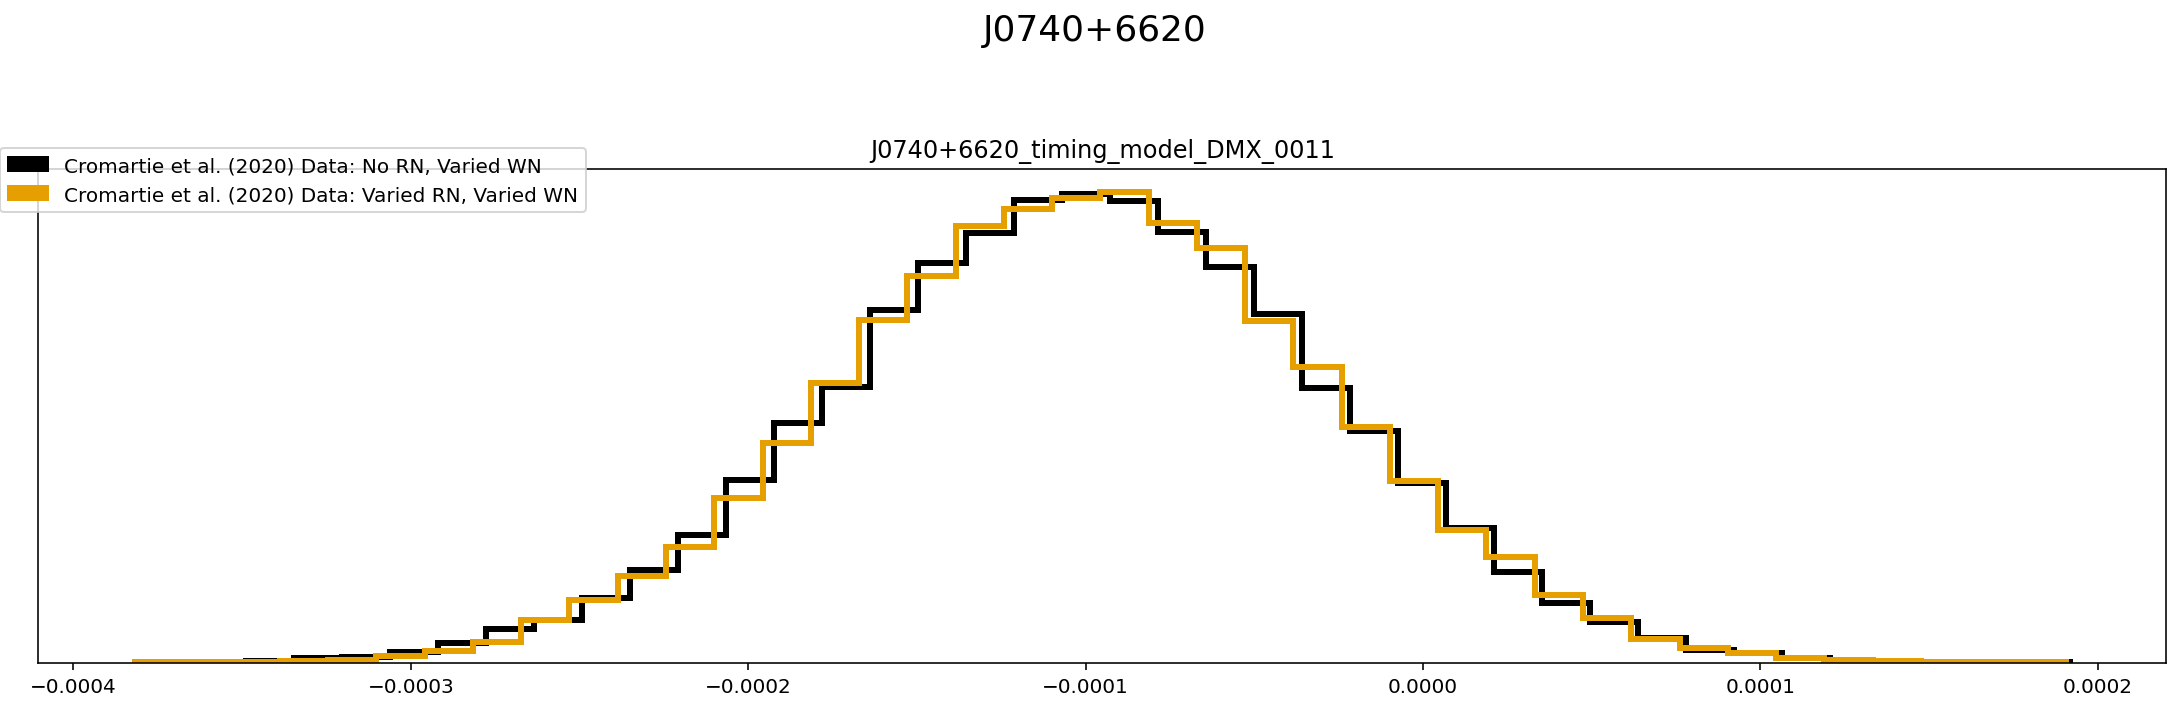

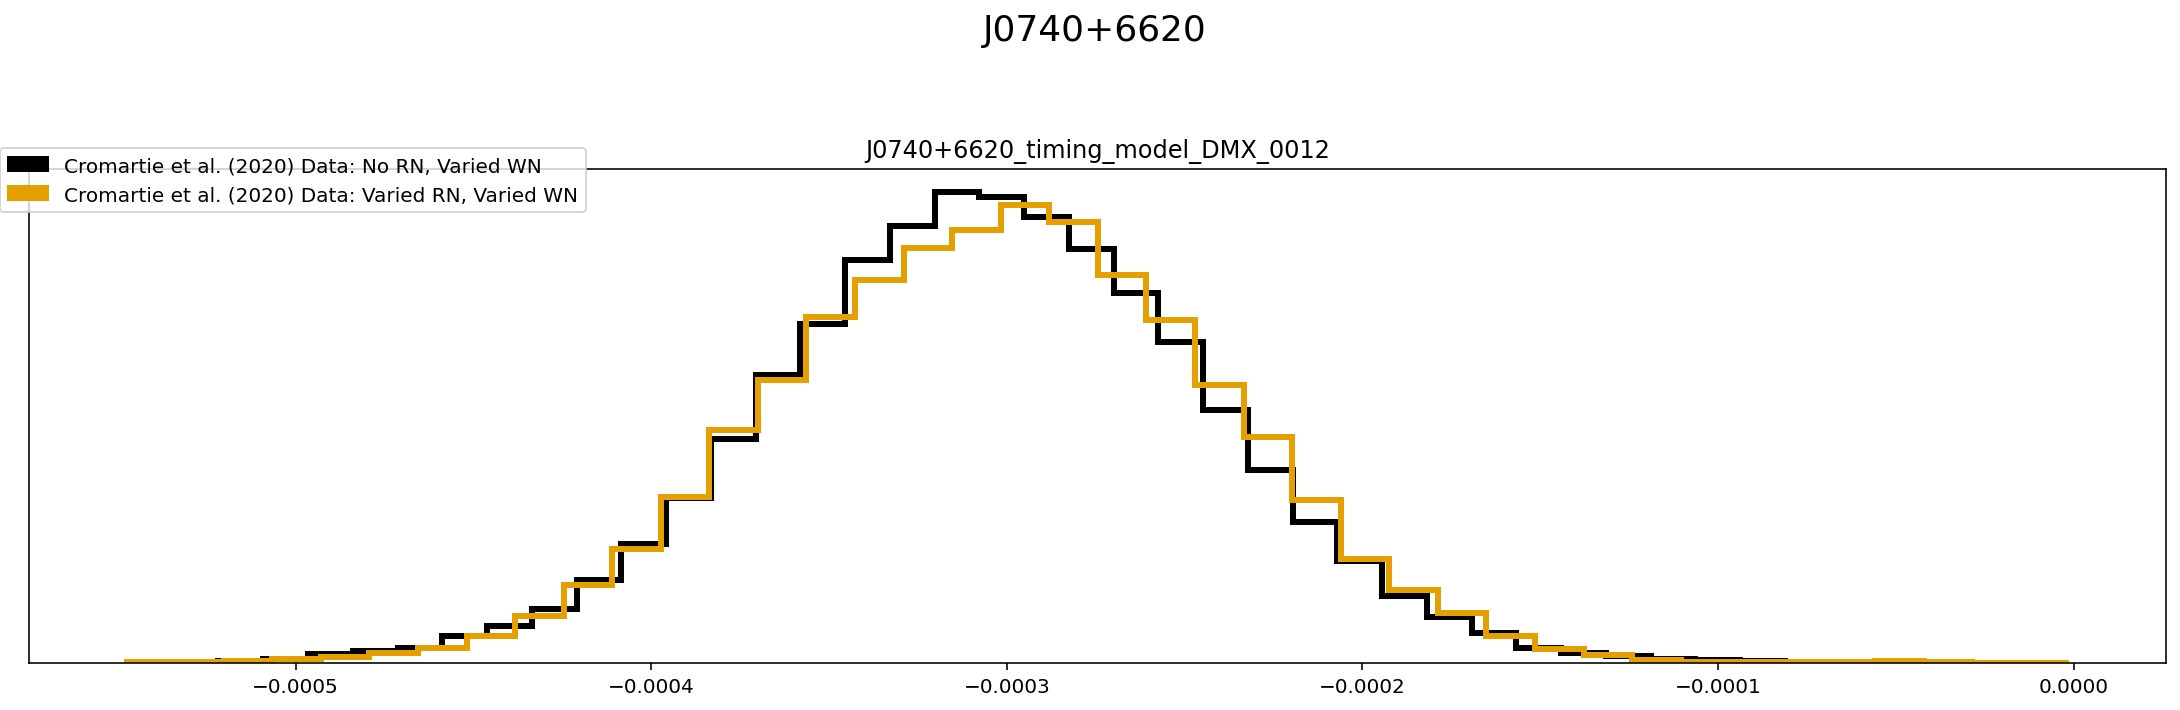

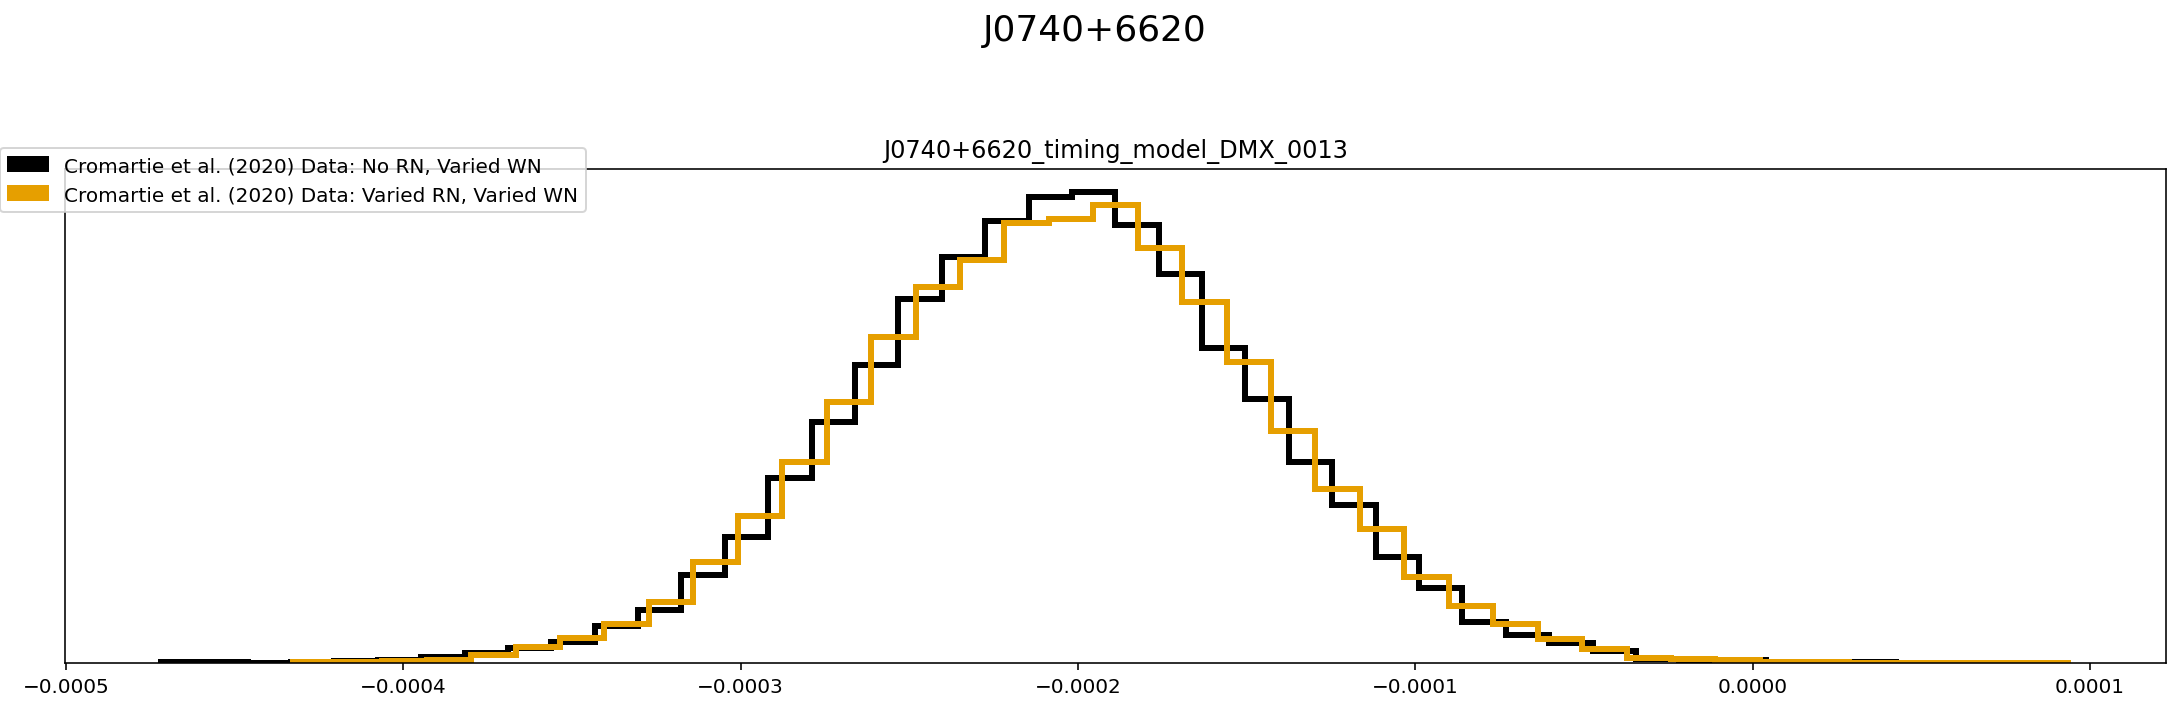

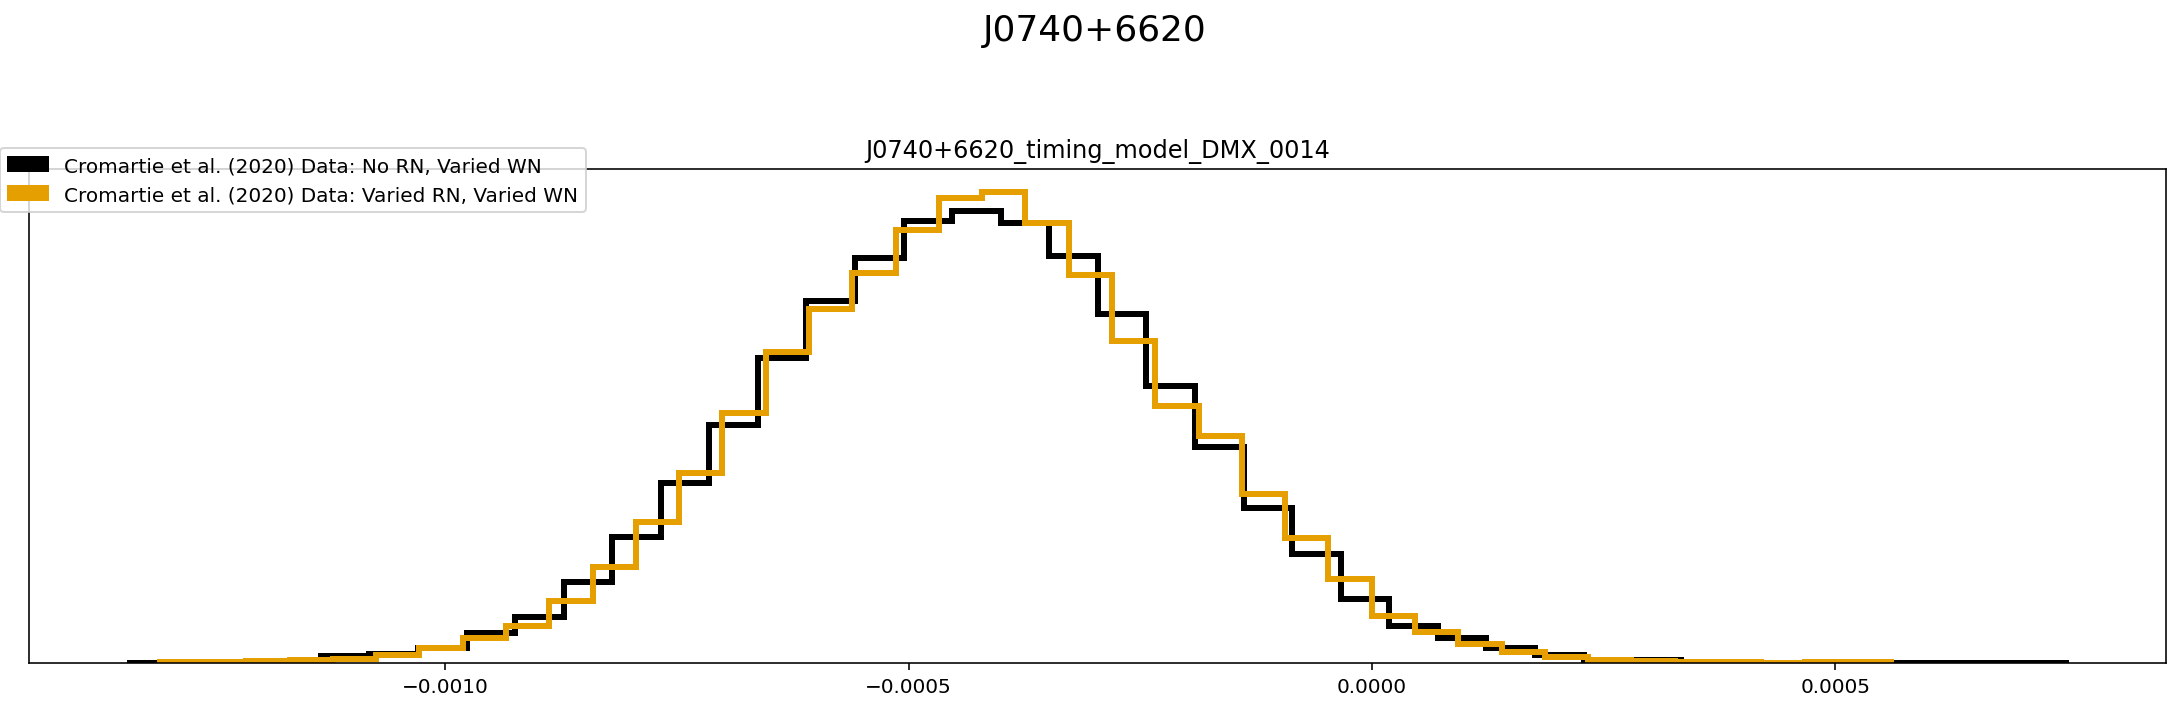

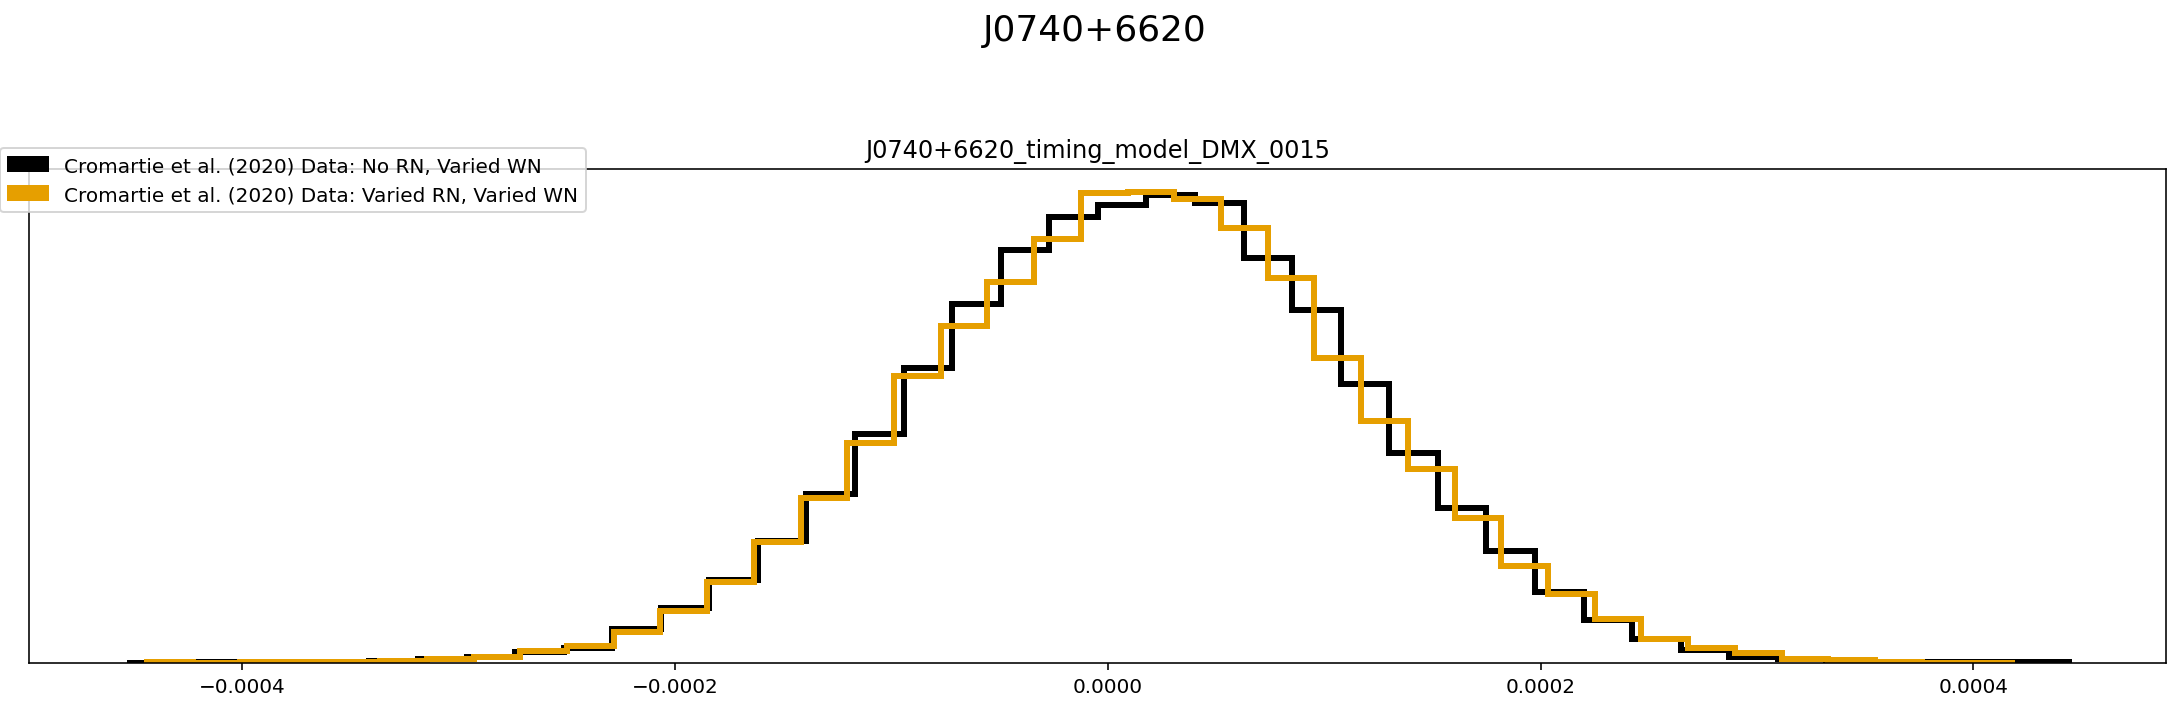

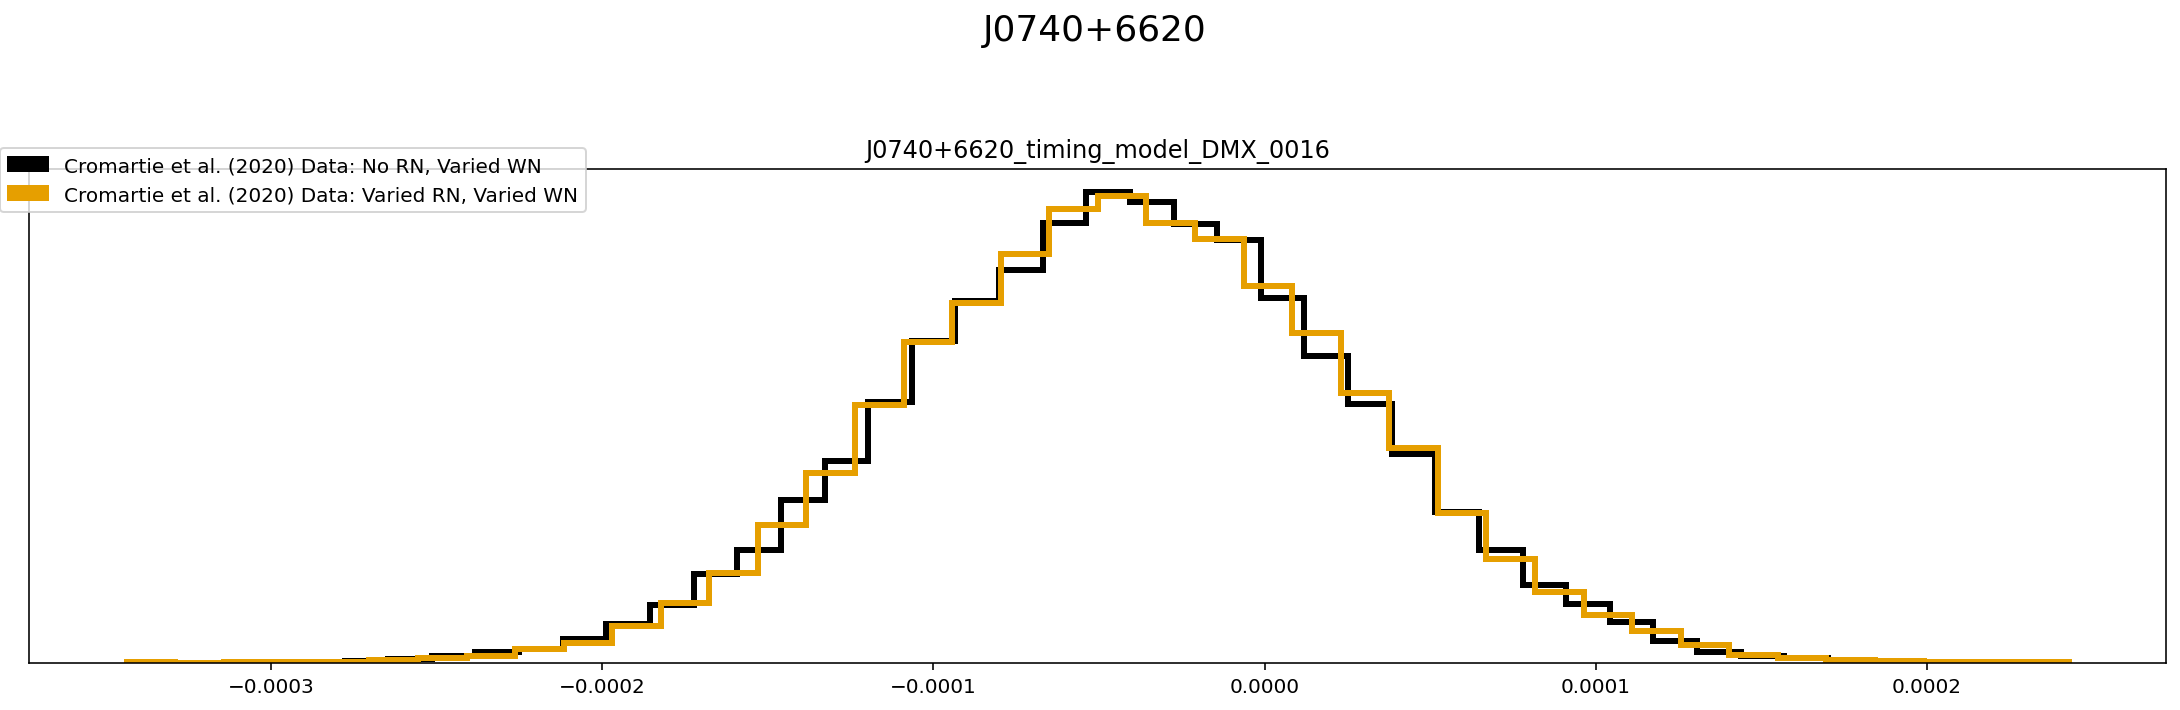

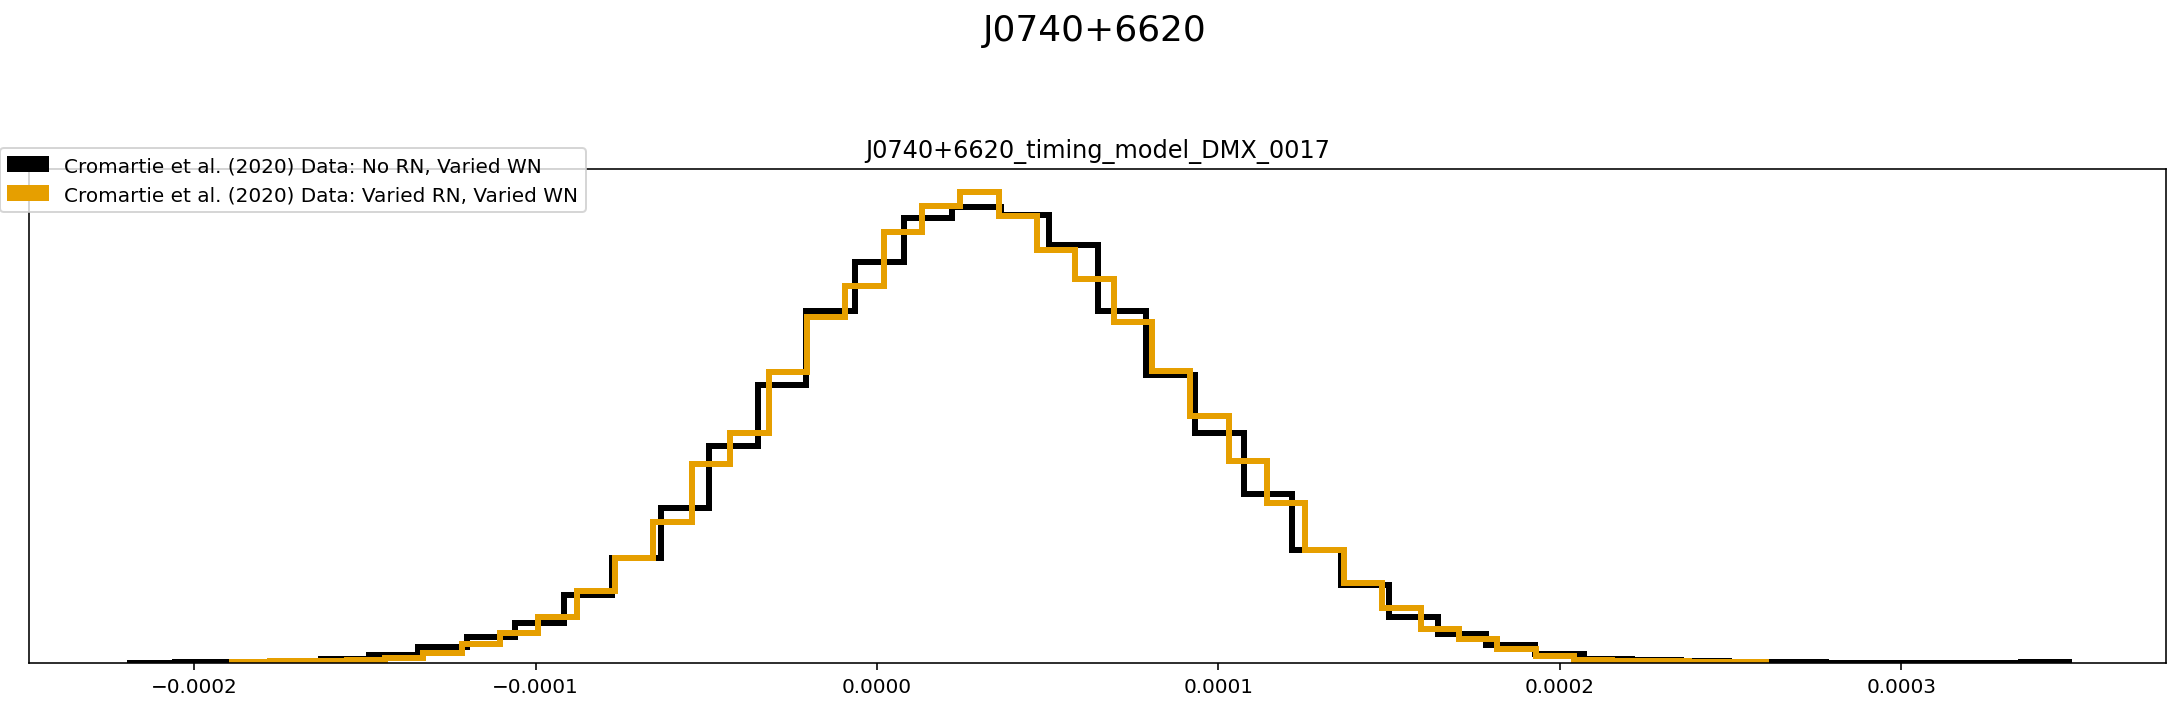

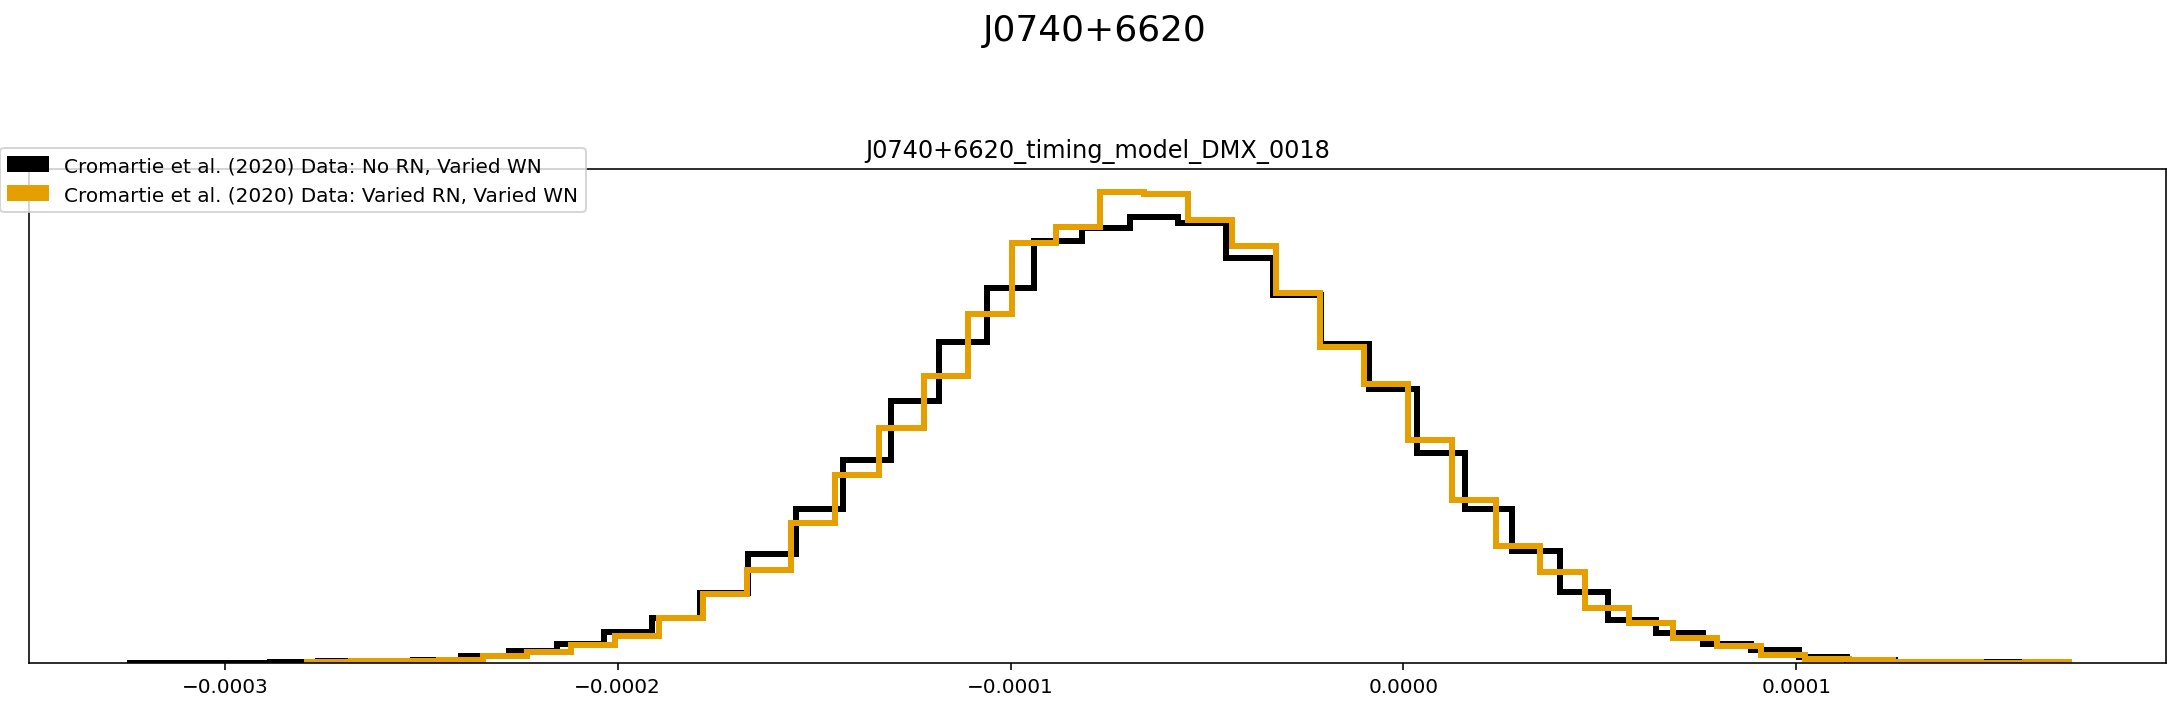

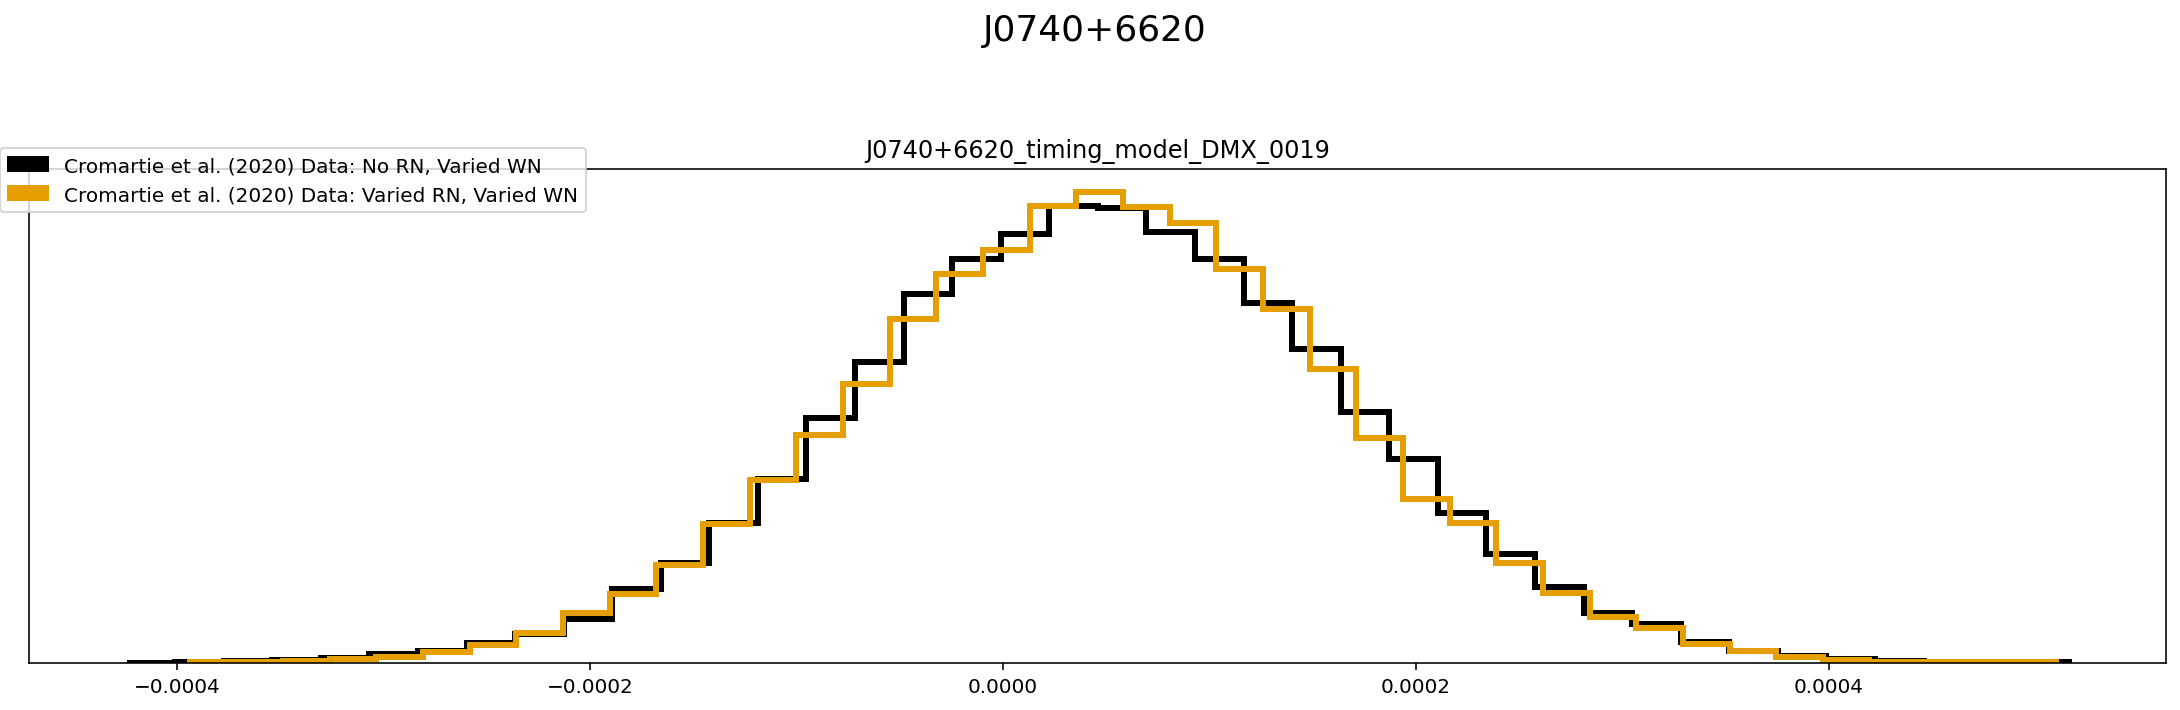

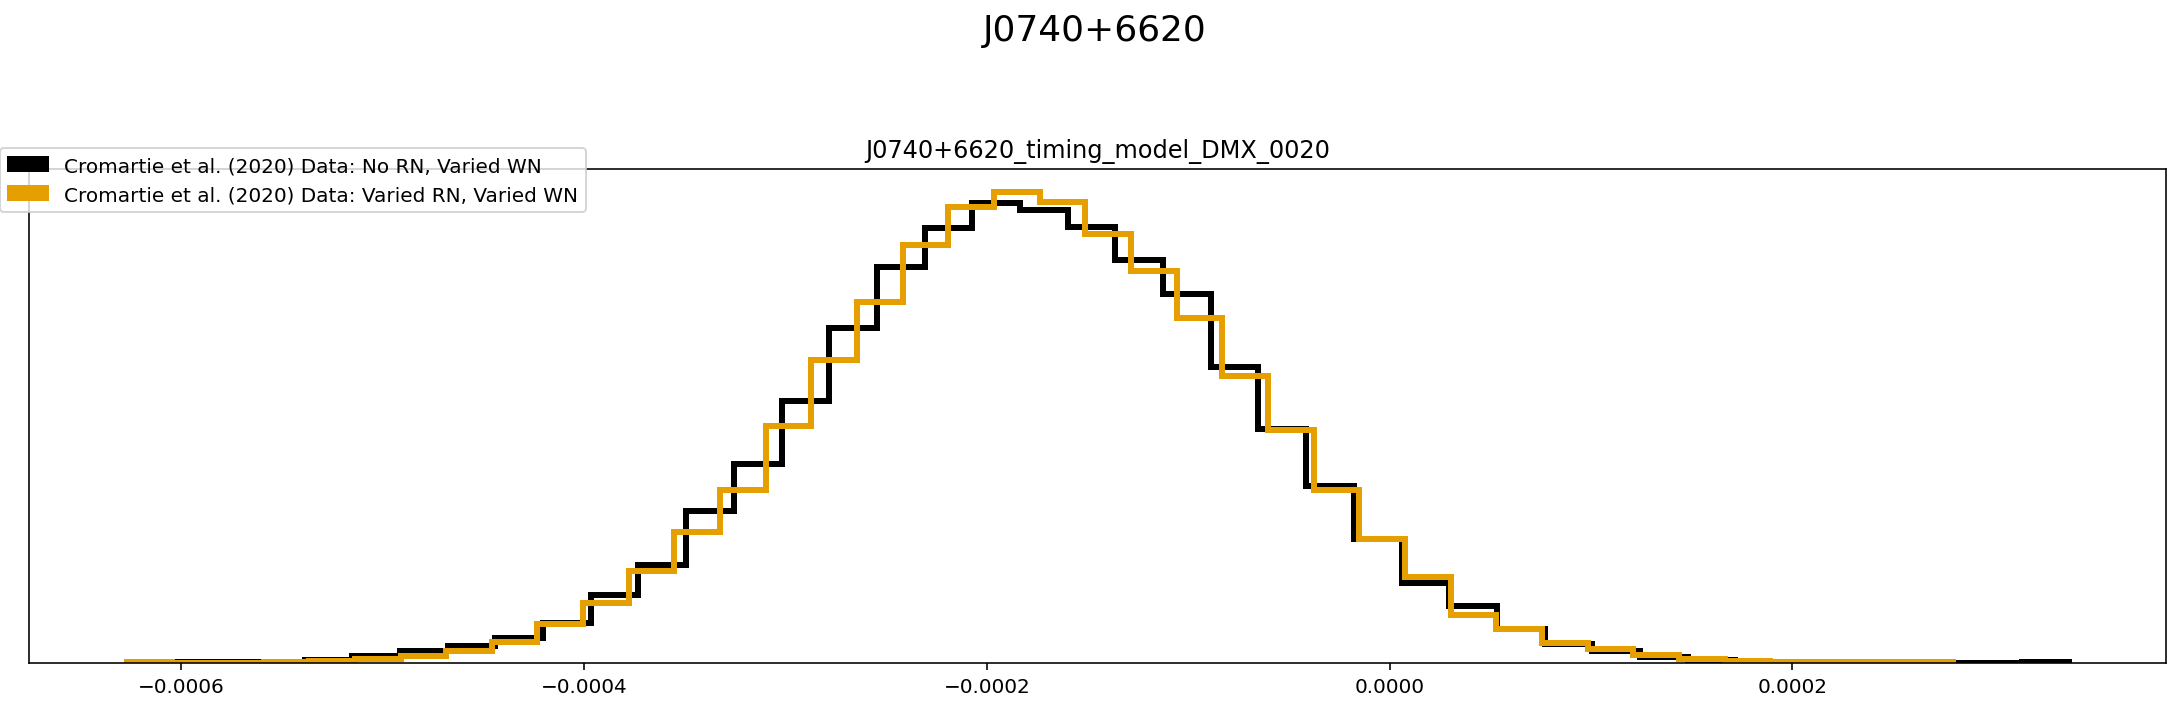

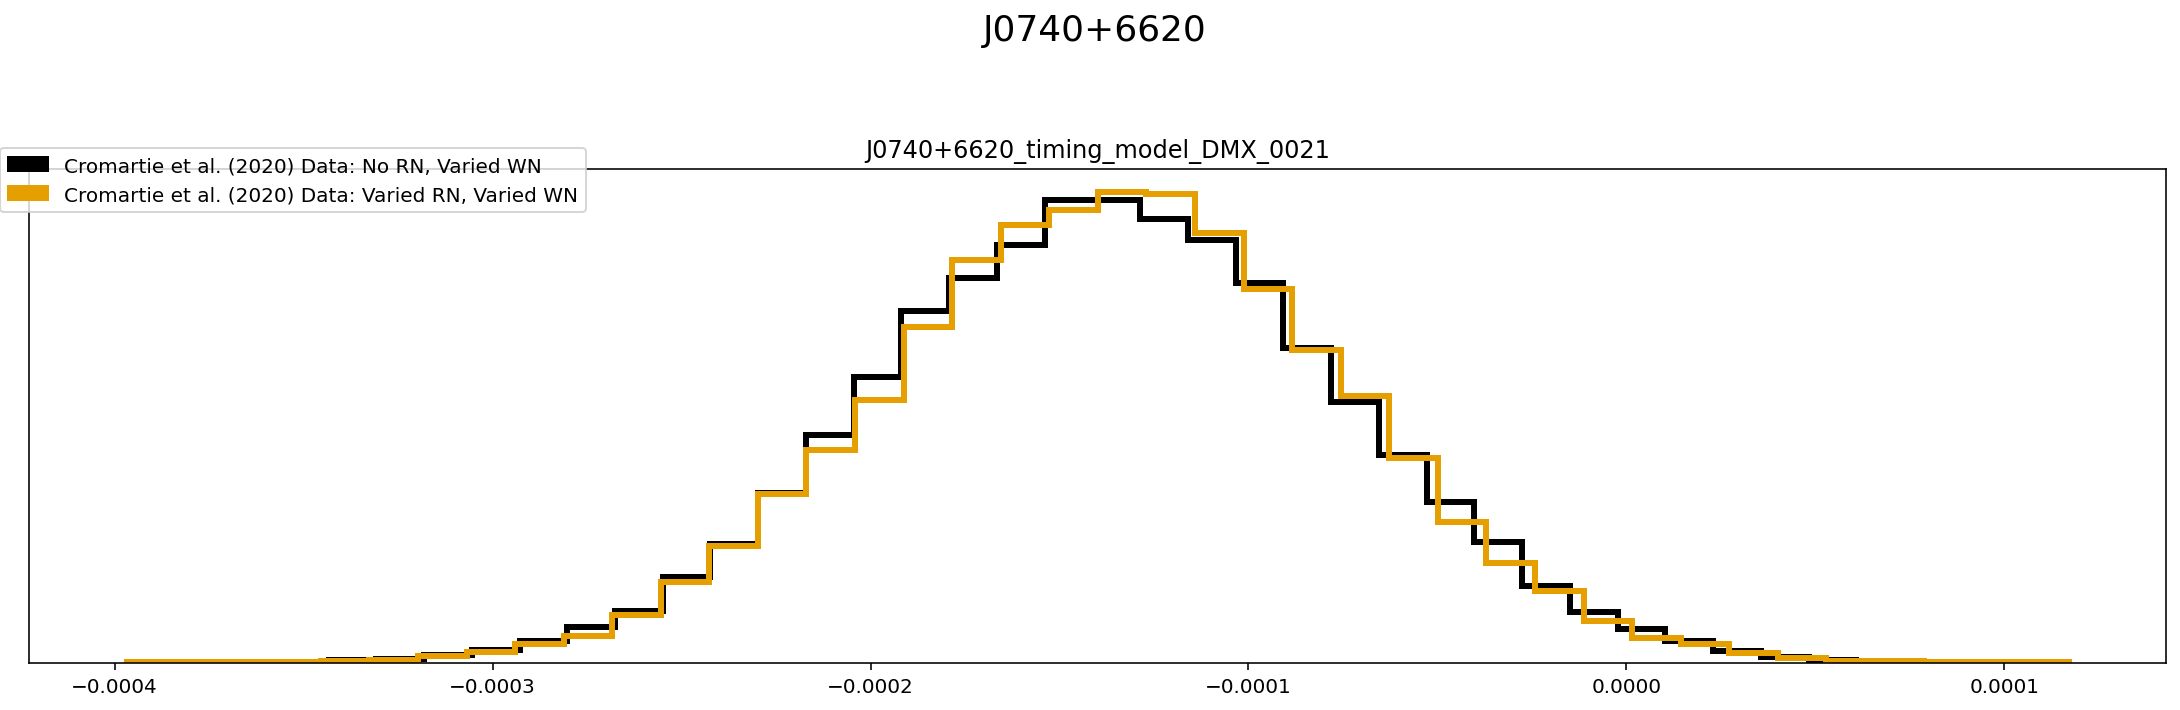

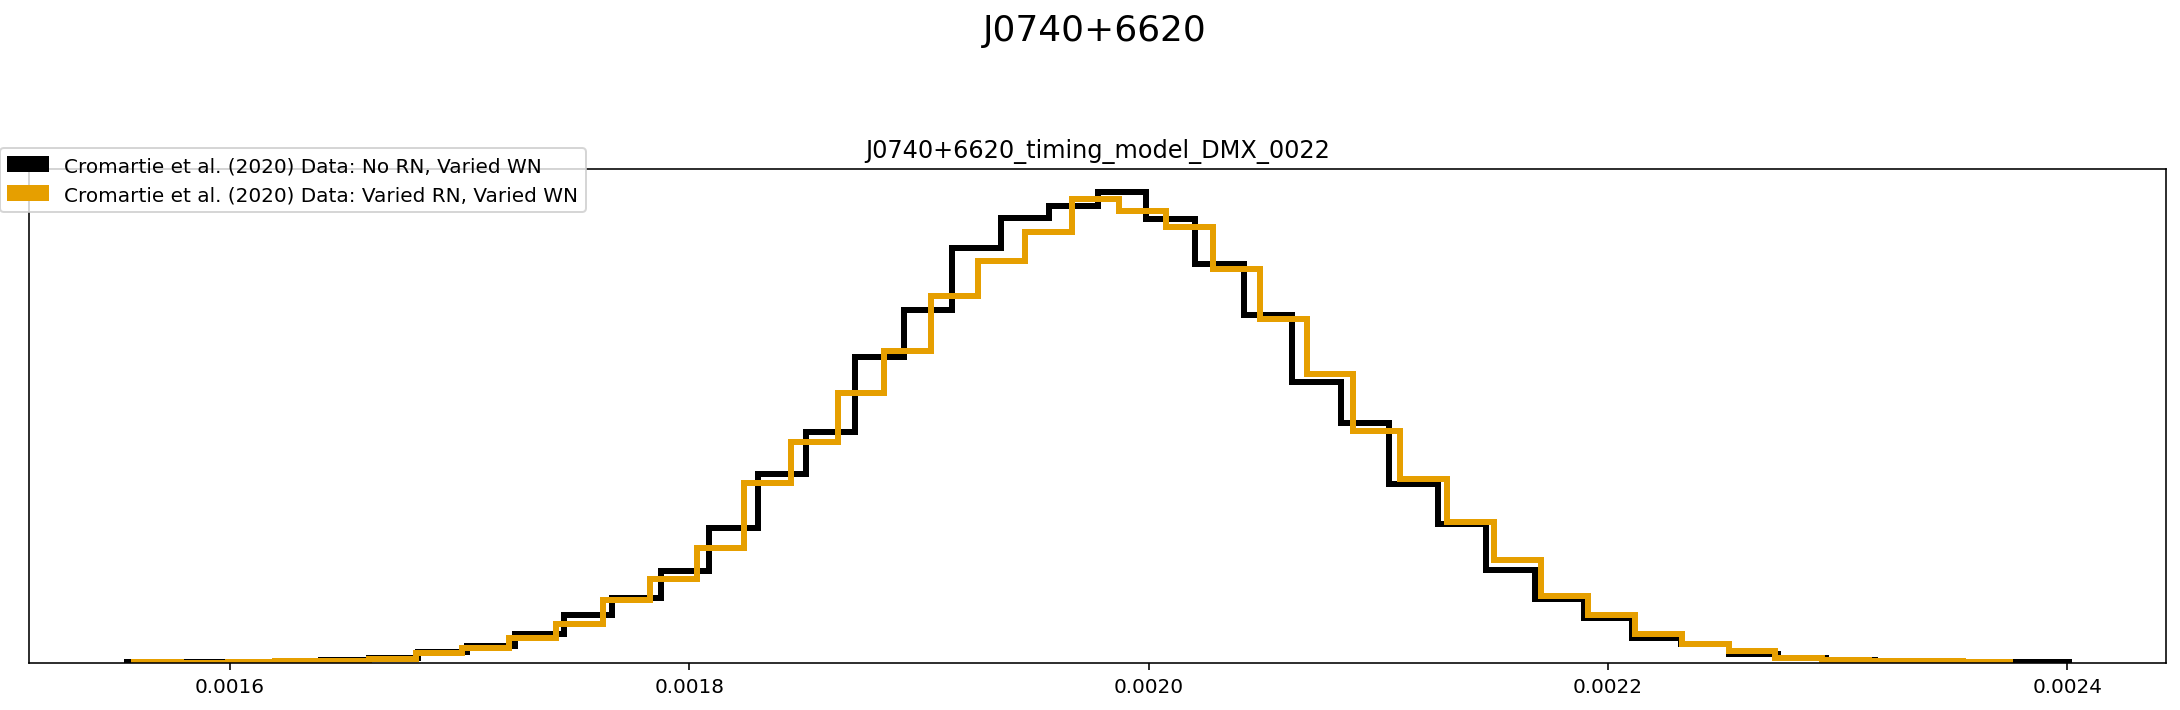

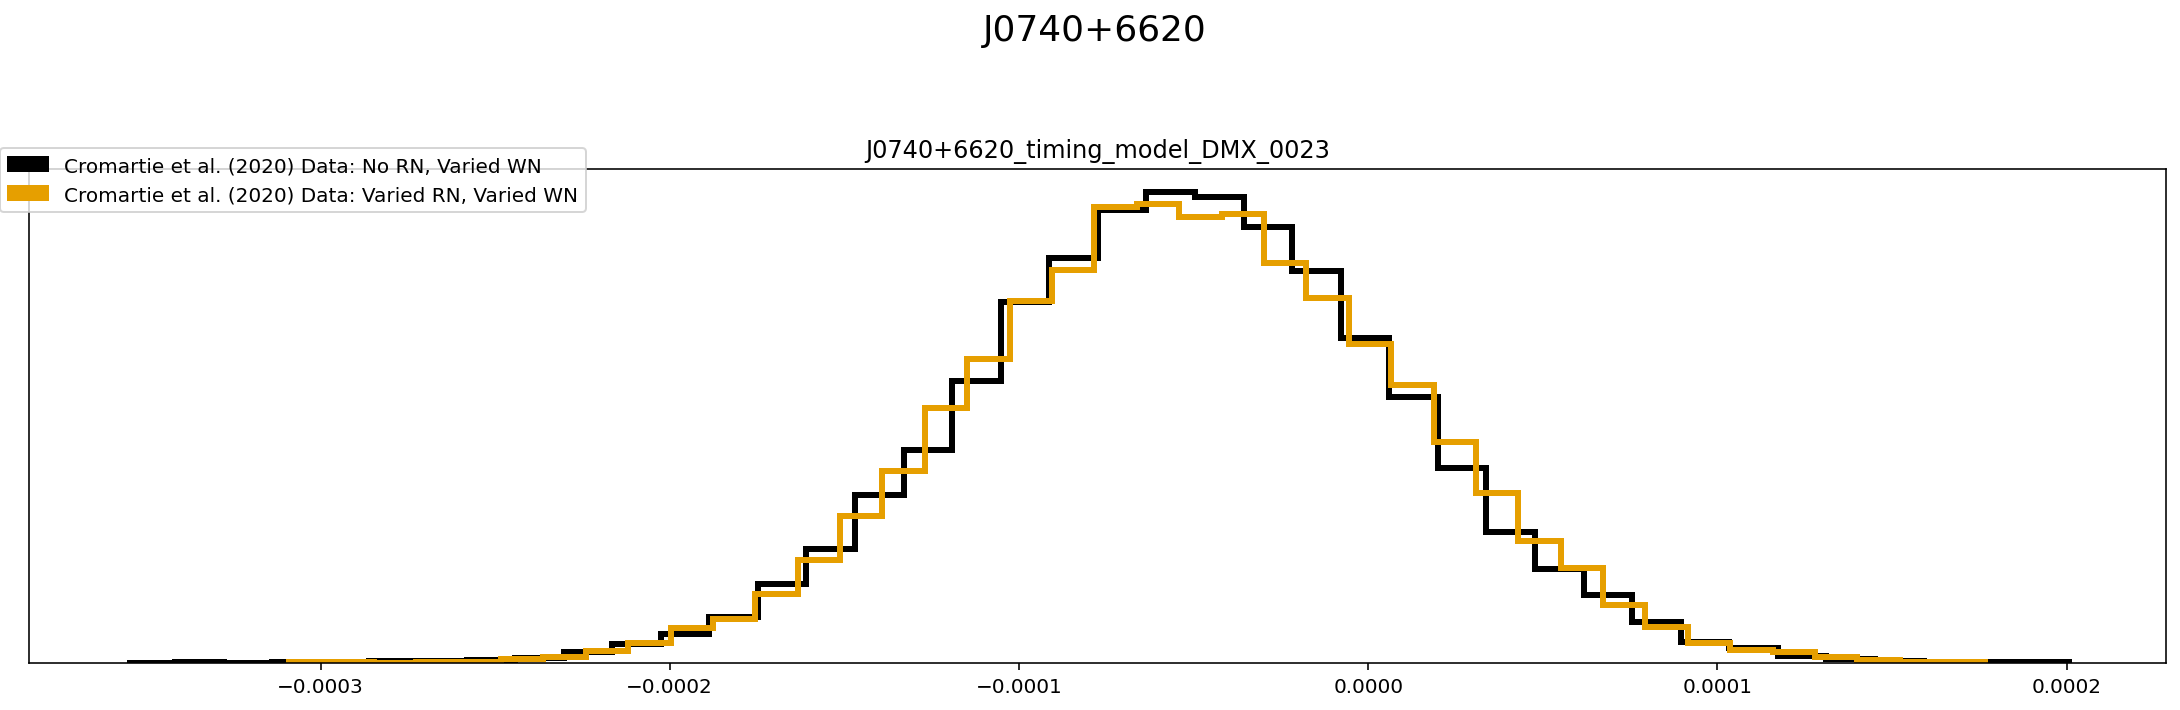

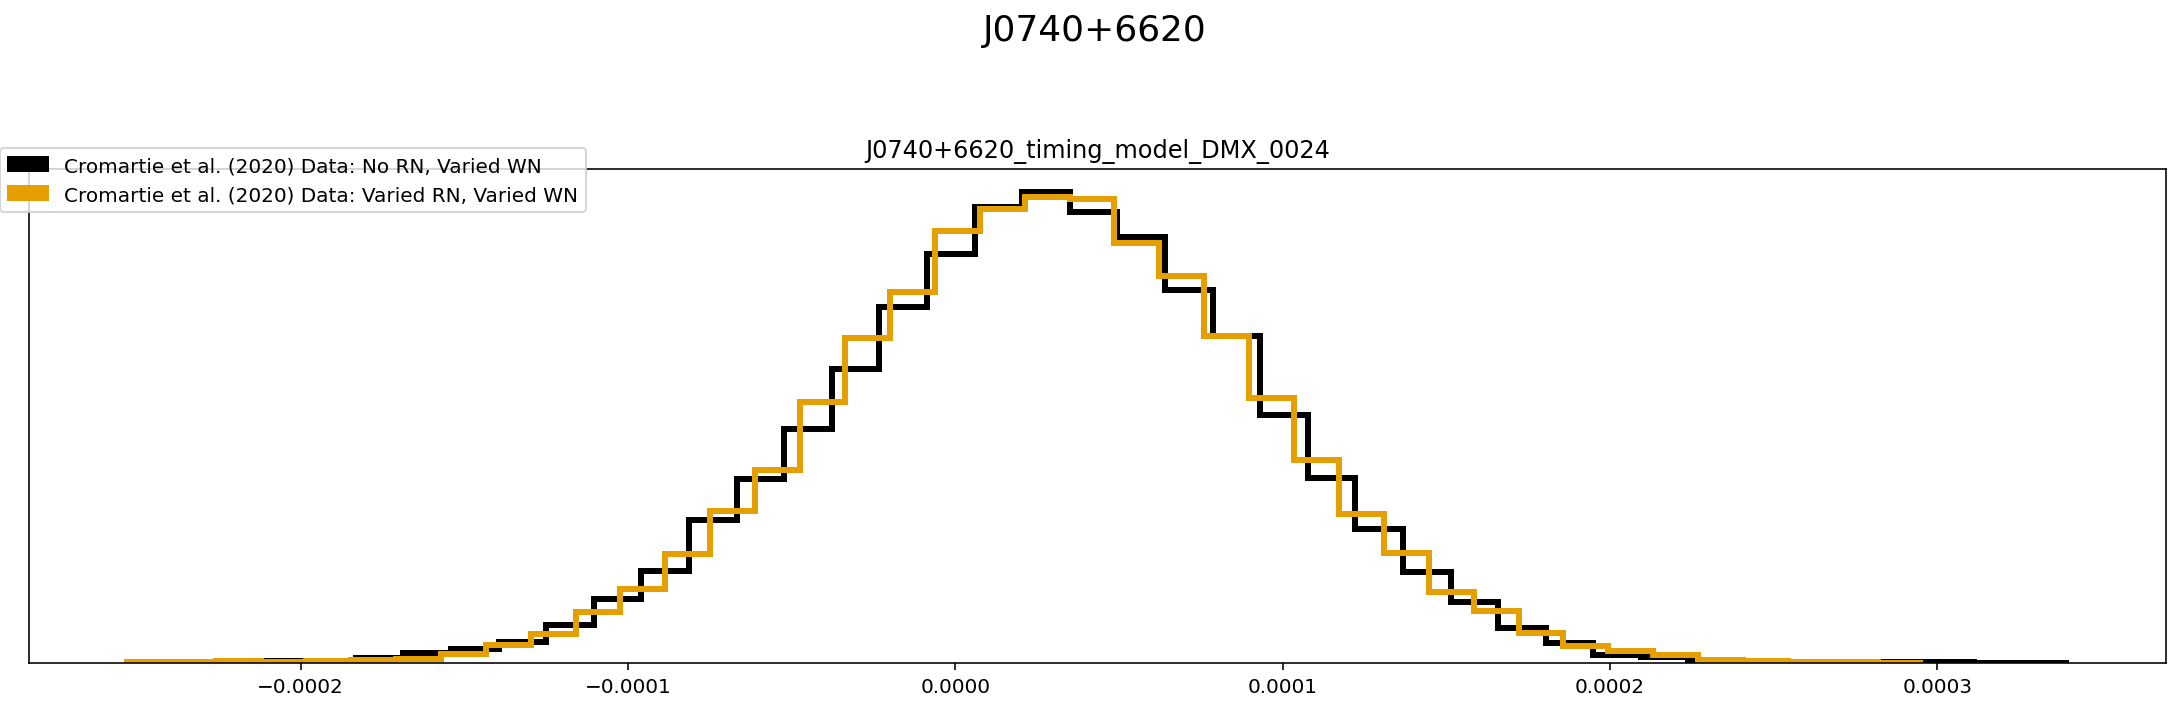

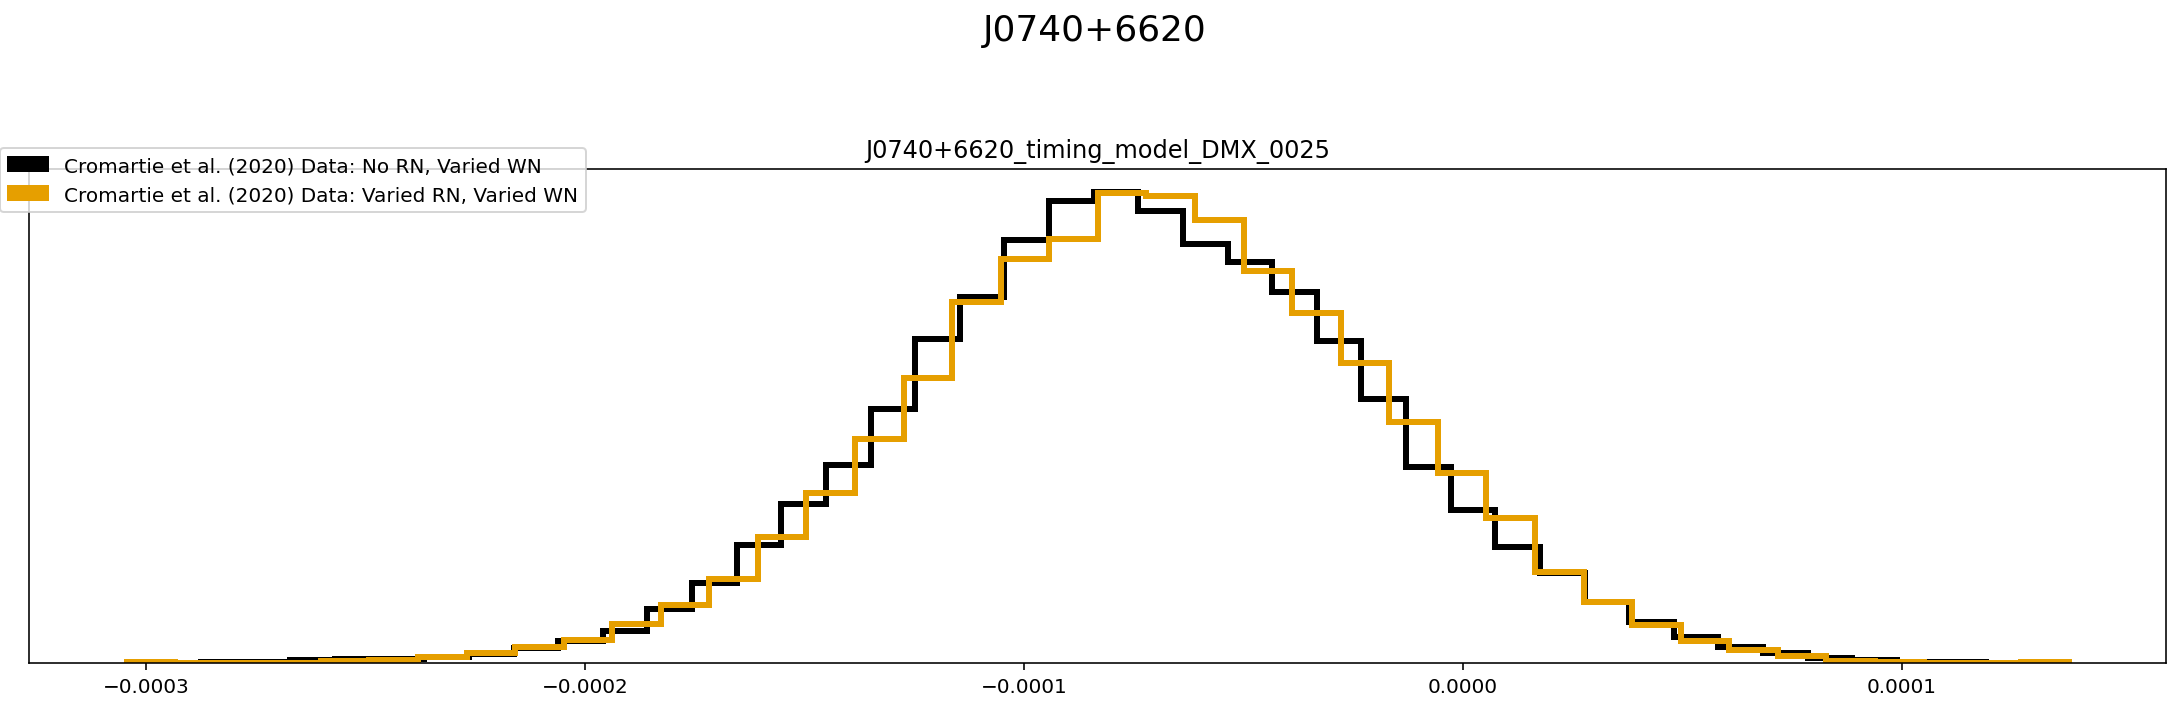

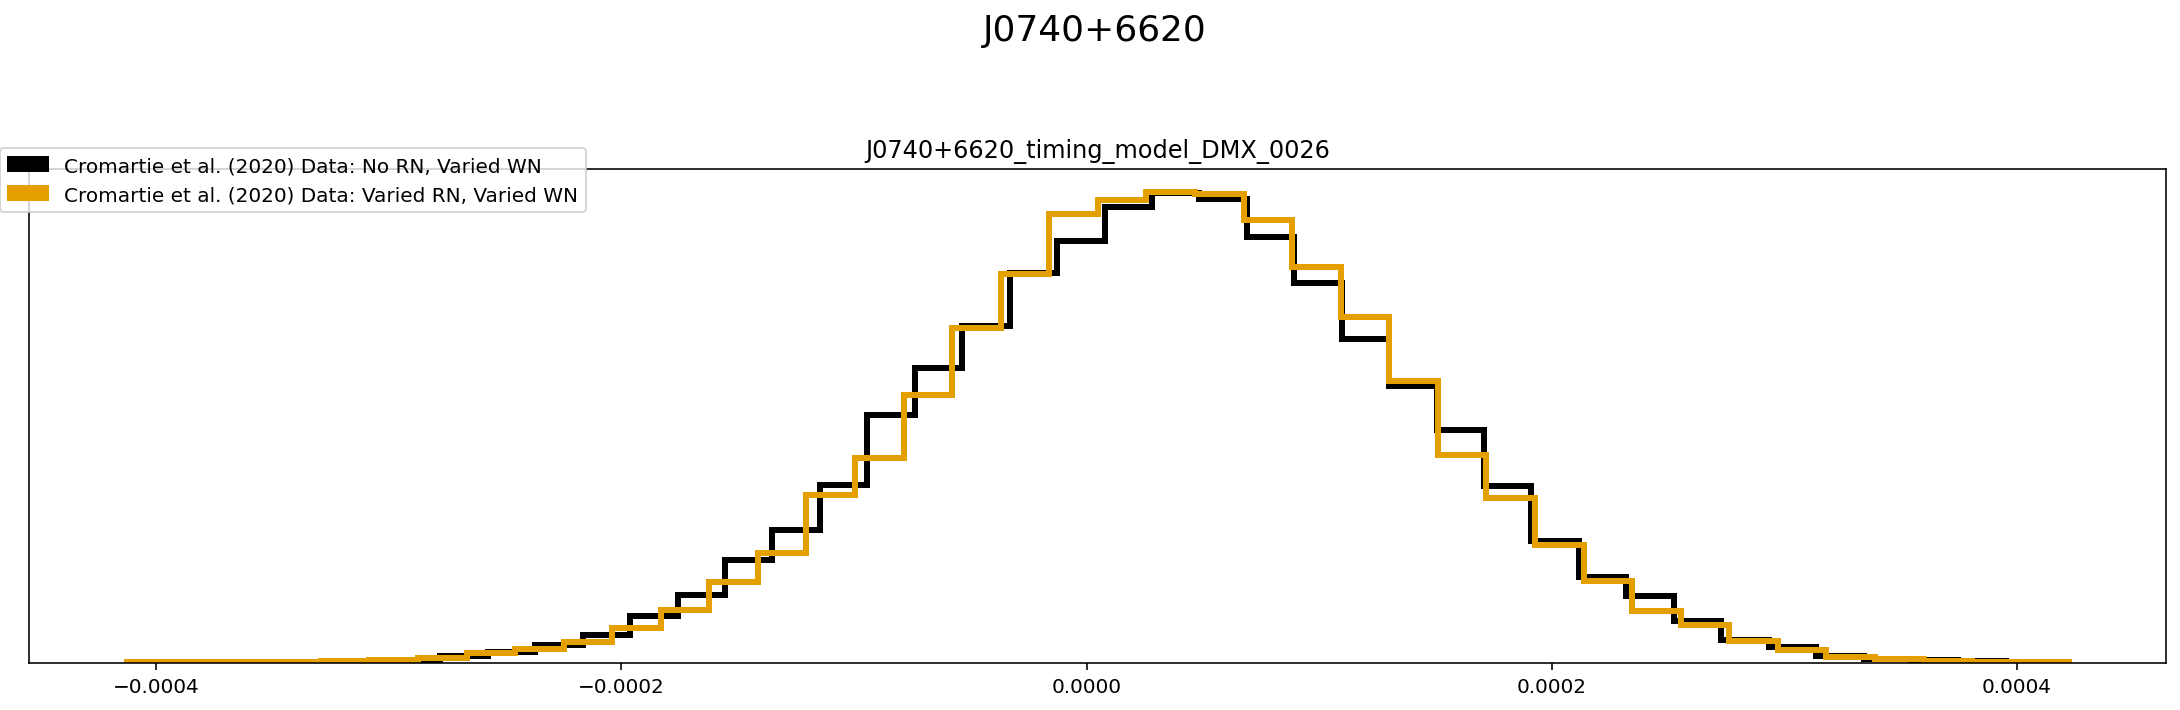

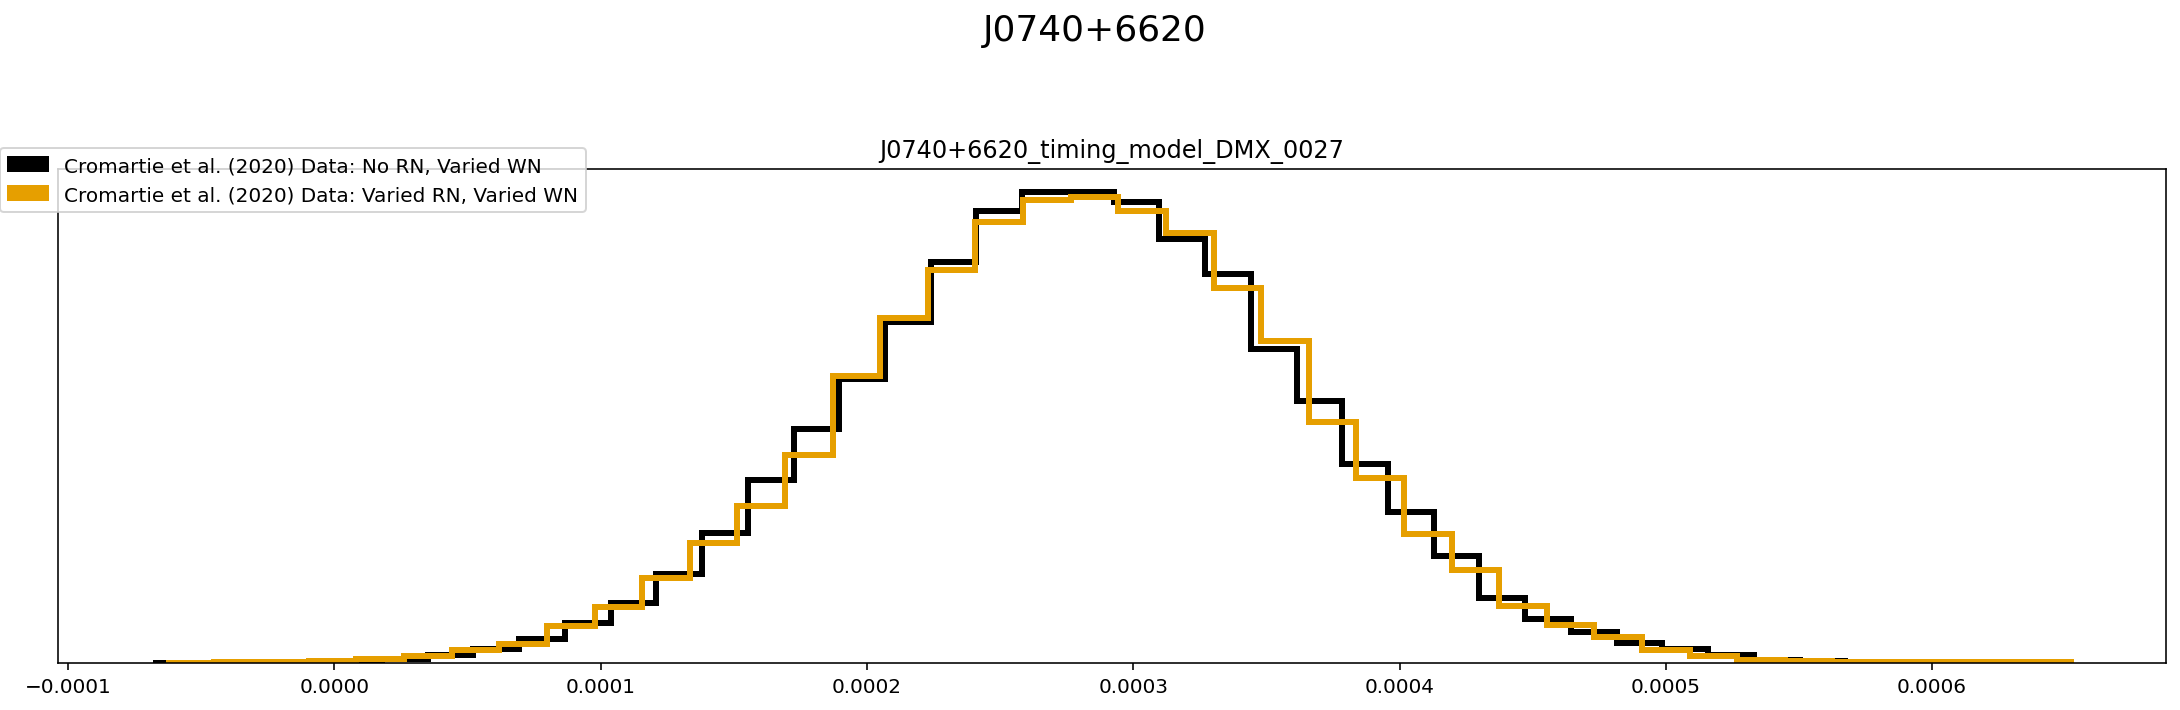

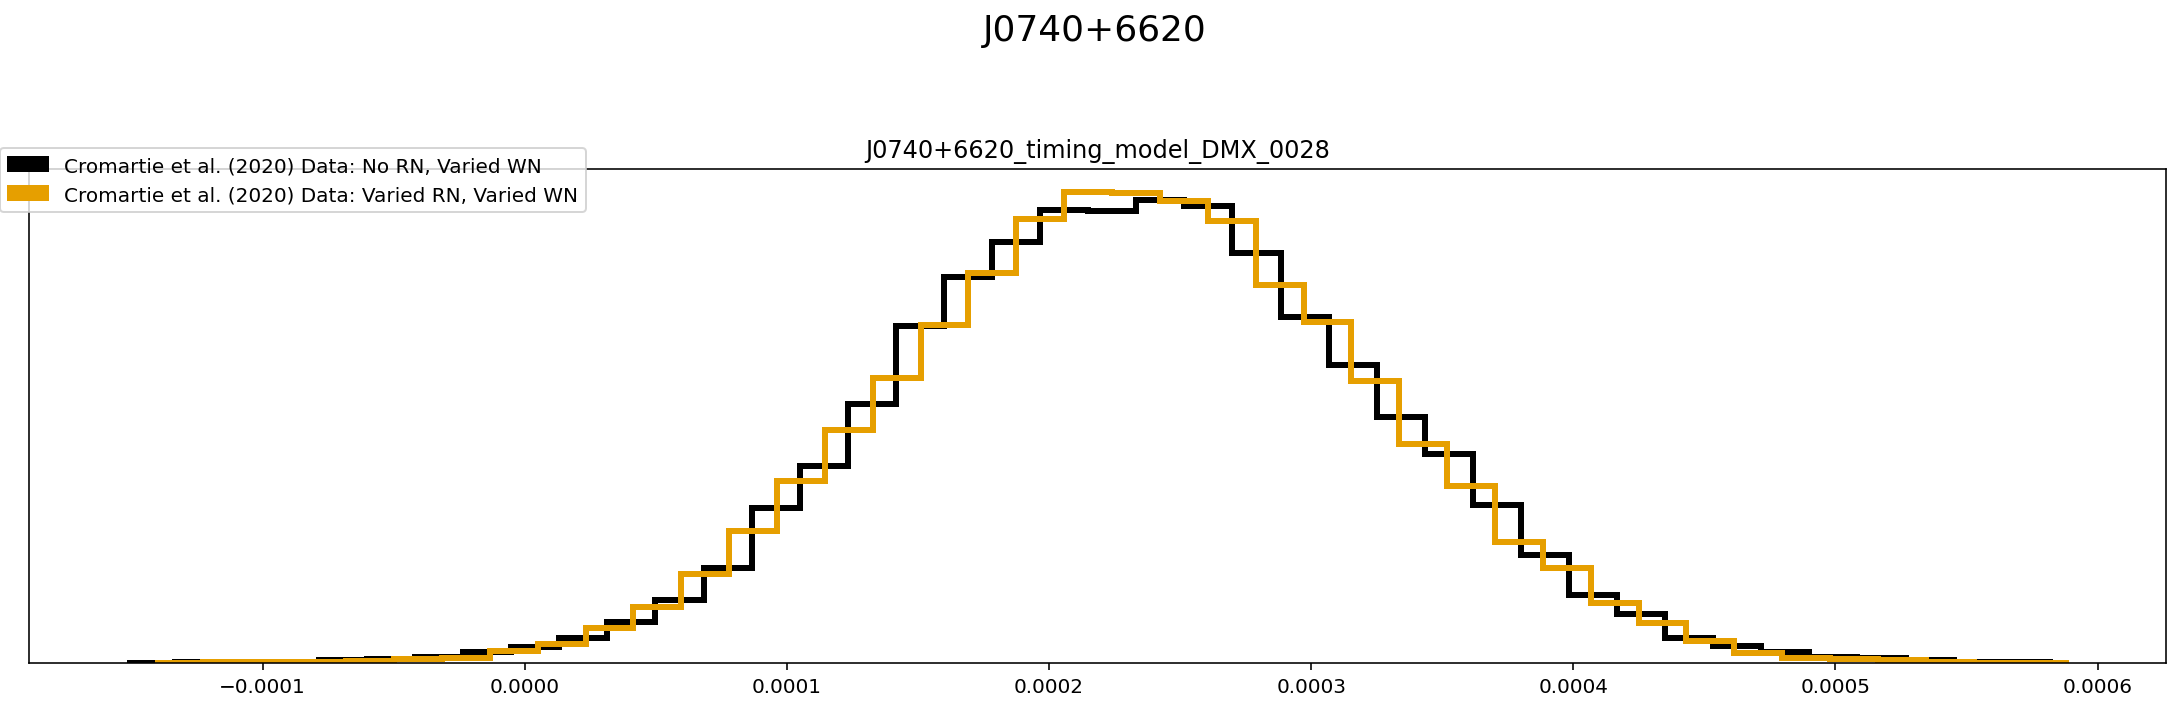

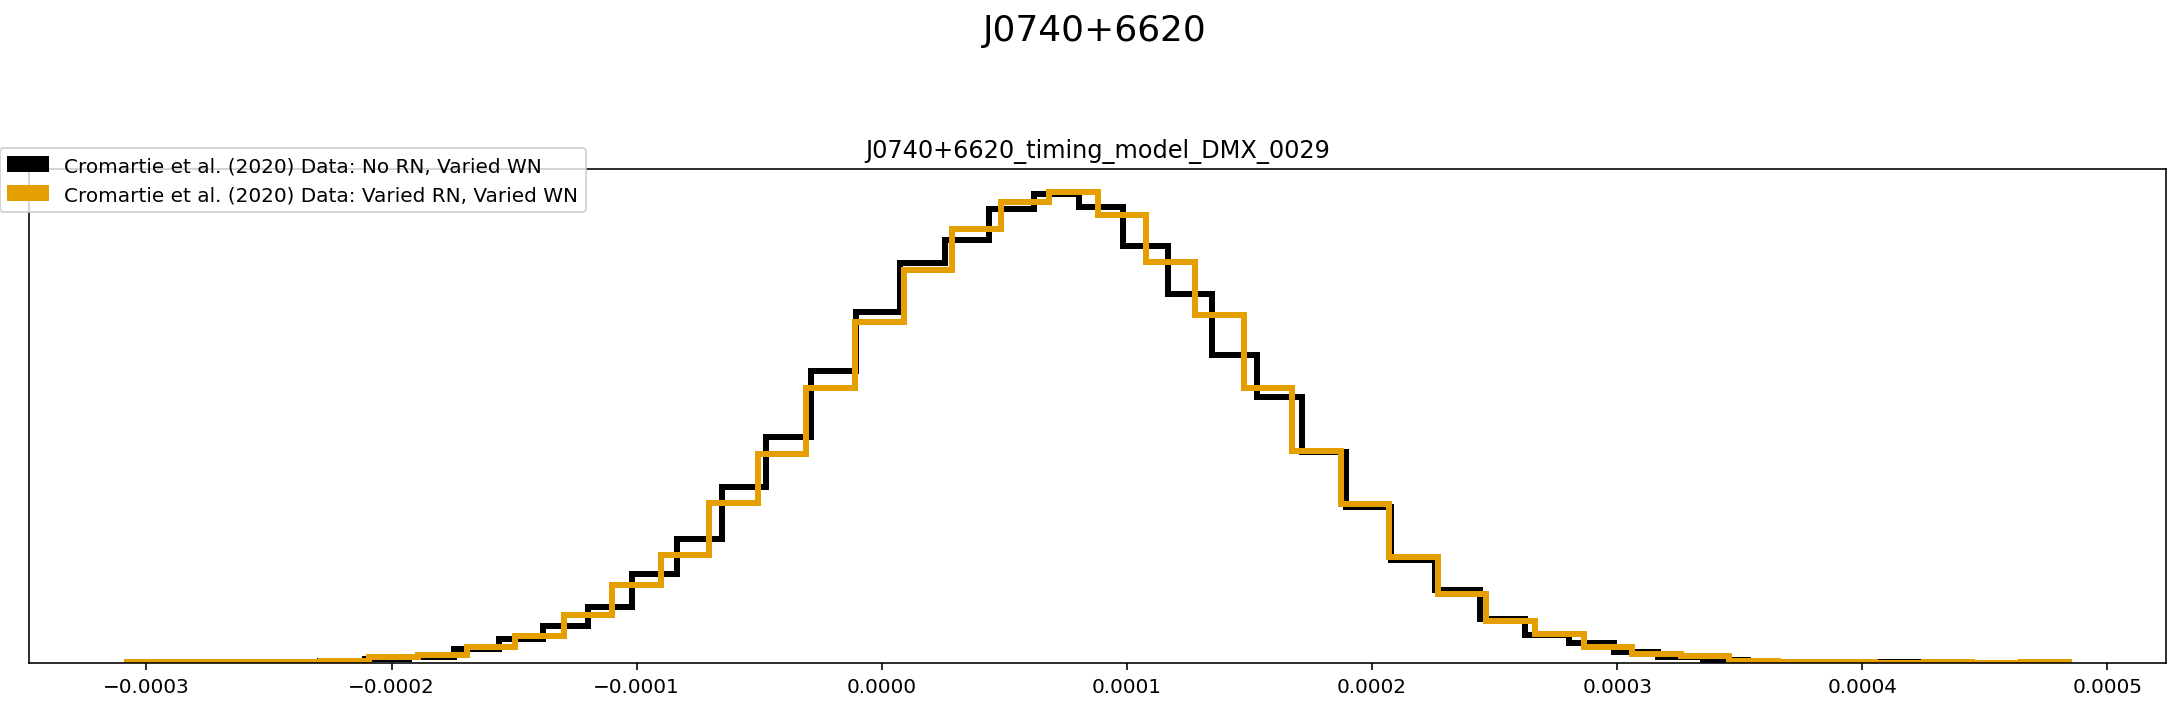

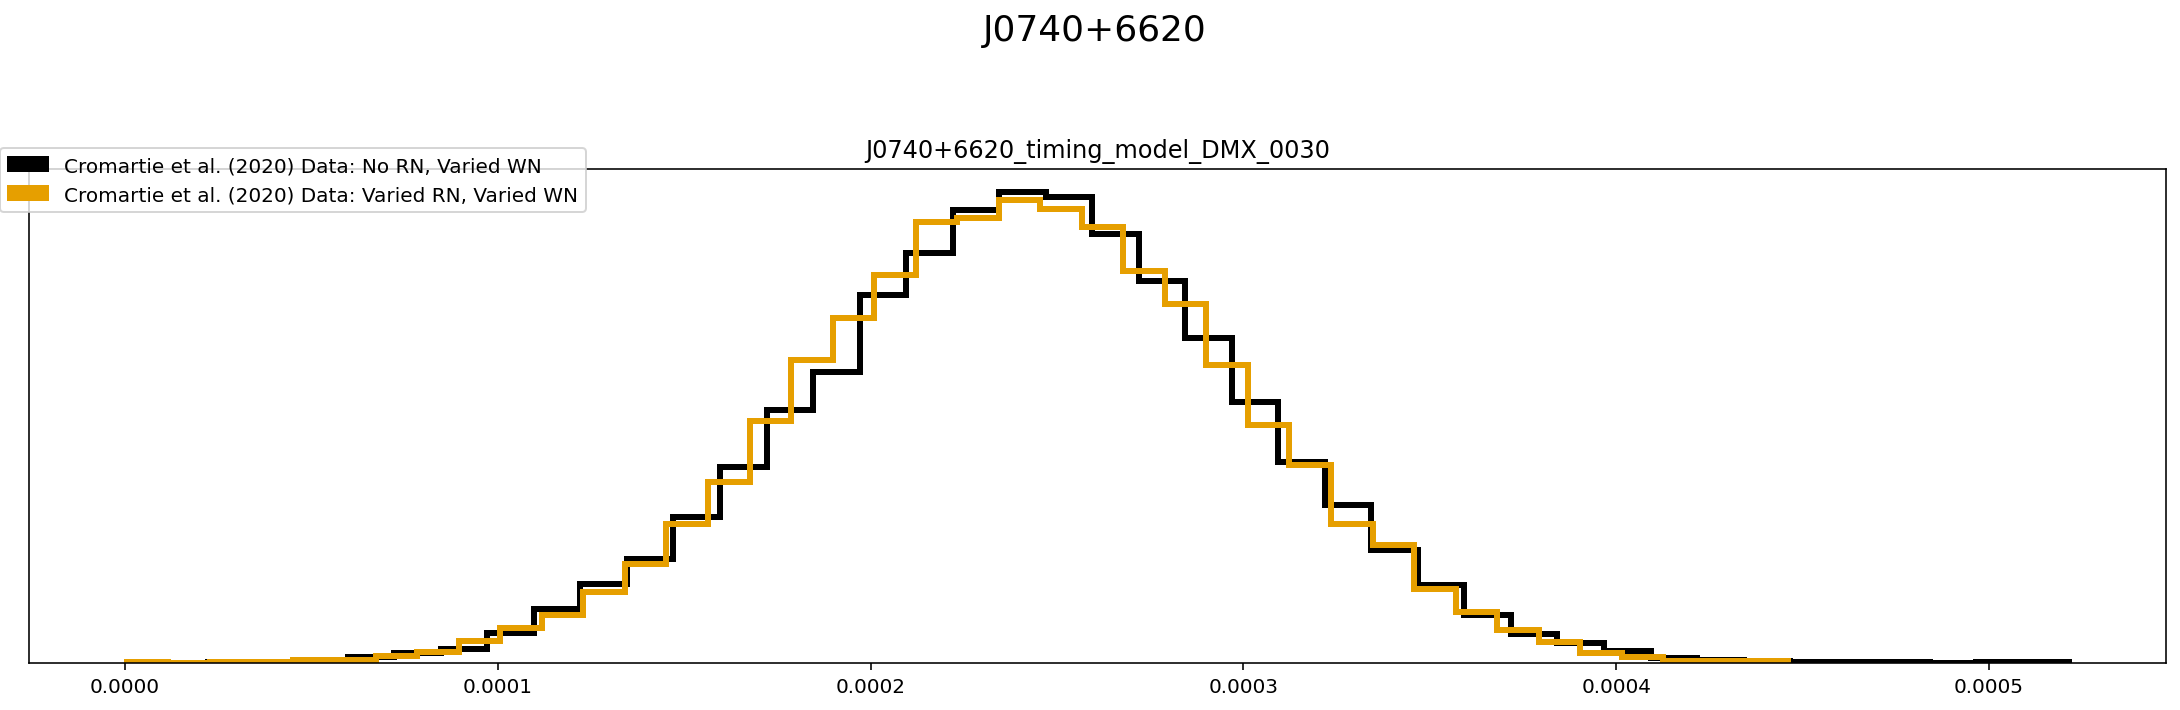

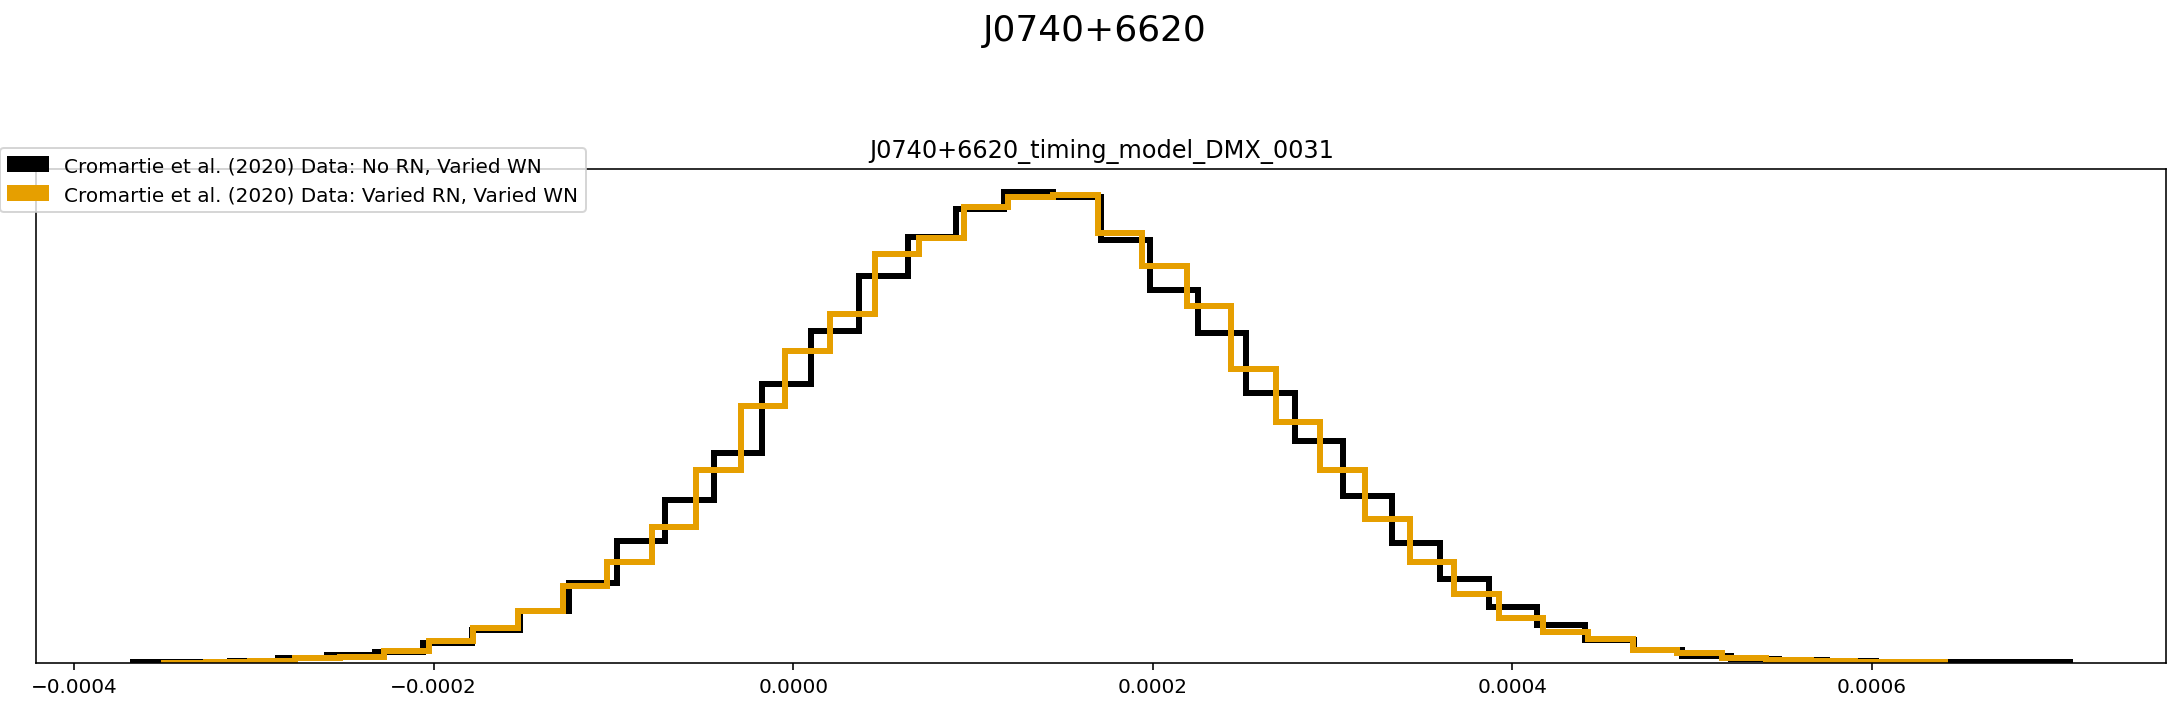

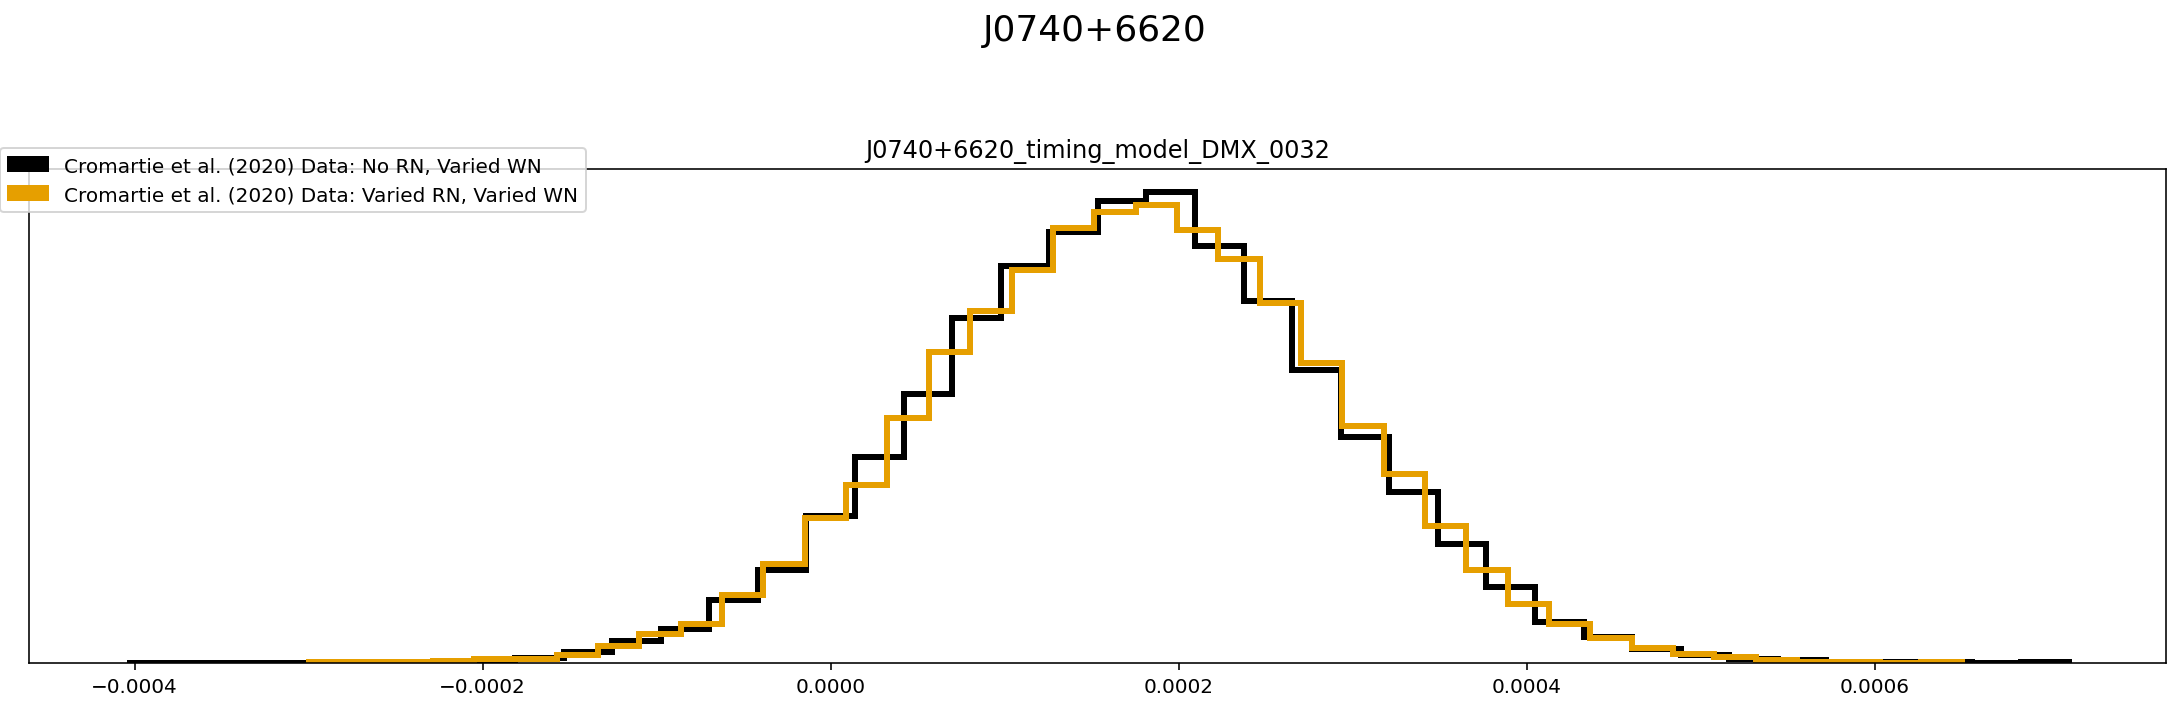

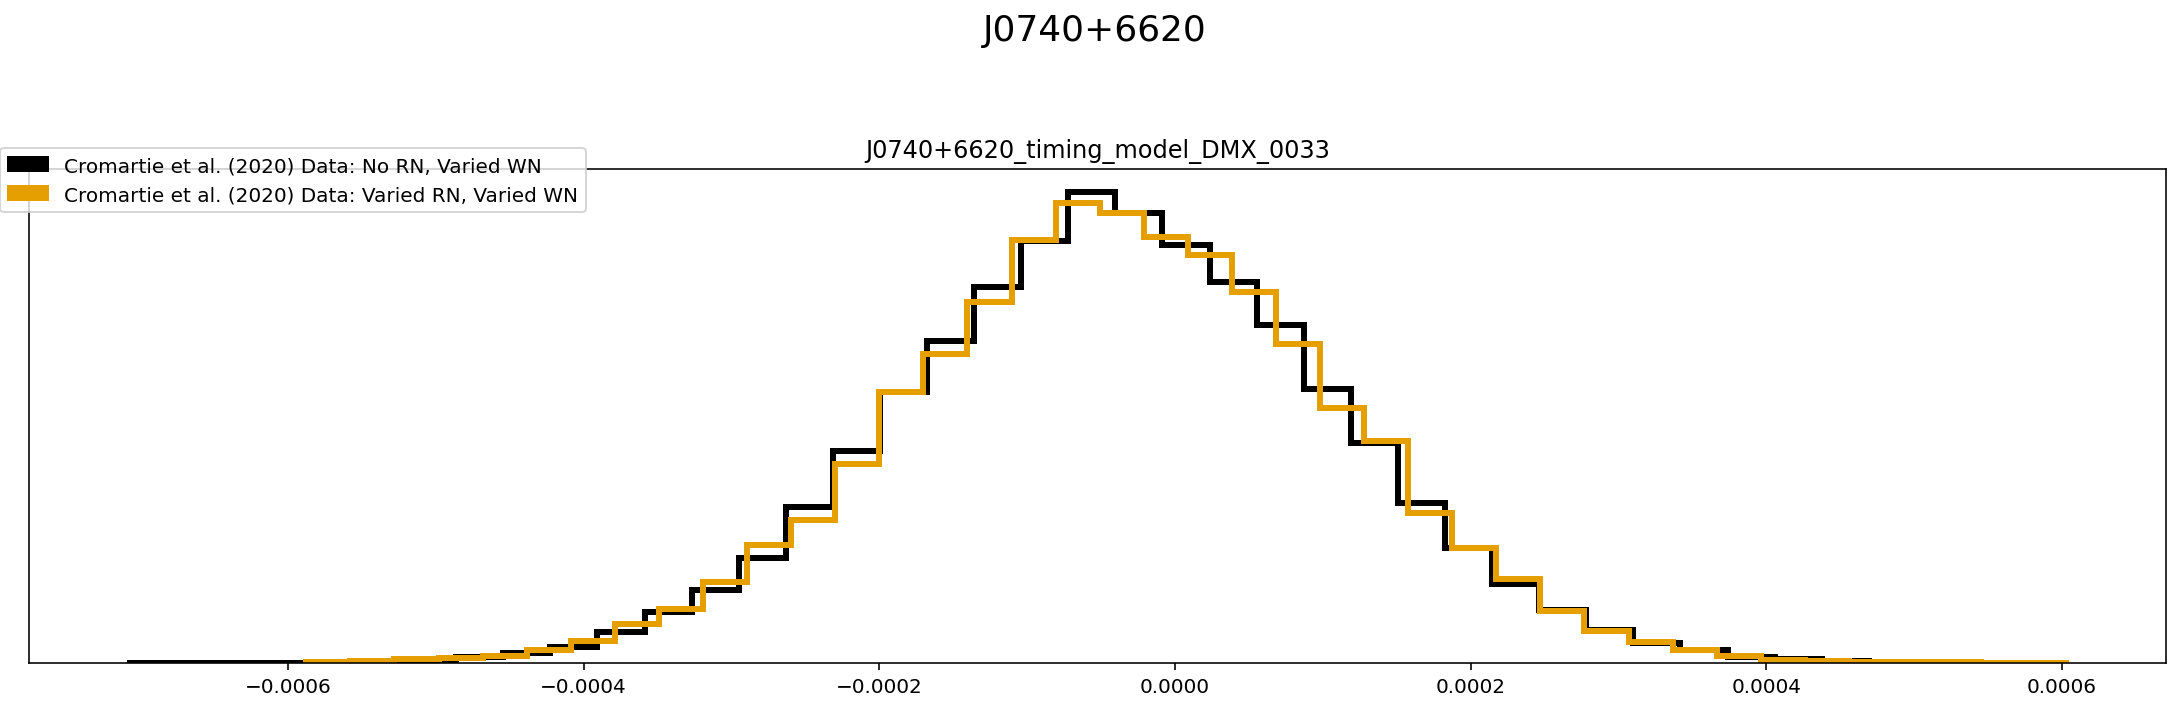

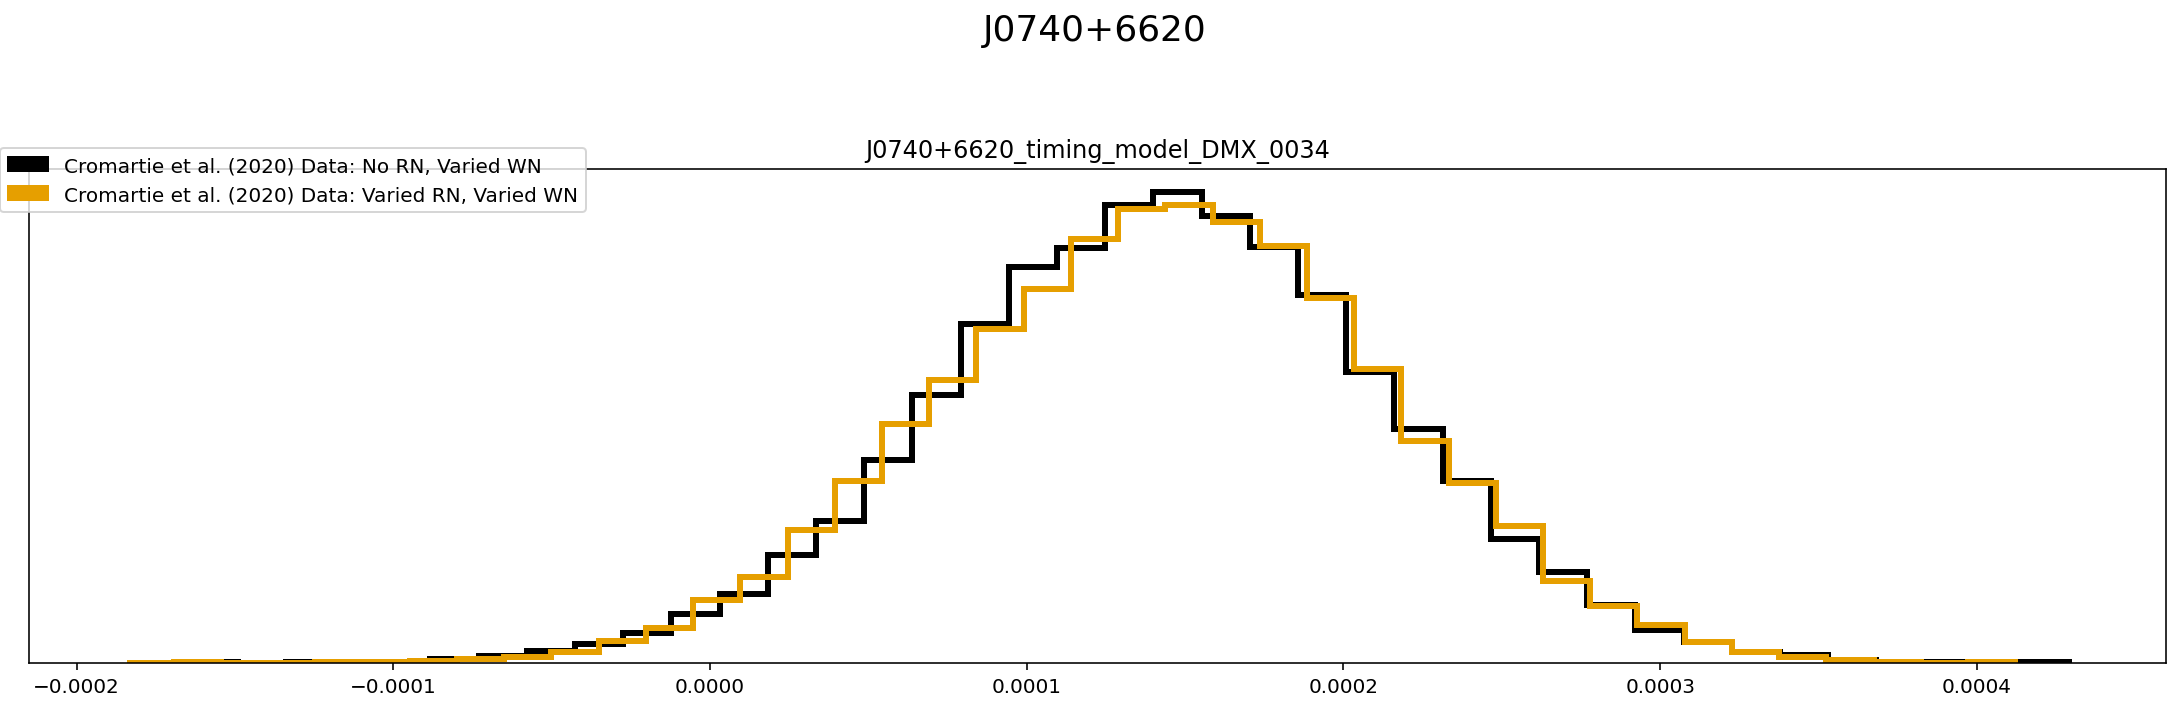

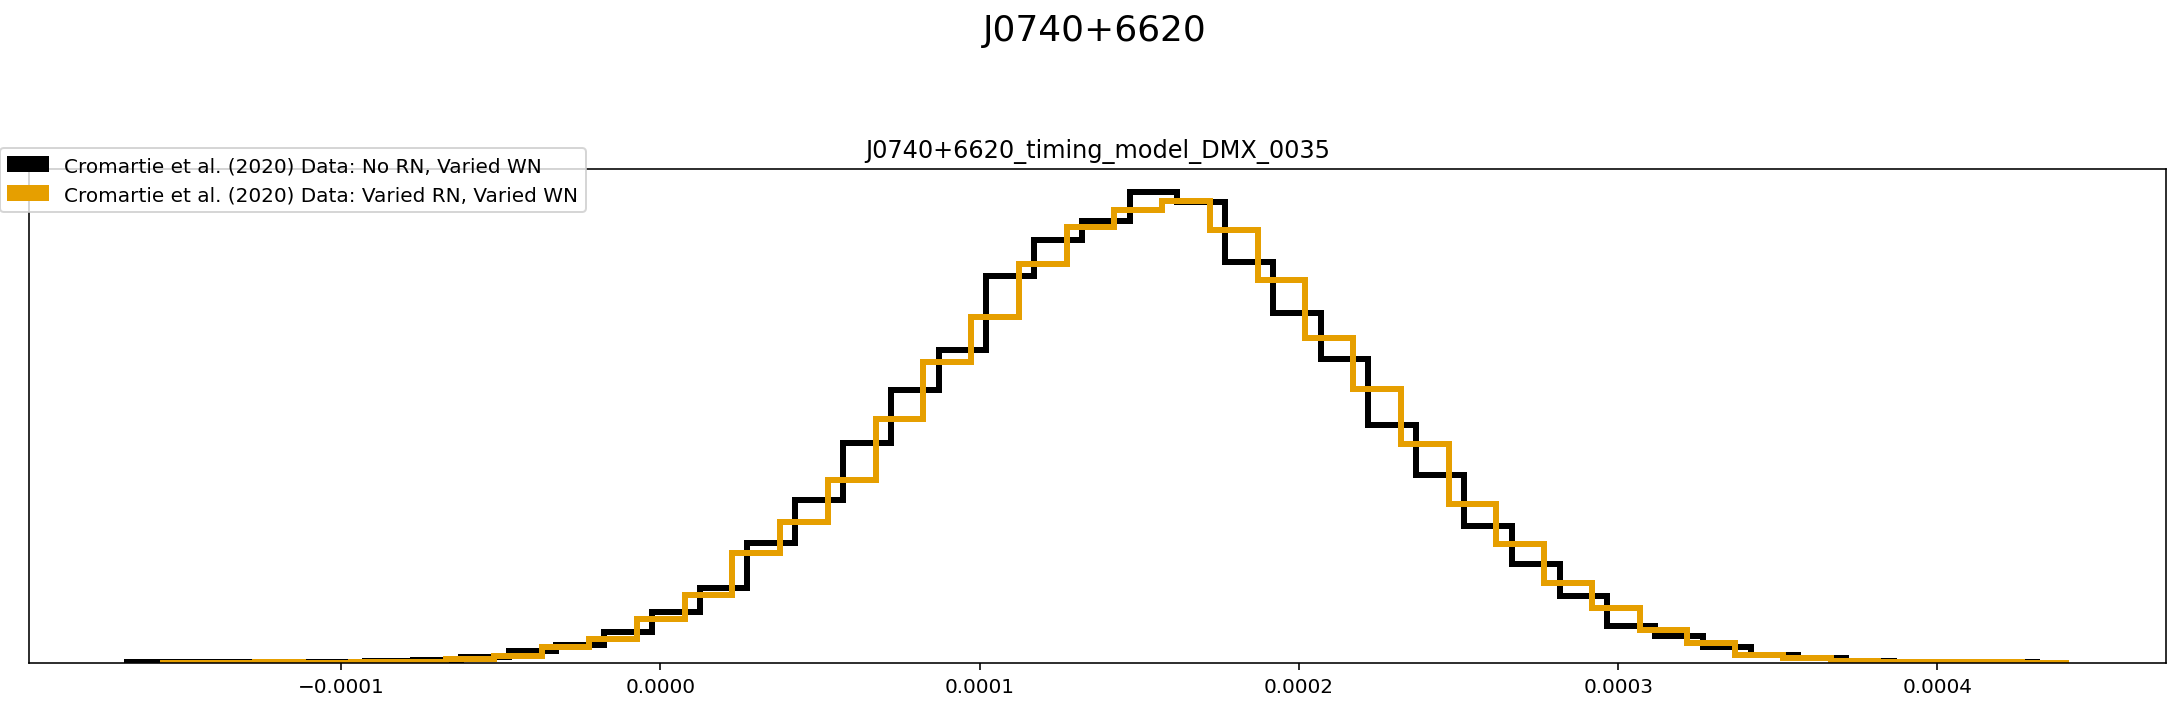

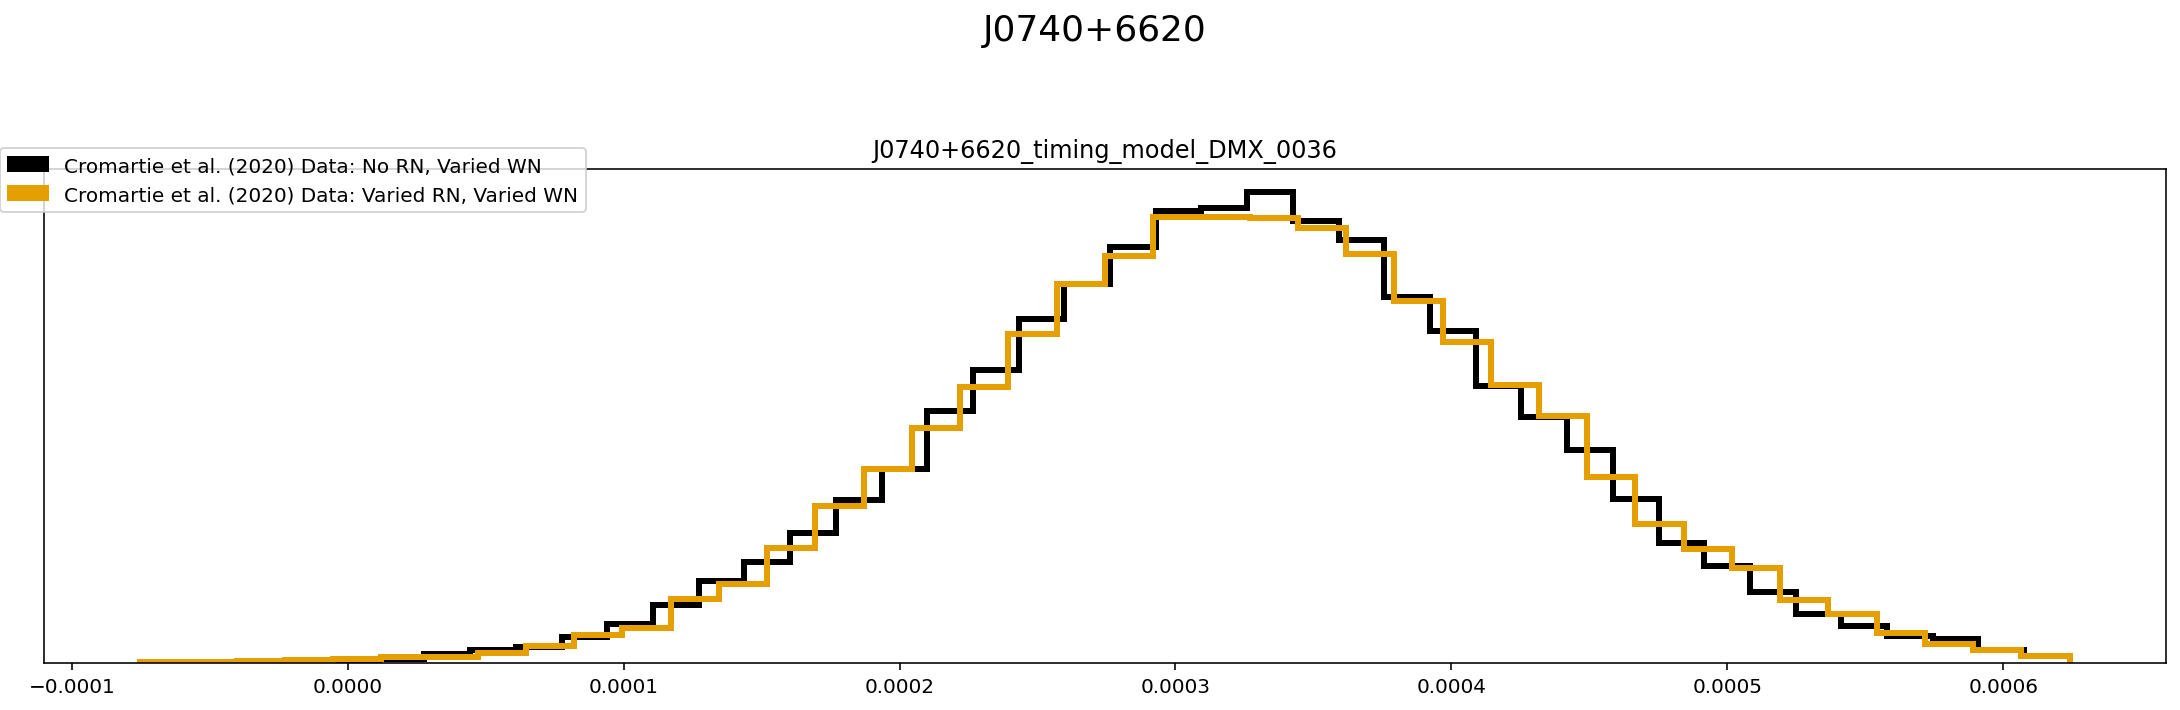

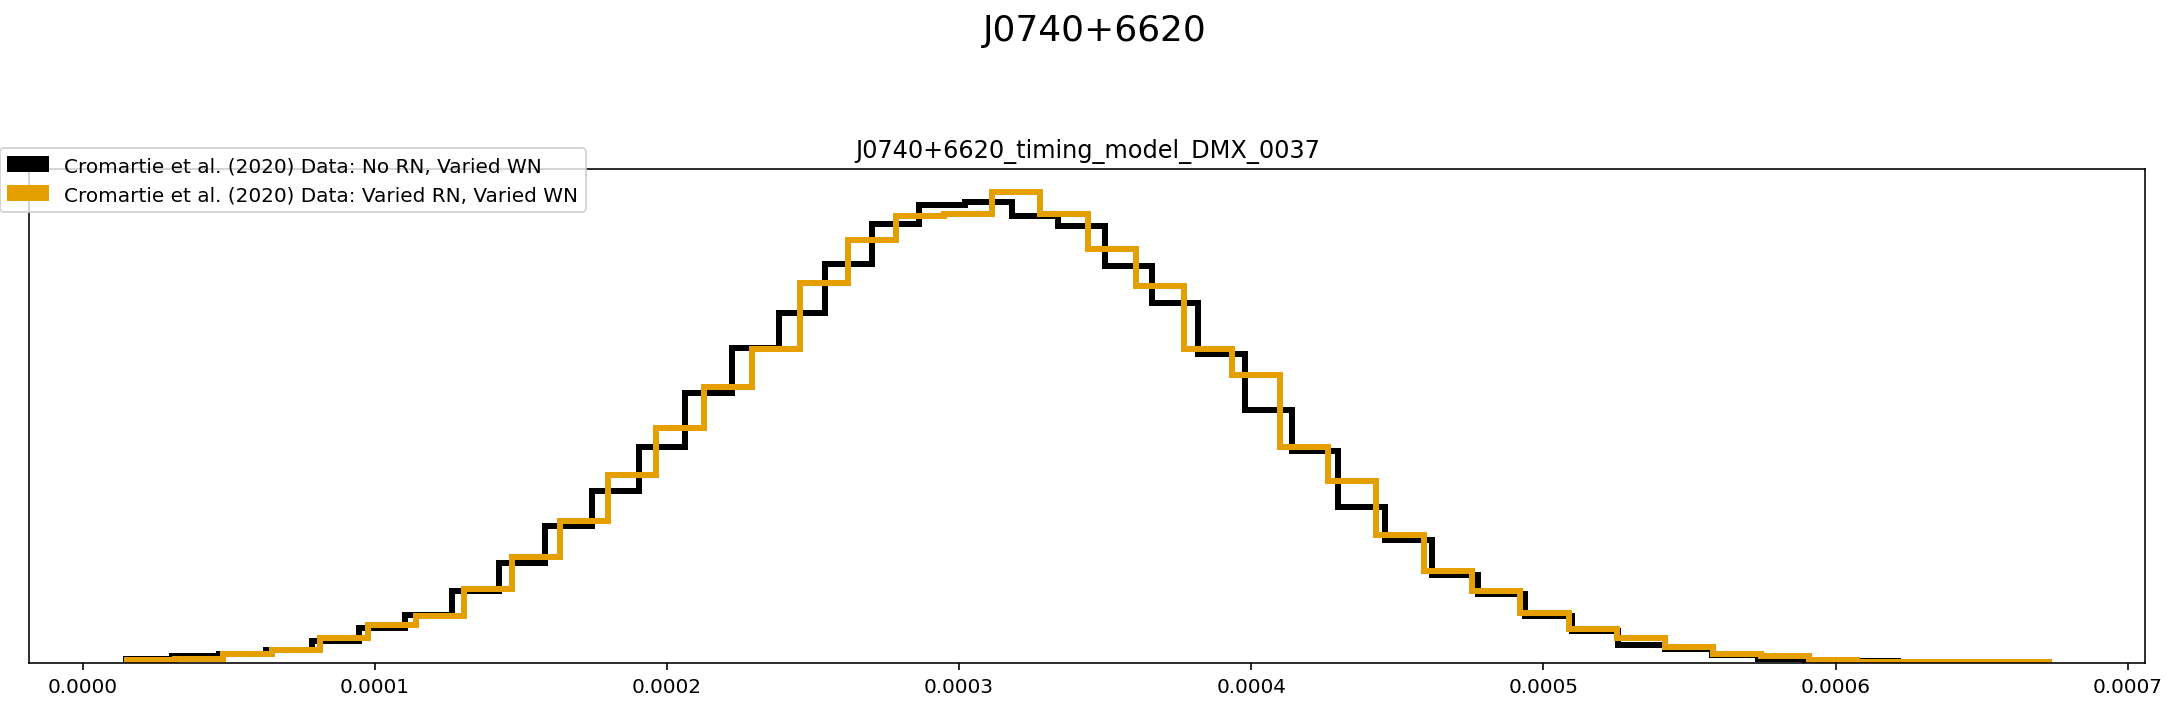

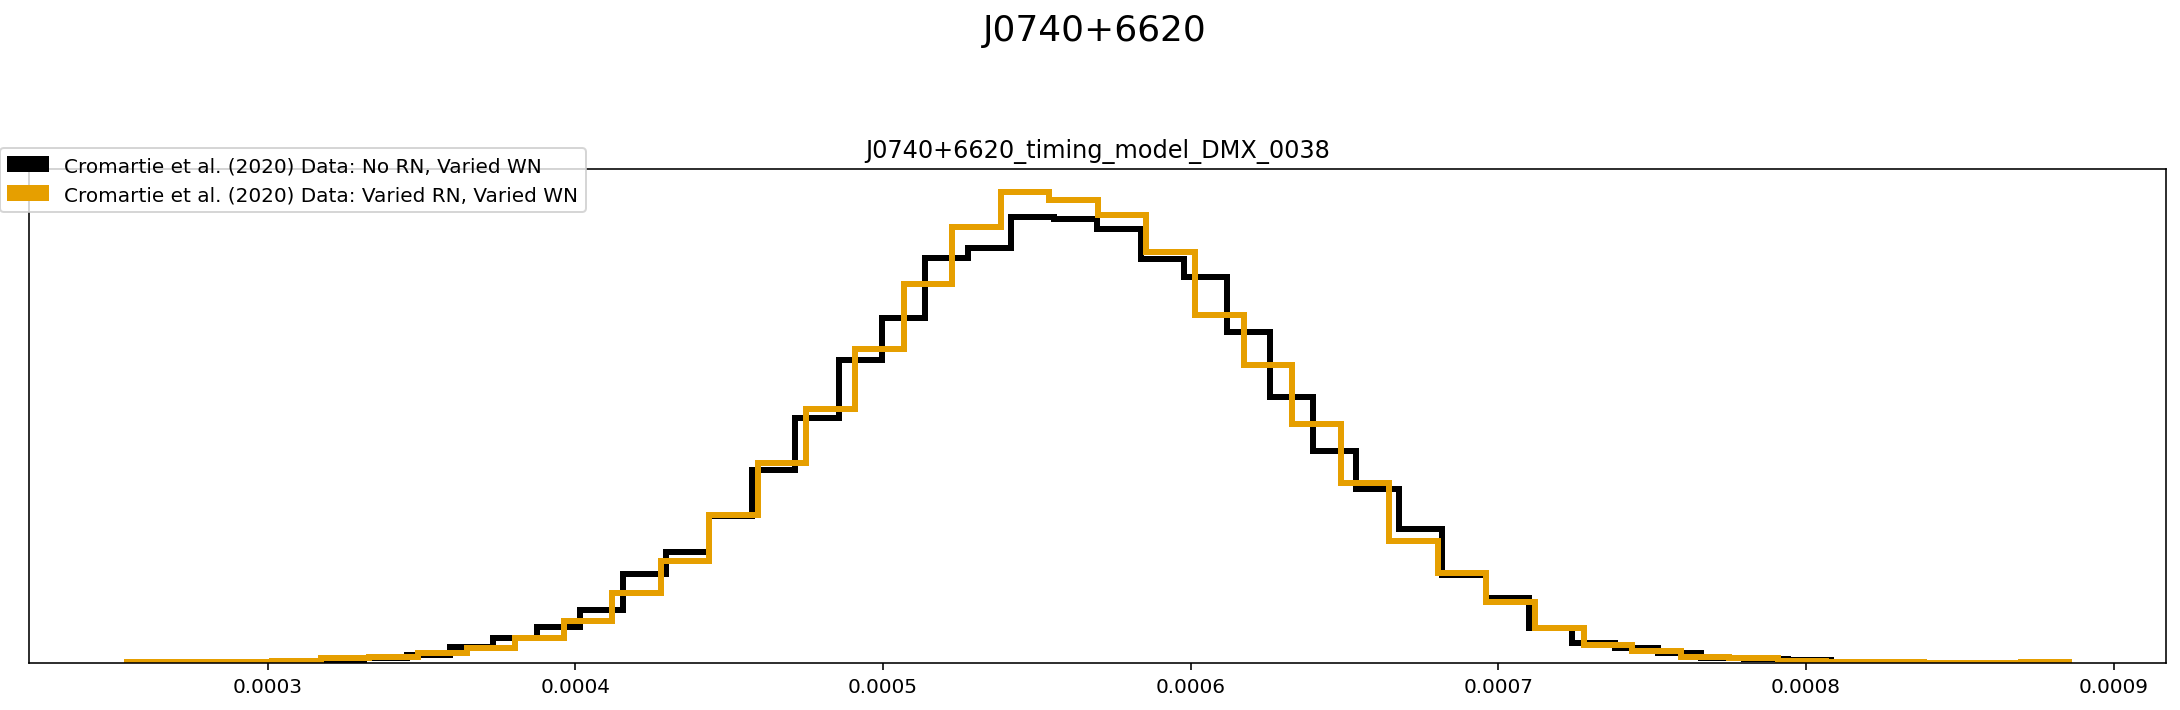

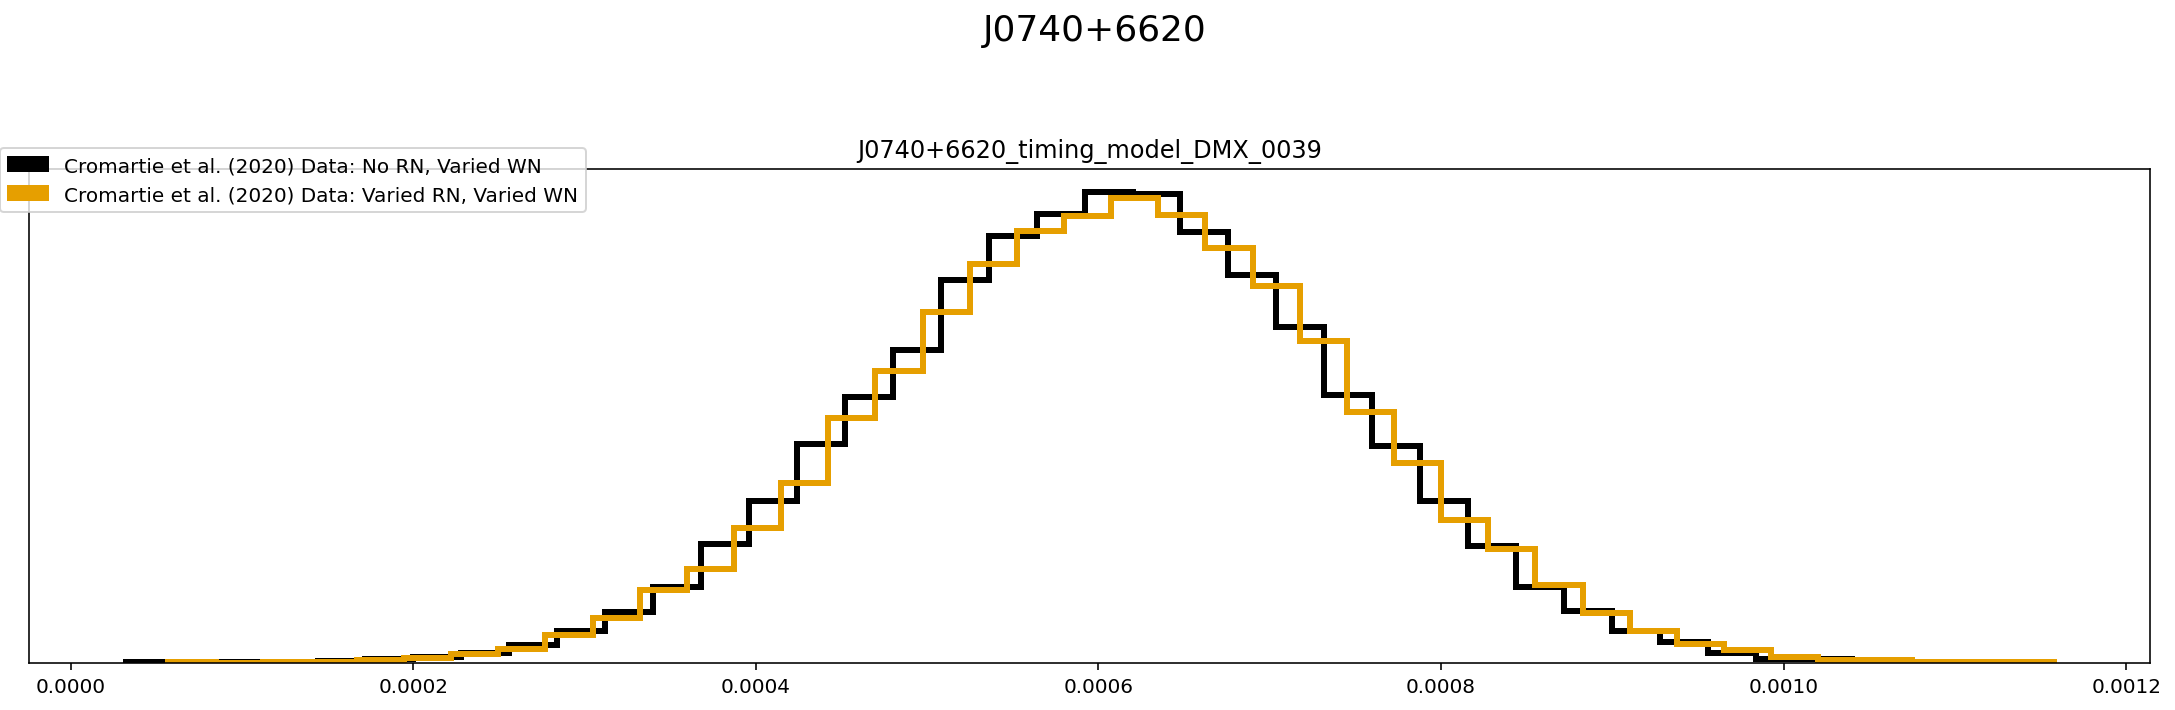

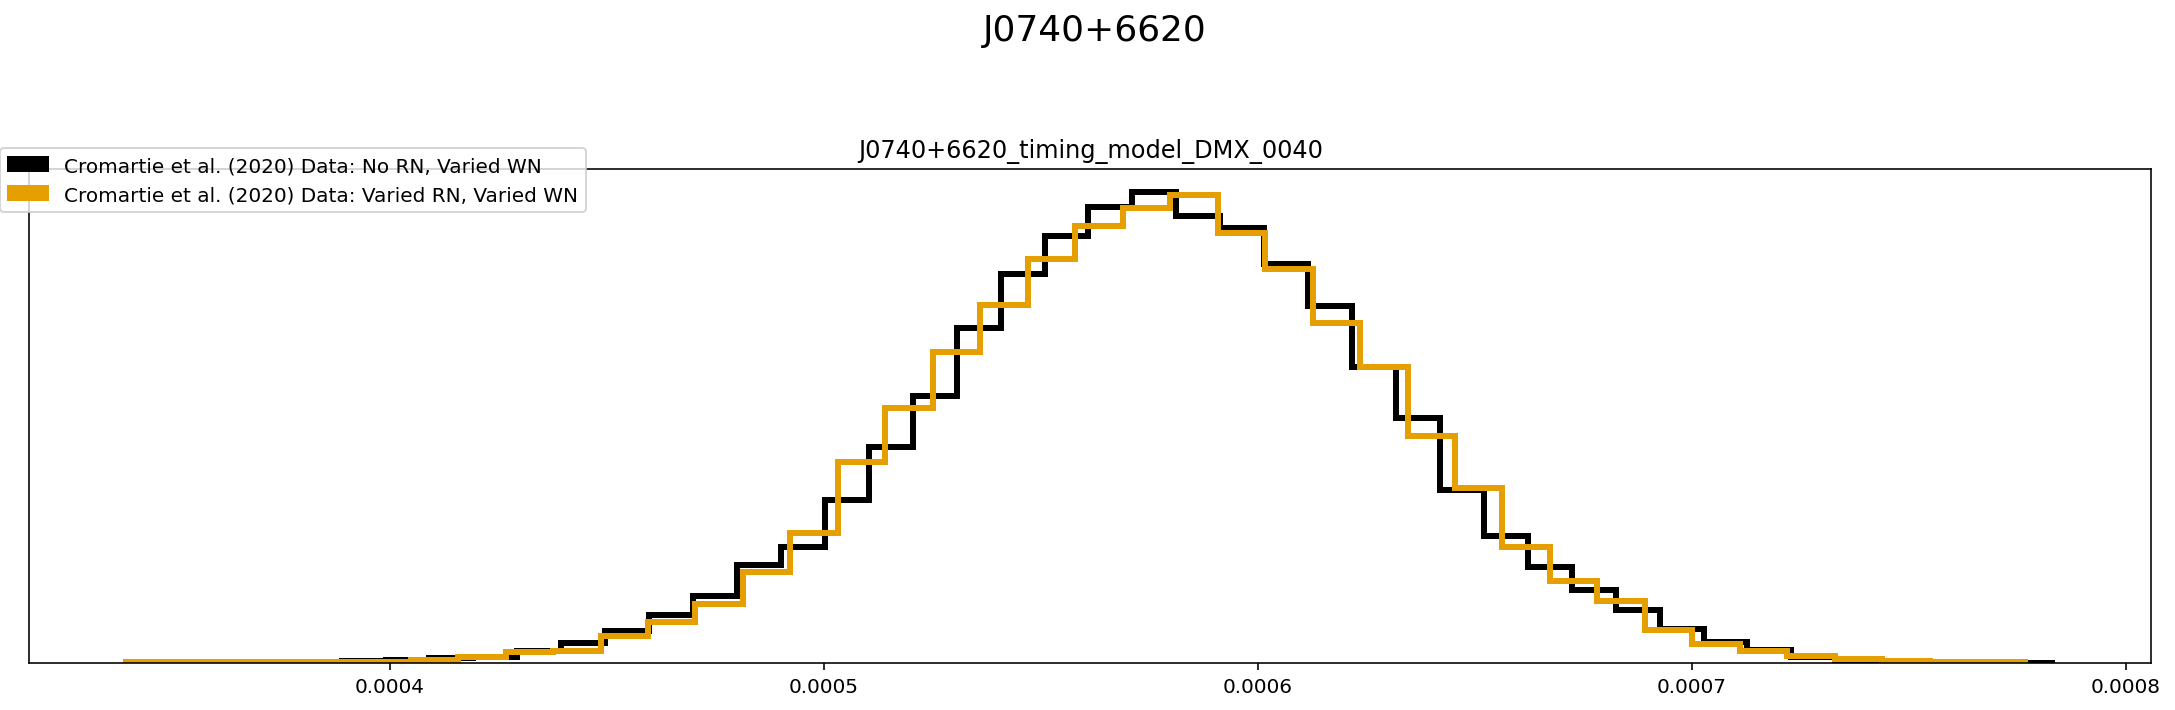

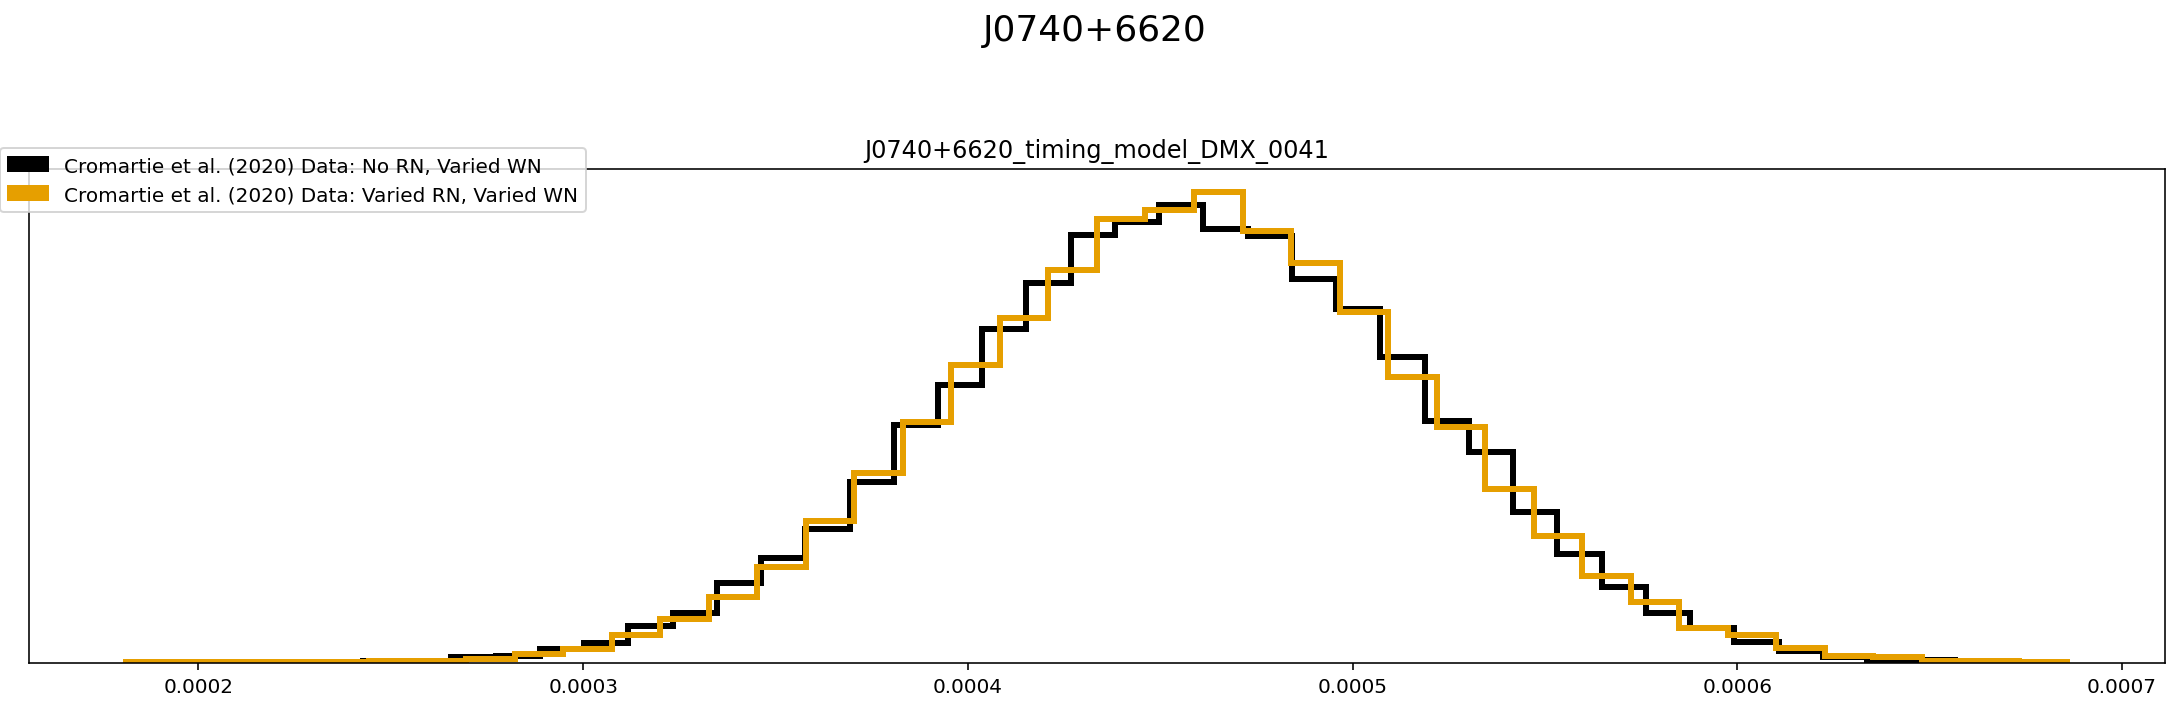

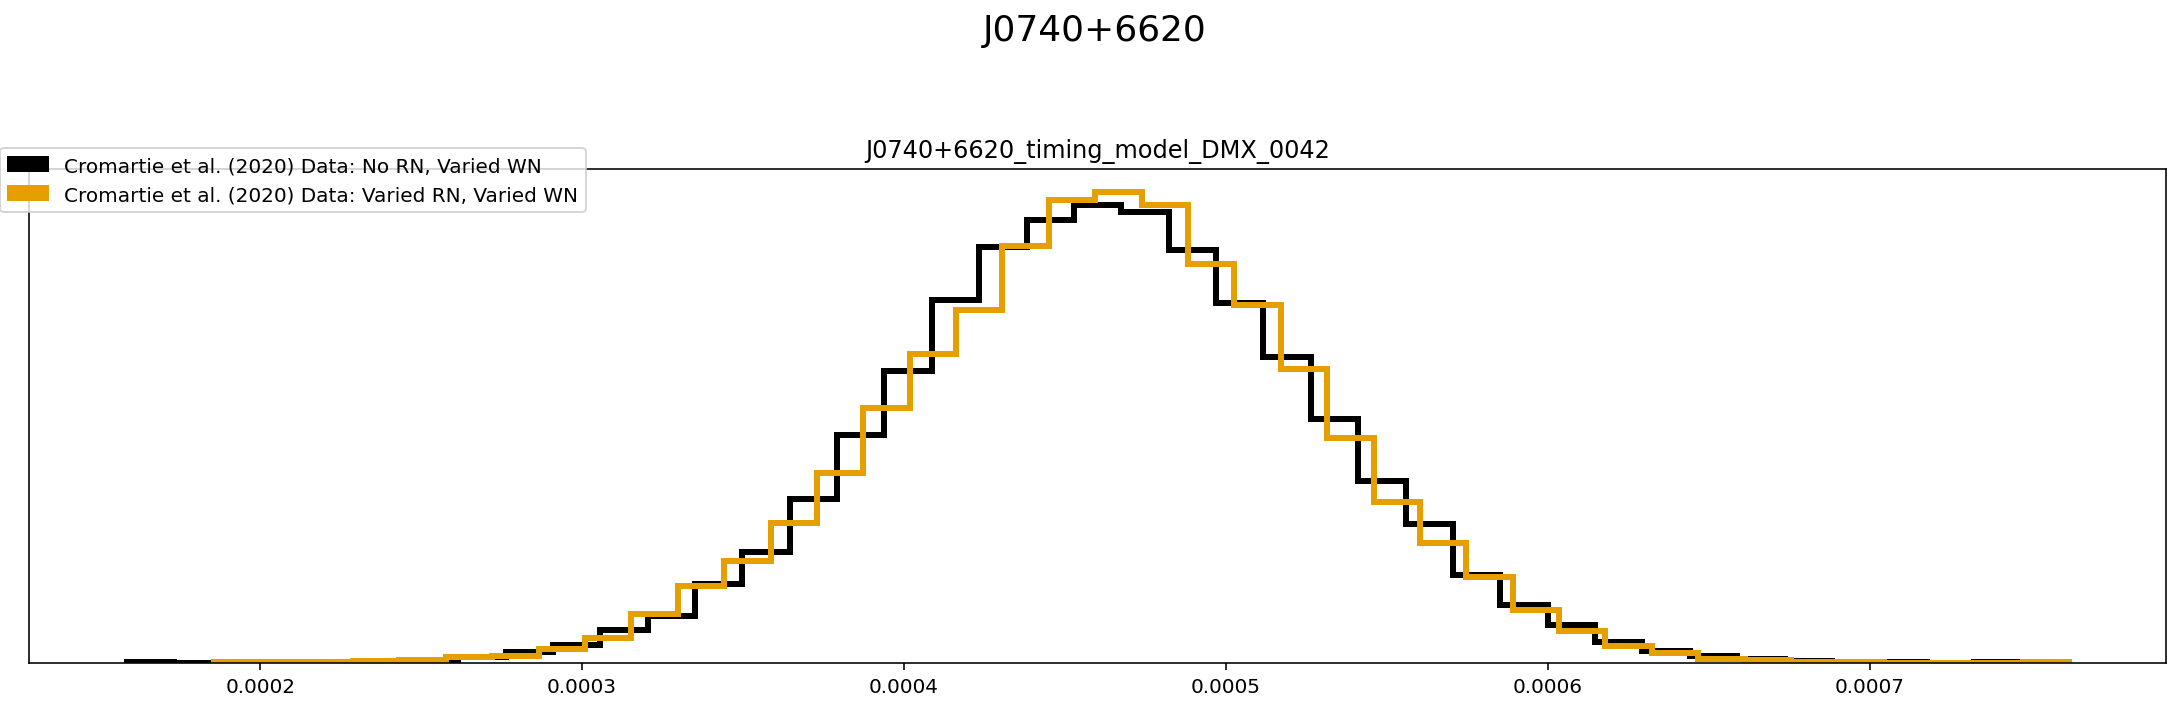

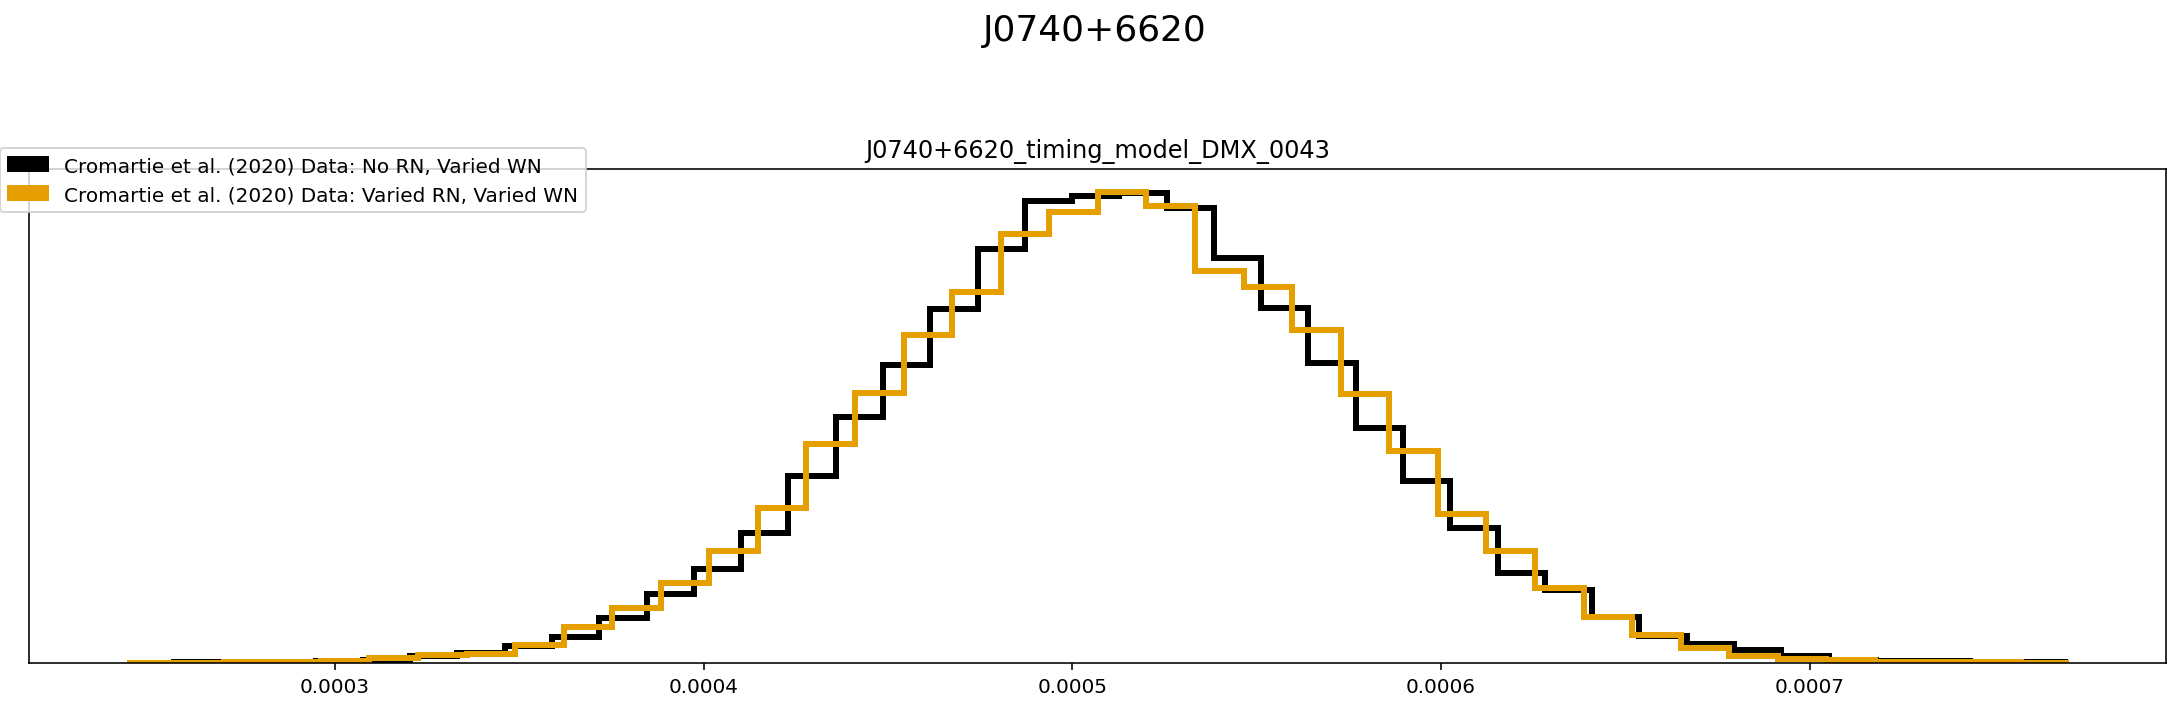

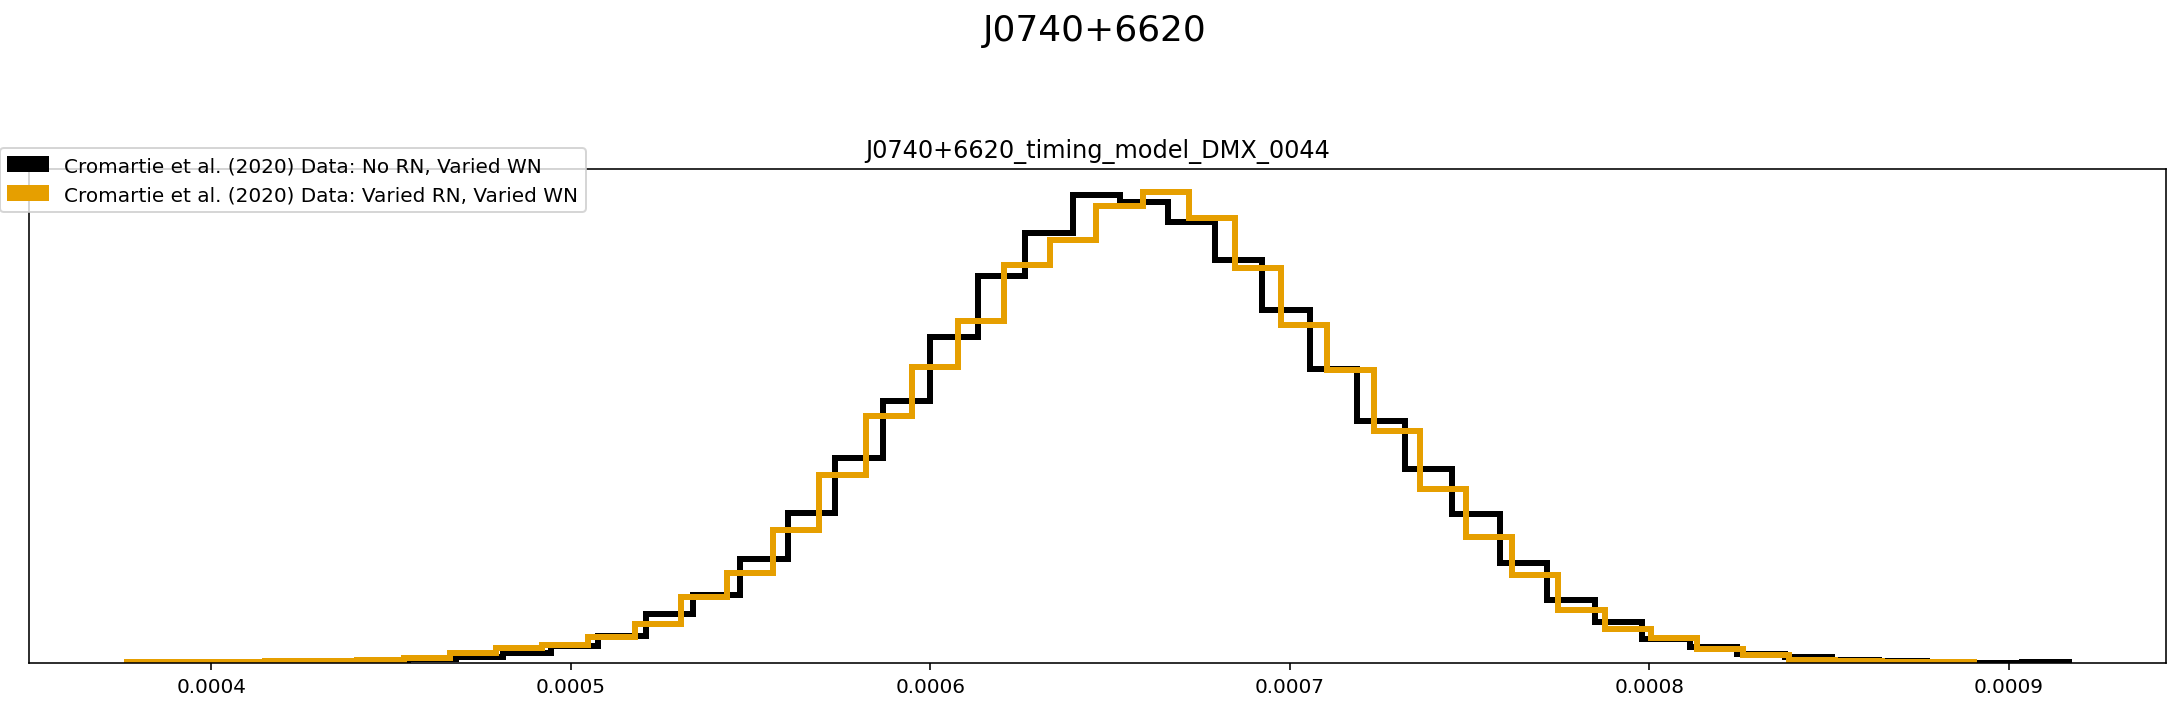

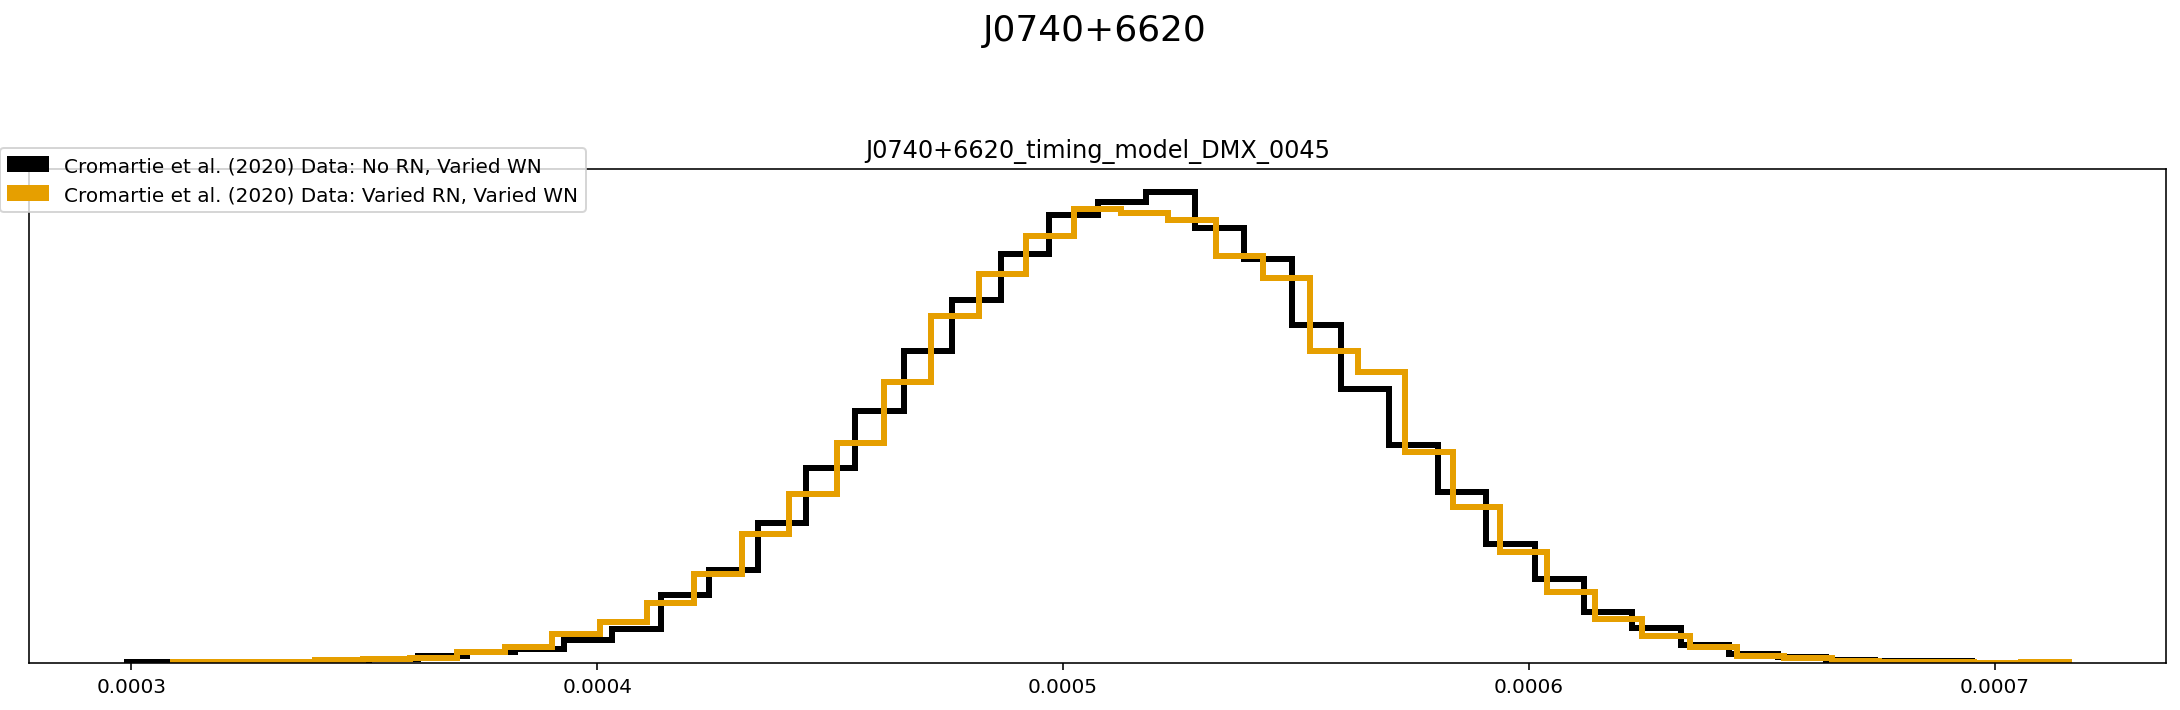

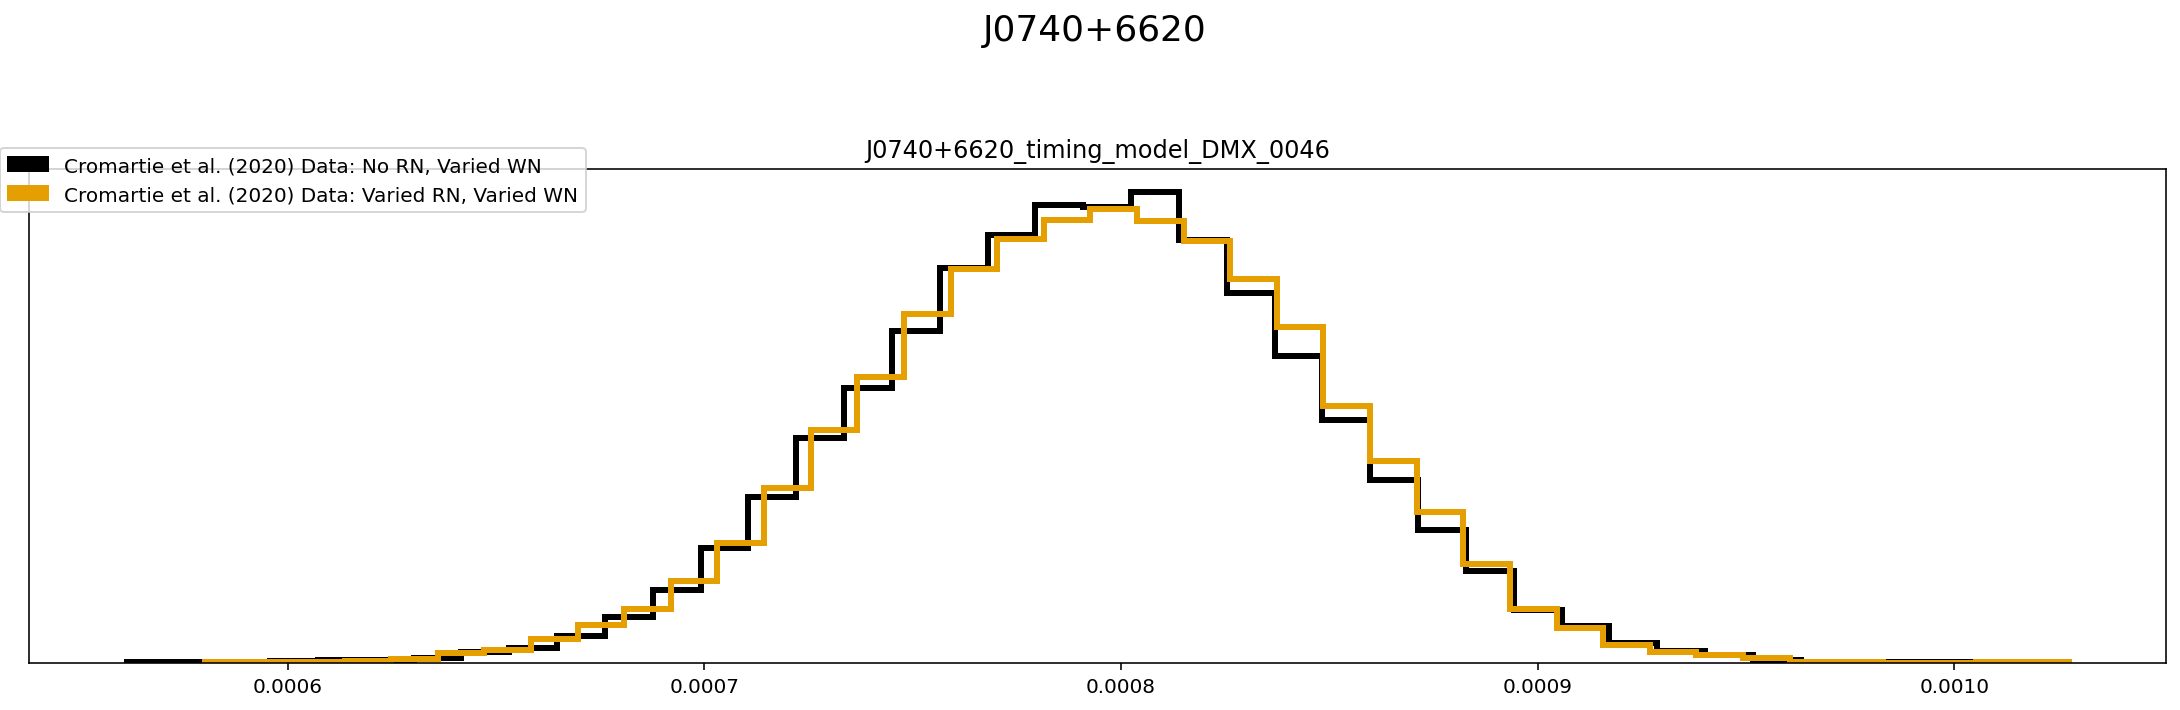

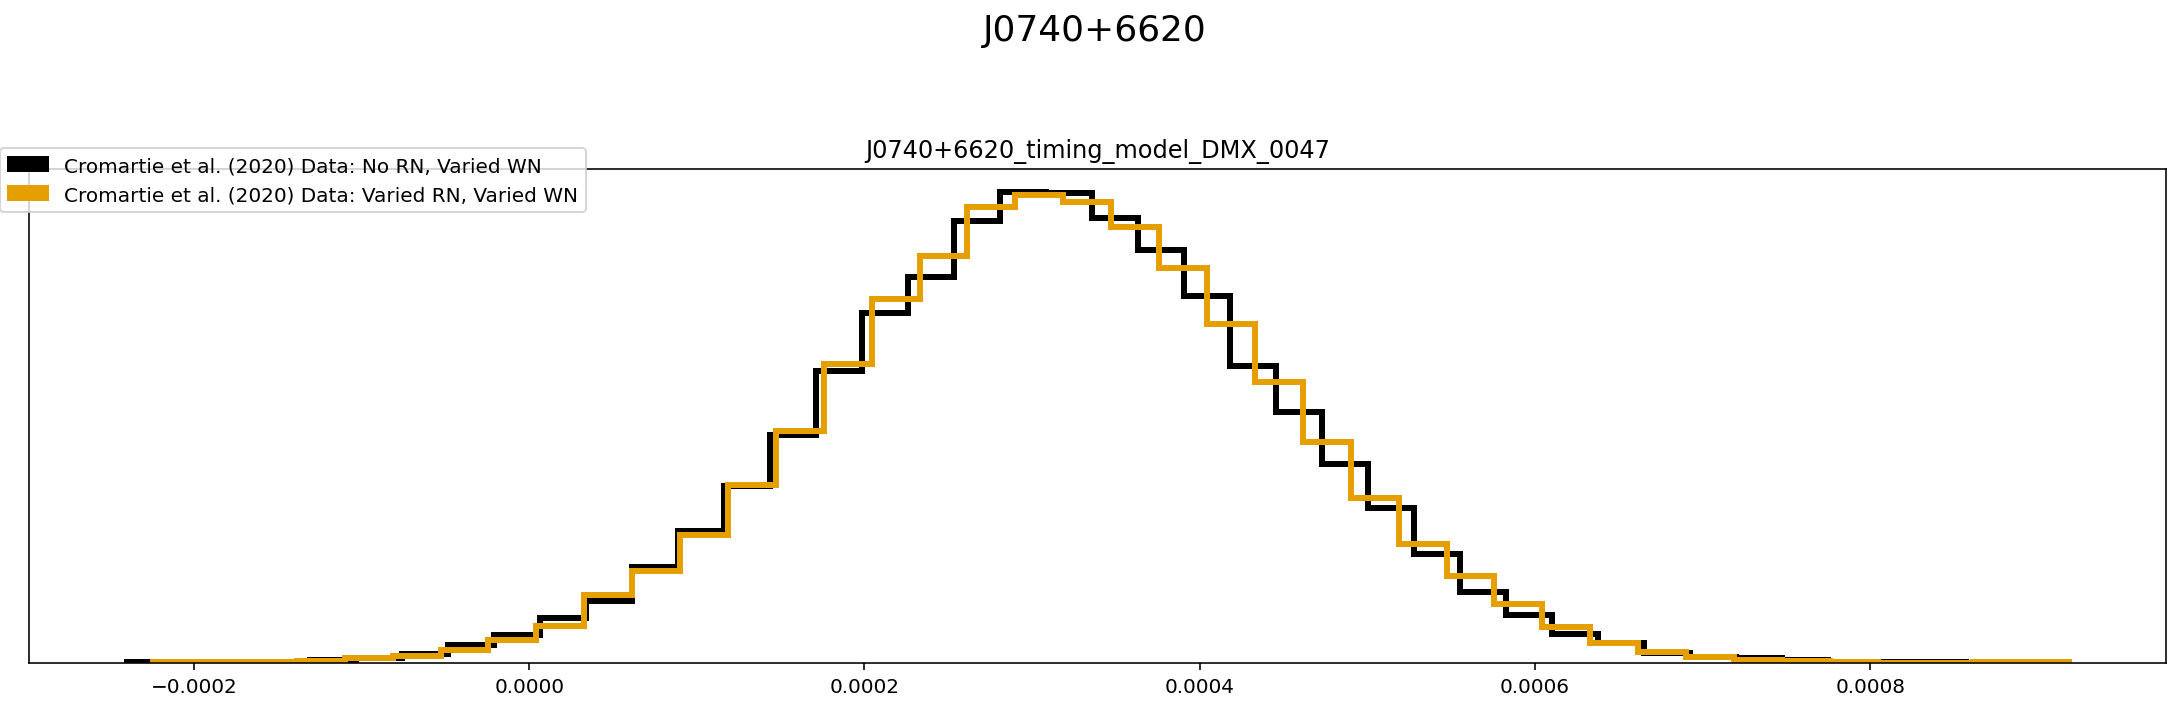

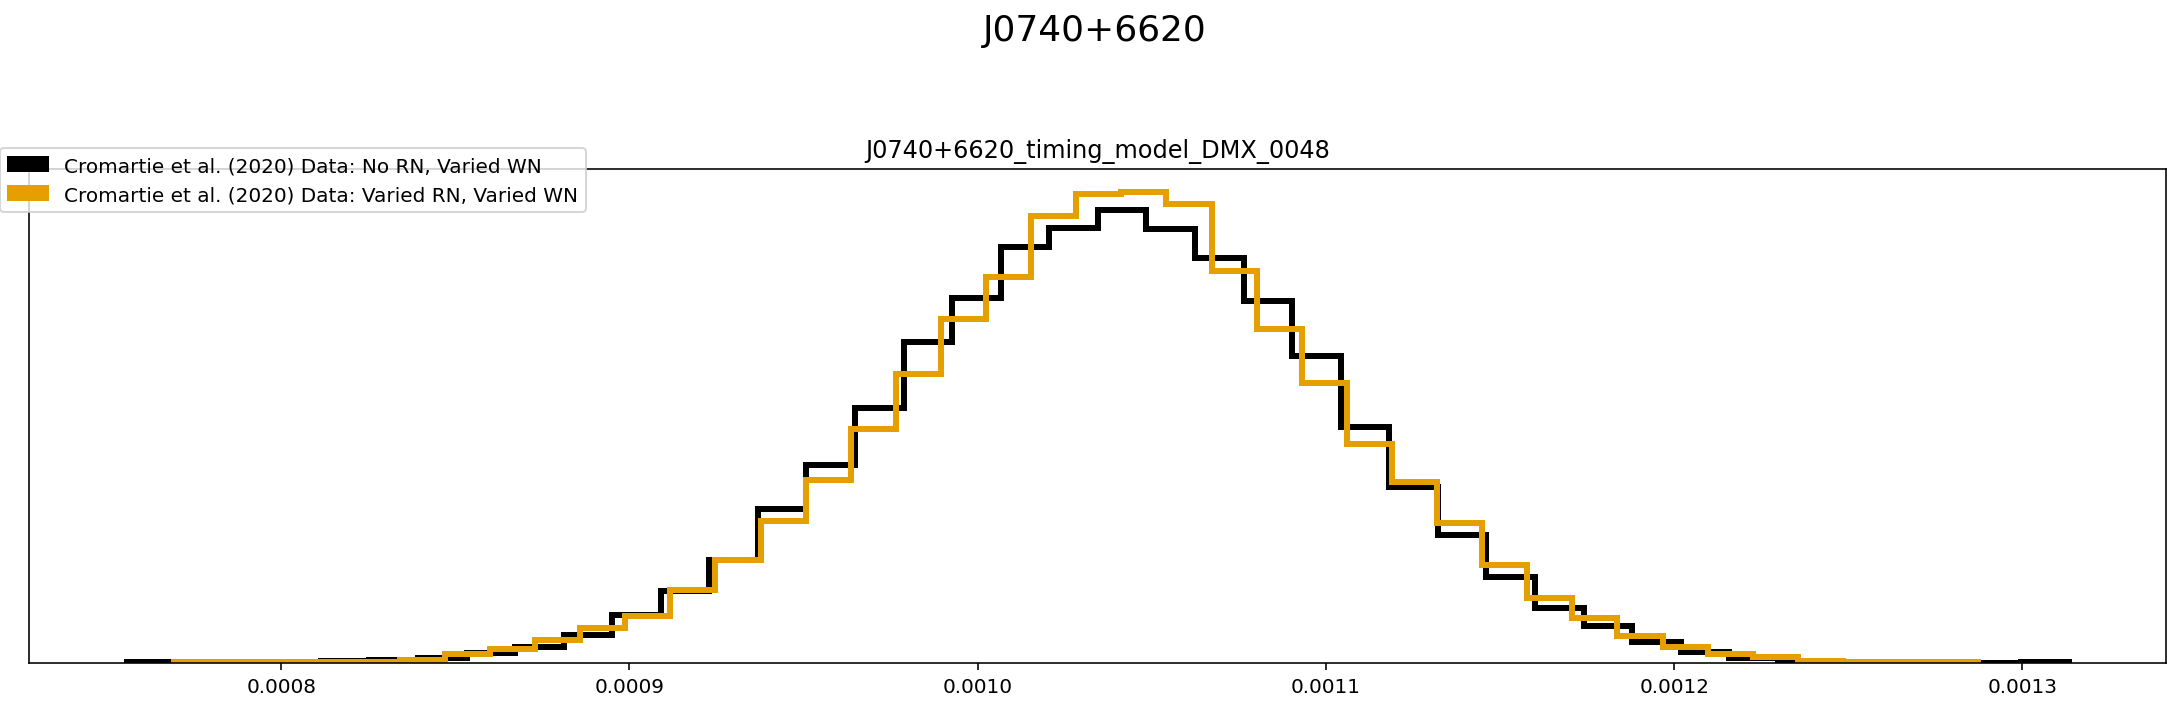

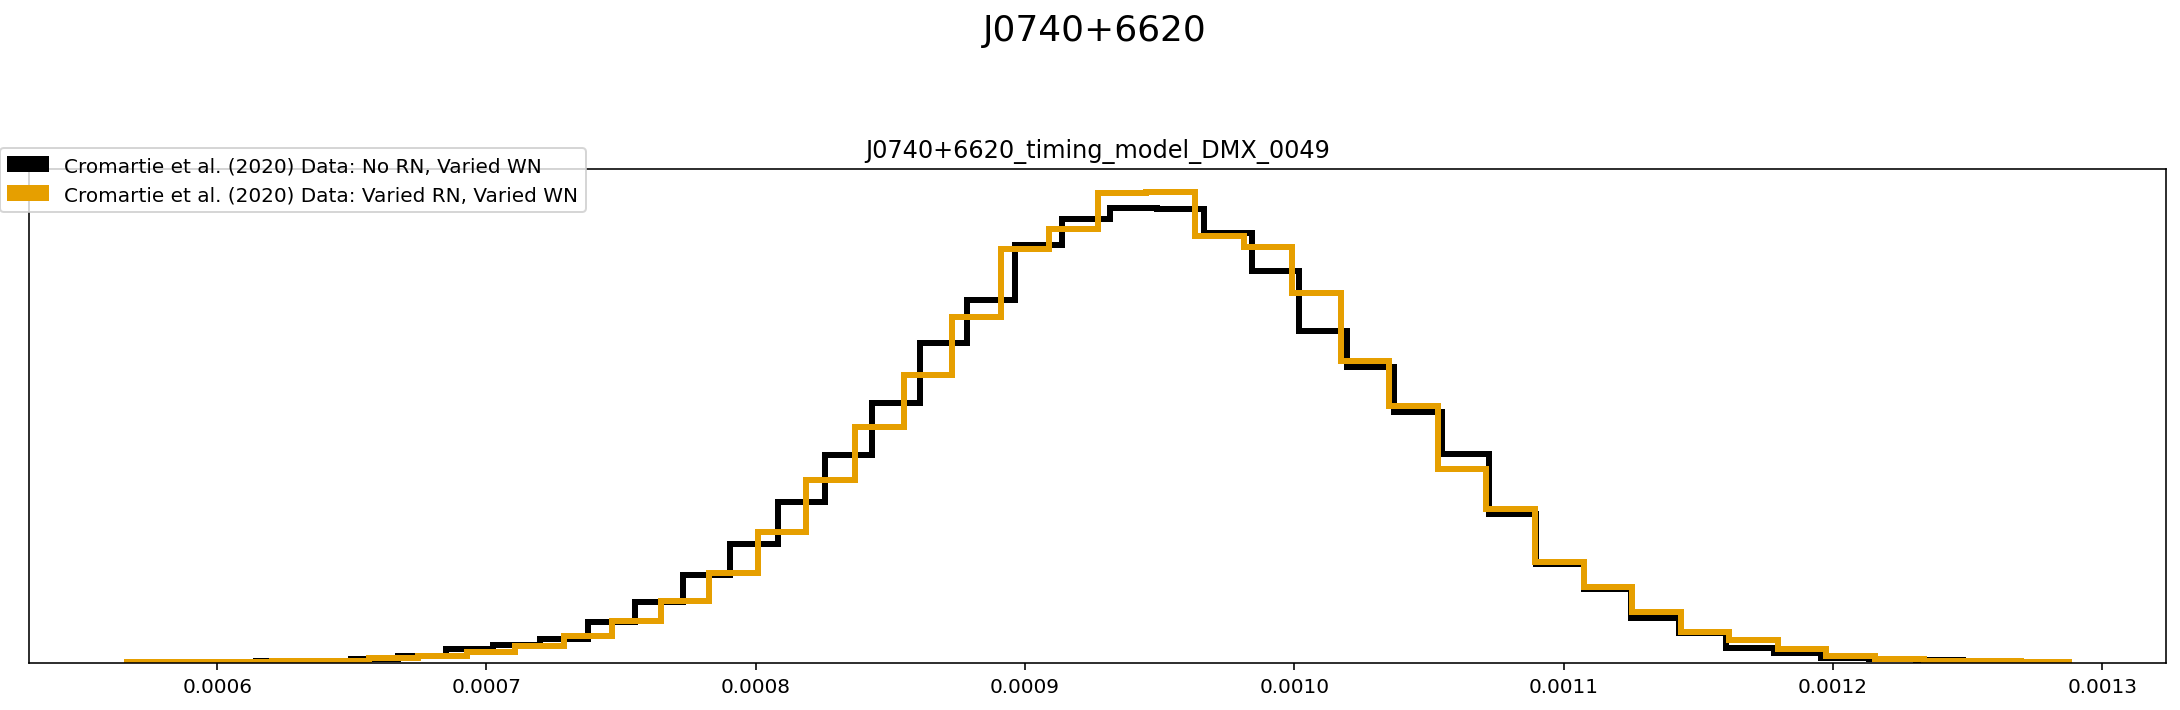

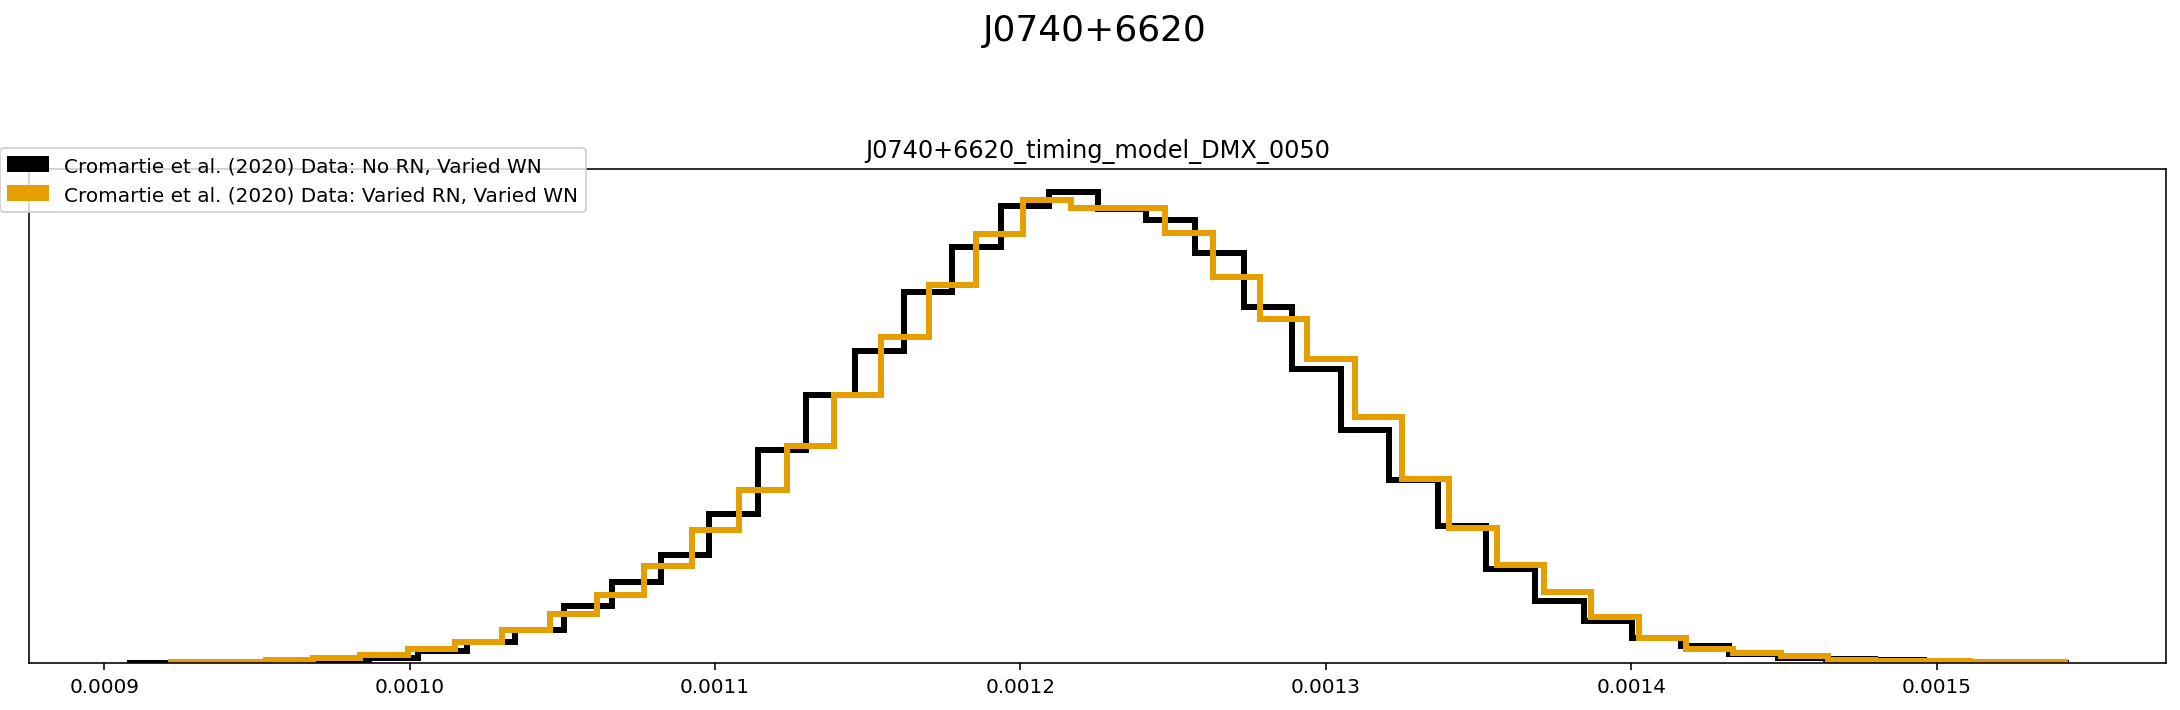

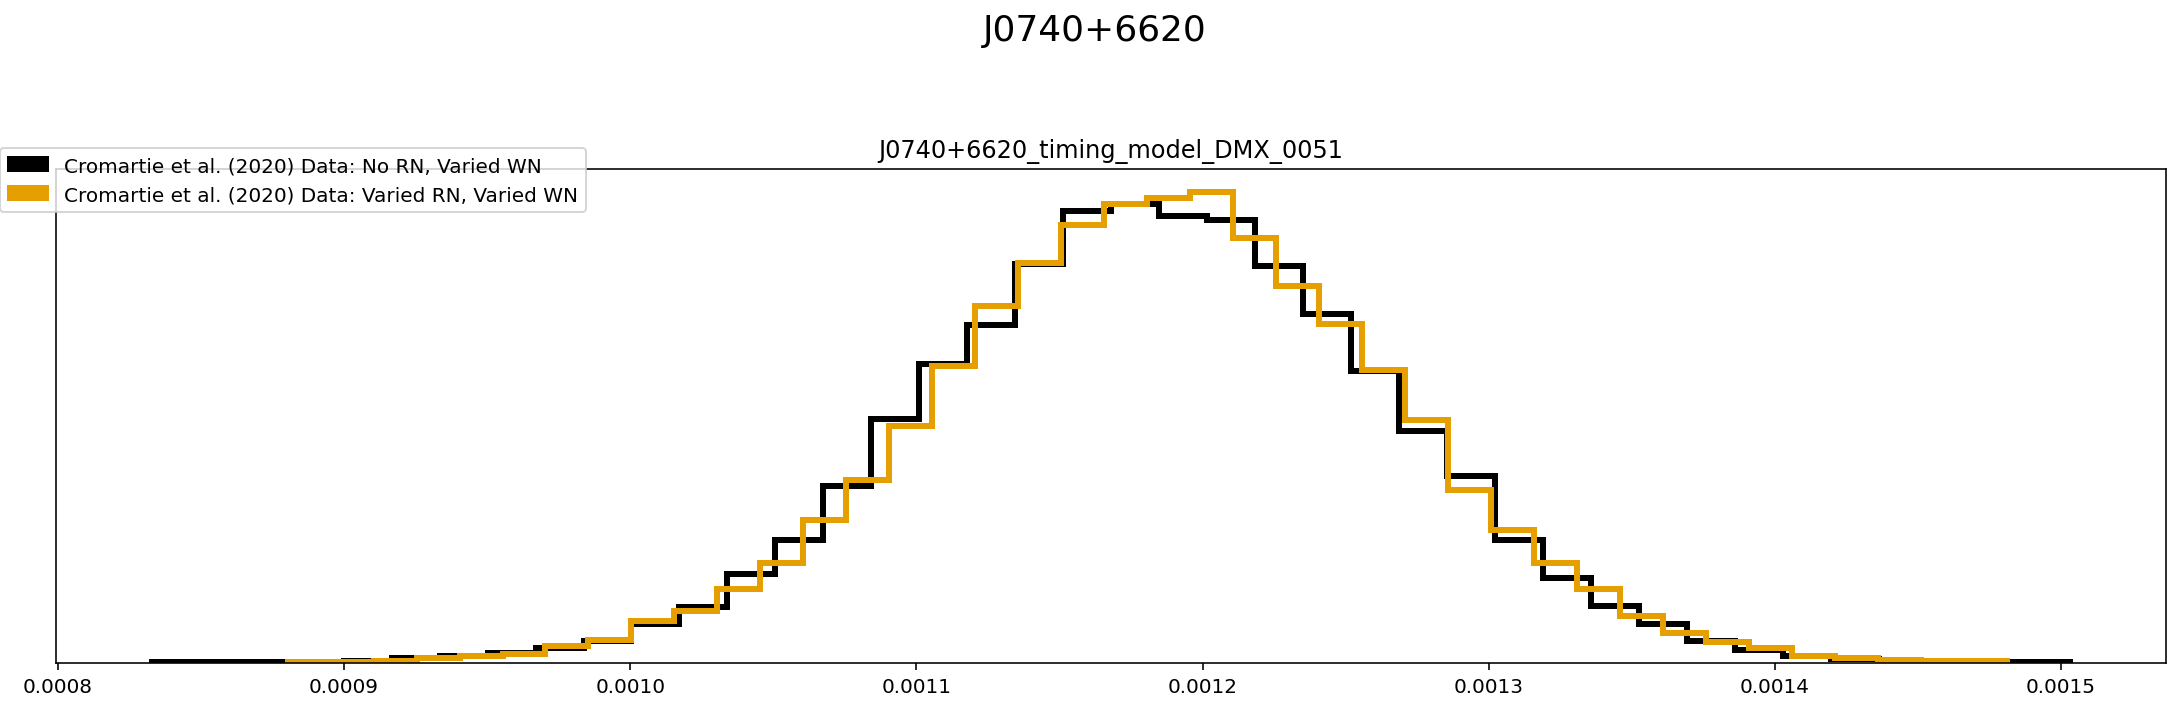

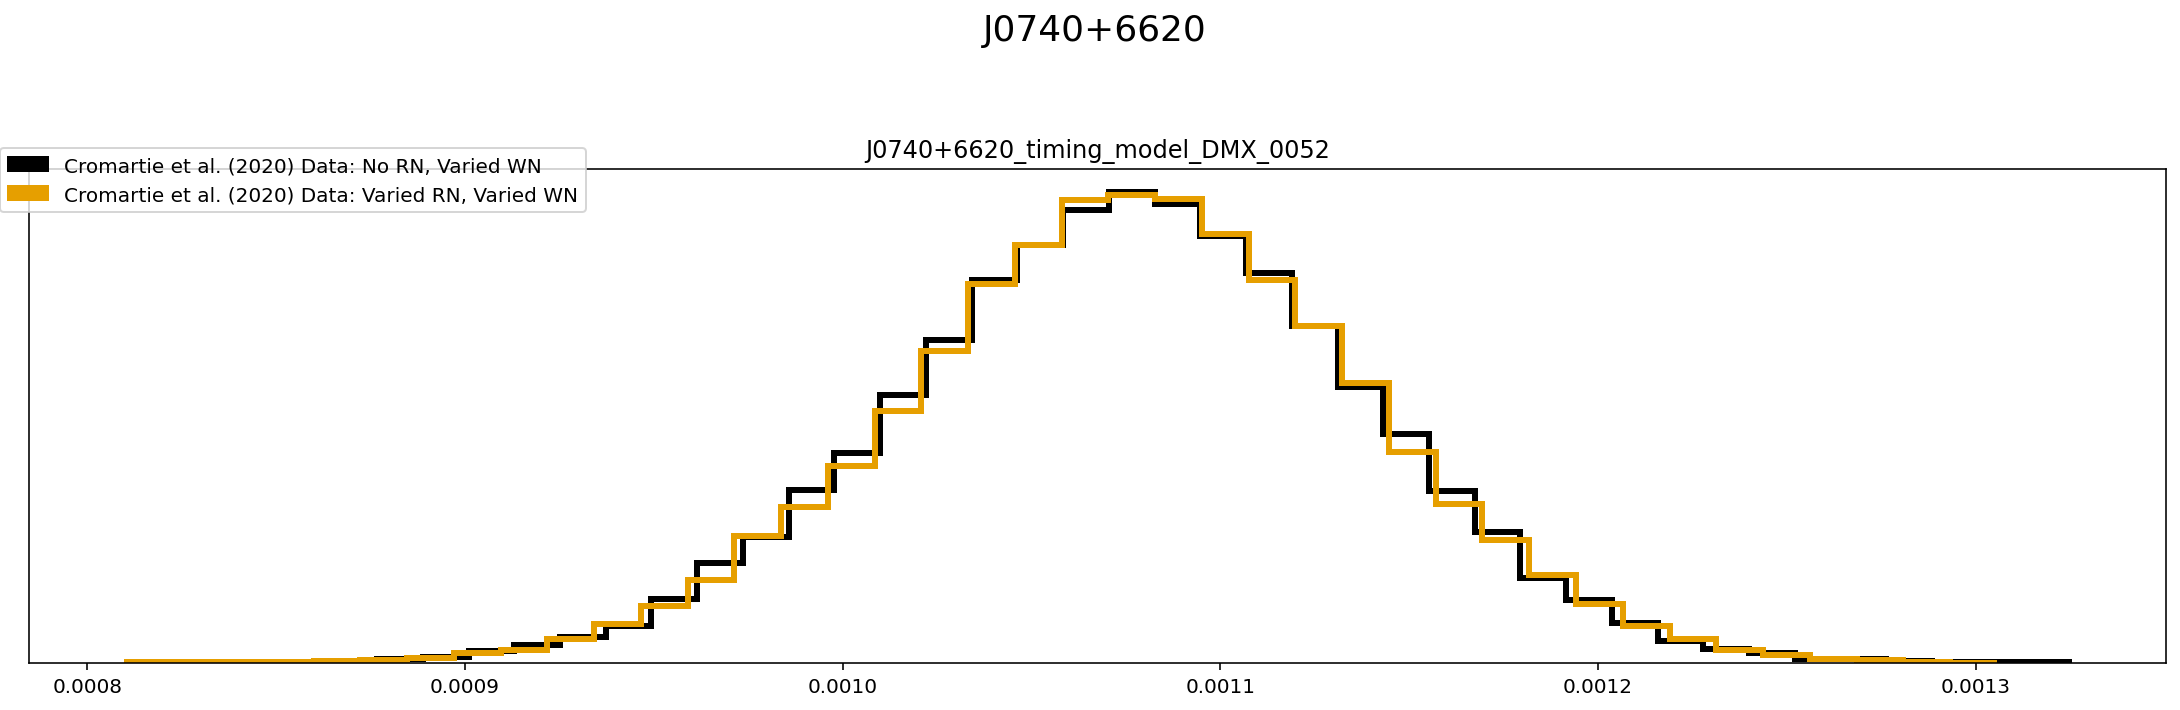

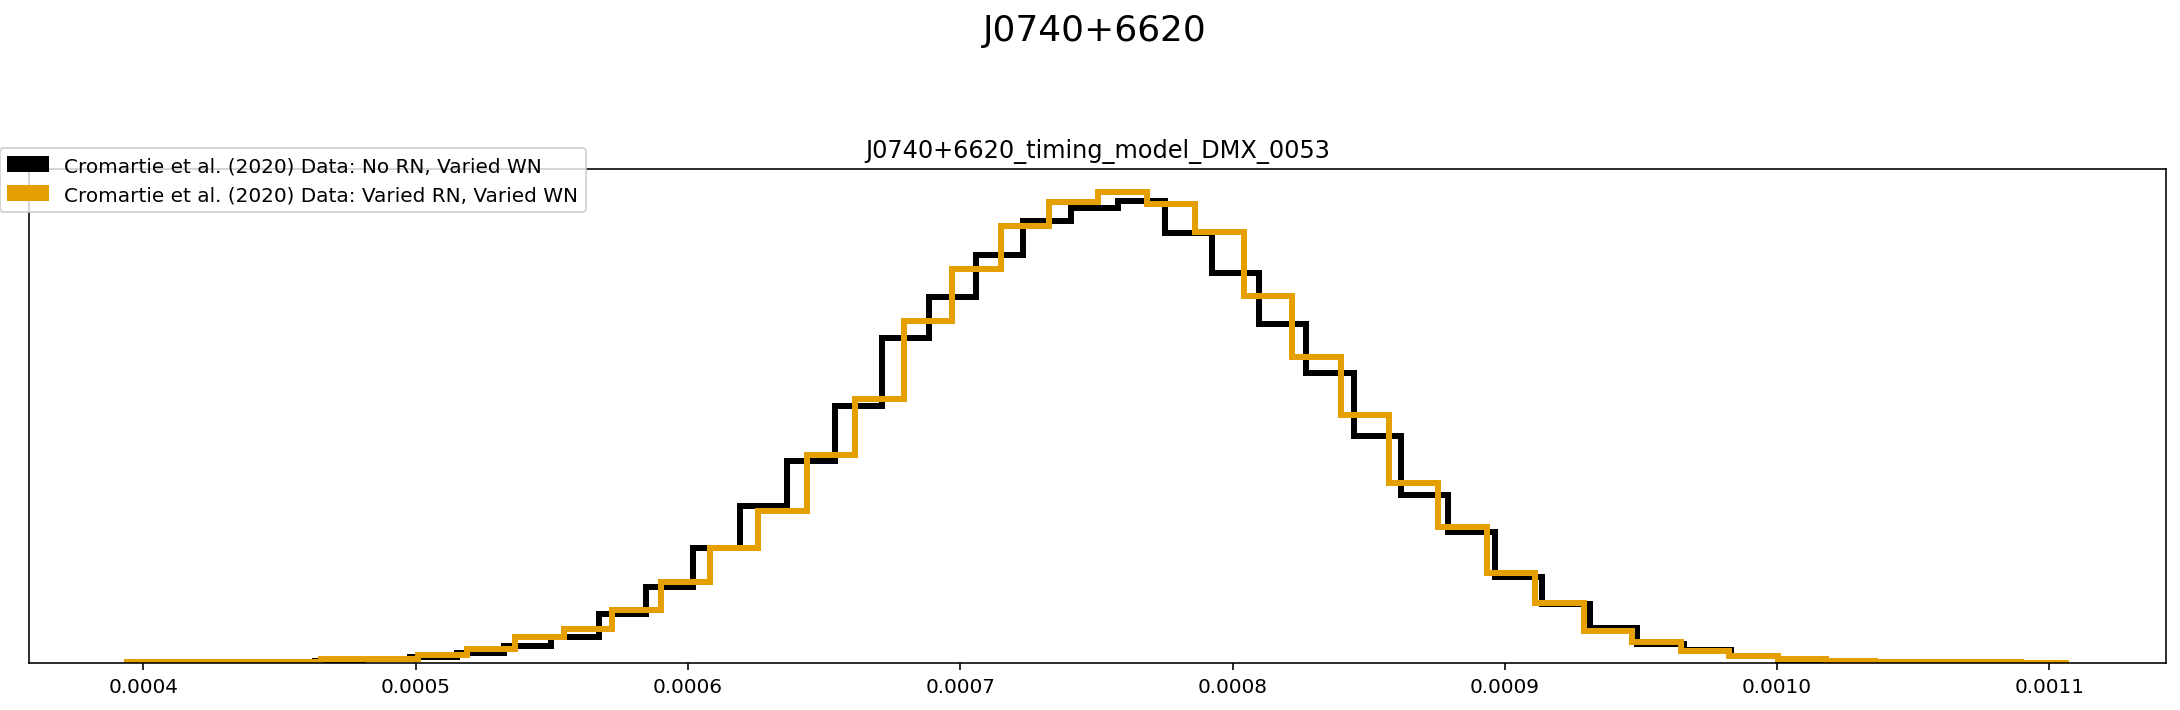

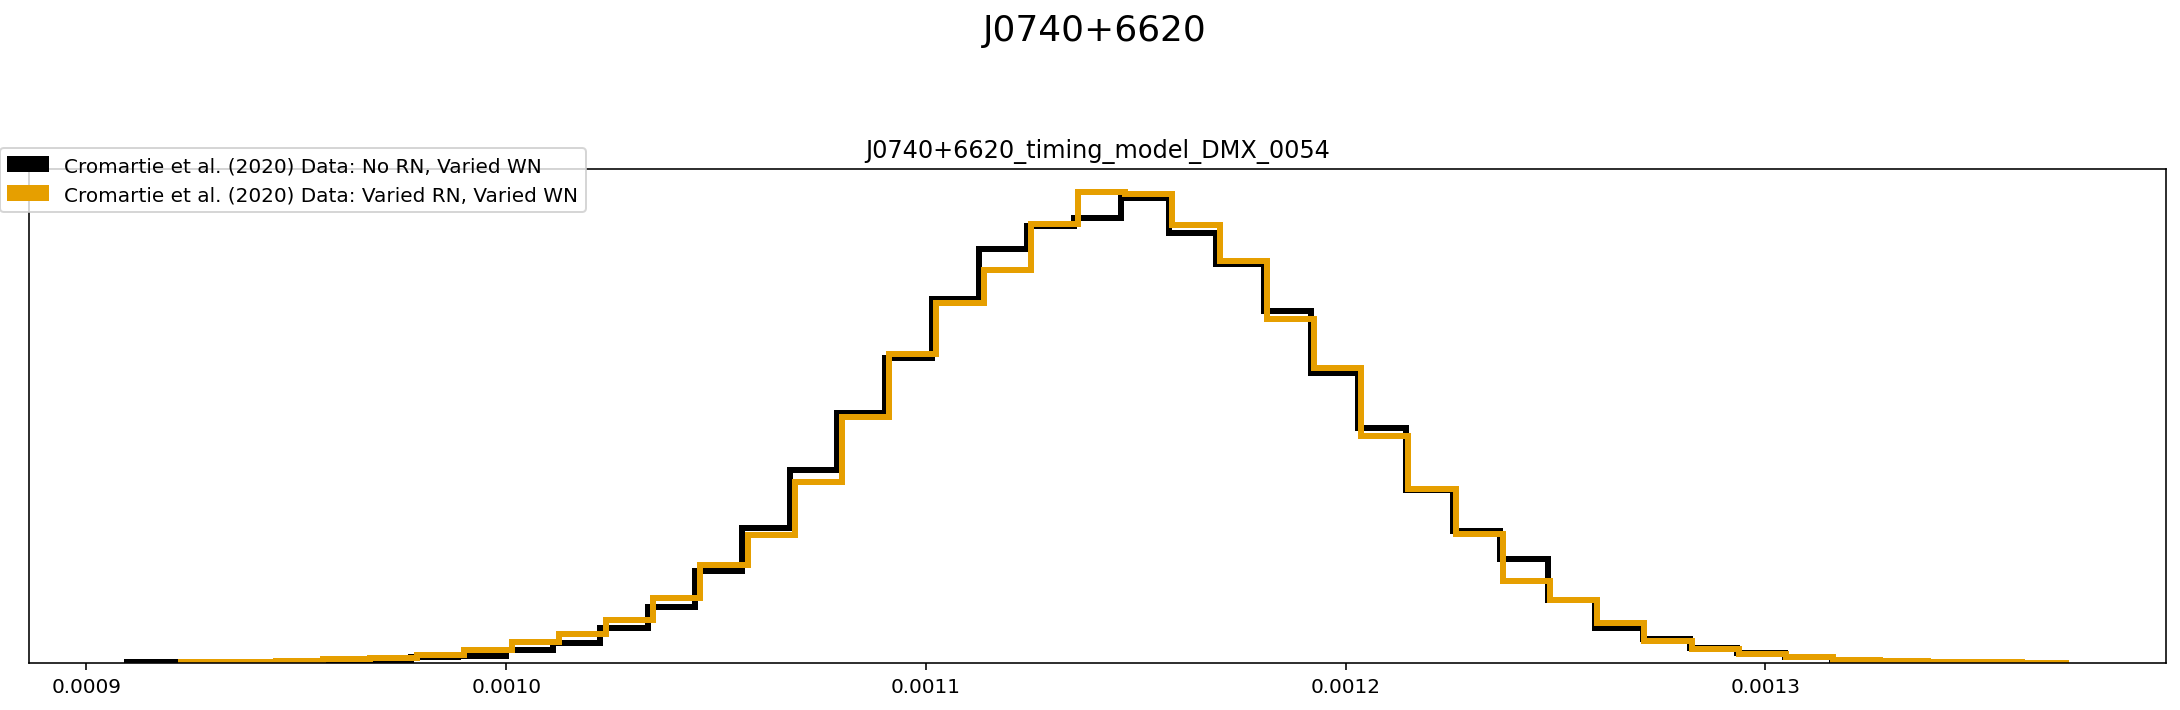

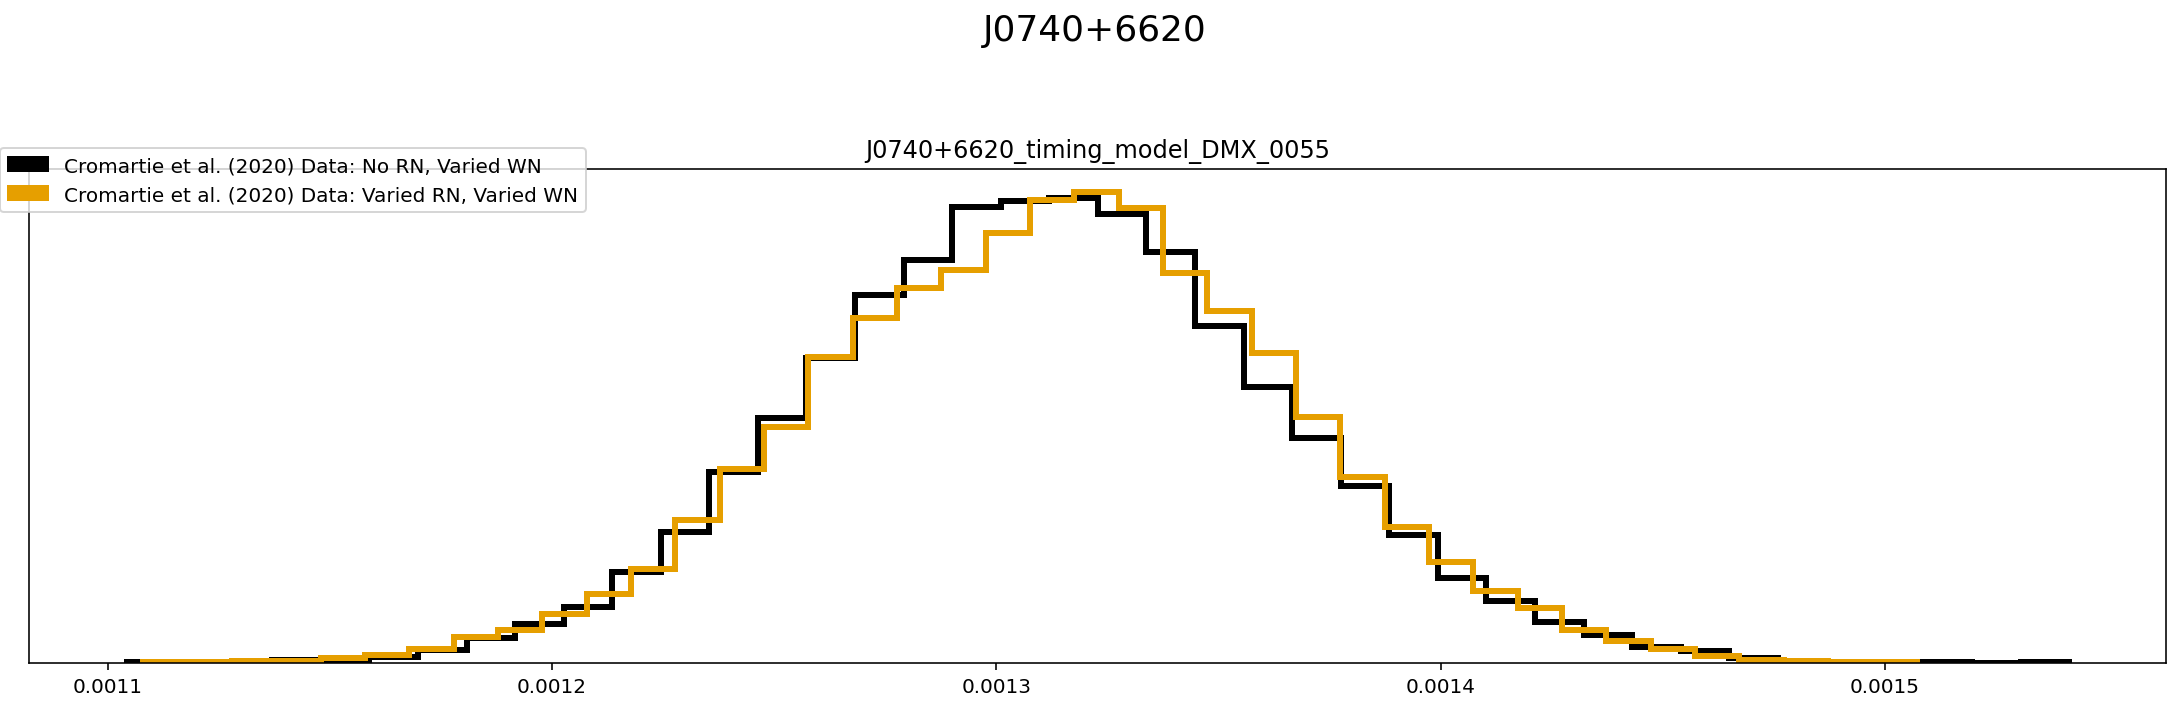

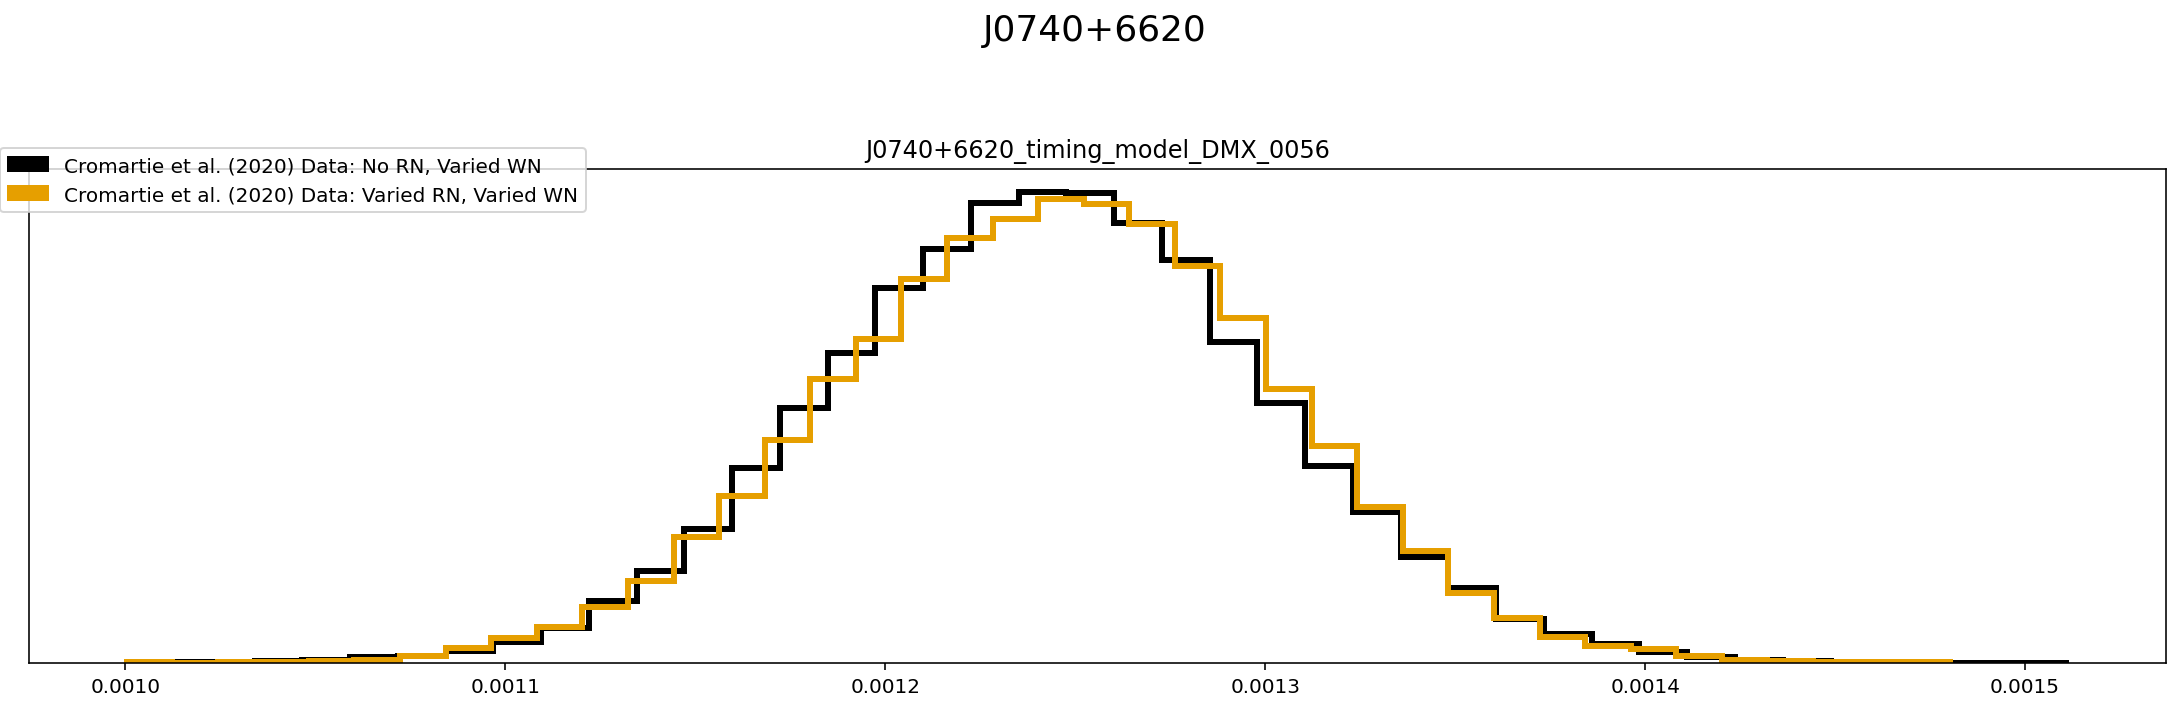

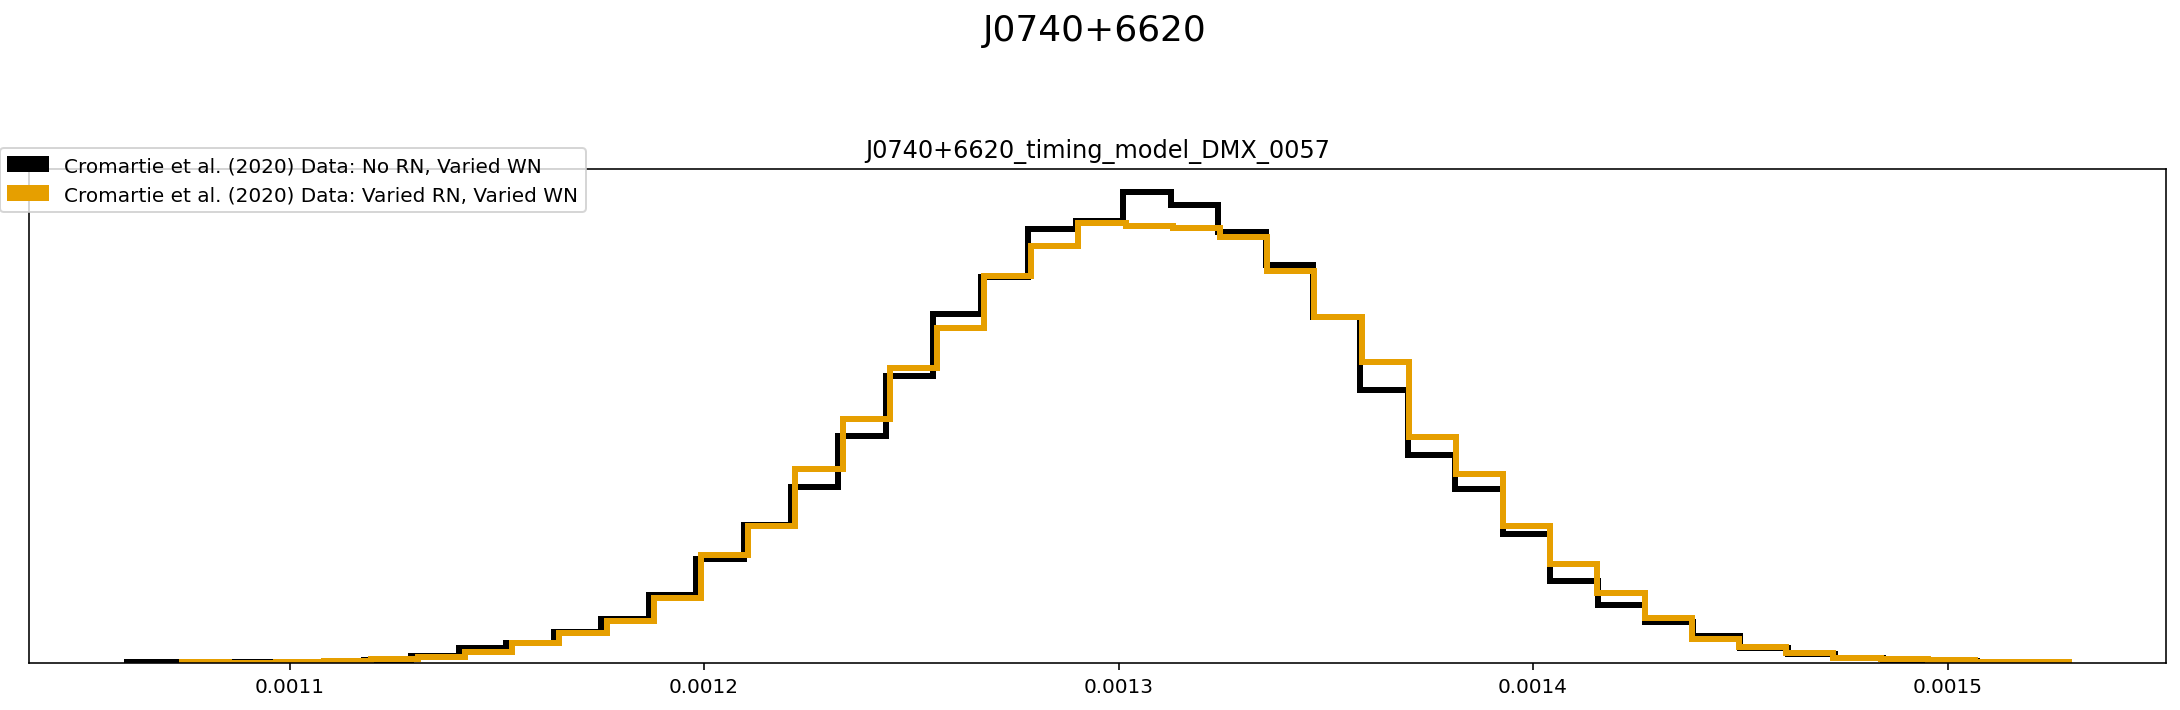

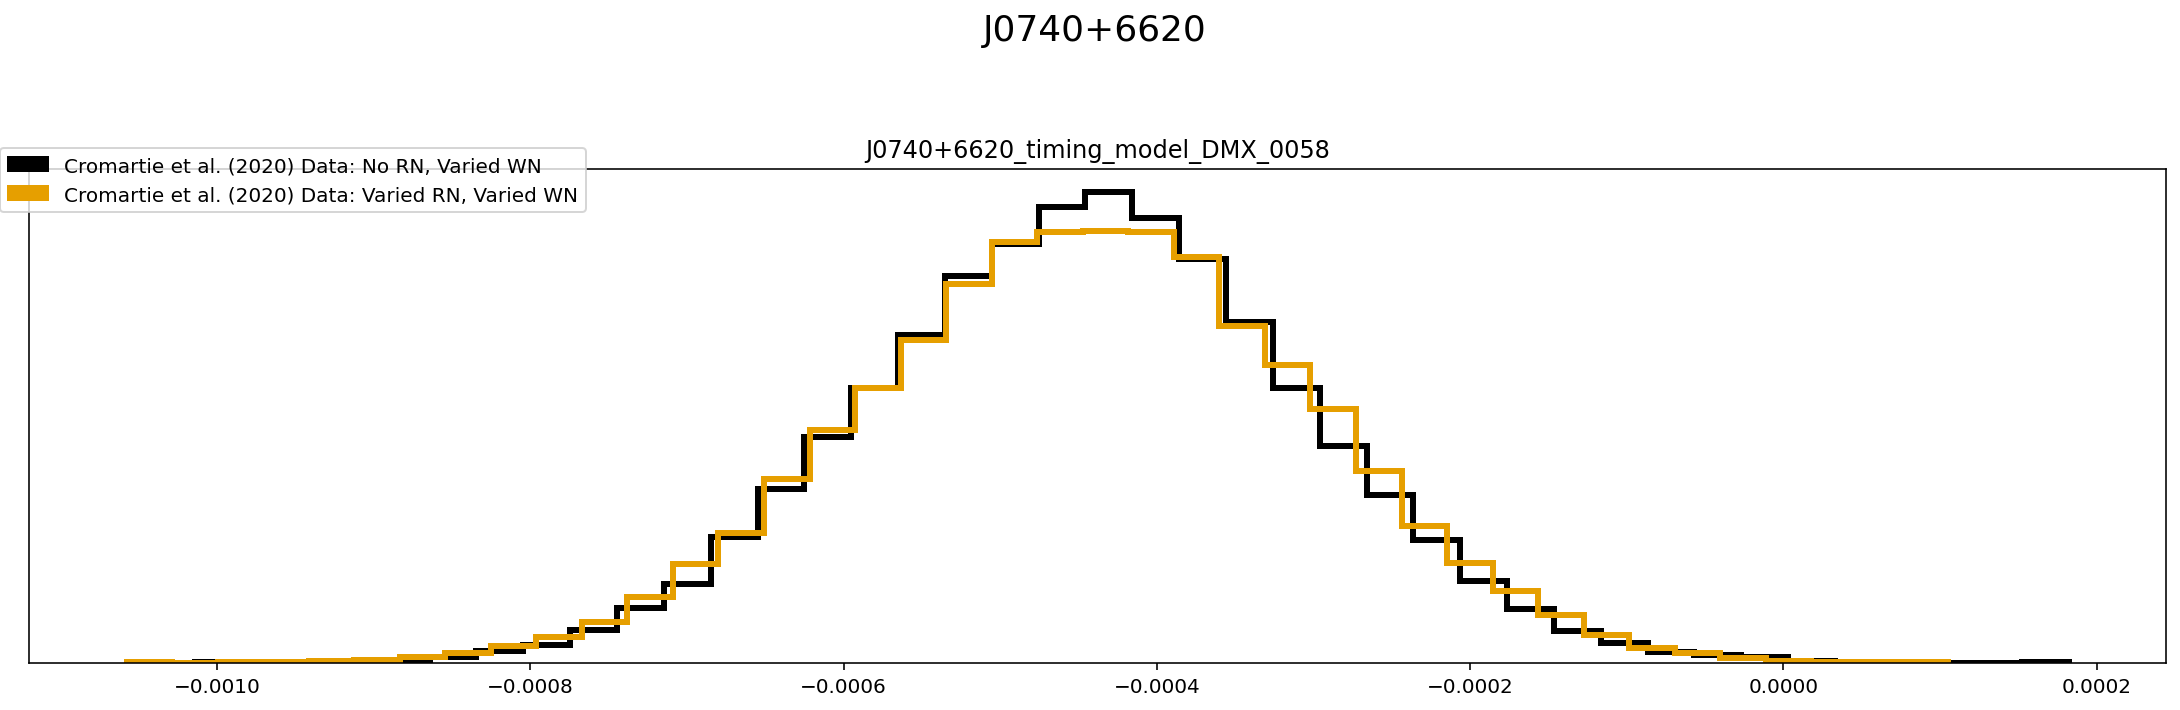

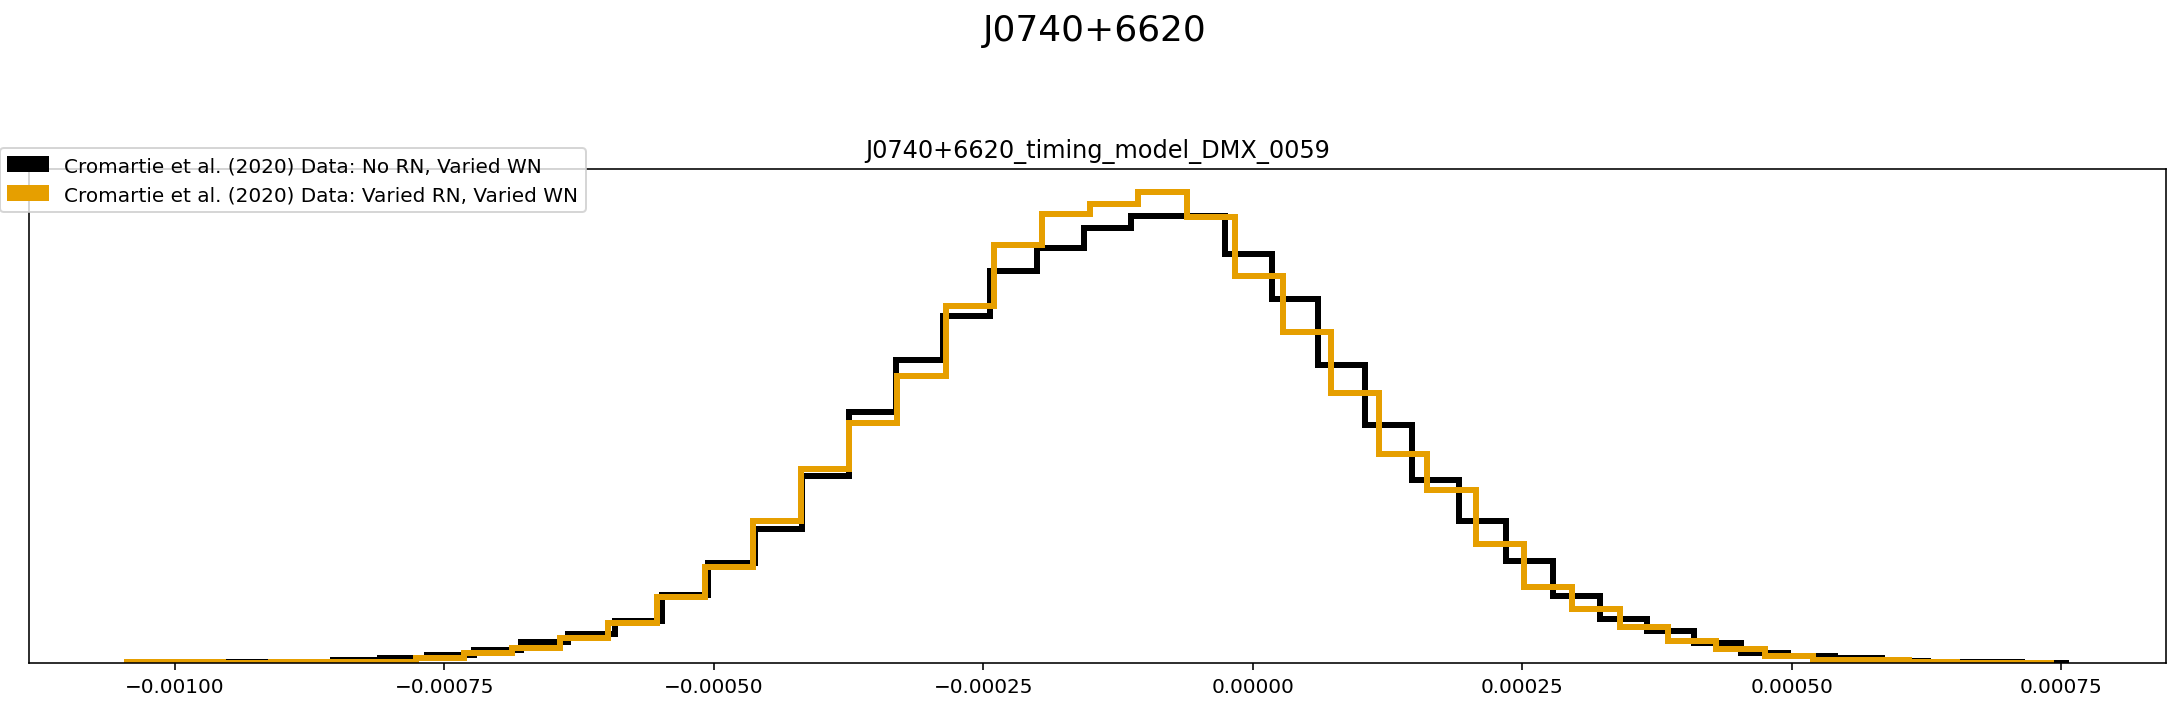

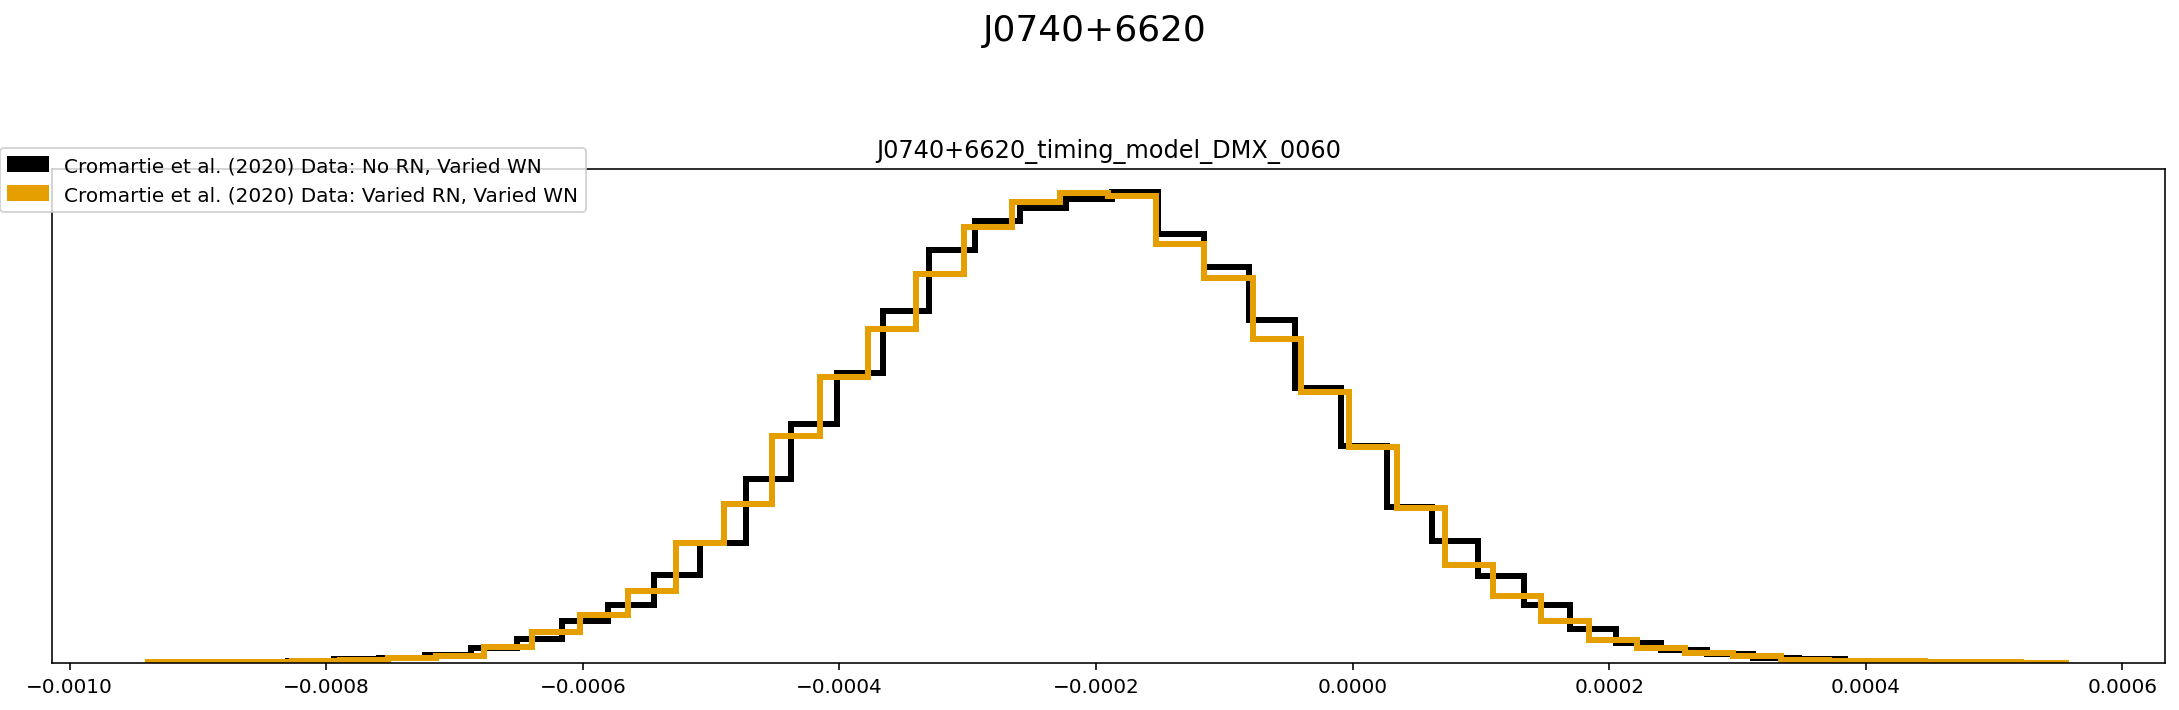

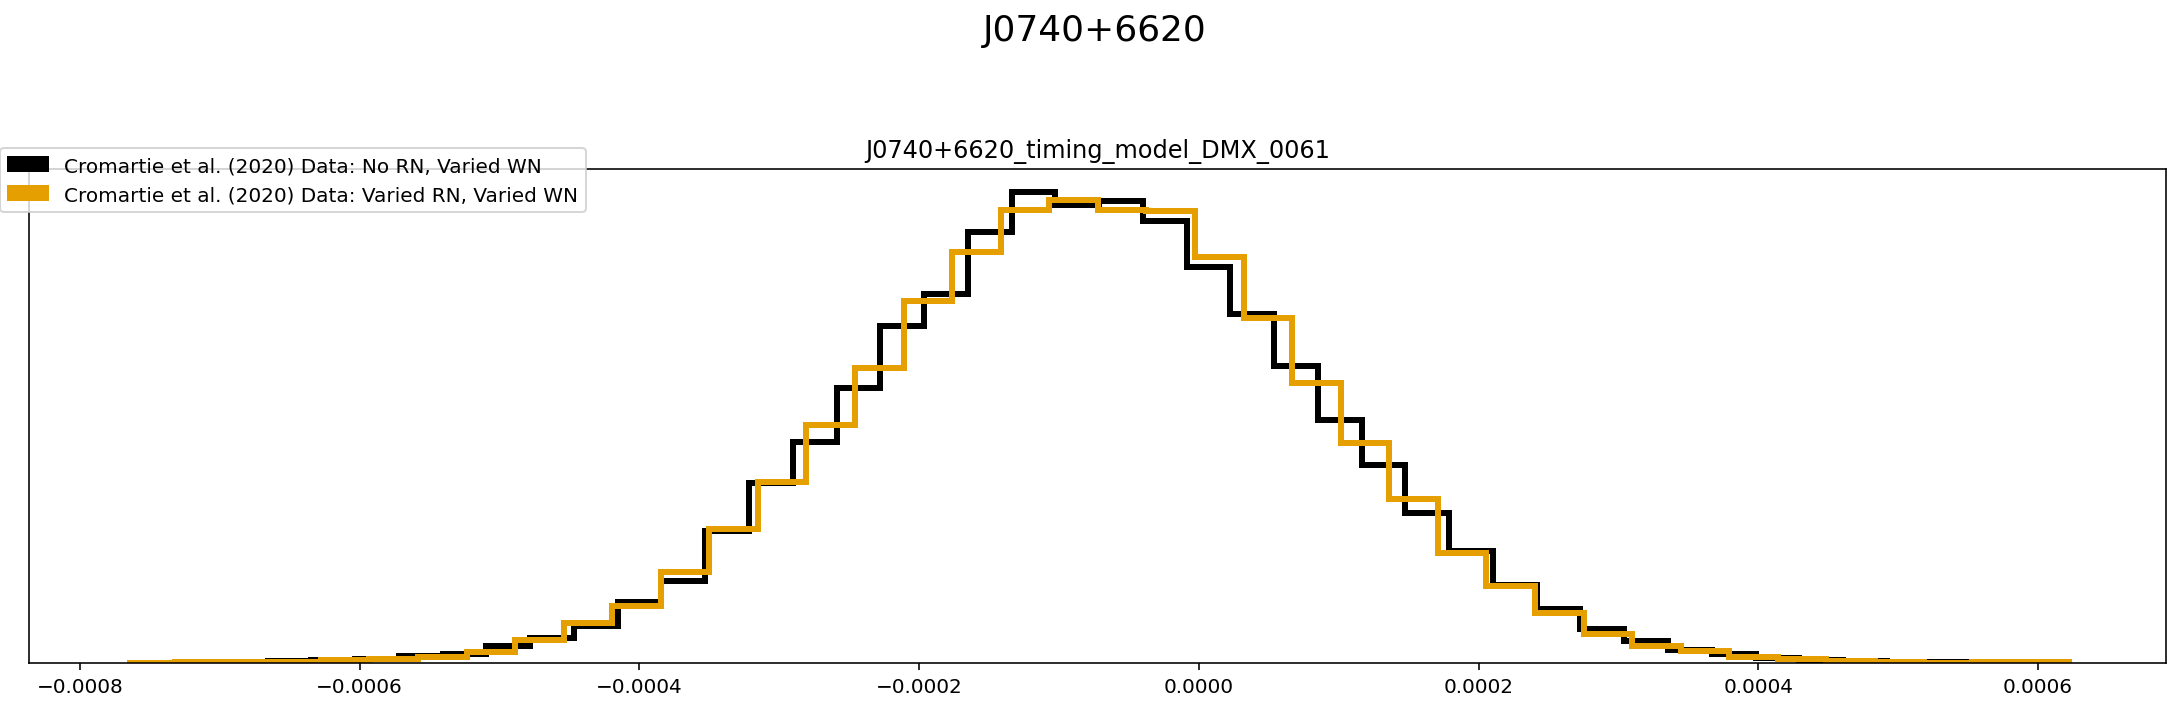

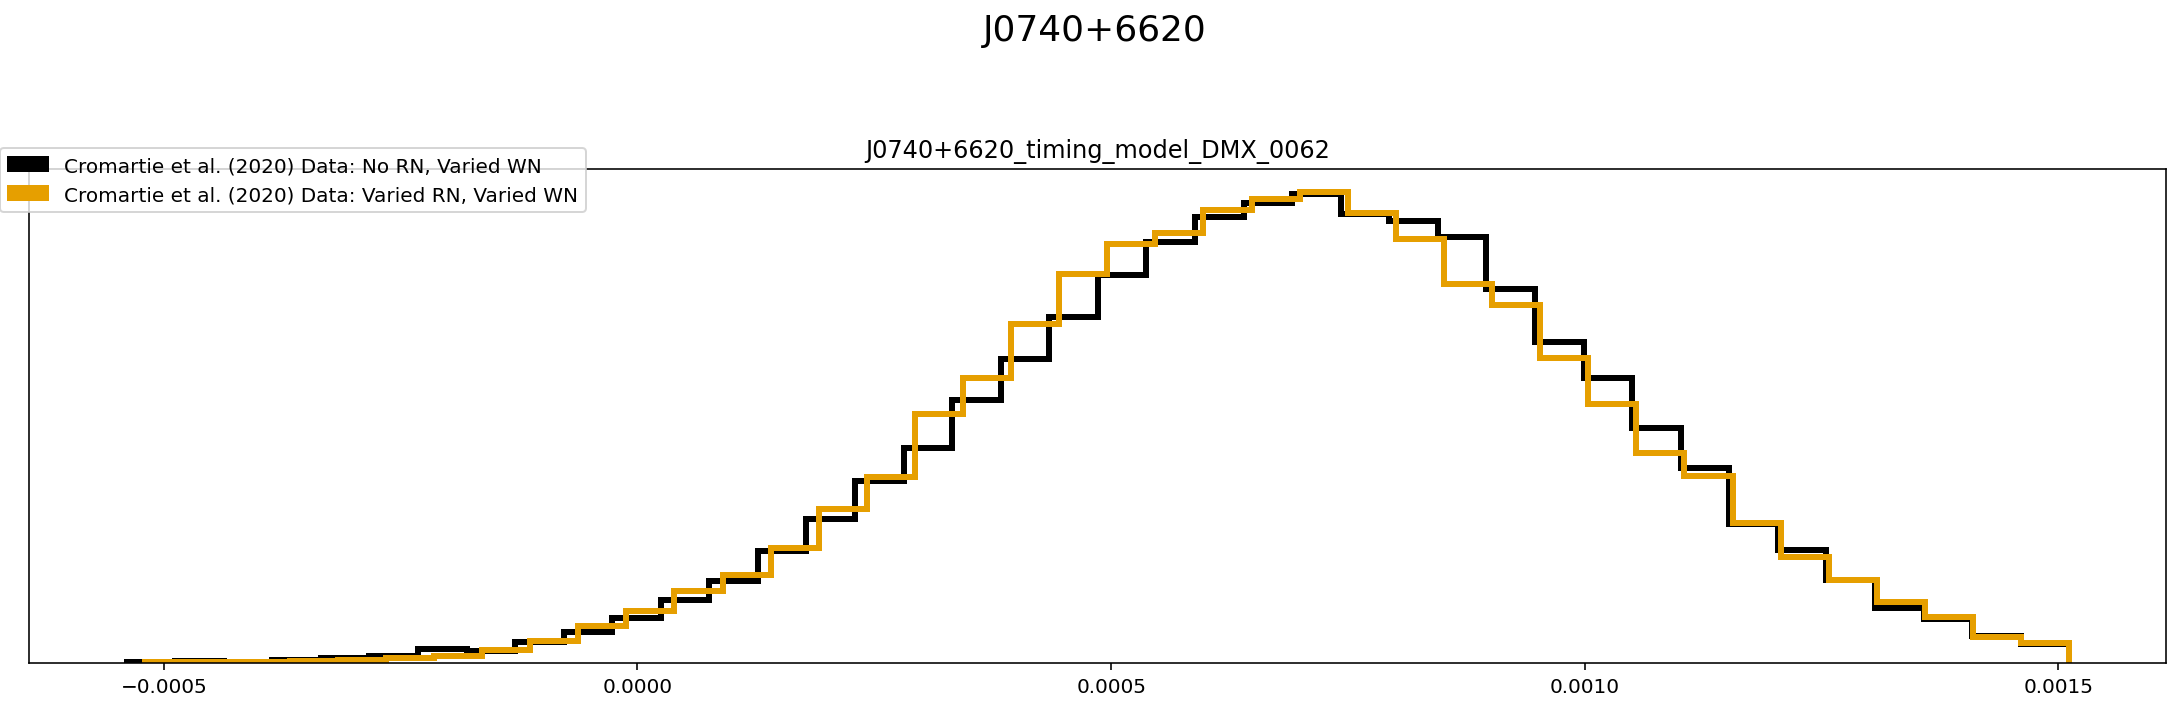

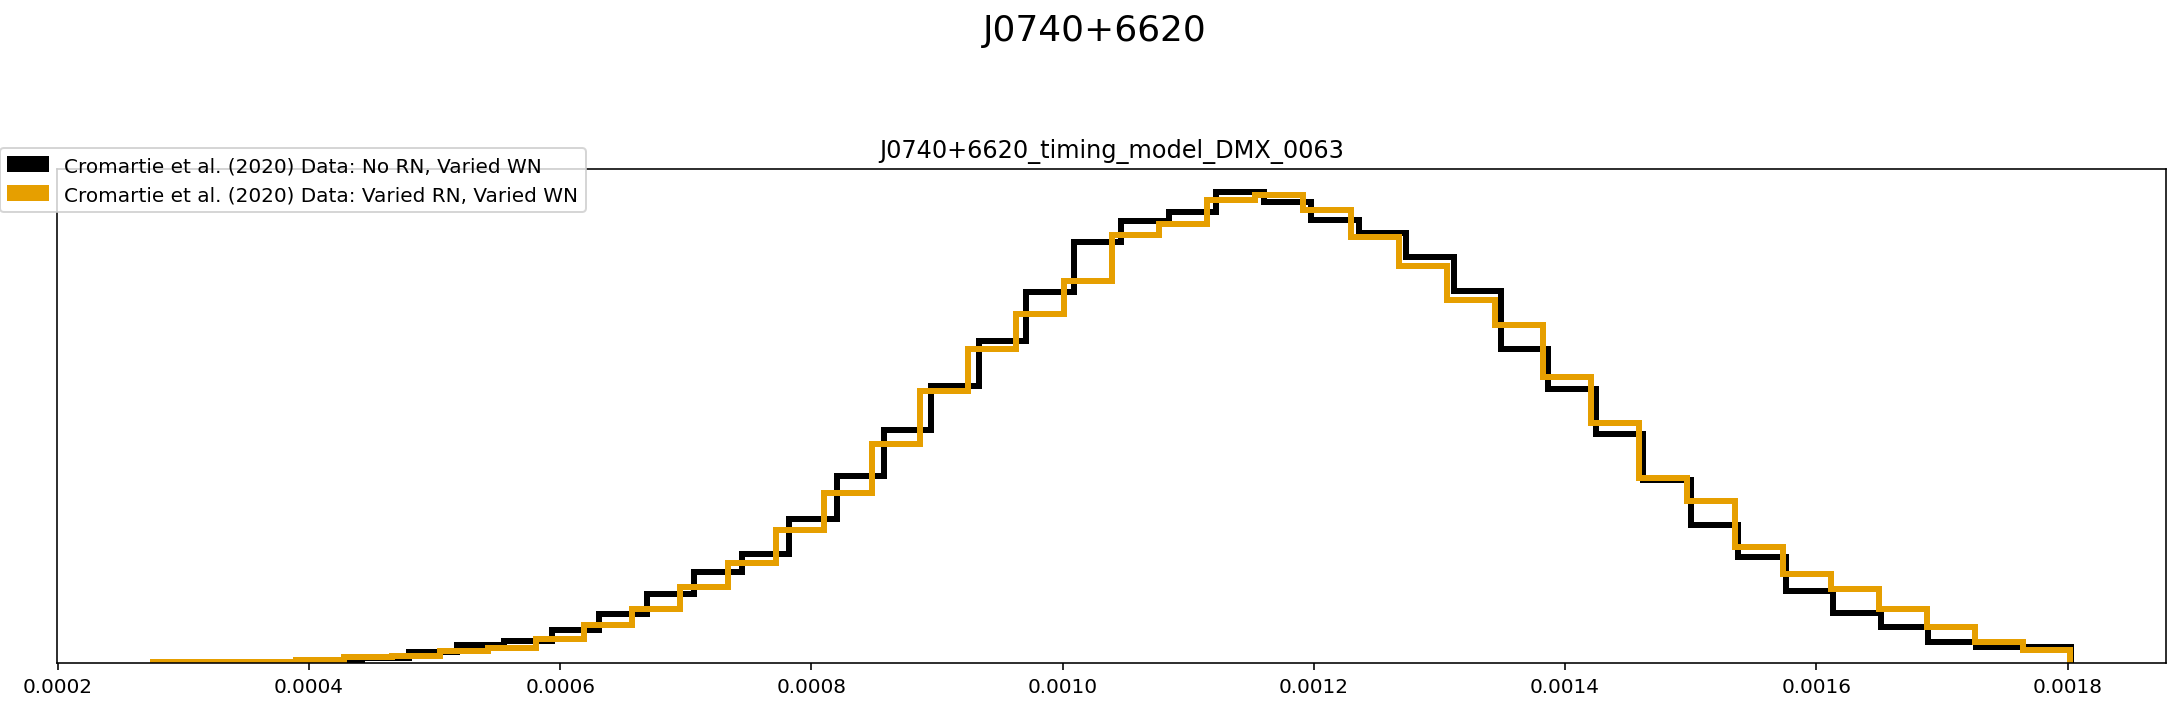

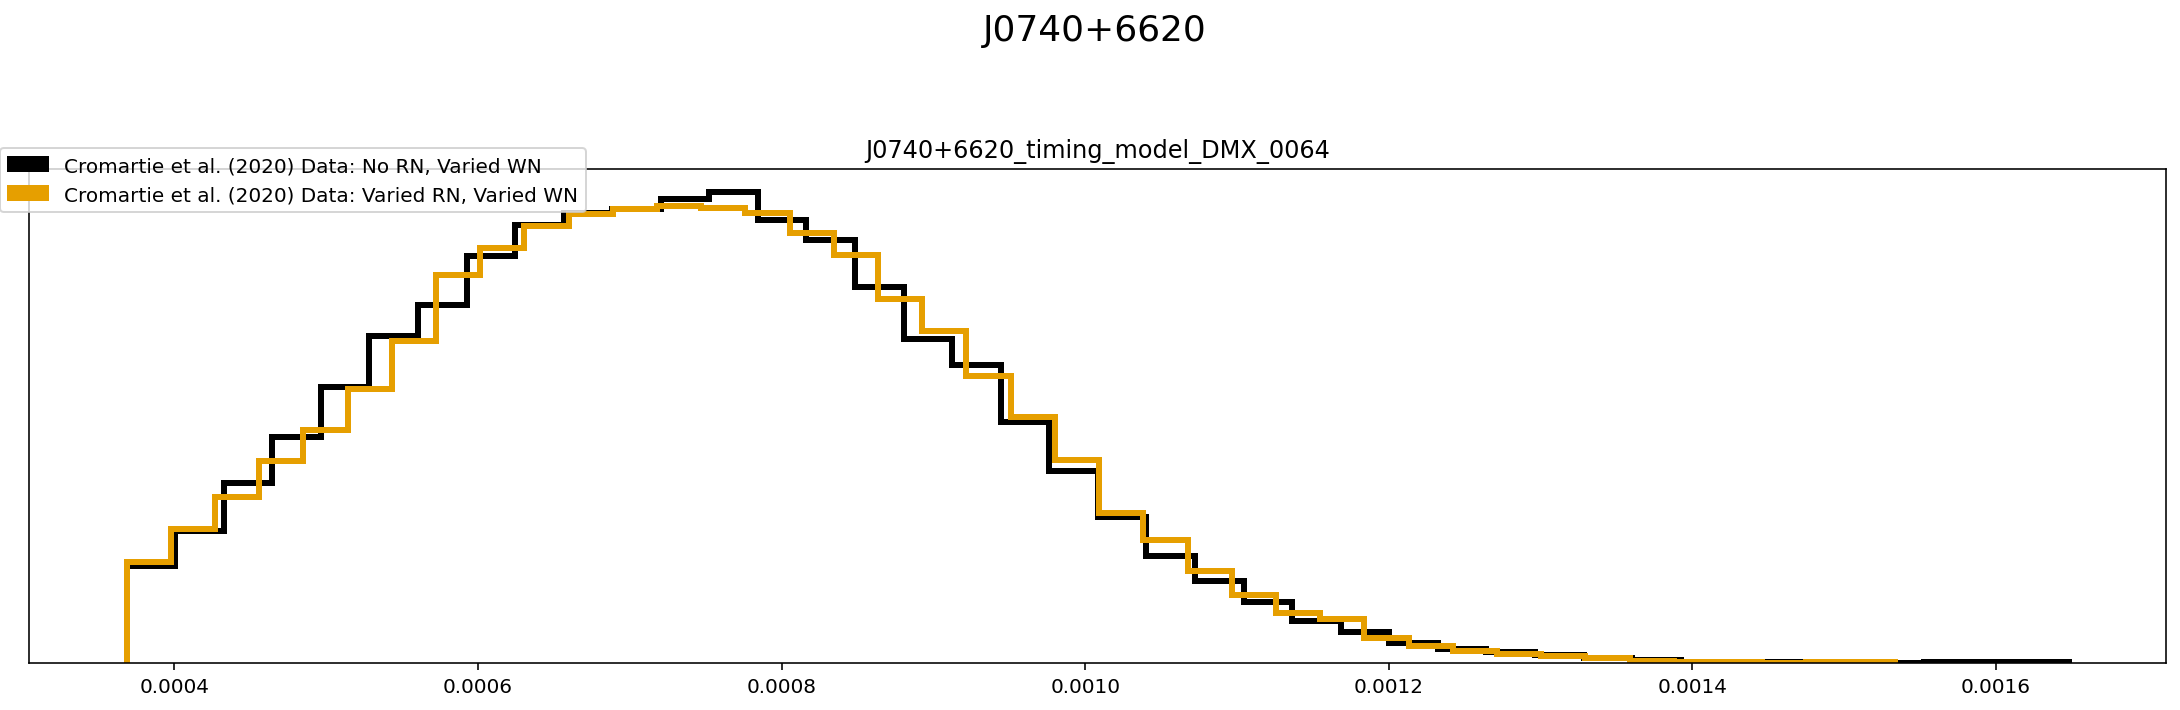

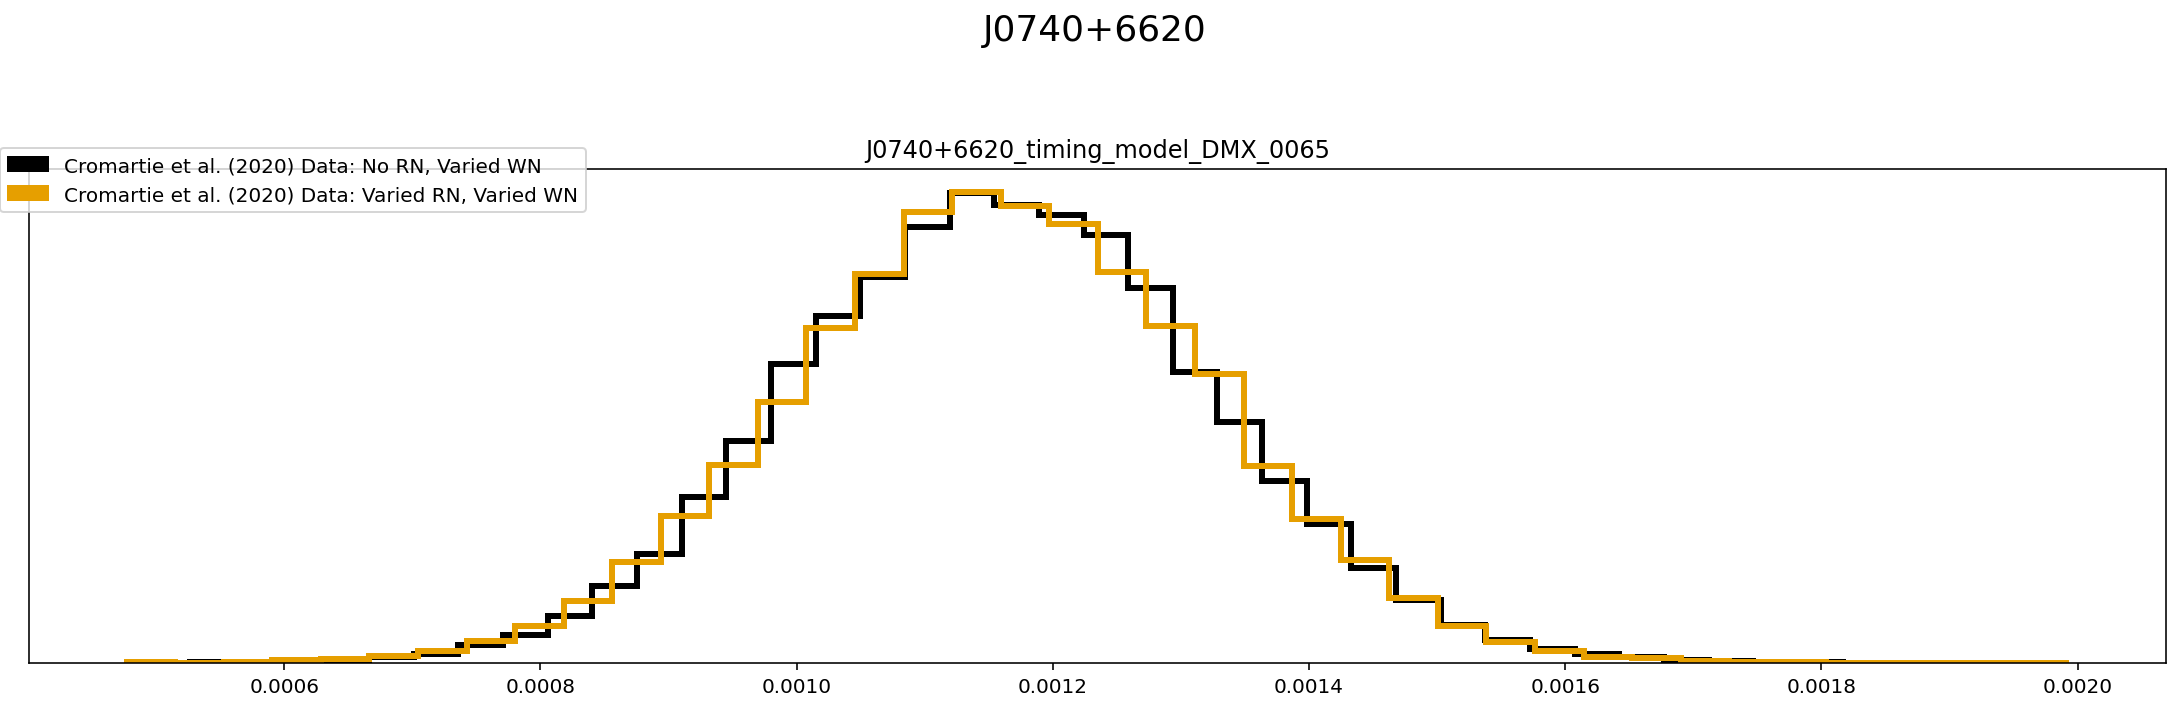

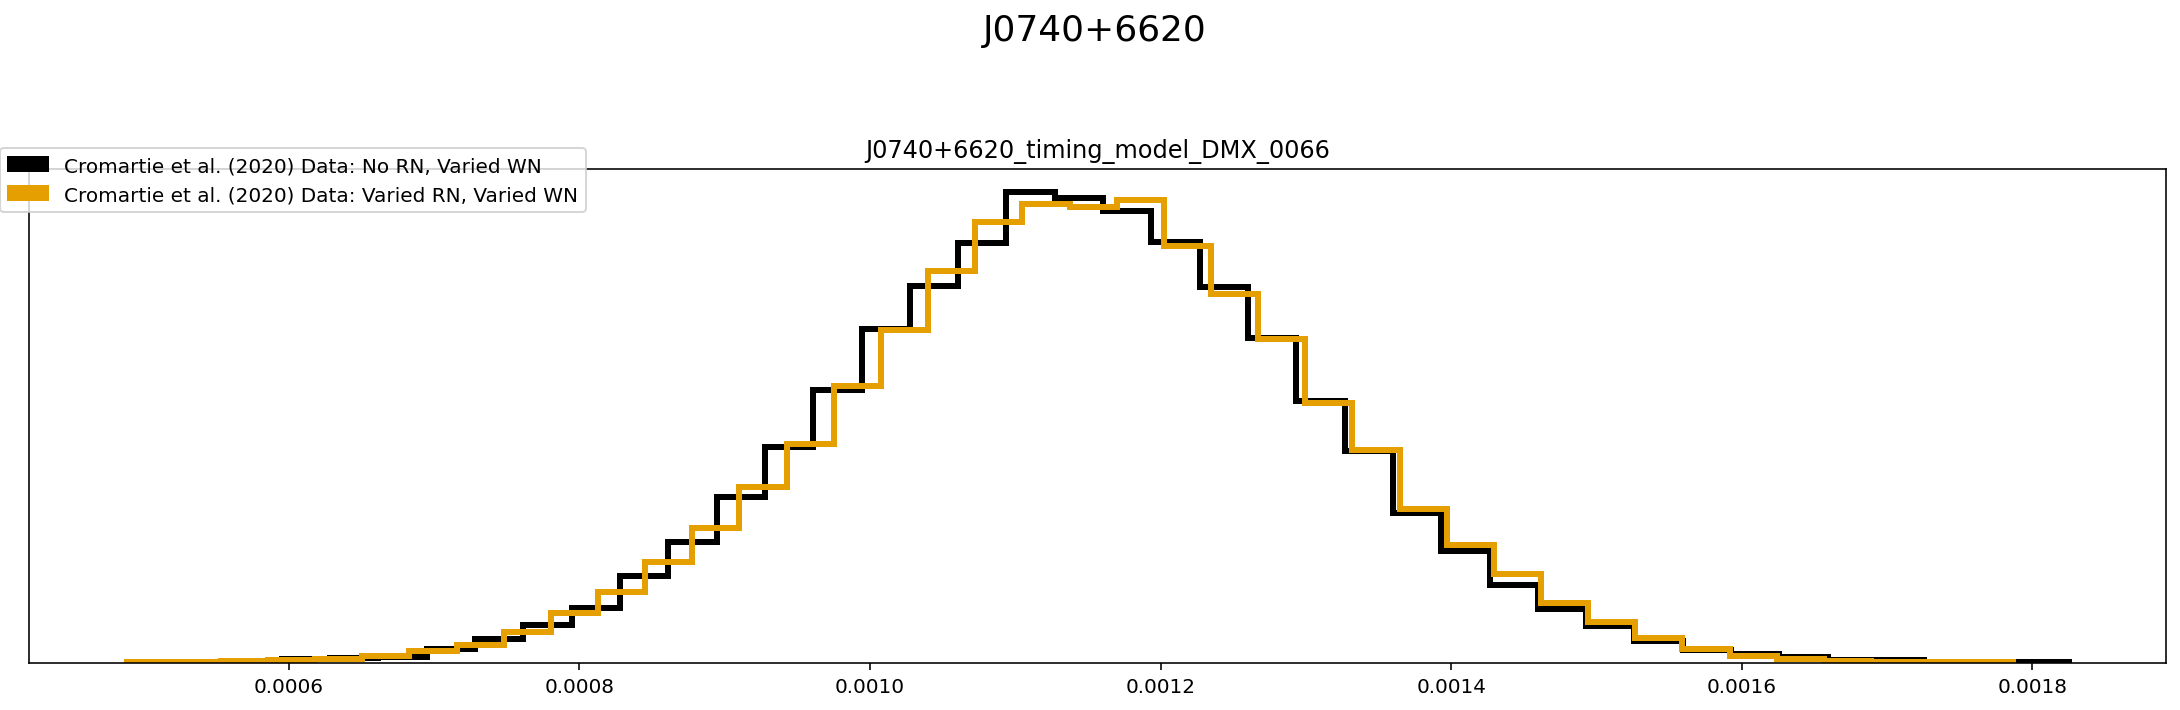

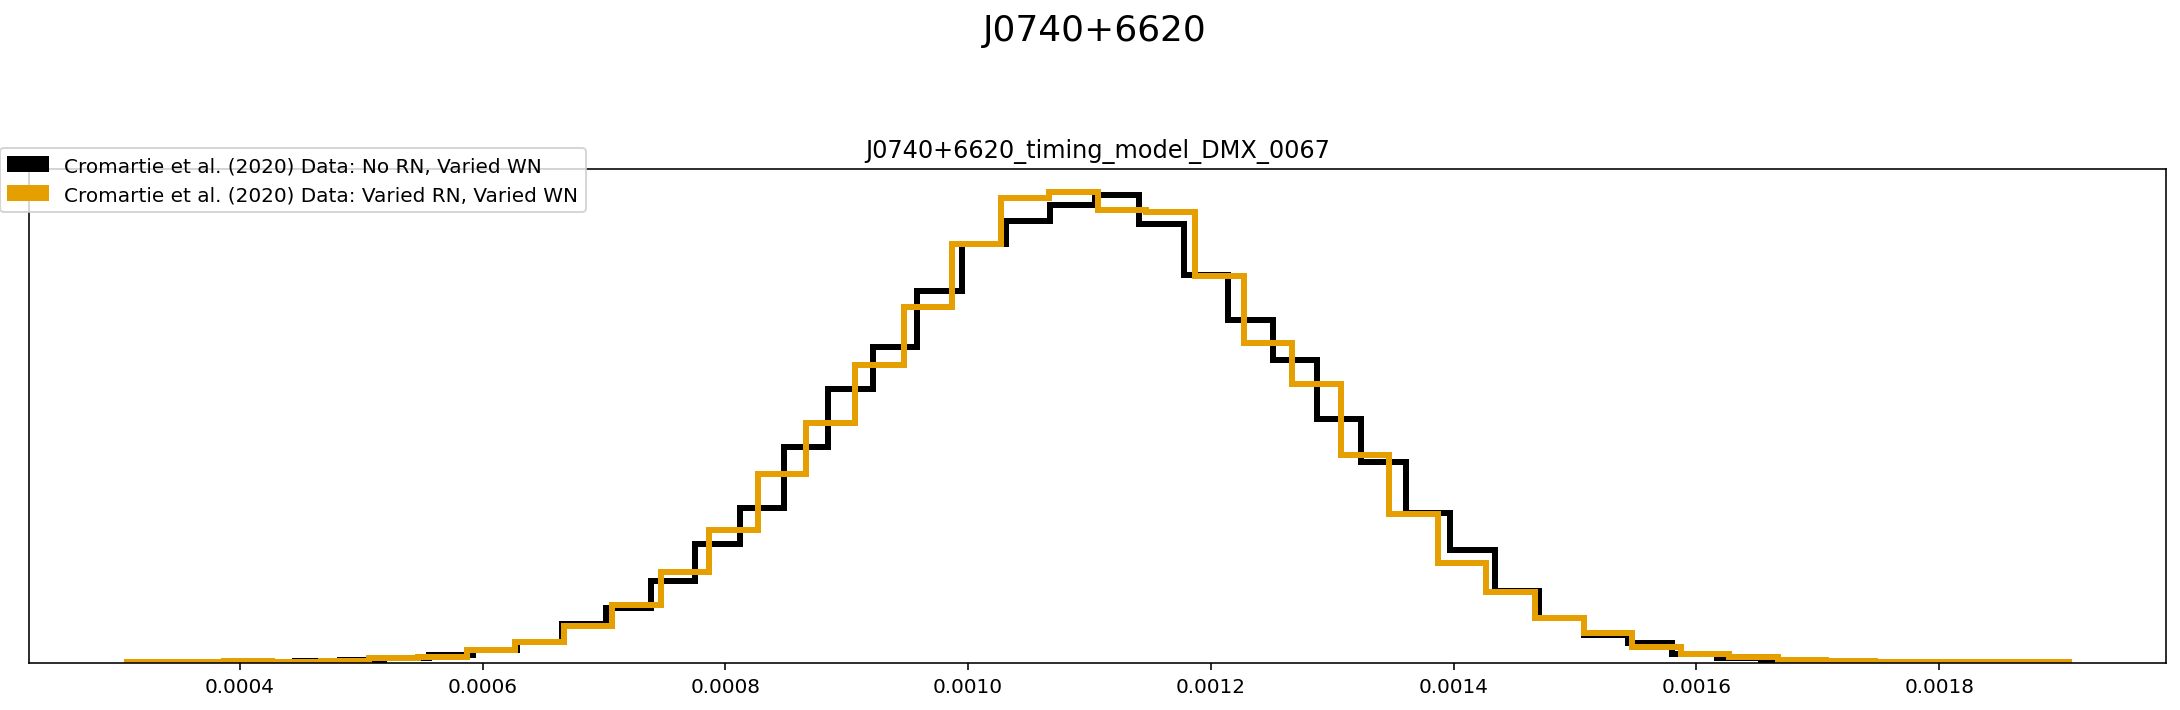

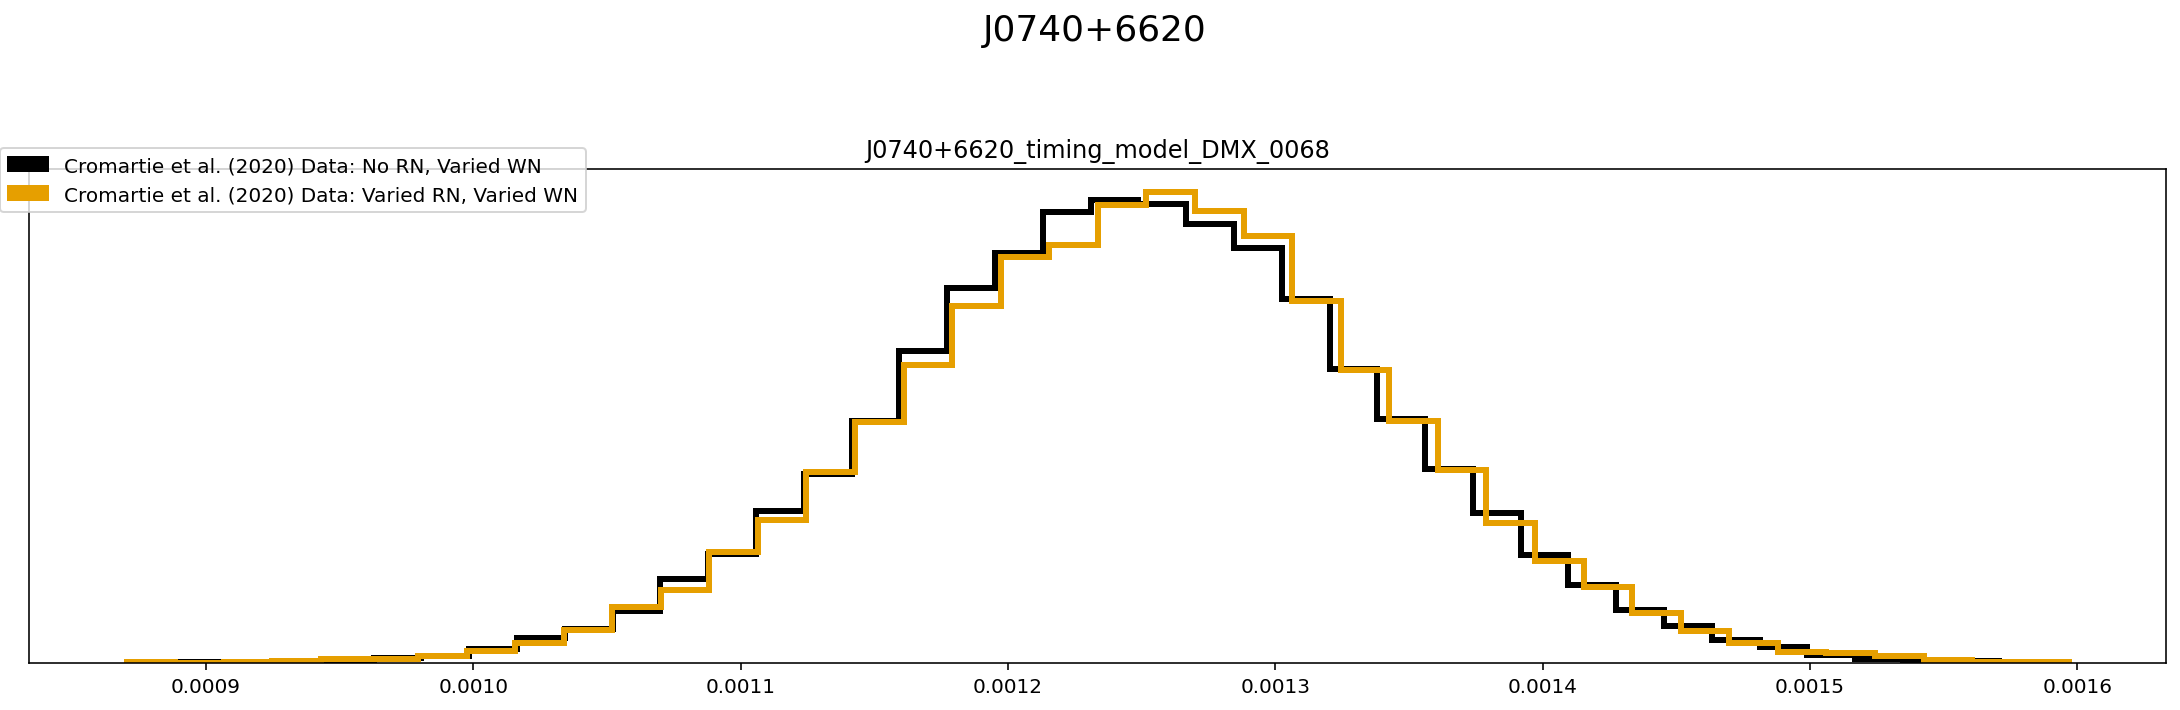

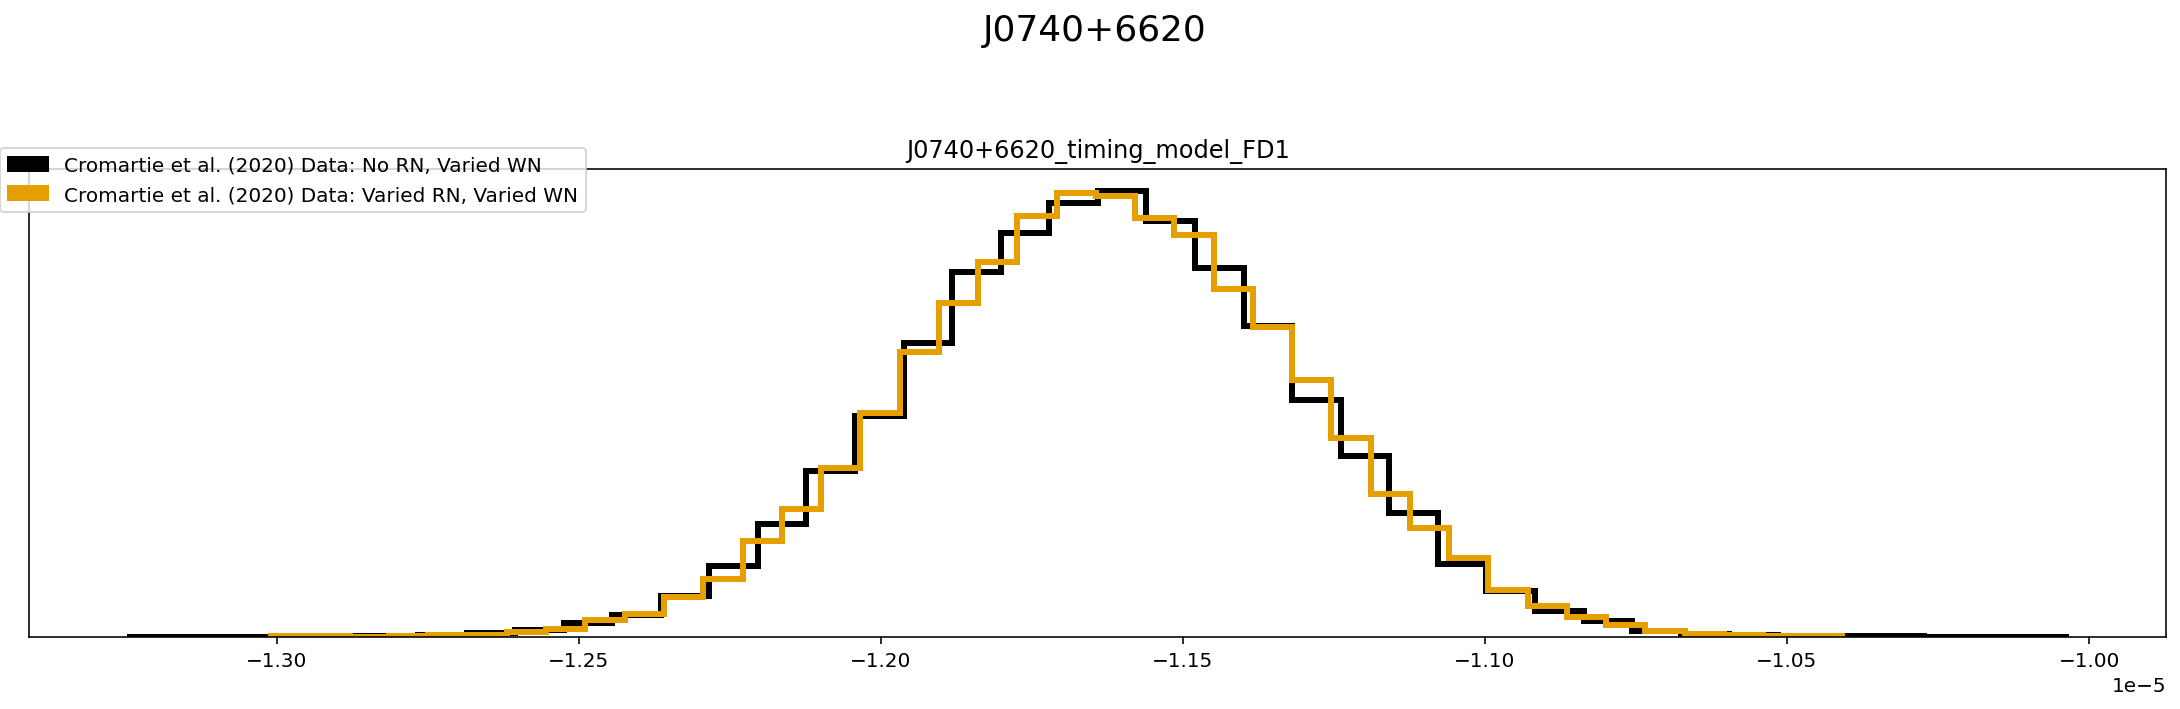

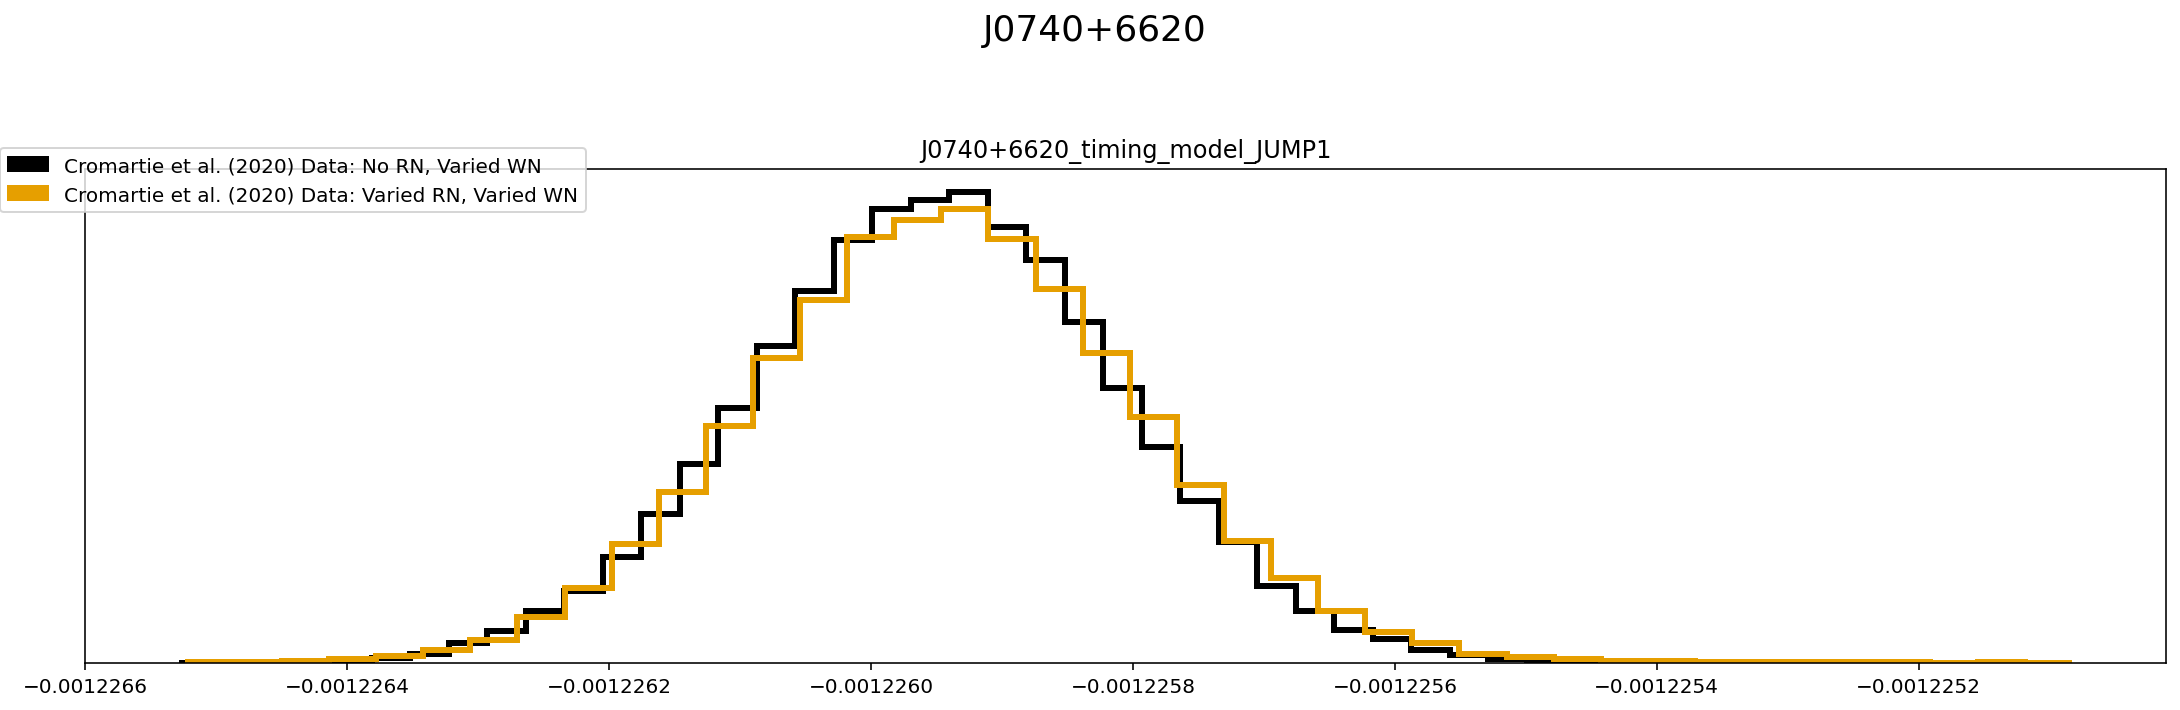

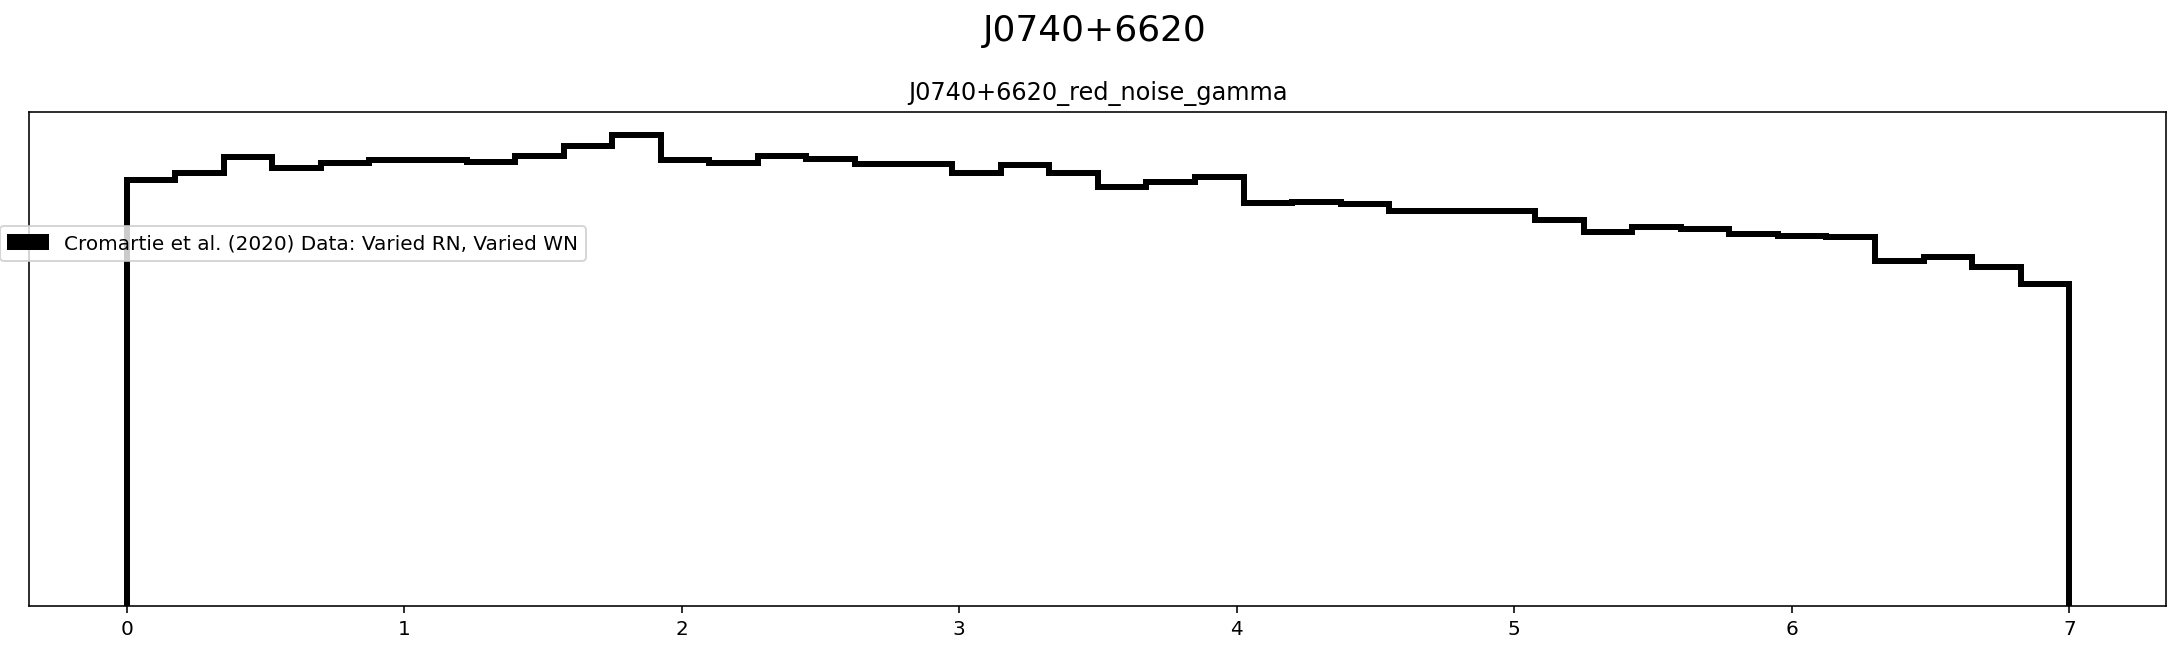

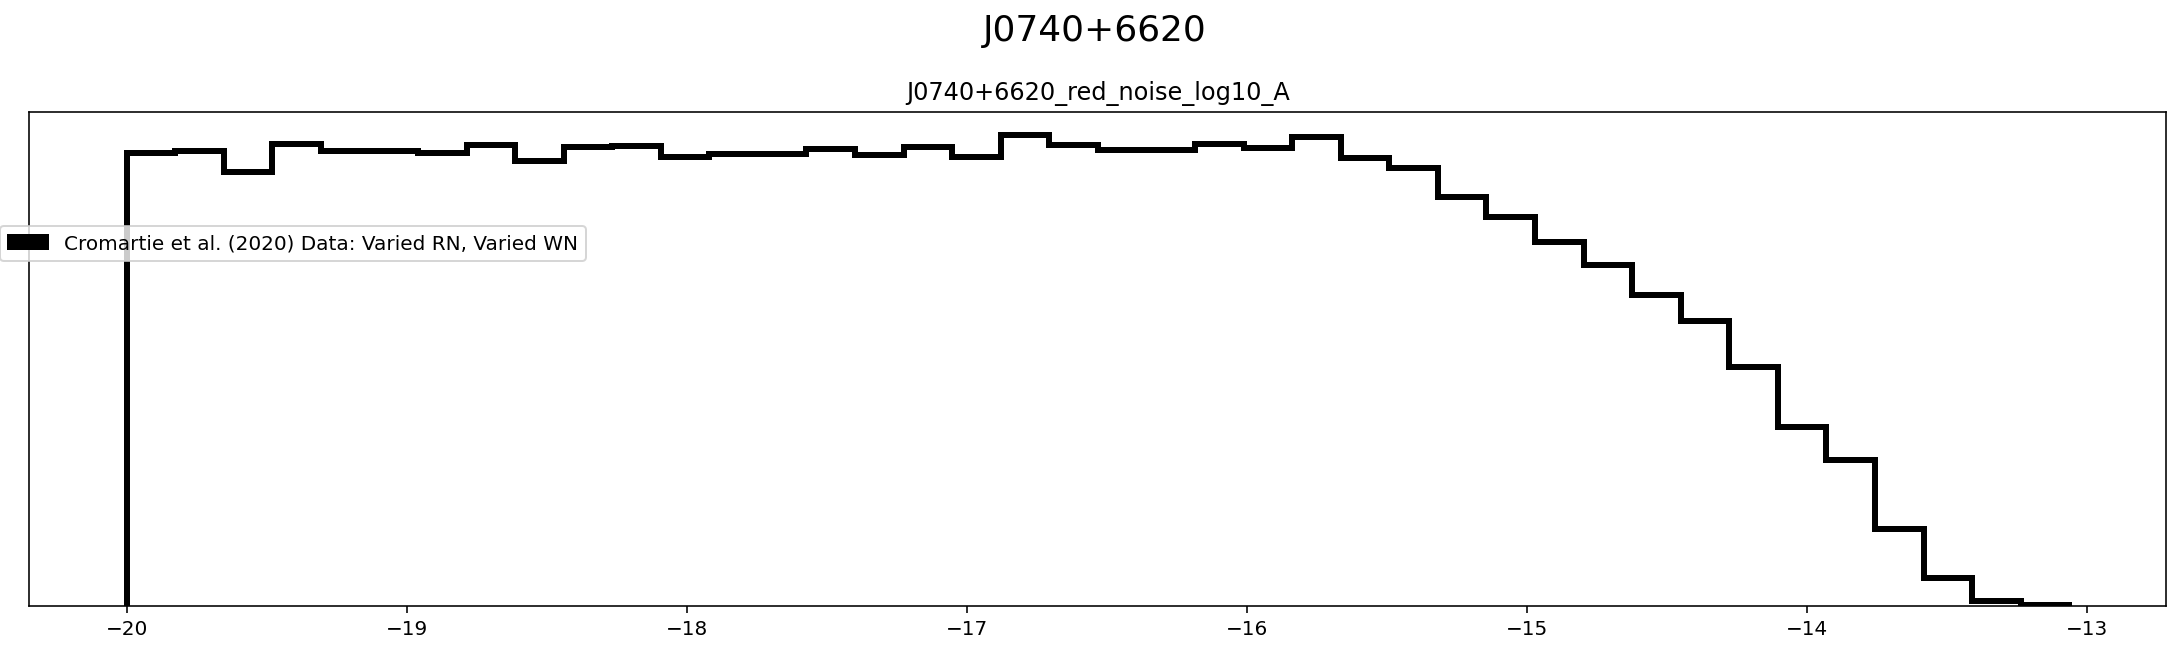

In [26]:
plot_other_param_overlap(core_list_cfr19,core_list_legend=core_list_legend_cfr19)

In [27]:
c_e_e_1 = core_cfr19_DE436_noRN_varyWN_COSI_1
c_e_e_2 = core_cfr19_DE436_noRN_varyWN_lin_DMX_JUMP_FD_COSI_1
c_e_e_3 = core_cfr19_DE436_varyRN_varyWN_COSI_1

In [28]:
c_e_e_2_titles = get_titles(c_e_e_2)
map_idx_e_e_2 = np.argmax(c_e_e_2.get_param('lnpost',to_burn=True))
map_dict_e_e_2 = {}
mean_dict_e_e_2 = {}
for par in c_e_e_2.params:
    unscaled_param = c_e_e_2.get_param(par,to_burn=True)
    map_dict_e_e_2[par] = unscaled_param[map_idx_e_e_2]
    mean_dict_e_e_2[par] = np.mean(unscaled_param)

In [29]:
map_dict_e_e_2

{'J0740+6620_Rcvr1_2_GUPPI_efac': 1.0374987850481554,
 'J0740+6620_Rcvr1_2_GUPPI_log10_ecorr': -7.799587021160992,
 'J0740+6620_Rcvr1_2_GUPPI_log10_equad': -7.3434970220764,
 'J0740+6620_Rcvr_800_GUPPI_efac': 1.007893594897567,
 'J0740+6620_Rcvr_800_GUPPI_log10_ecorr': -8.296435517643989,
 'J0740+6620_Rcvr_800_GUPPI_log10_equad': -6.632667652528204,
 'J0740+6620_timing_model_A1': 3.9775561256697722,
 'J0740+6620_timing_model_COSI': 0.0418255109828393,
 'J0740+6620_timing_model_ELAT': 0.7697335657487041,
 'J0740+6620_timing_model_ELONG': 1.8109385535740448,
 'J0740+6620_timing_model_EPS1': -5.71116328671331e-06,
 'J0740+6620_timing_model_EPS2': -1.8461316110798119e-06,
 'J0740+6620_timing_model_F0': 346.5319964932134,
 'J0740+6620_timing_model_F1': -1.4638569911717488e-15,
 'J0740+6620_timing_model_M2': 0.25354174529183554,
 'J0740+6620_timing_model_PB': 4.766944619070972,
 'J0740+6620_timing_model_PMELAT': -32.42043906594138,
 'J0740+6620_timing_model_PMELONG': -2.738941173711217,
 'J0

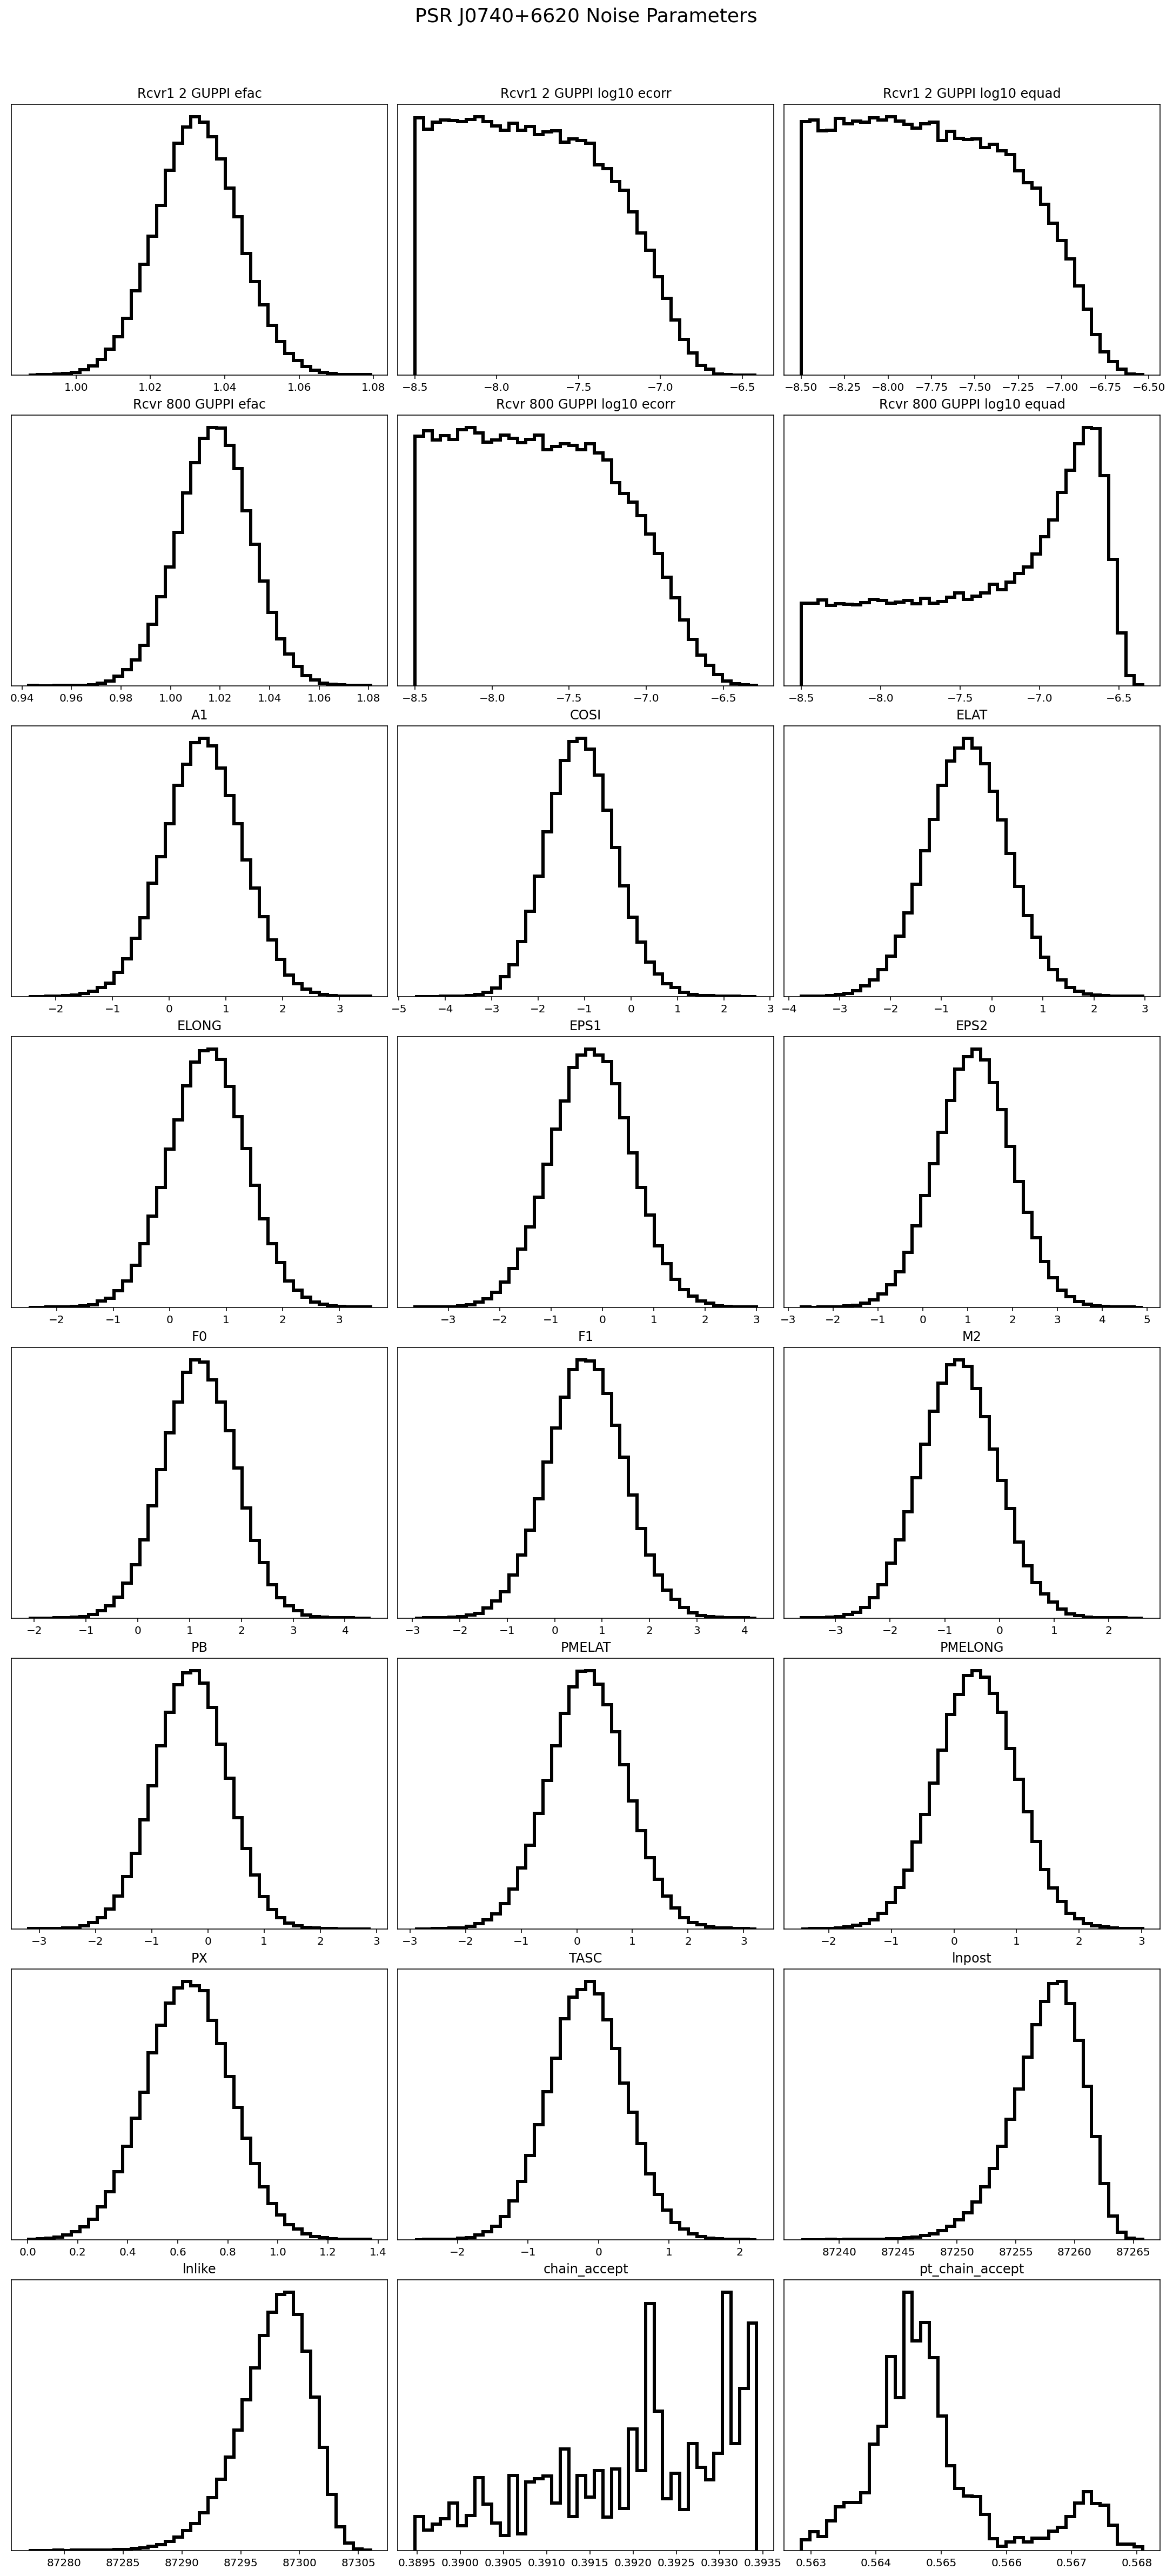

In [30]:
hist_core_kwargs = {'hist':True, 'ncols':3,'title_y':1.03,
                'hist_kwargs':dict(fill=False),'linewidth':3.}
dg.plot_chains(c_e_e_2,
               pars=c_e_e_2.params,
               titles=c_e_e_2_titles,
               real_tm_pars=False,
               **hist_core_kwargs)

COSI added to tm_params_orig for to work with tm_delay.
{'ELONG': 1.8109385535561575153, 'ELAT': 0.76973356577954543667, 'F0': 346.53199649321334164, 'F1': -1.4638695341186719214e-15, 'PMELONG': -2.7375645125875562869, 'PMELAT': -32.426266691801743036, 'PX': 0.64172506104149984463, 'SINI': 0.999137588225236504, 'PB': 4.766944619070524247, 'A1': 3.9775561474501377468, 'TASC': 57552.08324414744129, 'EPS1': -5.7081286491770117644e-06, 'EPS2': -1.8557521478031539245e-06, 'M2': 0.252299811273067498}


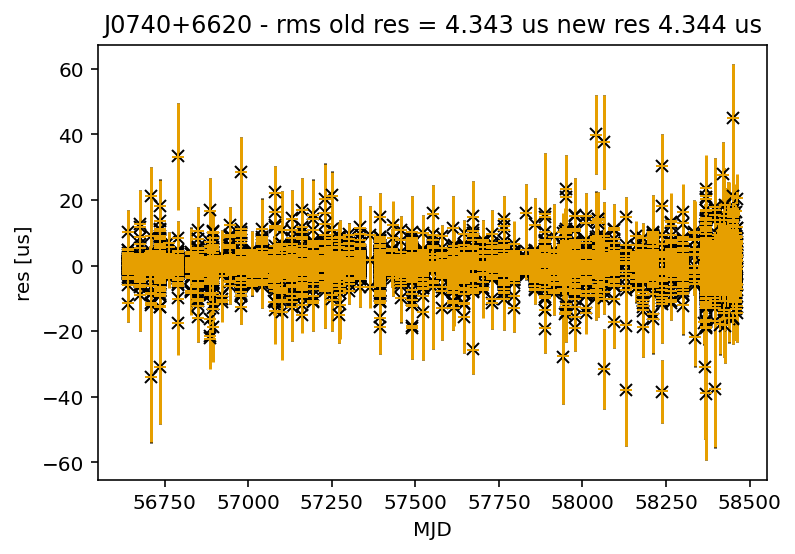

In [31]:
use_map = False
#use_map = False
if use_map:
    e_e_2_dict = deepcopy(map_dict_e_e_2)
else:
    e_e_2_dict = deepcopy(mean_dict_e_e_2)
try:
    chain_tm_params_orig = deepcopy(tm_params_orig)
    chain_tm_delay_kwargs = {}
    for par in psr.t2pulsar.pars():
        if par in c_e_e_2_titles:
            chain_tm_params_orig[par][-1] = 'physical'
            chain_tm_delay_kwargs[par] = e_e_2_dict[c_e_e_2.params[c_e_e_2_titles.index(par)]]
        elif par == 'SINI' and 'COSI' in c_e_e_2_titles:
            print("COSI added to tm_params_orig for to work with tm_delay.")
            sin_val, sin_err, _ = chain_tm_params_orig[par]
            val = np.longdouble(np.sqrt(1 - sin_val ** 2))
            err = np.longdouble(
                np.sqrt((np.abs(sin_val / val)) ** 2 * sin_err ** 2)
            )
            chain_tm_params_orig['COSI'] = [val, err, "physical"]
            chain_tm_delay_kwargs['COSI'] = e_e_2_dict[c_e_e_2.params[c_e_e_2_titles.index('COSI')]]
    tm_delay(psr.t2pulsar,chain_tm_params_orig,**chain_tm_delay_kwargs);
    plt.show()
except:
    print("Noise only run? Can't do it.")

In [32]:
c_e_e_1_titles = get_titles(c_e_e_1)
map_idx_e_e_1 = np.argmax(c_e_e_1.get_param('lnpost',to_burn=True))
map_dict_e_e_1 = {}
mean_dict_e_e_1 = {}
for par in c_e_e_1.params:
    unscaled_param = c_e_e_1.get_param(par,to_burn=True)
    map_dict_e_e_1[par] = unscaled_param[map_idx_e_e_1]
    mean_dict_e_e_1[par] = np.mean(unscaled_param)

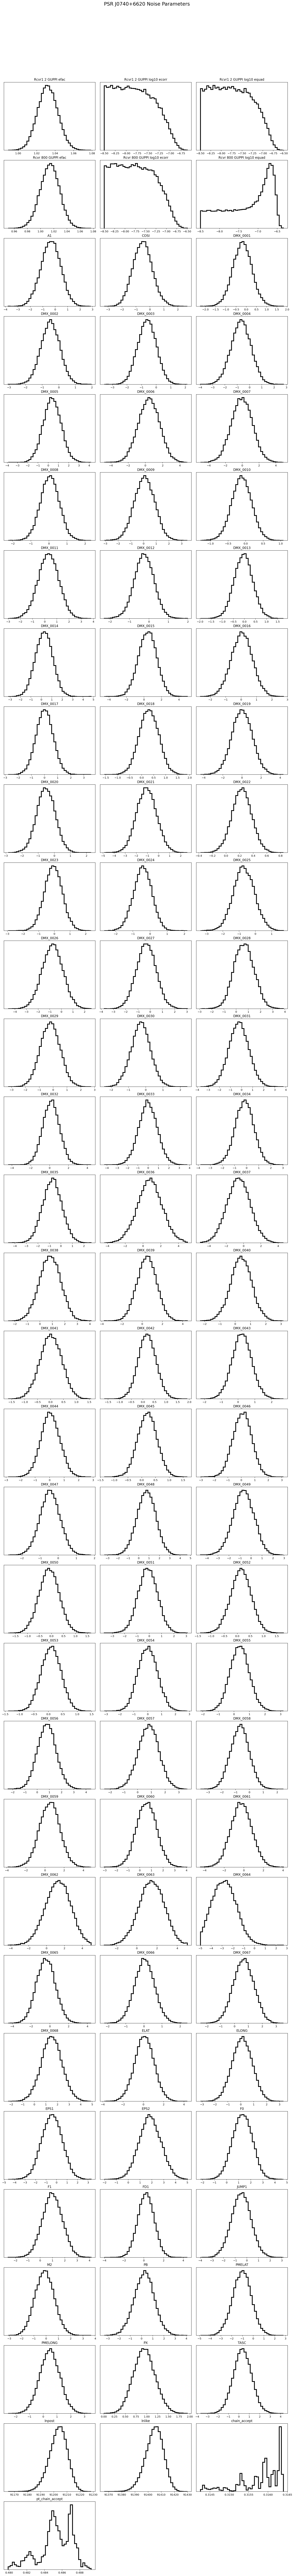

In [33]:
hist_core_kwargs = {'hist':True, 'ncols':3,'title_y':1.03,
                'hist_kwargs':dict(fill=False),'linewidth':3.}
dg.plot_chains(c_e_e_1,
               pars=c_e_e_1.params,
               titles=c_e_e_1_titles,
               real_tm_pars=False,
               **hist_core_kwargs)

COSI added to tm_params_orig for to work with tm_delay.
{'ELONG': 1.8109385534099744497, 'ELAT': 0.7697335659404846986, 'F0': 346.53199649321339848, 'F1': -1.4638617120327594351e-15, 'PMELONG': -2.734172965435317959, 'PMELAT': -32.4725112588385727, 'PX': 0.9426205290649961599, 'SINI': 0.99905058341068611046, 'PB': 4.7669446191312516703, 'A1': 3.9775559968291043234, 'TASC': 57552.08324415556126, 'EPS1': -5.718153792017530867e-06, 'EPS2': -1.8366393710029520241e-06, 'M2': 0.25693010202259913832, 'FD1': -1.1633006394474512465e-05, 'DMX_0001': -0.0003392236164319358113, 'DMX_0002': -1.772788310227410921e-05, 'DMX_0003': -0.0002712003173925126953, 'DMX_0004': -0.00012892273851603156909, 'DMX_0005': -0.00019808750221455951961, 'DMX_0006': -0.00015686384423267162361, 'DMX_0007': -0.00021162949017518480066, 'DMX_0008': -0.000114359044224784811724, 'DMX_0009': -0.00015811133204499014078, 'DMX_0010': 0.00012713355934275278312, 'DMX_0011': -0.00010104685092684990511, 'DMX_0012': -0.00030500412283

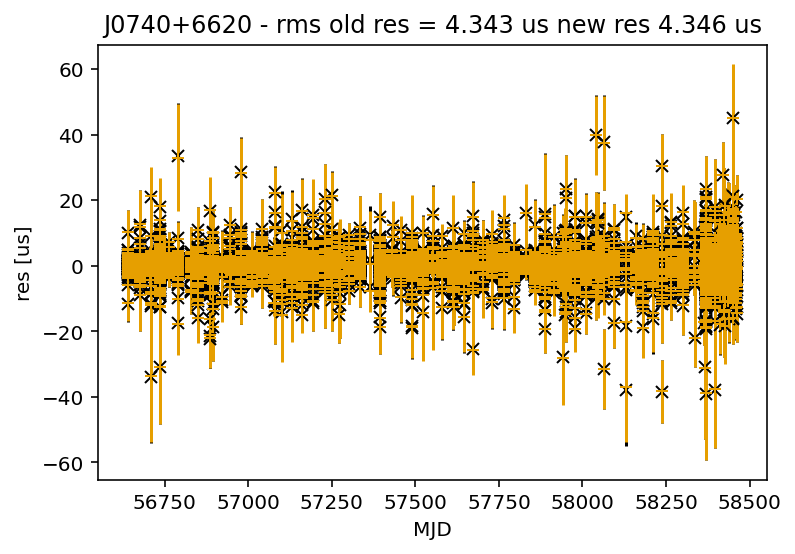

In [34]:
#use_map = True
use_map = False
if use_map:
    e_e_1_dict = deepcopy(map_dict_e_e_1)
else:
    e_e_1_dict = deepcopy(mean_dict_e_e_1)
try:
    e_e_1_tm_params_orig = deepcopy(tm_params_orig)
    e_e_1_tm_delay_kwargs = {}
    for par in psr.t2pulsar.pars():
        if par in c_e_e_1_titles:
            e_e_1_tm_params_orig[par][-1] = 'physical'
            e_e_1_tm_delay_kwargs[par] = e_e_1_dict[c_e_e_1.params[c_e_e_1_titles.index(par)]]
        elif par == 'SINI' and 'COSI' in c_e_e_1_titles:
            print("COSI added to tm_params_orig for to work with tm_delay.")
            sin_val, sin_err, _ = e_e_1_tm_params_orig[par]
            val = np.longdouble(np.sqrt(1 - sin_val ** 2))
            err = np.longdouble(
                np.sqrt((np.abs(sin_val / val)) ** 2 * sin_err ** 2)
            )
            e_e_1_tm_params_orig['COSI'] = [val, err, "physical"]
            e_e_1_tm_delay_kwargs['COSI'] = e_e_1_dict[c_e_e_1.params[c_e_e_1_titles.index('COSI')]]

    tm_delay(psr.t2pulsar,e_e_1_tm_params_orig,**e_e_1_tm_delay_kwargs);
    plt.show()
except:
    print("Noise only run? Can't do it.")

In [35]:
print(s)

NameError: name 's' is not defined

# Likelihood Comparison

In [ ]:
if 'noise_only' in c_e_e_1.label:
    tm_var=False
else:
    tm_var=True

if 'no_tm' in c_e_e_1.label:
    incTimingModel=False
else:
    incTimingModel=True
    
if 'full' in c_e_e_1.label:
    lin_dmx_jump_fd=False
else:
    lin_dmx_jump_fd=True
    
pta = pta_setup(psr,datarelease="9yr",psr_name=psr_name,
                tm_var=tm_var,red_var=False,
                white_var=True,fit_remaining_pars=True,
                lin_dmx_jump_fd=lin_dmx_jump_fd,
                tm_linear=False,
                incTimingModel=incTimingModel,Ecorr_gp_basis=False)

In [ ]:
exlude_params = ['lnpost','lnlike','chain_accept','pt_chain_accept']

In [ ]:
"""
for par,val in map_dict_e_e_2.items():
    print(par,val)
for par,val in map_dict_e_e_1.items():
    print(par,val)
"""
max_lnlike = pta.get_lnlikelihood({p:v for p, v in map_dict_e_e_1.items() if p not in exlude_params})
max_lnprior = pta.get_lnprior({p:v for p, v in map_dict_e_e_1.items() if p not in exlude_params})

print(map_dict_e_e_2['lnlike'],map_dict_e_e_2['lnpost'])
print(map_dict_e_e_1['lnlike'],map_dict_e_e_1['lnpost'])
print(max_lnlike,max_lnlike+max_lnprior)

Here we take n_samples of chain slices from the e_e_1 chain to get the parameter values at each slice. Then for that set of parameters/values, we calculate the likelihood and prior in Enterprise. 

In [ ]:
e_e_lnlike_array = []
e_e_lnprior_array = []
n_samples = 1000
for idx in np.random.randint(c_e_e_2.burn, c_e_e_2.chain.shape[0],n_samples):
    x0 = c_e_e_2.chain[idx,:-4]
    #[print(x,': ',y) for x,y in zip(map_dict_e_e_2.keys(),x0)]
    #print('-----')
    e_e_lnlike = pta.get_lnlikelihood({nm:p for nm, p in zip(map_dict_e_e_2.keys(),x0)})
    e_e_lnprior = pta.get_lnprior({nm:p for nm, p in zip(map_dict_e_e_2.keys(),x0)})
    e_e_lnlike_array.append(e_e_lnlike)
    e_e_lnprior_array.append(e_e_lnprior)
    #print(e_e_lnprior)
    #print(e_e_lnlike,c_e_e_2.chain[idx,-3])
    #print(e_e_lnlike+e_e_lnprior,c_e_e_2.chain[idx,-4])
    #print(c_e_e_2.chain[idx,-4]-c_e_e_2.chain[idx,-3])
    #print('-----')

In [ ]:
e_e_1_lnlike_array = []
e_e_1_lnprior_array = []
n_samples = 1000
for idx in np.random.randint(c_e_e_1.burn, c_e_e_1.chain.shape[0],n_samples):
    x0 = c_e_e_1.chain[idx,:-5]
    #[print(x,': ',y) for x,y in zip(map_dict_e_e_1.keys(),x0)]
    #print('-----')
    e_e_1_lnlike = pta.get_lnlikelihood({nm:p for nm, p in zip(map_dict_e_e_1.keys(),x0)})
    e_e_1_lnprior = pta.get_lnprior({nm:p for nm, p in zip(map_dict_e_e_1.keys(),x0)})
    e_e_1_lnlike_array.append(e_e_1_lnlike)
    e_e_1_lnprior_array.append(e_e_1_lnprior)
    #print(e_e_1_lnprior)
    #print(e_e_1_lnlike,c_e_e_1.chain[idx,-4])
    #print(c_e_e_1.chain[idx,-4]-e_e_1_lnlike)
    #print(c_e_e_1.chain[idx,-5]-c_e_e_1.chain[idx,-4])
    #print(e_e_1_lnlike+e_e_1_lnprior,c_e_e_1.chain[idx,-5])
    #print('-----')

"""
for idx in np.random.randint(nihan.burn, nihan.chain.shape[0],20):
    x0 = nihan.chain[idx,:-4]
#     print(x0)
    lnlike = pta.get_lnlikelihood({nm:p for nm, p in zip(pta.param_names,x0)})
    lnprior = pta.get_lnprior({nm:p for nm, p in zip(pta.param_names,x0)})
    print(lnprior)
    print(lnlike,nihan.chain[idx,-3])
    print(lnlike+lnprior,nihan.chain[idx,-4])
    print('-----')
"""

In [ ]:
plt.hist(e_e_1_lnlike_array,bins=30,density=True,log=True,label='e_e_1 in Enterprise',color='C1',alpha=.5)
plt.hist(c_e_e_2.get_param('lnlike'),bins=30,density=True,log=True,label='Enterprise Run',color='C2',alpha=.5)
plt.hist(c_e_e_1.get_param('lnlike'),bins=30,density=True,log=True,label='e_e_1 Run',color='C3')
plt.axvline(x=max_lnlike,color='C4',label='e_e_1 max likelihood slice',linestyle='--')
plt.xlabel('lnlike')
plt.legend(loc='upper left')
plt.show()


In [ ]:
plt.hist(c_e_e_1.get_param('lnlike'),bins=10,density=True,log=True,label='e_e_1 Run',color='C3');


In [ ]:
plt.hist(np.asarray(e_e_1_lnlike_array)+np.asarray(e_e_1_lnprior_array),bins=30,density=True,log=True,label='e_e_1 in Enterprise')
plt.hist(c_e_e_2.get_param('lnpost'),bins=30,density=True,log=True,label='Enterprise Run')
plt.axvline(x=max_lnlike+max_lnprior,color='C2',label='e_e_1 max likelihood slice')
plt.xlabel('lnpost')
plt.legend()
plt.show()

In [ ]:
print(pta.param_names,x0)

In [ ]:
print('Parameter \t\t NLTM MAP \t\t e_e_1 e_e_1 MAP \t\t Rel Diff abs(e_e_1-NLTM)/e_e_1')
for par,val in chain_tm_delay_kwargs.items():
    if par in e_e_1_tm_delay_kwargs:
        print(f'{par}: \t\t',val,'\t\t',e_e_1_tm_delay_kwargs[par],'\t\t',
              np.abs(e_e_1_tm_delay_kwargs[par]-val)/e_e_1_tm_delay_kwargs[par])
    elif par == 'COSI':
        print(f'{par}: \t\t',val,'\t\t',np.sqrt(1-e_e_1_tm_delay_kwargs['SINI']**2),'\t\t',
              np.abs(np.sqrt(1-e_e_1_tm_delay_kwargs['SINI']**2)-val)/np.sqrt(1-e_e_1_tm_delay_kwargs['SINI']**2))
    else:
        print(f'{par}: \t\t',val,'\t\t','--')